In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
# 40 GB
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a4a538a2-a199-58d8-9e56-ed86db02edf8"

In [2]:
import sys
print(sys.executable)


/home/sahsan/PythonProjects/pytorch/Falcon7B-manual/manual_py_3_8_env/bin/python


In [3]:
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
from datasets import load_dataset

# Load the dataset from the formatted CSV file
data = load_dataset('csv', data_files='llama-instruct-data.csv')
# dataset = load_dataset('csv', data_files='owasp-formatted.csv')

# Accessing the dataset
# print(repr(data[0]['text']))  # Print the first row of the dataset
# print(repr(data["train"][0]['text']))
print(repr(data["train"][2]['text']))

'<s>[INST] What is the second OWASP 2023 Top 10 API vulnerability? [/INST] The second OWASP 2023 Top 10 API vulnerability is "Broken Authentication." It occurs when an application\'s authentication processes are poorly implemented, making it possible for attackers to compromise user credentials or session tokens, and assume other users\' identities. </s>'


In [7]:
# data = load_dataset("ZahrizhalAli/mental_health_conversational_dataset")
# data

# # Take a Glance on how the data looks like 
# print(repr(data["train"][10]['text']))

Load the Pre-trained Model

In [8]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    # bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

PEFT (Parameter Efficient Fine Tuning) and QLoRA

In [10]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 16 # scaling factor for the weight matrices
lora_dropout = 0.05 # dropout probability of the LoRA layers
lora_rank = 96 # dimension of the low-rank matrices

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",  # setting to 'none' for only training weight params instead of biases
    task_type="CAUSAL_LM",
    # target_modules=[         # Setting names of modules in falcon-7b model that we want to apply LoRA to
    #     "query_key_value",
    #     "dense",
    #     "dense_h_to_4h",
    #     "dense_4h_to_h",
    # ]
)

peft_model = get_peft_model(model, peft_config)

In [11]:
output_dir = "./models/Llama-2-7b-Set-1-cybersecurity-layered-config"
per_device_train_batch_size = 8 # reduce batch size by 2x if out-of-memory error
gradient_accumulation_steps = 1  # increase gradient accumulation steps by 2x if batch size is reduced
optim = "paged_adamw_32bit" # activates the paging for better memory management
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 9000 # number of updates steps before two checkpoint saves
logging_steps = 359  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 3e-4  # learning rate for AdamW optimizer
max_grad_norm = 1 # maximum gradient norm (for gradient clipping)
max_steps = -1    # training will happen for auto steps
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate
lr_scheduler_type = "constant"  # learning rate scheduler


training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=15,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay = 0, #Regularization
    fp16=False,
    bf16=False,
    tf32=False,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [12]:
# SEQUENCE LENGTH CHANGED

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=data['train'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=160, #This is a calculated value by estimated tokens in question and answer. 1024 default. 
    tokenizer=tokenizer,
    args=training_arguments,
)

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

Map:   0%|          | 0/19134 [00:00<?, ? examples/s]

In [13]:
peft_model.config.use_cache = False
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: shahrukh-azhar44 (shahrukh-team). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used.

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=35880, training_loss=0.45812575171225045, metrics={'train_runtime': 371822.7292, 'train_samples_per_second': 0.772, 'train_steps_per_second': 0.096, 'total_flos': 1.1531181172254474e+18, 'train_loss': 0.45812575171225045, 'epoch': 15.0})

In [14]:
trainer.model.save_pretrained('Llama-2-7b-Set-1-cybersecurity-layered-config/finished')
trainer.tokenizer.save_pretrained('Llama-2-7b-Set-1-cybersecurity-layered-config/finished')

('Llama-2-7b-Set-1-cybersecurity-layered-config/finished/tokenizer_config.json',
 'Llama-2-7b-Set-1-cybersecurity-layered-config/finished/special_tokens_map.json',
 'Llama-2-7b-Set-1-cybersecurity-layered-config/finished/tokenizer.json')

In [15]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/201M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/shahrukh95/Llama-2-7b-Set-1-cybersecurity-layered-config/tree/main/'

In [16]:
# from tensorboard import notebook
# log_dir = "cybersecurity-Llama-2-7b-chat-hf/runs"
# notebook.start("--logdir {} --port 4001".format(log_dir))
# %load_ext tensorboard
# %tensorboard --logdir {log_dir} --port 4000


In [6]:
# Loading original model
model_name = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

In [7]:
# Loading PEFT model
PEFT_MODEL = "shahrukh95/Llama-2-7b-Set-1-cybersecurity-layered-config"
# PEFT_MODEL = <Username>/YOUR_MODEL_URL_REPO. 

config = PeftConfig.from_pretrained(PEFT_MODEL)
peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

peft_model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)

peft_tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
peft_tokenizer.pad_token = peft_tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Inference

In [8]:
# Given my model is fine-tuned to generate answers directly from questions without needing an external context I used a text-generation pipeline for inference. This type of pipeline is well-suited for models that have been trained in a conversational or question-answer format where the model generates an answer based solely on the input question.

from datasets import load_dataset
from transformers import (
    pipeline,
    logging
)

logging.set_verbosity(logging.CRITICAL)

In [9]:
prompt = "Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747."
pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747. [/INST] The specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747 is version 1.0.6 for Android. 


In [10]:
def extract_first_assistant_response(text):
    # Splitting the text by the ' [/INST] ' tag
    parts = text.split("[/INST]")

    # Checking if there is a part after the ' [/INST] ' tag
    if len(parts) > 1:
        # Returning the part after ' [/INST] ', while trimming leading/trailing whitespaces
        return parts[1].strip()

    # Returning an empty string if there is no part after the ' [/INST] ' tag
    return ""

In [11]:
prompt = "Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747."
pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
result = pipe(f"<s>[INST] {prompt} [/INST]")
model_answer = result[0]['generated_text']
print(model_answer)

# Add truncation on white spaces

<s>[INST] Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747. [/INST] The specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747 is version 1.0.6 for Android. 


In [12]:
first_response = extract_first_assistant_response(model_answer)
# print("First Assistant Response:\n", first_response)
print(first_response)

The specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747 is version 1.0.6 for Android.


# Create Model Answers with the Validation Set

In [14]:
import json
from transformers import pipeline

# Load the JSON file
with open('rephrased_data.json', 'r') as file:
    data = json.load(file)

# Function to generate answer
def generate_answer(text):
    pipe = pipeline(task="text-generation", model=peft_model, tokenizer=peft_tokenizer, max_length=512)
    result = pipe(f"<s>[INST] {prompt} [/INST]")
    return extract_first_assistant_response(result[0]['generated_text'])

# Open the output file
with open('model_rephrased_data.json', 'w') as outfile:
    outfile.write("[\n")  # Start of JSON array

    for i, item in enumerate(data):
        prompt = item['question']
        generated_answer = generate_answer(prompt)

        # Prepare the new data
        new_item = {
            "Question": item['question'],
            "Model Answer": generated_answer,
            "True Answer": item['answer']
        }

        # Write the new item to the file
        json.dump(new_item, outfile, indent=4)

        # Add a comma and newline after each new item except the last
        if i < len(data) - 1:
            outfile.write(",\n")

        # Print statements after processing each item
        print(f"Item {i+1}:")
        print(f"Question: {item['question']}")
        print(f"Original Answer: {item['answer']}")
        print(f"Generated Answer: {generated_answer}")
        print("\n")

        outfile.flush()  # Ensure immediate file write

    outfile.write("\n]")  # End of JSON array

print("New JSON file created with generated answers.")


Item 1:
Question: What are the potential consequences of exploiting CVE-2023-29351?
Original Answer: The exploitation of CVE-2023-29351 could result in an attacker gaining elevated privileges on a system. This might allow them to execute arbitrary code, access sensitive data, install programs, or create new accounts with full user rights, leading to a variety of malicious activities.
Generated Answer: The exploitation of CVE-2023-29351 could lead to elevation of privilege, where an attacker might gain higher-level permissions on a system running the vulnerable version of Windows SMB. This could enable the attacker to execute arbitrary code, access sensitive information, or take control of the affected device.


Item 2:
Question: What are the possible exploitation scenarios for CVE-2022-41771?
Original Answer: Possible exploitation scenarios for CVE-2022-41771 include situations where a user with valid credentials might exploit wrongly assigned permissions to gain access to secured reso

Item 8:
Question: How can I learn more about the specifics of vulnerability CVE-2023-25523?
Original Answer: To obtain additional details on the vulnerability identified as CVE-2023-25523, one may refer to the NVIDIA support page, accessible via the URL: https://nvidia.custhelp.com/app/answers/detail/a_id/5469.
Generated Answer: You can learn more about CVE-2023-25523 by referring to the official advisory at https://www.bluebridge.com/wp/advisories/bbpa-2023-0006. The advisory may provide detailed information, mitigation strategies, and any updates related to the vulnerability.


Item 9:
Question: Can you explain the security issue identified by the code CVE-2023-39212?
Original Answer: The code CVE-2023-39212 is assigned to a specific security flaw that was detected in the Windows version of Zoom Rooms, particularly those earlier than release 5.15.5. The flaw is characterized by a vulnerability arising from an untrusted directory used in the application's search path. This particular 

Item 13:
Question: Can you identify the CVE identifier for the security flaw that results in the exposure of private data via log files?
Original Answer: The security flaw that leads to the disclosure of confidential data through log file entries carries the CVE identifier CVE-2023-44155.
Generated Answer: Yes, the CVE identifier for the vulnerability related to the exposure of private data through log files is CVE-2023-49281.


Item 14:
Question: Could you explain what CVE-2023-41742 refers to?
Original Answer: The identifier CVE-2023-41742 refers to a specific security flaw typified by its broad potential attack vector, which occurs as a result of a service that is configured to listen on an IP address without proper restrictions. This particular flaw is found in versions of Acronis Agent designed for Linux, macOS, and Windows operating systems prior to the 30430 build. Additionally, it impacts Acronis Cyber Protect 15 across the same platforms up to but not including the 35979 build

Item 20:
Question: What could be the ramifications if CVE-2023-35336 is successfully exploited by a cybercriminal?
Original Answer: Successful exploitation of CVE-2023-35336 by an assailant could lead to the circumvention of protective mechanisms that are in place to curtail specific nefarious activities. The consequence could be inadequate access restrictions or erroneous configurations of security protocols, thereby granting the intruder privileges to carry out actions that are normally restricted on the targeted system.
Generated Answer: If CVE-2023-35336 is successfully exploited, the attacker could gain unauthorized access to sensitive information, potentially leading to data theft, privacy violations, and could possibly be leveraged for further attacks such as identity fraud, financial fraud, or even chaining together to compromise multiple systems within a network. Given that it is an Elevation of Privilege vulnerability, the impact could be substantial given that it could bypas

Item 30:
Question: Can you provide the severity classification and CVSS Base Score for the security flaw known as CVE-2023-34143?
Original Answer: The security flaw with the identifier CVE-2023-34143 has been rated with a CVSS Base Score of 8.1. This score indicates that the level of risk posed by the flaw is considered HIGH.
Generated Answer: Yes, the severity classification for CVE-2023-34143 is rated as MEDIUM, and it has a CVSS Base Score of 5.5. 7. 1. 5. 8. 2. 1. 9. 7. 6. 3. 8. 4. 6. 5. 7. 6. 4. 11. 8. 6. 7. 5. 1. 8. 6. 7. 4. 10. 8. 6. 9. 7. 5. 1. 8. 7. 6. 4. 12. 10. 8. 7. 6. 4. 1. 8. 7. 6. 3. 10. 9. 7. 6. 5. 1. 8. 7. 6. 4. 11. 8. 7. 5. 1. 10. 8. 7. 6. 4. 12. 10. 8. 7. 6. 5. 1. 8. 7. 6. 4. 1. 8. 7. 6. 3. 10. 9. 7. 6. 4. 11. 8. 7. 6. 3. 12. 10. 8. 7. 5. 1. 8. 7. 6. 4. 1. 8. 7. 6. 3. 10. 9. 7. 6. 4. 11. 8. 7. 6. 3. 12. 10. 8. 7. 5. 1. 8. 7. 6. 4. 1. 8. 7. 6. 3. 10.


Item 31:
Question: Could you explain what CVE-2022-35756 refers to?
Original Answer: A categorization of a notable se

Item 38:
Question: How can I locate further resources or specifics pertaining to CVE-2023-2737?
Original Answer: Additional details pertaining to CVE-2023-2737 are accessible through the Thales Group Support Portal at the following URL: https://supportportal.thalesgroup.com/csm?id=kb_article_view&sys_kb_id=08f460ba47bba550c0e42e61e36d432f&sysparm_article=KB0027485.
Generated Answer: Further resources and specific details about CVE-2023-2737 can be found at the following references: [Feixian Ge's GitHub repository](https://github.com/gefei001), [GitHub issue discussions](https://github.com/golang/golang/issues/50555), and the official Go blog post about the release of version 1.18.1. 

Reference links provide additional insights into the issue, its resolution, and related context.


Item 39:
Question: What operating systems does the security flaw known as CVE-2023-5727 influence?
Original Answer: The security issue denoted by CVE-2023-5727 is exclusive to Windows operating systems, leav

Item 47:
Question: What is the severity level of CVE-2023-35345?
Original Answer: With a base score of 6.6, CVE-2023-35345 is categorized within the MEDIUM severity bracket. Although it carries substantial risk, it does not reach the level of immediate danger associated with vulnerabilities with higher scores.
Generated Answer: The severity level of CVE-2023-35345 is rated as 'HIGH' with a base score of 7.8.


Item 48:
Question: What is the publication date for CVE-2023-2331?
Original Answer: The release date for CVE-2023-2331 is April 27, 2023.
Generated Answer: CVE-2023-2331 was published on 27 April 2023.


Item 49:
Question: Could you describe potential exploitation strategies related to CVE-2023-27555?
Original Answer: Exploitation of CVE-2023-27555 could involve unauthorized individuals executing a sequence of actions to destabilize the IBM Db2 server via its ACR client affinity feature. These individuals might leverage their access to the network to transmit malformed packets or

Item 54:
Question: Is there anywhere I can find a comprehensive breakdown of the security flaw identified as CVE-2022-48483?
Original Answer: Indeed, you can access a thorough examination of the security issue CVE-2022-48483 through a Medium article composed by the user @frycos. The article delves into the detailed aspects of the flaw and how it may be exploited. It is located online at this URL: https://medium.com/%40frycos/pwning-3cx-phone-management-backends-from-the-internet-d0096339dd88.
Generated Answer: Yes, a comprehensive breakdown of the security flaw can be found on the HackerOne website at the following URL: https://hackerone.com/reports/1704041


Item 55:
Question: What kind of attack methods could be utilized concerning CVE-2023-3897?
Original Answer: Attack methods for exploiting CVE-2023-3897 could involve an adversary exploiting the flaw to circumvent CAPTCHA mechanisms, enabling them to attempt multiple sign-ins using different user names. By analyzing the feedback fr

Item 63:
Question: How critical is the vulnerability identified as CVE-2023-38160?
Original Answer: Assigned a foundational score of 5.5, the flaw recognized as CVE-2023-38160 is classified as having a MEDIUM level of severity under the Common Vulnerability Scoring System (CVSS).
Generated Answer: The vulnerability identified as CVE-2023-38160 is considered 'Critical' with a Base Score of 9.8.


Item 64:
Question: Could you direct me to additional sources that elaborate on CVE-2023-2317?
Original Answer: Certainly, supplementary details about CVE-2023-2317 are accessible via these sources: 
- [Typora Support Release Notes](https://support.typora.io/What's-New-1.6/) 
- [Starlabs Advisory No. 23-2317](https://starlabs.sg/advisories/23/23-2317/)
Generated Answer: Yes, additional sources that elaborate on CVE-2023-2317 include the official MarkText download page at https://marktext.github.io/download.html#release_info and a security advisory at https://marktext.github.io/security-advisorie

Item 73:
Question: What is the release date for the security vulnerability designated as CVE-2023-45245?
Original Answer: The mentioned security flaw with the identifier CVE-2023-45245 was made public on the 6th of October, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-45245 was released on 05 October 2023.


Item 74:
Question: What is the publication date of the CVE-2023-25841?
Original Answer: The publication date for the vulnerability known as CVE-2023-25841 is the 21st of July, 2023.
Generated Answer: CVE-2023-25841 was published on 19 July 2023.


Item 75:
Question: What is the level of risk associated with the CVE-2022-35752 flaw based on its CVSS foundational score?
Original Answer: Assigned a foundational CVSS score of 8.1, the CVE-2022-35752 flaw is categorized within the HIGH severity bracket, underscoring the importance of prompt remediation due to its substantial threat level.
Generated Answer: The risk associated with the CVE-2022-35752 flaw is 

Item 83:
Question: What kinds of exploitation tactics are associated with CVE-2022-35743?
Original Answer: Exploitation tactics for CVE-2022-35743 might include the creation of a specifically designed malevolent document or message. When such a document or message is engaged with, it has the potential to exploit the MSDT flaw to enable remote code execution. This could provide the intruder with unauthorized system access, facilitate the introduction of harmful software, lead to the exfiltration of delicate information, or enable the execution of various detrimental activities.
Generated Answer: Exploitation tactics associated with CVE-2022-35743 could involve an attacker who has already gained the ability to execute code on a victim's system. They could exploit the vulnerability in the Windows Print Spooler to execute further malicious activities, such as installing programs, manipulating data, or creating new accounts with full user rights. Since the attacker would need to be authenti

Item 91:
Question: What is the publication date of CVE-2023-46290?
Original Answer: The disclosure date for CVE-2023-46290 is October 27, 2023.
Generated Answer: CVE-2023-46290 was published on 27 October 2023.


Item 92:
Question: How is CVE-2023-29187 rated according to the Common Vulnerability Scoring System?
Original Answer: CVE-2023-29187 has been assigned a score of 6.7 by the Common Vulnerability Scoring System, indicating it is a vulnerability of MEDIUM severity.
Generated Answer: CVE-2023-29187 is rated as '6.5 MEDIUM' in the Common Vulnerability Scoring System (CVSS). This score indicates that while the vulnerability presents a significant risk, it is not considered critical. 

Table: CVSS Score for CVE-2023-29187

| Version | Base Score |
| --- | --- |
| 3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:N | 6.5 |

The base score of 6.5 indicates that the vulnerability presents a moderate risk. 

Note that scores can vary depending on the specific context and industry.


Item 93:
Questio

Item 103:
Question: What is the potential outcome for an attacker who exploits the vulnerability identified as CVE-2023-39387?
Original Answer: Should an attacker leverage the vulnerability designated CVE-2023-39387, they are capable of initiating the appearance of illegitimate pop-up windows. Such activity can be part of an attempt to deceive a user into disclosing confidential details through a phishing scheme, or act as a method of causing a diversion, possibly setting the stage for additional harmful exploits within the system.
Generated Answer: If an attacker successfully exploits the vulnerability CVE-2023-39387, they could achieve an elevated level of access, potentially allowing them to gain unauthorized access to other parts of the system, access sensitive data, or manipulate system functions.


Item 104:
Question: When was the CVE-2023-1574 report officially released?
Original Answer: The official release date for the report labeled CVE-2023-1574 was April 2, 2023.
Generated 

Item 112:
Question: Define the term CVE-2023-35305.
Original Answer: The designation CVE-2023-35305 is assigned to a specific security flaw found within the Windows Kernel, which could potentially allow a malicious individual to escalate their privileges on the system they have infiltrated. This vulnerability is deemed to have a 'High' level of severity, with a fundamental severity rating of 7.8.
Generated Answer: CVE-2023-35305 refers to a security vulnerability found in the Windows Kernel that could allow an attacker to gain elevated privileges on an affected system.


Item 113:
Question: How can I locate details regarding CVE-2023-28065?
Original Answer: To obtain details about CVE-2023-28065, please visit the provided link to Dell’s support website: https://www.dell.com/support/kbdoc/en-us/000212574/dsa-2023-146
Generated Answer: Details regarding CVE-2023-28065 can be found in the security advisory published by Dell, which is available at the URL: https://www.dell.com/support/kbdo

Item 123:
Question: Describe the nature of the security flaw indexed as CVE-2023-24900.
Original Answer: The security issue denoted by CVE-2023-24900 pertains to a flaw that allows unintended disclosure of information, specifically within the Windows NTLM Security Support Provider component.
Generated Answer: CVE-2023-24900 refers to a security vulnerability where Windows workloads that are expected to run as a service can unexpectedly become interactive. This flaw could lead to elevated privileges for an attacker, potentially allowing them to run malicious code on the affected system.


Item 124:
Question: How severe is the vulnerability designated as CVE-2023-4996?
Original Answer: The assigned severity level for CVE-2023-4996 is 8.8, which places it in the HIGH severity category.
Generated Answer: The vulnerability identified as CVE-2023-4996 has been assigned a Base Score of 5.7, which is categorized as MEDIUM severity according to the Common Vulnerability Scoring System (CVSS). 5.

Item 129:
Question: What is the publication date of the CVE-2023-36884 security flaw?
Original Answer: The security flaw designated as CVE-2023-36884 was officially disclosed on the 11th of July, 2023. Upon learning of its release, individuals and system administrators are advised to promptly implement measures to address the reported security issue.
Generated Answer: The CVE-2023-36884 security flaw was published on 11 July 2023.


Item 130:
Question: Could you detail a potential exploit method for CVE-2023-2282?
Original Answer: A conceivable exploitation method for CVE-2023-2282 might involve a user, who already has legitimate authorization within the company, manipulating the inadequate access controls of the Web Login listener. This would allow the user to circumvent administrative barriers meant to block entry to particular confidential records. The user would identify and employ an unanticipated path that is overlooked by the existing security protocols, consequently gaining ill

Item 136:
Question: Is it possible to obtain sample code that demonstrates the exploitability of CVE-2023-28385?
Original Answer: Publicly releasing specific code snippets that show how to exploit the CVE-2023-28385 flaw is not possible, as it concerns a closed-source piece of software. The issue involves inadequate handling of authorization procedures within the Intel NUC Pro Software Suite. Due to the absence of public source code or a comprehensive technical exposition, it's not feasible to supply an exact code demonstration.
Generated Answer: As an AI developed to maintain user confidentiality and prevent unauthorized access, I cannot provide actual exploit code for vulnerabilities like CVE-2023-28385. However, developers can learn about the vulnerability and how to mitigate it by referring to resources like the official support pages and security advisories. 

Additionally, code examples might be available on security websites or through vulnerability research, but they should not

Item 142:
Question: What is the publication date for the vulnerability identified as CVE-2023-35344?
Original Answer: The official release date for the security flaw known as CVE-2023-35344 is July 11, 2023.
Generated Answer: The vulnerability identified as CVE-2023-35344 was published on 11 July 2023. 

It is important for system administrators and users to be aware of new vulnerabilities and apply necessary patches or mitigations as quickly as possible to reduce the risk of being exploited. 

Advisories, such as the one from the MSRC, provide crucial information about known security flaws and guidance on remediation. 

Regularly checking these resources and keeping software up to date is essential for maintaining a secure and compliant system.


Item 143:
Question: How do I locate authentic details about CVE-2023-35336?
Original Answer: Authentic details about CVE-2023-35336 are accessible via the official Microsoft Security Response Center (MSRC) online portal, specifically on the u

Item 152:
Question: How can one access additional details pertaining to CVE-2023-34642?
Original Answer: To gain further insights into CVE-2023-34642, consult the associated references. Visit the KioWare official version history webpage at https://www.kioware.com/versionhistory.aspx?pid=15 to review comprehensive updates and remedial measures for this security flaw. For more technical details and potential exploit samples, one may refer to the specific GitHub repositories dedicated to the CVE, such as https://github.com/huntergregal/CVE/tree/main/TBD-KIOWARE-002 and https://github.com/huntergregal/CVE/tree/main/CVE-2023-34642.
Generated Answer: Additional details about CVE-2023-34642 can be found in the security bulletin posted on the MOVEit Transfer website. Users can visit the following URL to view the detailed information: https://www.moveittransfer.com/security-bulletins


Item 153:
Question: What methods are used to exploit the vulnerability identified as CVE-2023-2317?
Original A

Item 160:
Question: Could you illustrate a hypothetical exploitation method for the vulnerability identified as CVE-2023-36914?
Original Answer: A hypothetical exploitation approach for CVE-2023-36914 could feature a malicious entity gaining either physical or network-based ingress to a susceptible system. This malefactor might then proceed to disrupt the integrity of the smart card validation procedures or intertwined mechanisms to circumvent established defense protocols. They could endeavor to send specially designed queries or erroneously formed information to the Smart Card Resource Management Server, thereby achieving unwarranted access or privilege elevation without having to present legitimate smart card credentials. The precise exploitation technique would hinge on the particular nuances and susceptibilities inherent to the flaw, which are usually kept confidential to avert aiding potential exploitation.
Generated Answer: While specific exploitation methods for CVE-2023-36914 

Item 166:
Question: Describe a hypothetical method of exploitation for the security flaw designated as CVE-2023-30442.
Original Answer: An attack vector for exploiting the security flaw known as CVE-2023-30442 could encompass an assailant concocting a malicious wrapper configured with specific parameters. When this deceptive wrapper interacts with the IBM Db2 software, it has the potential to activate the security vulnerability, which in turn may cause the federated server to fail, resulting in a denial of service. Such an incident could be leveraged by perpetrators to interrupt the smooth functioning of database endeavors and any associated services that are dependent on the Db2 system.
Generated Answer: To exploit CVE-2023-30442, an attacker could craft a malicious SQL query that, when executed, manipulates the database to perform undesired actions such as data exfiltration, deletion, or modification. Since the vulnerability allows unauthorized execution of arbitrary SQL commands, th

Item 173:
Question: What's the source to learn more about the vulnerability designated as CVE-2023-21712?
Original Answer: Detailed information pertaining to the security flaw identified as CVE-2023-21712 is accessible via the official webpage of the Microsoft Security Response Center, which is situated at the web address: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-21712.
Generated Answer: To learn more about the CVE-2023-21712 vulnerability, the source provided is the Microsoft Security Response Center (MSRC) website: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-21712.


Item 174:
Question: What level does the foundational score of CVE-2023-1862 reach?
Original Answer: CVE-2023-1862 possesses a foundational score of 7.3, placing it within the HIGH severity bracket.
Generated Answer: The foundational score of CVE-2023-1862 is rated as '5: CRITICAL.'  

Foundational refers to the core concepts and building blocks of a system, application, or framewo

Item 181:
Question: Is there a resolution or mitigation provided by Microsoft for CVE-2022-35759?
Original Answer: To confirm if a remedy or preventative measures for CVE-2022-35759 have been implemented by Microsoft, examination of the MSRC link in the cited sources is necessary. Microsoft habitually issues patches to rectify vulnerabilities, including CVEs. It is advisable for users to persistently monitor and install these updates to maintain system security against potential threats.
Generated Answer: Yes, Microsoft has released a security update to address CVE-2022-35759. Users should apply the updates provided by Microsoft to the latest LDAP Service Controller to mitigate the vulnerabilities associated with this CVE.  

Reference Links:
- https://docs.microsoft.com/en-us/download/details/MS-CRC-LDP-01
- https://msrc.microsoft.com/update-guide/vulnerability/CVE-2022-35759
- https://www.microsoft.com/en-us/download/details/MS-CRC-LDP-01
- https://security.netapp.com/advisory/ntap-2

Item 191:
Question: Is a remediation update released for the security flaw designated as CVE-2023-45159?
Original Answer: Remedial updates to address CVE-2023-45159 have indeed been disseminated as hotfixes. Those employing 1E Client release 8.1 are advised to integrate hotfix Q23097; for release 8.4, the recommended hotfix is Q23105; and for the release 9.0, hotfix Q23115 should be administered. Subscribers to the SaaS platform should upgrade to 1EClient version 23.7 and append hotfix Q23121 for full protection.
Generated Answer: As of the published date, 25 October 2023, Redis has released a remediation update to address the security flaw identified as CVE-2023-45159. Users are advised to upgrade to version 7.0.10 or later to apply this update and mitigate the vulnerability. 

Reference: https://github.com/redis/redis/commit/dcbfcb08e151923422ef5853f5fb0642f0e4fe

It is always recommended to check the official Redis GitHub repository or package repositories for the latest updates and

Item 199:
Question: How can I locate additional details regarding CVE-2023-28140?
Original Answer: For further details on CVE-2023-28140, refer to the official page for Qualys security advisories at this URL: https://www.qualys.com/security-advisories/.
Generated Answer: Additional details about CVE-2023-28140 can be found on the official UI Desktop website, specifically at https://www.uid desktop.com/en. 
You can refer to this URL to access more information about this vulnerability. 

Please note that this URL might contain details specific to the vendor's website, such as advisories, patches, or mitigation steps.


Item 200:
Question: What is the severity level of the CVE-2023-36657 security flaw?
Original Answer: Rated as critically severe, the security flaw CVE-2023-36657 registers a 9.8 out of 10 on the CVSS metric, highlighting the urgent need for remediation.
Generated Answer: CVE-2023-36657 has been assigned a base score of 7.8, which classifies it as HIGH severity.


Item 201:

Item 208:
Question: Can you describe the nature of the security flaw associated with CVE-2023-44158?
Original Answer: The security flaw identified as CVE-2023-44158 is a type of exposure risk related to sensitive data, due to the improper obscuring of specific token attributes, which might lead to the illicit retrieval of confidential information.
Generated Answer: CVE-2023-44158 is a security flaw in the Lasso Simple URLs plugin where the plugin fails to properly sanitize uploaded user inputs, particularly in the capability to create custom links with an exec form. This input is not properly escaped, and with the 'cg_order' option, it allows users to execute arbitrary SQL commands, potentially leading to unauthorized access to sensitive information from the website's database.


Item 209:
Question: Is software that is no longer receiving technical support impacted by the CVE-2023-22372 issue?
Original Answer: Assessments for the vulnerability identified as CVE-2023-22372 are not condu

Item 217:
Question: What is the release date for the security vulnerability designated as CVE-2022-4149?
Original Answer: The security flaw with the identifier CVE-2022-4149 was officially disclosed on June 15, 2023.
Generated Answer: The security vulnerability designated as CVE-2022-4149 was released on 21 April 2023.  

It is advisable for users and administrators to update the affected software to the latest version that addresses this vulnerability. 

Reference: https://github.com/pgadmin/pgadmin-4/releases/tag/4.3.1 

It is important to note that this information might be specific to the software's release on GitHub and might not reflect all versions depending on the software's distribution channels.


Item 218:
Question: How is CVE-2023-33174 rated on the severity scale and what does this rating signify?
Original Answer: CVE-2023-33174 has been rated with a severity base score of 5.5, falling under the MEDIUM category. This assessment means the security issue poses a moderate thr

Item 226:
Question: Is CVE-2023-0184 capable of causing an increase in user access levels?
Original Answer: Indeed, due to existing flaws within the NVIDIA GPU Display Drivers, CVE-2023-0184 has the potential to elevate user privileges.
Generated Answer: Yes, CVE-2023-0184 could lead to an increase in user access levels due to the vulnerability allowing users to become postmasters through malicious means.


Item 227:
Question: Which iterations of Faronics Insight are susceptible to the security flaw identified as CVE-2023-28348?
Original Answer: The security compromise denoted by CVE-2023-28348 pertains solely to the Windows edition of Faronics Insight, specifically version 10.0.19045. Individuals utilizing this iteration should seek out the latest updates or corrective patches to mitigate the risk posed by this security issue.
Generated Answer: The security flaw identified as CVE-2023-28348 affects Faronics Insight versions 10.0.19045 on Windows.  

It's important to note that other v

Item 234:
Question: Can you describe a method for taking advantage of CVE-2023-32232?
Original Answer: A potential method to leverage CVE-2023-32232 might entail an ordinary user patiently waiting for an administrator to kick off the installation or repair of the PrinterLogic Client. When the PrinterLogic binary starts and displays the configuration dialog, the user capitalizes on the flaw by modifying the dialog to gain access to a command prompt with SYSTEM privileges. This kind of access allows them to perform various malicious activities, such as turning off security solutions, deploying keyloggers, expropriating confidential information, or other illicit operations within the system.
Generated Answer: While I don't have access to the specific code or methods, generally speaking, taking advantage of a CVE like CVE-2023-32232 would involve a malicious actor crafting a specially designed request or use of the vulnerable API to bypass the implemented security checks. They would aim to

Item 241:
Question: Can you specify the unique identifier for the weakness found in AMD µProf due to inadequate verification?
Original Answer: The distinct identifier assigned to the flaw is CVE-2023-20561.
Generated Answer: The unique identifier for the weakness in AMD µProf is CVE-2023-20560.


Item 242:
Question: Define the term CVE-2023-36704.
Original Answer: The term CVE-2023-36704 denotes a specific security flaw found within Microsoft Windows. This flaw is associated with an RCE, or Remote Code Execution, issue that occurs during the cleaning process of Windows Setup Files. Essentially, this flaw could be manipulated by an external attacker, allowing them to run any code they choose on a system that has been compromised.
Generated Answer: CVE-2023-36704 refers to a security vulnerability in the Windows Common Log File Driver that could allow an attacker to gain elevated privileges on an affected system.


Item 243:
Question: Could you identify the Common Vulnerabilities and Exp

Item 250:
Question: Can you direct me to digital platforms to learn more about the security flaw designated as CVE-2023-27869?
Original Answer: Certainly, for a deeper understanding of the security issue CVE-2023-27869, consider exploring these URLs: - [IBM X-Force Exchange](https://exchange.xforce.ibmcloud.com/vulnerabilities/249517) - [IBM Support Page](https://www.ibm.com/support/pages/node/7010029) - [NetApp Security Advisory](https://security.netapp.com/advisory/ntap-20230803-0006/)
Generated Answer: To learn more about the security flaw designated as CVE-2023-27869, you can visit the official website of the product at https://www.bdnetworksecurity.com/products/bdoutlet-windows-2023-1-0-1-2/ or refer to the advisory posted by Zscaler at https://help.zscaler.com/client-connector/client-connector-app-release-summary-2023.


Item 251:
Question: What is the disclosure date for the security flaw designated as CVE-2022-4896?
Original Answer: The security flaw identified as CVE-2022-4896

Item 258:
Question: Could you specify the vulnerability category for CVE-2023-35340?
Original Answer: The security issue identified by CVE-2023-35340 pertains to an Elevation of Privilege Vulnerability within the Windows Cryptography Next Generation Key Isolation Service.
Generated Answer: The vulnerability category for CVE-2023-35340 is 'Windows Network Management Service Security Feature Bypass Vulnerability'.


Item 259:
Question: What possible effects might result from the exploitation of CVE-2023-29352 on systems that are vulnerable?
Original Answer: Should CVE-2023-29352 be effectively leveraged by an attacker, consequential ramifications could arise. The attacker could potentially acquire unauthorized system access, capture confidential data, or execute operations on the affected device while masquerading as a verified user. The extent of the repercussions is contingent upon the specific defenses that are circumvented and how the at-risk system is employed.
Generated Answer: The

Item 269:
Question: Could you specify the Fundamental Score for the security vulnerability identified as CVE-2021-26734?
Original Answer: For the security flaw tracked as CVE-2021-26734, the Fundamental Score has been determined to be '5.5 MEDIUM', suggesting its severity is moderate.
Generated Answer: Apologies for not including the specific Fundamental Score for CVE-2021-26734 in the initial response. The score for this vulnerability in the CVE report is 4.4, indicating a medium level of severity. 

For reference, the URL link to view the CVE report is: https://github.com/pavanughare/Vulnerability-Research/blob/main/CVE-2021-26734/CVE%20report.md 

This vulnerability is related to improper access controls in the com.grumloaf.client.ui.app.ApplicationComponent, potentially allowing unauthorized users to cause a denial of service condition. 

It's important to note that the actual score might vary based on the context and severity assessment by individual CVE rating systems.


Item 270

Item 276:
Question: Which iteration of iTunes on the Windows platform addresses the security issue identified as CVE-2023-32351?
Original Answer: To address the security flaw designated as CVE-2023-32351, iTunes 12.12.9 for Windows has been released.
Generated Answer: The security issue identified as CVE-2023-32351 is addressed in iTunes version 12.12.9 on the Windows platform.


Item 277:
Question: Is the security vulnerability CVE-2023-25740 relevant to operating systems other than Windows?
Original Answer: Operating systems other than Windows remain unaffected by the security issue identified as CVE-2023-25740, as this particular vulnerability is exclusive to instances of Firefox on Windows platforms.
Generated Answer: No, the security vulnerability CVE-2023-25740 is specific to Windows and does not affect other operating systems.


Item 278:
Question: How critical is CVE-2023-35357 and what system component does it impact?
Original Answer: The criticality level assigned to CVE-2023

Item 287:
Question: How can I locate further details pertaining to CVE-2023-38142?
Original Answer: To obtain additional details on CVE-2023-38142, please visit the Microsoft Security Response Center's update guide at this URL: [CVE-2023-38142 Update Guide](https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-38142).
Generated Answer: Further details about CVE-2023-38142 can be found on the Microsoft Security Response Center (MSRC) website at the following URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-38142.  This location typically contains a detailed description of the vulnerability, its impact, and suggested remediation steps.


Item 288:
Question: What is the publication date of the security flaw identified as CVE-2023-35355?
Original Answer: This particular security flaw, designated as CVE-2023-35355, was made public on the 12th of September, 2023.
Generated Answer: The security flaw identified as CVE-2023-35355 was published on 08 August 2023. 

It

Item 299:
Question: Is it possible to exhibit code snippets illustrating the CVE-2022-48491 flaw?
Original Answer: Providing a precise coding illustration for the CVE-2022-48491 issue isn't possible due to the lack of deeper technical insights or the unavailability of the proprietary HUAWEI phone software. This particular vulnerability pertains to the proprietary authentication procedures within HUAWEI's telephony software. Vulnerabilities of this nature often stem from missing or incorrectly implemented mechanisms for the verification of authentication tokens or user credentials in the software's code. However, in the absence of the actual source code or an elaborate technical explanation, crafting an exact code snippet is impractical.
Generated Answer: Without direct access to the affected HUAWEI settings, it's not possible to exhibit the exact code snippets showcasing the CVE-2022-48491 flaw. However, typically, such vulnerabilities stem from improper checks within a program's code 

Item 306:
Question: What forms of cyberattack could CVE-2022-35753 be subjected to?
Original Answer: The likelihood of cyberattack avenues stemming from CVE-2022-35753 encompasses scenarios where an assailant may leverage the flaw to run code of their choice with higher system rights. By dispatching distinctively designed payloads via the Secure Socket Tunneling Protocol (SSTP), the assailant could potentially seize control of the affected device. Consequences could include executing unauthorized acts such as purloining sensitive information, disrupting system operations, or perpetuating the spread of harmful software.
Generated Answer: CVE-2022-35753 could potentially be exploited for various forms of cyberattack, such as unauthorized viewing, extraction of information, alteration of data, and in some cases, even complete system compromise. Since it allows bypassing of the OS's security model, it could be used to conduct further attacks against the system.


Item 307:
Question: What i

Item 314:
Question: How can I locate additional details on CVE-2023-36884?
Original Answer: To uncover further details regarding CVE-2023-36884, you may refer to the Microsoft Security Update Guide and the Full Disclosure mailing list through the following URLs: 'https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-36884' and 'http://seclists.org/fulldisclosure/2023/Jul/43'.
Generated Answer: Additional details on CVE-2023-36884 can be found at the following URL: https://my.f5.com/manage/s/article/K000132564 

Please note that the URL provided is likely specific to the internal F5 network and may require authentication or authorization to access.


Item 315:
Question: Can you illustrate a potential exploitation method for CVE-2023-35361?
Original Answer: A potential exploitation method for CVE-2023-35361 may involve an assailant utilizing ordinary access rights to leverage a flaw in the Windows Kernel. By executing a maliciously designed application, the attacker could utiliz

Item 325:
Question: What is the criticality level of the security flaw in Windows RRAS linked to CVE-2023-35365?
Original Answer: With a '9.8 CRITICAL' rating on the CVSS scale, the security flaw in Windows RRAS associated with CVE-2023-35365 is considered extremely critical.
Generated Answer: The security flaw in Windows RRAS linked to CVE-2023-35365 has been assigned a Base Score of 7.8, which is classified as HIGH criticality. 07-Jun-2023 11:02:53 PM

Please note that the provided information might not reflect the latest assessment or classification by official sources.


Item 326:
Question: Is there a source where I can learn more about the details of CVE-2022-35759?
Original Answer: Certainly, to gain further insight into CVE-2022-35759, one may visit the Microsoft Security Response Center (MSRC) website at this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2022-35759. The MSRC typically includes data on the implicated components, approaches for mitigation, as we

Item 335:
Question: How is the 2023-detected Remote Code Execution Vulnerability in Windows PGM identified within the Common Vulnerabilities and Exposures system?
Original Answer: The identification label assigned within the Common Vulnerabilities and Exposures framework to the Remote Code Execution Vulnerability found in Windows PGM in 2023 is CVE-2023-35297.
Generated Answer: The identification within the Common Vulnerabilities and Exposures (CVSS) system is based on the CVSS Vector, which describes the nature and impact of vulnerabilities. The vector for the 2023-detected Remote Code Execution Vulnerability in Windows PGM includes the information about the type of vulnerability, the level of impact, and other details. 

CVSS Score: 9.8

Base Score: 7.8 

 Severity: HIGH 

CVSS Vector:

CVSS/Vector: CVSSv3

Vector Name: Windows PGM RCE Vehicle

Vector Label: RCE Vehicle

CVSS 3.1/4.0 Risk Rating: LOW 

CVSS 3.1/4.1 Risk Rating: LOW 

CVSS 3.2/4.1 Risk Rating: LOW 

CVSS 3.2/4.2 Risk 

Item 342:
Question: How may I obtain further details regarding CVE-2023-28306?
Original Answer: Detailed insights and mitigation instructions for CVE-2023-28306 can be accessed on the MSRC portal, which is available at this web address: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28306.
Generated Answer: Further details about CVE-2023-28306 can be obtained from the Microsoft Security Response Center (MSRC) website. You can visit the page dedicated to this vulnerability by following the link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28306.


Item 343:
Question: Could you explain CVE-2023-28348?
Original Answer: CVE-2023-28348 represents a found security weakness in Faronics Insight software, specifically version 10.0.19045 tailored for Windows. This flaw could potentially allow a malicious party to execute a man-in-the-middle attack, which could result in the interception of keystrokes from students or the modification of executable files being s

Item 352:
Question: Can you provide the identifier for the security flaw located in the Windows version of the Cloudflare WARP software?
Original Answer: Certainly, the security flaw in the Windows edition of Cloudflare WARP is identified as CVE-2023-1862.
Generated Answer: Yes, the identifier for the security flaw in the Windows version of Cloudflare WARP is 'CWE-798'.


Item 353:
Question: What is the publication date for the vulnerability labeled CVE-2023-38160?
Original Answer: The identified vulnerability, designated as CVE-2023-38160, was officially disclosed to the public on September 12, 2023.
Generated Answer: The vulnerability labeled CVE-2023-38160 was published on 08 August 2023. 

Before this label was given, the vulnerability information may have been in a draft stage or being analyzed by the vendor to ensure accuracy and severity before it is labeled with a CVE number.


Item 354:
Question: Explain the nature of CVE-2023-28124.
Original Answer: Identified as CVE-2023-281

Item 363:
Question: What kind of user interaction is required to leverage the flaw identified in CVE-2023-31018?
Original Answer: The exploitation of the flaw catalogued as CVE-2023-31018 necessitates the execution of code by a non-privileged user that leads to a NULL-pointer dereference incident. This suggests that a perpetrator would necessitate non-administrative local system access to initiate the harmful code.
Generated Answer: To exploit the vulnerability identified in CVE-2023-31018, an unprivileged regular user would need to execute a specific system call that triggers the NULL-pointer dereference.


Item 364:
Question: Could you disclose the fundamental CVSS score linked to the vulnerability identified as CVE-2023-20123?
Original Answer: The inherent CVSS score for the security flaw documented as CVE-2023-20123 is 4.6, indicating that the issue is of Medium severity.
Generated Answer: While I can't provide the exact score without more information, the vulnerability CVE-2023-20

Item 372:
Question: Could you provide the initial score assigned to the vulnerability recorded as CVE-2023-33990?
Original Answer: Assigned to vulnerability CVE-2023-33990 is an initial score of 7.1, which falls within the HIGH severity range.
Generated Answer: The initial score assigned to CVE-2023-33990 is 7.1, which is categorized as HIGH. 

Initial CVSS Score: 7.1 

Severity Levels:

Low (3.3)

Initially, the vulnerability was seen as a minor issue that could be fixed without a major impact on the overall system security. However, later assessments showed it to be much more serious, warranting a higher severity rating. 

It's important to note that scores can change as more information about the vulnerability's impact becomes available, and they are often reassessed as new research or data becomes available. 

Does the provided score match your understanding of the severity of CVE-2023-33990? 

Can you provide additional details or context regarding the score assigned to CVE-2023-3

Item 381:
Question: Can you provide the unique identifier for the 2023 vulnerability involving remote code execution in the Windows DNS Server?
Original Answer: The unique identifier assigned to the vulnerability affecting the remote code execution in the Windows DNS Server discovered in 2023 is CVE-2023-28305.
Generated Answer: Yes, the unique identifier for this vulnerability is CVE-2023-35367.


Item 382:
Question: Can you outline a hypothetical situation where CVE-2023-28235 might be exploited?
Original Answer: To take advantage of CVE-2023-28235, an individual with either direct physical or indirect network access to someone's computer could potentially compromise the system. By manipulating this flaw, the person could skirt around the protective barrier of the Windows Lock Screen, thereby obtaining unauthorized entry into the machine without needing proper credentials. Once inside, the perpetrator could carry out illicit activities including, but not limited to, stealing sensitiv

Item 390:
Question: Could you explain what CVE-2023-35308 entails?
Original Answer: The designation CVE-2023-35308 is assigned to a noted security flaw within the Windows MSHTML component. Classified under the Security Feature Bypass Vulnerability type, this flaw carries a Base Score of 6.5, indicating a MEDIUM level of severity. The information regarding this vulnerability was initially made available to the public on July 11, 2023.
Generated Answer: CVE-2023-35308 refers to a security vulnerability in the Windows Kernel involving an elevation of privilege issue. This vulnerability could potentially allow an attacker to execute code with higher privileges on an affected system. 

Typically, this kind of vulnerability could be exploited by an attacker to gain administrative rights, access sensitive data, or install malicious software without the knowledge of the system user. It is advised to apply security updates provided by Microsoft to mitigate this issue. 

As a best practice, user

Item 398:
Question: On what date was the security flaw CVE-2023-27868 officially disclosed?
Original Answer: The security flaw indexed as CVE-2023-27868 was officially disclosed to the public on July 10th, 2023.
Generated Answer: The security flaw CVE-2023-27868 was officially disclosed on 10 July 2023. 

Reference: https://www.eclipse.org/security/advisories/cve-2023-27868.


Item 399:
Question: Where might I locate further details regarding CVE-2023-30237?
Original Answer: Certainly, supplementary details pertaining to CVE-2023-30237 are accessible via these online resources: - [PenTest Partners Blog on Bugcrowd and CyberGhost](https://www.pentestpartners.com/security-blog/bullied-by-bugcrowd-over-kape-cyberghost-disclosure/) - [CyberGhost VPN Official Site](http://cyberghostvpn.com) - [CWE Entry for the Issue](https://cwe.mitre.org/data/definitions/77.html)
Generated Answer: Further details regarding CVE-2023-30237 can be found on the following websites:
- http://www.openwall.com/li

Item 408:
Question: What methods might be employed to take advantage of CVE-2023-29368 by a malicious party?
Original Answer: The exploitation process for this particular vulnerability is not publicly detailed; however, it is generally the case with this type of security flaw, which is characterized as a privilege escalation issue, that a nefarious individual who has managed to infiltrate a system with restricted permissions could launch a precise sequence of commands or deploy a malicious program to manipulate the weakness within the Windows Filtering Platform, thereby increasing their level of system control.
Generated Answer: To take advantage of CVE-2023-29368, a malicious actor might employ methods such as crafting special network requests or utilizing software that bypasses the Enhanced Security Mode to exploit the vulnerability and execute arbitrary code on the affected system. 

Specific code examples cannot be provided without more information about the nature of the vulnerabi

Item 416:
Question: In what manner does CVE-2022-4149 facilitate the elevation of an attacker's access level?
Original Answer: CVE-2022-4149 facilitates the elevation of an attacker's access level by exploiting a timing discrepancy that arises during the rebooting process of the Netskope client service. This service generates a temporary file termed 'logplaceholder' which, at the onset, permits write access to the SYSTEM account for logging purposes. This write access is subsequently restricted to read-only for regular user accounts. However, if an intruder is capable of preemptively creating this file and implementing unsanctioned Access Control List (ACL) permissions, they gain the ability to alter any file within the Netskope log folder. By employing strategies akin to Windows pseudo-symlinks, they can reroute files to critical areas within the operating system, paving the way for an escalation in privileges.
Generated Answer: CVE-2022-4149 allows an attacker to potentially gain ele

Item 423:
Question: With which kind of security flaw is CVE-2023-5671 linked?
Original Answer: The security issue linked to CVE-2023-5671 pertains to a possible increase in permissions vulnerability found within the HP Print and Scan Doctor application on the Windows platform.
Generated Answer: CVE-2023-5671 is linked with a potential security flaw that could lead to information disclosure due to improper permissions.


Item 424:
Question: Could you delineate potential exploitation techniques for CVE-2023-28222?
Original Answer: Potential exploitation approaches involving CVE-2023-28222 encompass situations where an assailant, already in possession of constrained system access, could leverage the flaw to execute commands with elevated rights. Such an escalation of privileges might grant the intruder full dominion over the system, pave the way for the unauthorized installation of software, the creation of new accounts with comprehensive privileges, or the compromise of confidential info

Item 433:
Question: How can one mitigate the vulnerability identified as CVE-2022-41687?
Original Answer: To mitigate the security issue designated as CVE-2022-41687, users are advised to upgrade the HotKey Services software on the Intel NUC P14E Laptop Element to version 1.1.44 or above, which includes patches that resolve the identified security flaw.
Generated Answer: To mitigate CVE-2022-41687, users can update the HotKey Services for Intel NUC P14E Laptop Element software to version 1.1.4 or later, where the vulnerability has been addressed. It's important to regularly check for and apply updates from the software provider to protect against known vulnerabilities.


Item 434:
Question: What level of severity is assigned to the CVE-2023-31026 flaw based on its Base Score?
Original Answer: Assigned a Base Score severity rating of '5.5 MEDIUM', the CVE-2023-31026 vulnerability presents a moderate risk.
Generated Answer: The CVE-2023-31026 flaw is assigned a Base Score of 7.1, which c

Item 441:
Question: Can you explain CVE-2023-4973?
Original Answer: The identifier CVE-2023-4973 is assigned to a specific security flaw discovered within the 6.2 release of the Academy LMS software on the Windows platform. This flaw is identified as a cross-site scripting vulnerability, which originates from inadequate sanitization of user-supplied input within the GET parameter utilized by the /academy/tutor/filter file. If exploited, this weakness could allow malevolent actors to carry out harmful scripts within the browser, impacting the integrity of the web page in question.
Generated Answer: CVE-2023-4973 refers to an Incorrect Default Permissions vulnerability found in the SALESmanago plugin for WordPress. This vulnerability allows attackers with at least subscriber-level access to the website to utilize the plugin's administrative interface to perform actions that should be restricted by the plugin's permissions. 

Typically, this type of vulnerability occurs when the plugin's 

Item 446:
Question: What measures were taken to resolve the security flaw designated as CVE-2023-43799?
Original Answer: To tackle the security flaw identified as CVE-2023-43799, the Altair GraphQL Client Desktop Application was upgraded to version 5.2.5, which incorporates the necessary security enhancements.
Generated Answer: To resolve the security flaw identified as CVE-2023-43799, the developers of Geodi updated the software to version 2.7.10.0. This update patched the vulnerability, preventing potential unauthorized access and data leaks through the hard-coded API key. 
Users of Geodi are recommended to update to this version or later to ensure that their system is secure from this specific vulnerability.


Item 447:
Question: How can I obtain detailed information regarding CVE-2023-35358?
Original Answer: To access comprehensive data on CVE-2023-35358, navigate to the MSRC portal using this link: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35358. For further i

Item 456:
Question: Could you provide a hypothetical situation where CVE-2023-3864 might be exploited?
Original Answer: Imagine an attack scenario where CVE-2023-3864 is the target vulnerability; this would typically involve a cybercriminal managing to compromise a Snow Software web portal's administrator-level account. After obtaining such access, the intruder would proceed to construct specially tailored SQL command strings. These commands are manipulated to interact with the user interface's various input options, like filters or data-input boxes. Exploiting the Blind SQL Injection flaw within the software, the cybercriminal could subtly elicit data from the system by analyzing the delays in response time or other indirect signals, thus covertly pilfering confidential database contents.
Generated Answer: A potential exploitation scenario for CVE-2023-3864 could involve an attacker who has gained author-level access to a WordPress site. They could then use the vulnerability to perfor

Item 464:
Question: What is the severity level of the CVE-2023-35381 security flaw?
Original Answer: Rated with a Base Score of 8.8, the CVE-2023-35381 flaw is deemed to have HIGH severity, highlighting its potential to significantly compromise system security when exploited.
Generated Answer: The severity level of CVE-2023-35381 is rated as 'HIGH' with a base score of 7.0 on the Common Vulnerability Scoring System (CVSS).


Item 465:
Question: Which iterations of IBM Db2 are susceptible to the vulnerability denoted by CVE-2023-40372?
Original Answer: The exploit known as CVE-2023-40372 impacts IBM Db2 on platforms including Linux, UNIX, and Windows, specifically version 11.5, resulting in a potential denial of service.
Generated Answer: The vulnerability denoted by CVE-2023-40372 affects IBM Db2 for Linux, UNIX, and Windows versions 11.5, including Db2 Connect Server. 11.5. 10807.  10810. 10811. 10820. 10821. 10827. 10830. 10833. 10840. 10843. 10848. 10850. 10853. 10858. 10860. 10863.

Item 473:
Question: Could you describe a hypothetical exploitation method for the security flaw designated as CVE-2023-36908?
Original Answer: An envisioned exploitation method for CVE-2023-36908 might feature an adversary leveraging a weakness in the Windows Hyper-V system to illicitly acquire sensitive data. To illustrate, if an adversary were to execute a pernicious program within a hosted operating system, this could manipulate the existing flaw to extract confidential material from a separate, co-hosted virtual machine. This action violates the security parameter that Hyper-V is engineered to safeguard, thus potentially leading to a breach of data privacy within the confines of a virtualized setup.
Generated Answer: While specific details of the exploit are not provided, a hypothetical exploitation method for CVE-2023-36908 could involve an attacker using specially crafted network packets or requests to the Windows TCP/IP stack. The attacker would aim to trigger a condition that c

Item 480:
Question: With which vulnerability category does CVE-2023-36706 correspond?
Original Answer: The vulnerability identifier CVE-2023-36706 corresponds to a flaw that leads to the disclosure of sensitive information in Windows Deployment Services.
Generated Answer: CVE-2023-36706 corresponds to the category of 'Improper Neutralization of Input During Web Page Generation', which is known as Cross-site Scripting (XSS).


Item 481:
Question: Could you categorize the security flaw represented by CVE-2023-28290?
Original Answer: The security flaw designated by CVE-2023-28290 pertains to a flaw that leads to the exposure of sensitive data within the Microsoft Remote Desktop application on Windows platforms.
Generated Answer: The security flaw represented by CVE-2023-28290 can be categorized as an Information Disclosure Vulnerability in the Windows Named Pipe Filesystem.


Item 482:
Question: How can individuals safeguard themselves against the security vulnerability identified as CVE-

Item 488:
Question: What is the publication date of the security vulnerability identified as CVE-2023-44160?
Original Answer: The security advisory for the vulnerability with the identifier CVE-2023-44160 was released to the public domain on the 27th of September, 2023. This action informs relevant parties so they can secure their computer systems against the threat this vulnerability may pose.
Generated Answer: The security vulnerability identified as CVE-2023-44160 was published on 27 September 2023.


Item 489:
Question: Identify the CVE identifier linked to the security flaw found in Ombi.
Original Answer: CVE-2023-32322 is the identifier assigned to the security issue in question.
Generated Answer: The CVE identifier linked to the security flaw found in Ombi is CVE-2023-32322.  

This identifier can be used to reference the specific vulnerability within the Ombi software. 

It is important to note that this identifier is used for tracking and communicating about the vulnerability,

Item 494:
Question: What actions are necessary to address the CVE-2023-35351 security flaw?
Original Answer: To address the CVE-2023-35351 security flaw, it is imperative for enterprises to promptly implement the security patches released by Microsoft targeting Windows Active Directory Certificate Services. These updates can be found in the comprehensive instructions on the Microsoft Security Response Center's CVE-2023-35351 Update Guide. Furthermore, it is advisable for organizations to rigorously evaluate their security strategy to confirm the implementation of adequate safeguards. Additionally, strengthening the surveillance of peculiar activities pertaining to AD CS, adhering strictly to the least privilege principle, and methodical auditing of the procedures for issuing digital certificates are also crucial steps to bolster security.
Generated Answer: Users and administrators should apply the security updates provided by Microsoft for CVE-2023-35351 as soon as possible. They shoul

Item 500:
Question: Which iterations of the Windows Cloudflare WARP Client are susceptible to CVE-2023-1412?
Original Answer: The Cloudflare WARP Client designed for Windows is susceptible in all editions until version 2022.12.582.0, inclusive, to the vulnerability identified as CVE-2023-1412.
Generated Answer: Versions of the Windows Cloudflare WARP Client prior to 646 that are based on the.msi file are susceptible to CVE-2023-1412. 646 is the iteration where the vulnerability has been fixed. 20231208 is the corresponding revision number for the fix.               10.0.1.1 is the suspected version susceptible to the CVE.     10.0.1.2 is the version after the fix.     10.0.1.3 is a version separate from the susceptible 10.0.1.2. 10.0.1.4 is an arbitrary version after 10.0.1.2 that may be used for attack planning. 10.0.1.5 is an arbitrary version after 10.0.1.4 that may be used for planning attacks. is an arbitrary version after 10.0.1.5 that may be used for planning attacks. is an arbi

Item 506:
Question: Can I find programming samples that illustrate the security flaw CVE-2023-0188?
Original Answer: Given that the security concern pertains to inappropriate handling of memory within a closed-source driver, it's unlikely to find openly shared programming samples that detail how to exploit CVE-2023-0188, to prevent potential misuse by nefarious entities.
Generated Answer: Yes, you can find programming samples that illustrate the security flaw CVE-2023-0188 on the NVIDIA official support website. Please visit the following URL for such examples: https://nvidia.custhelp.com/app/answers/detail/a_id/5456. 
Additionally, you can refer to the Gentoo Linux security advisory for further details on the vulnerability: https://security.gentoo.org/glsa/202310-02. 
Please note that providing specific exploit code for vulnerabilities is not ethical or responsible, and it's mainly for educational purposes on secured environments.


Item 507:
Question: Can you identify the CVE identif

Item 516:
Question: Is there a remediation process or software corrections for the security flaw designated as CVE-2023-31017?
Original Answer: Individuals concerned about the CVE-2023-31017 security issue should visit the designated support page provided by NVIDIA for the latest software fixes or updates. It is essential to apply these provided solutions promptly as per NVIDIA's guidance to safeguard against the potential threats posed by this security gap.
Generated Answer: Yes, there is a remediation process for the security flaw identified as CVE-2023-31017. NVIDIA has released a software update which users should apply as soon as possible to fix this vulnerability. The update can be found at https://nvidia.custhelp.com/app/answers/detail/a_id/5491. 
Additionally, users should ensure that their systems are configured to apply the updates as recommended by the vendor and that they are operating on the latest available driver versions. 
It is important to regularly check for updates 

Item 525:
Question: Could you explain what CVE-2023-38740 is?
Original Answer: The identifier CVE-2023-38740 is assigned to a certain flaw identified within IBM's Db2, which is compatible with Linux, UNIX, and Windows environments, specifically version 11.5. This particular flaw exposes the system to the risk of being incapacitated by a denial of service (DoS) incident. Such an event can be initiated through an SQL statement that is purposely formulated to exploit this vulnerability.
Generated Answer: CVE-2023-38740 refers to a security vulnerability in IBM Db2 for Linux, UNIX, and Windows (including Db2 Connect Server) versions 11.5. This vulnerability can lead to a denial of service (DoS) when a malicious SQL statement is executed on certain tables.  

Specifically, a specially crafted SQL statement that affects certain tables can result in the Db2 server crashing or becoming unresponsive, thereby denying service. 

It's important to note that due to the nature of XSS vulnerabilities

Item 530:
Question: Could you illustrate a mock-up code that would leverage the security loophole identified in CVE-2023-27497?
Original Answer: Regrettably, it's impractical to supply a precise exploit code sample for CVE-2023-27497 absent concrete information on how the vulnerability functions. Crafting such exploit code requires thorough knowledge concerning the vulnerability's impact on data processing and the specific weaknesses in input validation—information not present in the CVE's summary. Ethical norms in cybersecurity research urge against releasing code that might enable malevolent parties.
Generated Answer: While I can’t provide actual malicious code, a simplified example of exploiting this vulnerability might involve modifying the 'networkPrintPreview' function to always return true, like so:

```javascript
function networkPrintPreview(request) {
  return true;
}
```

Then, from the client-side, an attacker could make a request to check the returnValue of the 'networkPrin

Item 540:
Question: How should one remediate the security issue designated as CVE-2023-4801?
Original Answer: In order to rectify the security flaw identified as CVE-2023-4801, individuals are advised to upgrade the Insider Threat Management (ITM) Agent on MacOS systems to the version marked 7.14.3.69 or any subsequent release. Such an update will correct the flaw related to insufficient verification of certificates, effectively diminishing the threat level. It is imperative to install this security patch promptly to ensure protection.
Generated Answer: To remediate CVE-2023-4801, users of the affected SUSHIRO Apps should update to versions 3.0.20 or 3.1.0 as soon as possible. These updates contain fixes for the vulnerability and should be applied immediately to prevent potential exploitation. 

Additionally, users should avoid using shortcodes or scripts from unknown sources to avoid similar vulnerabilities in the future. 

As a best practice, it's also recommended to regularly check 

Item 546:
Question: What resources are available for learning more about CVE-2023-3438 or obtaining formal notifications?
Original Answer: To delve into details regarding CVE-2023-3438, consult the official bulletin provided at the following URL: https://kcm.trellix.com/corporate/index?page=content&id=SB10404.
Generated Answer: Resources for learning more about CVE-2023-3438 include the official MOVEit FAQs on the Progress community website and the Progress security advisory page. Formal notifications were sent to affected organizations via the MOVEit FTP service. Documents related to this CVE can be found at 'https://move. Progress.com/articles/security-bulletins'. 

Reference URLs:
- https://move. Progress.com/articles/security-bulletins/
- https://www.progress.com/moveit_ftp/security-bulletins/2023-08/moveit-ftp-2023-08-01-security-bulletin.pdf
- https://www.progress.com/moveit_ftp/security-bulletins/2023-09/moveit-ftp-2023-09-01-security-bulletin.pdf
- https://www.progress.com/move

Item 555:
Question: Which IBM Db2 releases are impacted by the vulnerability designated as CVE-2023-27869?
Original Answer: IBM Db2 releases that are compromised by the security flaw labeled CVE-2023-27869 include versions 10.5, 11.1, and 11.5.
Generated Answer: The vulnerability designated as CVE-2023-27869 impacts IBM Db2 for Linux, UNIX, and Windows releases 10.5, 11.1, and 11.5.  

For example, if you are using Db2 version 11.1 on Linux or UNIX, you should be aware that this release is affected by the vulnerability CVE-2023-27869. 

It's important to refer to IBM's official support pages or advisories for precise version information and to apply any available patches or updates to address this vulnerability. 

Refer to IBM's advisory at https://www.ibm.com/support/pages/node/7067685 for more information on this vulnerability and its impact on different Db2 versions. 

It's also recommended to review IBM's official security vulnerabilities and enhancements pages at https://www.ibm.c

Item 563:
Question: What date marks the public revelation of CVE-2023-4688?
Original Answer: The disclosure of the security vulnerability designated as CVE-2023-4688 occurred on August 31, 2023, enabling those impacted as well as individuals managing systems to become informed and take appropriate measures.
Generated Answer: CVE-2023-4688 was publicly revealed on 07 November 2023. 

On this date, the vulnerability was acknowledged, and details were made available to the public to inform users and prompt action to mitigate the risk associated with this security issue. 

Users of the plugin were advised to check for updates and patches to address the issue. 

It is important for users to regularly check for security advisories and apply updates to protect against known vulnerabilities.


Item 564:
Question: How can I locate further details on CVE-2023-27559?
Original Answer: To obtain additional details regarding CVE-2023-27559, consult the official IBM advisory page at https://www.ibm.c

Item 570:
Question: Could you explain CVE-2023-2679?
Original Answer: The designation CVE-2023-2679 is applied to a discovered security flaw within the Adobe connector aspect of the Snow Software SPE 9.27.0 for Windows. It provides a user with elevated permissions the capacity to access other users' information, which could result in the compromise of that data.
Generated Answer: CVE-2023-2679 refers to a privilege escalation vulnerability in the Adobe connector component of Snow Software SPE 9.27.0 on Windows. This issue allows a privileged user to exploit the vulnerability and gain higher access rights than intended. 

It's important to note that for exploitation, an attacker would need to be authenticated and have local access to the affected system in some capacity. 

By exploiting this vulnerability, an attacker could potentially gain unauthorized access to sensitive information or alter configurations to achieve elevated privileges.


Item 571:
Question: Define CVE-2023-24946.
Or

Item 576:
Question: How can additional details regarding CVE-2023-0192 be accessed?
Original Answer: To obtain further details concerning CVE-2023-0192, please consult the NVIDIA Support article accessible at this web address: https://nvidia.custhelp.com/app/answers/detail/a_id/5452.
Generated Answer: Additional details regarding CVE-2023-0192 can be accessed through the following sources:
- NVIDIA's official support page at https://nvidia.custhelp.com/app/answers/detail/a_id/5452
- Gentoo's security advisory at https://security.gentoo.org/glsa/202310-02
- NVIDIA's official release notes for the GeForce Driver update at https://nvidia.custhelp.com/app/answers/detail/a_id/5451
- The Fedora Project's announcement list at https://lists.fedoraproject.org/archives/list/package-announce%40lists.fedoraproject.org/message/PQF2PVSLQHTCQGWY2P2O7WYSLYHF22
- The Debian security mailing list at https://lists.debian.org/debian-lts-announce%40lists.debian.org/message/NZ274RZY3ZY23Y3GY3O4OY7PZH322
- T

Item 585:
Question: What possible outcomes could arise from the exploitation of CVE-2023-39212?
Original Answer: Exploitation of the CVE-2023-39212 flaw has the potential to initiate a service interruption within Windows-based Zoom Rooms software, potentially derailing ongoing or planned video communications by causing the app to be inoperative.
Generated Answer: Possible outcomes of exploiting CVE-2023-39212 include unauthorized access to sensitive information, session hijacking, defacement of the website, and potentially malicious actions performed on behalf of the user within the application. This could lead to data breaches, user compromise, and a generally degraded user experience. 
  If CVE-2023-39212 is used in conjunction with other vulnerabilities like XSS, it could result in a full-stack attack where users' actions within the application are manipulated to carry out additional malicious activities. 
  In the context of a mobile banking app, this could lead to the theft of sen

Item 589:
Question: What types of hostile engagements could be expected with the vulnerability identified as CVE-2023-3513?
Original Answer: Attackers who exploit the vulnerability CVE-2023-3513 could initially achieve local entry into the system. Subsequently, by manipulating the RazerCentral software's named pipe, they have the potential to transmit harmful payloads through exploiting insecure .NET deserialization. Successful exploitation would enable the elevation of privileges to SYSTEM level, granting the attacker comprehensive command over the system. This might include the alteration of system operations, the installation of hostile software, or unauthorized access to confidential information.
Generated Answer: With the vulnerability identified as CVE-2023-3513, an attacker could engage in various types of hostile engagements such as:
1. Brute-forcing the database password to gain unauthorized access.
2. Exploiting the vulnerability to execute arbitrary SQL commands and thereby 

Item 597:
Question: Define the nature of CVE-2023-45241.
Original Answer: The identified security flaw CVE-2023-45241 encapsulates an issue where confidential data may be involuntarily disclosed via log files in certain Acronis Agent implementations for Linux, macOS, and Windows platforms. This flaw is rated with a 5.5 Base Score, indicating it is of medium severity.
Generated Answer: CVE-2023-45241 is a security vulnerability involving sensitive information disclosure and manipulation due to a missing authorization check.


Item 598:
Question: What is the release date for the vulnerability record CVE-2023-3864?
Original Answer: The disclosure date for vulnerability CVE-2023-3864 is August 11th, 2023.
Generated Answer: The vulnerability CVE-2023-3864 was released on 21 July 2023. 

For more detailed information regarding the vulnerability, one can refer to the dedicated security advisory page found at https://community.snowsoftware.com/releases/advisory/security-advisory-sa-2023-002-cv

Item 605:
Question: Could you specify the category of security flaw tied to CVE-2023-36721?
Original Answer: The security issue denoted by CVE-2023-36721 is characterized as a flaw that allows for an escalation in user permissions, specifically found in the Windows Error Reporting Service.
Generated Answer: While the specific category is not provided in the CVE entry, the security flaw associated with CVE-2023-36721 could be classified under 'Information Disclosure' vulnerabilities, as it pertains to improper control over sensitive information.


Item 606:
Question: Is there a fix available for CVE-2023-1587 in the Avast and AVG Antivirus software, and which version incorporates this fix?
Original Answer: Affirmative, both Avast and AVG Antivirus software have remediated CVE-2023-1587, with the resolution appearing in version 22.11.
Generated Answer: Yes, the fix for CVE-2023-1587 is available in the Avast and AVG Antivirus software, with the incorporation in version 22.11.  

Users of

Item 612:
Question: What operating systems are impacted by CVE-2023-43763 in WithSecure Policy Manager version 15?
Original Answer: WithSecure Policy Manager version 15 is impacted by CVE-2023-43763 on operating systems that include Windows and Linux.
Generated Answer: CVE-2023-43763 affects WithSecure Policy Manager version 15 on both Windows and Linux operating systems. 07-17-2023 Update: It is clarified that both Windows and Linux versions are vulnerable to CVE-2023-43763.


Item 613:
Question: Could you elaborate on the nature of the security flaw identified as CVE-2023-39209?
Original Answer: This particular security flaw, tagged as CVE-2023-39209, is associated with inadequate verification of user-provided data within the Zoom Desktop Client for Windows in its editions prior to 5.15.5. Such a shortcoming could potentially be exploited by an authorized user to trigger the unintended release of sensitive data over a network.
Generated Answer: CVE-2023-39209 refers to a security vul

Item 622:
Question: How severe is the vulnerability identified as CVE-2023-35331?
Original Answer: The vulnerability designated as CVE-2023-35331 holds a Base Score of 6.5, which places it in the MEDIUM severity category.
Generated Answer: The vulnerability identified as CVE-2023-35331 has been assigned a Base Score of 7.8, which is classified as HIGH severity. This means that the vulnerability poses a significant risk and should be addressed promptly to mitigate potential threats.


Item 623:
Question: Where can I obtain additional details regarding CVE-2023-38728?
Original Answer: Further details concerning CVE-2023-38728 are accessible via these web addresses: 'https://exchange.xforce.ibmcloud.com/vulnerabilities/262258', 'https://www.ibm.com/support/pages/node/7047489', 'https://www.ibm.com/support/pages/node/7047478', and 'https://security.netapp.com/advisory/ntap-20231116-0006'.
Generated Answer: Additional details regarding CVE-2023-38728 can be found at the following URL: https

Item 630:
Question: How can I obtain additional details regarding the security flaw CVE-2023-35325?
Original Answer: To access comprehensive insights on the security flaw designated as CVE-2023-35325, you are advised to visit the official webpage of the Microsoft Security Response Center (MSRC). They maintain an update guide where this particular vulnerability is addressed, accessible via their platform at this link: [MSRC update guide](https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35325).
Generated Answer: Additional details about the security flaw CVE-2023-35325 can be obtained from the Microsoft Security Response Center (MSRC) website. You can visit the page dedicated to this CVE by following the provided URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-35325.


Item 631:
Question: What is the publication date for the security vulnerability designated as CVE-2023-28308?
Original Answer: The security flaw identified as CVE-2023-28308 was made publi

Item 637:
Question: What is the disclosure date for the security flaw referenced as CVE-2023-32009?
Original Answer: The security flaw with the identifier CVE-2023-32009 was disclosed on June 14, 2023.
Generated Answer: The disclosure date for the security flaw CVE-2023-32009 is 11 July 2023. 

On this date, Microsoft officially acknowledged the vulnerability and provided information about it, such as the description, impact, and recommended actions to remediate the issue. 

It's important for users and administrators to pay attention to this date to stay informed about potential security threats and update their systems as needed. 

Source: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-32009


Item 638:
Question: Can you elucidate the security vulnerability detailed in CVE-2023-33842?
Original Answer: The vulnerability referenced in CVE-2023-33842 pertains to a situation wherein the IBM SPSS Modeler operating on a Windows environment mandates that server SSL key acces

Item 644:
Question: Could you elucidate on the security issue related to the elevation of privilege in the Windows Registry, which is identified by the identifier CVE-2023-28246?
Original Answer: The security weakness marked by CVE-2023-28246 pertains to a vulnerability within the Windows Registry. This vulnerability permits a user with originally low-level privileges to exploit the registry settings, effectively increasing their access rights within the system. As a consequence, such an individual might carry out actions or reach data which are usually exclusive to users with more comprehensive system rights.
Generated Answer: The security issue in the Windows Registry, identified by CVE-2023-28246, involves an elevation of privilege vulnerability. This means that an attacker could potentially use this vulnerability to gain higher privileges on a compromised system than they would normally have. 

In a normal scenario, users should not have direct access to the Windows Registry, as it

Item 650:
Question: Can you provide a sample code snippet illustrating the exploit for CVE-2023-4417?
Original Answer: Given that CVE-2023-4417 is associated with incorrect management of access within the software, it is unlikely that explicit code samples outlining the vulnerability will be available to the general public. The flaw typically resides in the proprietary part of the software's code, particularly where it handles duplicated record processing and incorrectly places them into vaults not designed for their storage. Demonstrating the vulnerability would necessitate access to the confidential source code.
Generated Answer: As security best practices discourage the sharing of exploit code for vulnerabilities like CVE-2023-4417, I cannot provide a code example. However, the exploit would involve an attacker creating a PHP file containing malicious code and then uploading it to the site. Once uploaded, the attacker would request that the file be executed, which would result in th

Item 658:
Question: What steps can be taken to rectify the vulnerability known as CVE-2023-29370?
Original Answer: To address the vulnerability designated as CVE-2023-29370, one should implement the security patches provided by Microsoft targeting the compromised Windows Media features. It's also advisable to adhere to security best practices by restricting user account privileges and utilizing intrusion detection systems to keep a watchful eye on unusual activities.
Generated Answer: To address the vulnerability CVE-2023-29370, users and administrators should apply the security updates provided by Microsoft as soon as they become available. It's also advisable to follow good coding practices, such as input validation and output encoding, to prevent SQL injection attacks.


Item 659:
Question: What is the severity level of CVE-2023-45159?
Original Answer: The particular vulnerability identified as CVE-2023-45159 is rated with an 8.4 base score, placing it in the HIGH severity bracket. 

Item 665:
Question: What is the publication date for the security vulnerability designated as CVE-2022-41771?
Original Answer: The security vulnerability identified by the code CVE-2022-41771 was officially disclosed on May 10th, 2023.
Generated Answer: The security vulnerability designated as CVE-2022-41771 was published on 28 April 2023. 

Please note that this is the date when the vulnerability was officially recorded and made public, indicating that awareness about the issue has been promoted and likely, mitigation efforts should be implemented as soon as possible to prevent potential exploits. 

For security professionals, this date might align with common security vendor reporting schedules or the date when patches or workarounds might become available. 

For end-users, it is advisable to check for updates released by the vendor and apply any recommended patches to mitigate the risk associated with this vulnerability. 

Date: 2 May 2023 

For further information, refer to the fol

Item 673:
Question: What are the potential methods of attack for the security vulnerability identified as CVE-2023-28250?
Original Answer: An exploitative tactic for the security flaw CVE-2023-28250 might encompass an adversary dispatching an engineered packet to an impacted system via the Windows Pragmatic General Multicast (PGM) protocol, which could enable the perpetrator to execute arbitrary code on the system remotely. This particular weakness resides in a network protocol, which could allow for exploitation from a distance with no need for authentication, affording the intruder the equivalent privileges as that of the user operating the system.
Generated Answer: The methods of attack for CVE-2023-28250 could involve an attacker sending specially crafted packets or using malicious requests to exploit the vulnerability in the Windows Clip Service. Successful exploitation could allow the attacker to elevate their privileges on the affected system. 

Please note that specific technic

Item 683:
Question: How can one locate further details regarding CVE-2023-30991?
Original Answer: To obtain additional information about CVE-2023-30991, consider exploring these resources: A. The IBM support webpage at [IBM Support](https://www.ibm.com/support/pages/node/7047499), B. The IBM X-Force Exchange at [X-Force Exchange](https://exchange.xforce.ibmcloud.com/vulnerabilities/254037), and C. The NetApp Security Advisory found at [NetApp Security Advisory](https://security.netapp.com/advisory/ntap-20231116-0005/).
Generated Answer: Further details about CVE-2023-30991 can be found on the following websites:
- https://www.openwall.com/lists/oss-security/2023/04/13/8
- https://lists.apache.org/thread/60wmw0yrtgox28msvb4pg148pm3po 
- https://lists.apache.org/thread/60wmw0yrtgox28msvb4pg148pm3po/14 
- https://www.apache.org/foundation/events/email/thread/60wmw0yrtgox28msvb4pg148pm3po/14 
- https://www.apache.org/foundation/events/email/thread/60wmw0yrtgox28msvb4pg148pm3po/14
- https:/

Item 692:
Question: When did the publication of CVE-2023-34114 occur?
Original Answer: The disclosure of CVE-2023-34114 happened on June 13, 2023.
Generated Answer: CVE-2023-34114 was published on 13 June 2023. 

Please note that this date marks the day when the vulnerability was officially recognized and publicly disclosed, which helps raise awareness about the issue for the benefit of users and administrators. 

Vulnerabilities are typically published after a patch or fix has been released, to inform the public about the availability of the security update. 

For reference, the detailed information about CVE-2023-34114 can be found on the Zoom security bulletin page at https://explore.zoom.us/en/trust/security/security-bulletin/. 

I hope this helps clarify things!


Item 693:
Question: Identify the classification of the security weakness known as CVE-2022-35746.
Original Answer: The security flaw identified as CVE-2022-35746 is defined as a Windows Digital Media Receiver Elevation o

Item 699:
Question: Is there any published guidance concerning the security flaw CVE-2023-20229, and which resource provides further details about this issue?
Original Answer: Affirmative, guidance has been issued addressing CVE-2023-20229. Additional details concerning this security flaw can be accessed via the official Cisco Security Advisory webpage, located here: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-duo-dha-filewrite-xPMBMZAK
Generated Answer: Yes, there is published guidance available regarding CVE-2023-20229, which can be found on the Cisco Security Advisory website at the following URL: https://sec.cloudapps.cisco.com/security/center/content/CiscoSecurityAdvisory/cisco-sa-sdwan-vman-sc-LRLfu22e 

Additionally, Cisco's official security advisories often provide detailed information about security vulnerabilities, as seen in the Cisco Security Advisory URL above.


Item 700:
Question: Has any formal guidance been issued regarding C

Item 706:
Question: What is the release date of the security vulnerability designated as CVE-2023-27869?
Original Answer: The disclosure of the security flaw CVE-2023-27869 occurred on July 10, 2023.
Generated Answer: The security vulnerability designated as CVE-2023-27869 was released on 08 September 2023. 

It is important to note that this release date might be the date when the vulnerability was made publicly aware, but it does not necessarily correspond to the date when the vulnerability became available to the public or to the date when the patches were made available. Users are advised to check the official sources and apply the necessary updates as soon as possible after a vulnerability is identified. 

Users are advised to check the official sources and apply the necessary updates as soon as possible after a vulnerability is identified. 

For more information, users can refer to the official resource provided by the vendor, which in this case is the IBM support page (https://w

Item 713:
Question: What part of Oracle Virtualization is impacted by the vulnerability designated as CVE-2023-22017?
Original Answer: CVE-2023-22017 impacts the Core component within Oracle's VM VirtualBox, which is part of the Oracle Virtualization suite.
Generated Answer: The vulnerability designated as CVE-2023-22017 impacts the Oracle VM VirtualBox component of Oracle Virtualization. 

It is important to note that CVE identifiers are assigned by security experts and may differ from the names or descriptions provided by vendors or cybersecurity agencies. 

For direct reference from Oracle's official documentation, users can visit https://docs.oracle.com/en/virtrust/storage-management-console-user-guide-2.0/VM30569.html. 

Additionally, Oracle's security alerts users regarding this vulnerability through https://www.oracle.com/security-alerts/cpuoct2023.html. 

This link leads to Oracle's security alerts page where information regarding this vulnerability and its mitigation steps are

Item 721:
Question: What is the specific vulnerability found within Hitachi Device Manager as per CVE-2023-34143?
Original Answer: The vulnerability denoted by CVE-2023-34143 is a flaw in the SSL/TLS certificate validation process, known as Improper Validation of Certificate with Host Mismatch. This issue affects both Windows and Linux iterations of Hitachi Device Manager, including its Server, Agent, and Host Data Collector. Exploitation could potentially enable a malicious actor to conduct a Man-in-the-Middle (MitM) attack by capitalizing on the incorrect verification of SSL/TLS certificates.
Generated Answer: The specific vulnerability found within Hitachi Device Manager as per CVE-2023-34143 is that certain operations on the web-based management console could lead to HTTP Request Tunneling, which enables an attacker to tunnel HTTP requests through the TCP layer to bypass application firewall protections.


Item 722:
Question: Could you explain the nature of CVE-2023-43662?
Original

Item 727:
Question: What is the severity level of CVE-2023-24940?
Original Answer: The severity level of CVE-2023-24940 is rated as HIGH, with a CVSS base score of 7.5.
Generated Answer: The severity level of CVE-2023-24940 is rated as 'HIGH' with a base score of 7.8 according to its CVE entry. 

CVE Entry: https://github.com/sahiloj/CVE/blob/main/CVE-2023-24940 

Base Score: 7.8 

This indicates that the vulnerability poses a significant risk and should be addressed promptly. 

Is there anything else you'd like to know about CVE-2023-24940?


Item 728:
Question: Can you elaborate on how a hypothetical exploit of CVE-2023-25839 might be carried out?
Original Answer: A hypothetical exploit scenario for CVE-2023-25839 might see an attacker with the necessary privileges to access the ArcGIS Insights Desktop application leveraging their position. The offender would meticulously construct intricate SQL statements, a process that isn't trivial. Taking advantage of the SQL injection flaw pres

Item 733:
Question: Where can one locate authoritative details concerning CVE-2023-28271?
Original Answer: Authoritative details concerning CVE-2023-28271 are accessible through the MSRC portal at this URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28271.
Generated Answer: Authoritative details about CVE-2023-28271 can be found on the Microsoft Security Response Center (MSRC) website at the URL: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023-28271


Item 734:
Question: How do I locate further details or a notice concerning the security flaw designated CVE-2023-26236?
Original Answer: To obtain additional details or the ratified notice pertinent to the security vulnerability identified as CVE-2023-26236, please access the given web address: [https://www.watchguard.com/wgrd-psirt/advisory/wgsa-2023-00004](https://www.watchguard.com/wgrd-psirt/advisory/wgsa-2023-00004).
Generated Answer: Further details and a security notice, designated CVE-2023-26236,

Item 742:
Question: Describe the nature of CVE-2023-0652.
Original Answer: A classified vulnerability designated as CVE-2023-0652 pertains to the WARP Client for Windows, affecting versions through 2022.12.582.0. The flaw comes into play during the repair operation when a hardlink within the ProgramData directory is generated. This could be exploited by an attacker to redirect the hardlink to a different target, achieving an elevation of privileges which may result in the modification or deletion of files that are normally restricted to SYSTEM level access.
Generated Answer: CVE-2023-0652 is a security vulnerability that arises when the WARP Mobile Client for Android is installed on a device with insufficient storage available. A malicious actor can exploit this flaw to perform warranty repair actions under false assumptions, potentially leading to unauthorized access and escalation of privileges within the device. 2 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 

Item 751:
Question: Which iterations of the Samsung Smart Switch have vulnerabilities linked to CVE-2023-30672?
Original Answer: Samsung Smart Switch iterations for the Windows Installer that are older than version 4.3.23043_3 have known vulnerabilities attributed to CVE-2023-30672.
Generated Answer: Versions of the Samsung Smart Switch for Windows Installer prior to 4.3.010040_3 have been identified as having vulnerabilities linked to CVE-2023-30672. 4.3.010040_3 and later versions address this issue.


Item 752:
Question: How can one reduce the threat posed by CVE-2023-36868?
Original Answer: To lower the threat level of CVE-2023-36868, individuals and system managers utilizing Azure Service Fabric are urged to promptly implement any provided Microsoft security updates or fixes. Continuously managing access permissions and being vigilant for any atypical activities is recommended to fend off potential breaches of confidential data.
Generated Answer: To reduce the threat posed by CVE-

Item 760:
Question: Could you describe the possible attack that might arise from the CVE-2023-28350 flaw in Faronics Insight?
Original Answer: The flaw identified as CVE-2023-28350 in Faronics Insight permits the execution of unfiltered JavaScript within the Teacher and Student Console programs. Consequently, if an educator is deceived into interacting with hazardous content, an attack known as Cross-Site Scripting (XSS) can be triggered. This particular issue could provoke the execution of arbitrary code on all the machines of students connected to the network, including the educator's own device, given that the Teacher Console has comprehensive access.
Generated Answer: The CVE-2023-28350 vulnerability in Faronics Insight could allow an attacker to execute unauthorized actions or access sensitive information by exploiting the improper handling of certain events in the Insight agent. An attacker could potentially configure a scenario that triggers the vulnerable code path and performs

Item 765:
Question: What is the publication date of CVE-2023-44210?
Original Answer: The disclosure of CVE-2023-44210 occurred on October 4, 2023.
Generated Answer: CVE-2023-44210 was published on 27 October 2023.


Item 766:
Question: What is the publication date for CVE-2023-44153?
Original Answer: The announcement of CVE-2023-44153 occurred on September 27, 2023.
Generated Answer: CVE-2023-44153 was published on 28 September 2023.


Item 767:
Question: Can you provide sample code that demonstrates an exploit for CVE-2022-41621?
Original Answer: Our policy prohibits the distribution of exploit code. We strongly advocate for regularly applying security updates to protect your systems. To address CVE-2022-41621 specifically, ensure that your Intel QAT drivers are updated to version 1.9.0 or higher to safeguard against this particular threat.
Generated Answer: As an industry best practice, we do not provide or endorse sample exploit code for vulnerabilities. However, developers and secu

Item 774:
Question: Describe the security weakness denoted by CVE-2023-32010 and the method an assailant could use to exploit it.
Original Answer: The security weakness identified as CVE-2023-32010 is classified as an Elevation of Privilege flaw located within the Windows Bus Filter Driver. An aggressor, already authenticated and present locally on the system, could leverage this defect by executing an application engineered to target and manipulate the compromised driver, thereby obtaining unauthorized access to higher-level privileges. The exploit necessitates that the perpetrator possesses valid user credentials and the capability to carry out code on the affected machine.
Generated Answer: CVE-2023-32010 refers to a security weakness in Windows Server related to the way the Server Manager service handles security contexts. An assailant could exploit this weakness by sending specially crafted requests to the Server Manager, potentially gaining unauthorized access or privileges. 

In

Item 780:
Question: Which kind of security weakness corresponds to CVE-2023-44218?
Original Answer: The vulnerability correlated with CVE-2023-44218 is a local privilege escalation flaw.
Generated Answer: CVE-2023-44218 corresponds to a security weakness that involves improper authorization checks. This weakness allows attackers who are authenticated users to potentially access sensitive data that should be restricted.


Item 781:
Question: Could you provide a detailed understanding of the security flaw identified as CVE-2023-29542?
Original Answer: The security issue denoted by CVE-2023-29542 is a flaw where the insertion of a newline character into the name of a file can subvert certain safety features in the Windows editions of Firefox and Thunderbird. These features ordinarily would convert harmful file suffixes, like .lnk, to a less dangerous .download extension, blocking the activation of harmful scripts or software. Exploiting this vulnerability, a malicious party could deceive 

Item 787:
Question: What level of permissions must be obtained by an attacker to take advantage of CVE-2022-41687?
Original Answer: Exploitation of CVE-2022-41687 requires that the perpetrator have authorized (local) user permissions on the system that runs the HotKey Services for Intel NUC P14E Laptop Element software.
Generated Answer: To take advantage of CVE-2022-41687, an attacker must obtain admin-level permissions on the affected Citrix application. 

It's important to note that this vulnerability is only exploitable by users who have been granted admin-level access, as they would have the necessary permissions to inject and save the malicious script. 

Users with lower levels of access would not be able to exploit this vulnerability.


Item 788:
Question: Who is capable of exploiting the vulnerability numbered CVE-2023-20560?
Original Answer: An individual with elevated system privileges, indicating access beyond that of a regular user, is capable of potentially exploiting the 

Item 797:
Question: Can I find code snippets that illustrate the effects of CVE-2023-28247?
Original Answer: As an AI grounded in knowledge, I'm not in possession of code snippets that reveal how to exploit CVE-2023-28247. To avoid potential misuse, in-depth information on vulnerabilities is often withheld. Nevertheless, entities responsible for software may provide updates or documentation detailing the vulnerabilities' characteristics, without offering actual exploitation code.
Generated Answer: Yes, code examples to illustrate the vulnerability of CVE-2023-28247 could involve demonstrating how a user's UAC token might be improperly copied or stored when a program is installed or uninstalled. For example:

```python
import win32security

# Demonstrating improper token handling
win32security.set_token_path('C:\Program Files\SomeApp\token')

# Uninstalling an app without proper token clears the NTLM cache
win32security.delete_token('C:\Program Files\SomeApp\token')

# Later, when the a

Item 803:
Question: What is the public disclosure date of vulnerability CVE-2023-32232?
Original Answer: The vulnerability known as CVE-2023-32232 was released to the public on the 25th of July, 2023.
Generated Answer: The public disclosure date of the CVE-2023-32232 vulnerability is 30 May 2023.


Item 804:
Question: Can you provide the severity rating for the security flaw identified by the identifier CVE-2023-5168, based on the Common Vulnerability Scoring System?
Original Answer: Assigned to the security flaw marked as CVE-2023-5168 is a Common Vulnerability Scoring System (CVSS) Base Score of 9.8, falling within the CRITICAL severity range. This high severity rating signals that the vulnerability has a significant potential for exploitation, which could have serious repercussions by potentially disrupting the confidentiality, integrity, or availability of the impacted systems.
Generated Answer: Yes, the security flaw identified by CVE-2023-5168 has been assigned a Base Score of 6.

Item 811:
Question: What is the publication date of the vulnerability identified as CVE-2023-3434?
Original Answer: The security flaw CVE-2023-3434 was officially reported on the 14th of July, 2023.
Generated Answer: The vulnerability identified as CVE-2023-3434 was published on 14 June 2023.


Item 812:
Question: What methods can be used to take advantage of CVE-2023-30431?
Original Answer: To leverage CVE-2023-30431, a malicious individual could exploit insufficient bounds checking by causing a buffer overflow within the 'db2set' command. Such an overflow might enable the execution of unauthorized code with the same access rights as the Db2 process. To avoid facilitating exploitation, details or samples of the specific code used in such attacks are usually not made public.
Generated Answer: To take advantage of CVE-2023-30431, an attacker could craft malicious SQL queries and send them through the affected IBM Db2 system. Since the vulnerability allows for SQL injection, the crafted 

Item 819:
Question: How severe is the vulnerability identified as CVE-2022-35753 based on its scoring metric?
Original Answer: The vulnerability marked CVE-2022-35753 is rated with a score of 8.1, which falls under the 'HIGH' category when evaluated using the Common Vulnerability Scoring System.
Generated Answer: The vulnerability identified as CVE-2022-35753 has a Base Score of 8.8, which is categorized as HIGH severity.


Item 820:
Question: When did the publication of CVE-2023-44217 occur?
Original Answer: The release date for CVE-2023-44217 is recorded as the 3rd of October, 2023.
Generated Answer: The publication of CVE-2023-44217 occurred on 04 October 2023.


Item 821:
Question: What is the publication date of CVE-2023-35321?
Original Answer: The release date for the security vulnerability designated CVE-2023-35321 is the 11th of July, 2023.
Generated Answer: CVE-2023-35321 was published on 11 July 2023. 

Reference: https://msrc.microsoft.com/update-guide/vulnerability/CVE-2023

Item 830:
Question: Define CVE-2023-44159.
Original Answer: Designated as CVE-2023-44159, this particular security flaw is characterized by the unencrypted storage of sensitive data. This issue impacts Acronis Cyber Protect 15 operating on Linux and Windows, and is pertinent to versions anterior to build 35979.
Generated Answer: CVE-2023-44159 is a security vulnerability where the 'phone' parameter in the process_registration.php resource does not validate the input characters, allowing them to be sent unfiltered to the database, potentially exposing the system to SQL injection attacks.


Item 831:
Question: Could you describe the repercussions of the security flaw identified as CVE-2023-32015?
Original Answer: CVE-2023-32015 poses a serious security risk as it opens the door for attackers to perform remote code execution. By successfully exploiting this flaw, an intruder may execute any code of their choosing on a victim’s system, operating with the same rights as the user of the comp

Item 838:
Question: What version of the Zoom application for Windows is susceptible to the security issue identified as CVE-2023-28602?
Original Answer: The security flaw designated as CVE-2023-28602 impacts all versions of the Zoom Windows client that are earlier than 5.13.5.
Generated Answer: The version of the Zoom application for Windows that is susceptible to the security issue identified as CVE-2023-28602 is 5.13.0.


Item 839:
Question: Describe the security flaw denoted by CVE-2023-24937.
Original Answer: The designation CVE-2023-24937 refers to a specific security flaw located in the Windows CryptoAPI, which an attacker could potentially leverage to execute a denial of service attack. This vulnerability is assigned a medium-level severity with a rating of 6.5.
Generated Answer: CVE-2023-24937 refers to a security flaw in the Windows CryptoAPI that could be exploited to cause a denial of service. The vulnerability arises due to the way the CryptoAPI handles certain operations, 

Item 849:
Question: How can I learn more regarding the details of CVE-2023-45245?
Original Answer: Details regarding CVE-2023-45245 are accessible through the following hyperlink: [Acronis Security Advisory](https://security-advisory.acronis.com/advisories/SEC-6017).
Generated Answer: You can learn more about CVE-2023-45245 by visiting the security advisory page provided by Acronis at https://security-advisory.acronis.com/advisories/SEC-5819. This link will take you to a detailed advisory, possibly including a disclosure of the vulnerability, affected versions, and guidance on mitigation or remediation steps.


Item 850:
Question: Can you outline a potential exploit process for the security flaw identified as CVE-2023-35357?
Original Answer: A hypothetical exploitation method for the security weakness termed CVE-2023-35357 could see a nefarious individual leveraging a flaw within the Windows Kernel to illicitly acquire higher-level permissions on a system that has been breached. This w

Item 857:
Question: What steps should individuals take if they have Cloudflare WARP Client software impacted by the security flaw CVE-2023-1412?
Original Answer: Individuals should promptly update to the latest release, version 2023.3.381.0, as it includes a fix for the CVE-2023-1412 issue, and ensure that any previous versions of the installation file are eliminated from their devices.
Generated Answer: Individuals should ensure that their Cloudflare WARP Client software is updated to the latest version that patches the security flaw CVE-2023-1412. Additionally, they should be cautious about what software they install on their machines and regularly review security updates provided by software vendors.


Item 858:
Question: What is the severity level of CVE-2023-28352 as indicated by its base score?
Original Answer: Rated with a base score of 7.4, CVE-2023-28352 falls under the HIGH severity bracket.
Generated Answer: The severity level of CVE-2023-28352 is rated as 'MEDIUM' with a ba

Item 868:
Question: Upon successful exploitation of the CVE-2023-27382 security flaw, what is the possible outcome for a cyber assailant?
Original Answer: Should a cybercriminal exploit the vulnerability known as CVE-2023-27382, they would be positioned to enhance their authorization status within the compromised system. This elevation would potentially allow them to tap into assets and functionalities that are commonly reserved for users with more substantial privilege rights.
Generated Answer: Upon successful exploitation of the CVE-2023-27382 vulnerability, a cyber assailant could potentially obtain a session cookie from a successful request to rds-data.sql, allowing them to perform unauthorized actions within the application if they obtain valid credentials during the attack process. 

Example code:

```java
// Example of a malicious SQL query aiming to obtain valid user credentials
// Note that this is hypothetical and depends on the specifics of the vulnerability.

$sql = "SELECT

Item 874:
Question: Is it possible to illustrate how one might take advantage of the security flaw CVE-2023-34641?
Original Answer: Sure, while I steer clear of presenting exact nefarious code, I can outline a basic approach involving JavaScript. Within the compromised KioWare software, malicious JavaScript might be deployed to invoke the `window.print()` function. Imagine if an adversary designed a website that triggers the execution of this JavaScript snippet upon being accessed via the kiosk software: ```javascript window.print(); // Ordinarily, this would display a print dialogue, yet the flaw could cause an unforeseen file dialogue to appear instead. ```Such a straightforward invocation of `window.print()` could manipulate the flaw to cause a printer dialog to mistakenly bring up a file dialog.
Generated Answer: While I don't have access to the specific code, a theoretical example of exploiting CVE-2023-34641 might involve an attacker sending a specially crafted websocket frame to

Item 882:
Question: What is the publication date for the vulnerability labeled CVE-2023-28235?
Original Answer: Information about the vulnerability identified as CVE-2023-28235 was released on April 11, 2023.
Generated Answer: The vulnerability labeled CVE-2023-28235 was published on 11 April 2023.


Item 883:
Question: Can you illustrate how one might take advantage of the flaw designated as CVE-2023-31023?
Original Answer: Disclosing an actual code sample that demonstrates the exploitation of the NSAID CVE-2023-31023 is neither ethical nor prudent, as it could facilitate harmful activities. Broadly speaking, the flaw might be triggered by manipulating inputs in a manner that when handled by the NVIDIA driver, causes an incorrect pointer dereference due to the absence of stringent validation for specific forms of data or commands.
Generated Answer: While specific code examples cannot be provided without access to the proprietary source code, a hypothetical example of exploiting CVE-20

Item 890:
Question: How can I obtain additional details regarding the security flaw CVE-2023-27382?
Original Answer: More data regarding the CVE-2023-27382 security flaw is accessible through the security notice located at this link: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00802.html
Generated Answer: Additional details regarding CVE-2023-27382 can be obtained from the Intel Security Center advisory page, specifically at the URL: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00872.html


Item 891:
Question: What is the public disclosure date for the vulnerability identified as CVE-2023-4996?
Original Answer: Disclosure of the security flaw CVE-2023-4996 occurred on November 6, 2023.
Generated Answer: The public disclosure date for CVE-2023-4996 is 14 December 2023.


Item 892:
Question: What is the publication date for the vulnerability designated as CVE-2023-41266?
Original Answer: The disclosure date for CVE-2023-41266 is 

Item 899:
Question: What kind of permission elevation can be achieved through the exploitation of CVE-2022-42505?
Original Answer: The exploitation of CVE-2022-42505 may result in an elevation of privileges at a local level, requiring the privileges associated with System execution.
Generated Answer: Through the exploitation of CVE-2022-42505, local users can achieve a least privilege escalation, meaning they could gain access to resources that should normally be inaccessible to them. 

However, this escalation would not lead to a denial of service, meaning the resource might become unavailable to the user. 

It is important to note that to exploit this vulnerability, the attacker would need to be locally present on the device. 

This means that the attacker must already have access to the system in some form, such as through a malicious app, a compromised account, etc. 

It is not clear how this escalation could be exploited, exact code examples are typically not provided for vulnerab

Item 905:
Question: Could you provide a hypothetical scenario in which someone exploits CVE-2023-29728?
Original Answer: Consider a situation where a cybercriminal crafts a harmful program or script that takes advantage of the weakness found in the Call Blocker application. Once this malicious code is put into action, it could potentially tamper with the app's operational data, modifying how it handles call blocking rules, tweaking its permissions, or even undermining its security functions. Such activities may enable the perpetrator to seize unwarranted control of the affected device, pilfer confidential data, or dictate the device's functional behavior.
Generated Answer: A potential attack scenario for CVE-2023-29728 could involve an attacker installing a malicious application on the device that uses the vulnerability in the Call Blocker application's database. The malicious app could manipulate the database to store malicious data, which would be loaded into memory when the Call Blo

Item 912:
Question: Could you elaborate on potential exploitation methods for CVE-2023-21307?
Original Answer: A hypothetical exploitation method for CVE-2023-21307 could involve an attacker leveraging their access to a Bluetooth device that has been previously paired with the target. The attacker could exploit a flaw that allows for the circumvention of permissions to retrieve the Android device's persistent identifier. This action might empower the attacker to monitor the targeted device's movements persistently or link different device actions together, posing a significant threat to the user's privacy. To successfully conduct this exploit, the attacker would likely need to trick the user into executing specific tasks that would enable the breach.
Generated Answer: Exploitation of CVE-2023-21307 could involve an attacker leveraging the improper input validation to gain unauthorized access to sensitive information. This could be done by, for example, manipulating data inputs to the a

Item 919:
Question: Could you provide the fundamental severity rating for CVE-2023-20919 using the CVSS system?
Original Answer: CVE-2023-20919 has been rated with a fundamental score of 7.8 on the Common Vulnerability Scoring System, indicating a level of HIGH severity.
Generated Answer: Certainly, the CVSS rating for CVE-2023-20919 is '5.5 MEDIUM'.


Item 920:
Question: Can you describe a method for capitalizing on the security flaw noted in CVE-2022-42514?
Original Answer: An individual with system permissions on an affected Android device may leverage a vulnerability present in the ProtocolImsBuilder::BuildSetConfig component due to an out-of-bounds read problem. This vulnerability could be activated by initiating the defective sequence of operations that omits required checks on the array bounds, allowing the reading of memory segments that should not be typically accessible. Executing this type of exploit may result in the unauthorized retrieval of confidential information withou

Item 927:
Question: What is the publication date for the security vulnerability designated as CVE-2023-22362?
Original Answer: The security flaw identified by CVE-2023-22362 was officially disclosed on February 13th, 2023.
Generated Answer: The security vulnerability designated as CVE-2023-22362 was published on 01 February 2023. 

Please note that this is the date when the vulnerability was officially recognized and publicly disclosed, and users are encouraged to check for updates and patches to address the issue. 

Also, security advisories or updates from the software vendor may provide further information and mitigation steps. 

It's always advisable to check the vendor's official advisories and security bulletins for the latest information regarding vulnerabilities and patches. 

Source: https://community.snowsoftware.com/releases/security-bulletins-2023-1


Item 928:
Question: When did the publication of CVE-2023-29759 occur?
Original Answer: The release date for CVE-2023-29759 i

Item 934:
Question: How do I locate further details on CVE-2022-20551?
Original Answer: Detailed information regarding CVE-2022-20551 is accessible through the Android Security Bulletin page, which is available at this URL: 'https://source.android.com/security/bulletin/2023-02-01'.
Generated Answer: Further details on CVE-2022-20551 can be found at the Android Security Bulletin page, specifically at https://source.android.com/security/bulletin/2023-02-01.


Item 935:
Question: What are the consequences of the CVE-2022-20481 vulnerability?
Original Answer: The consequences of CVE-2022-20481 include the exposure of local data. An individual obtaining physical control of a device could gain access to private WiFi information and network configurations, even post a factory reset, thus endangering the confidentiality and integrity of user data.
Generated Answer: The consequences of the CVE-2022-20481 vulnerability include potential memory corruption due to improper locking. This could resul

Item 941:
Question: Describe a potential method for exploiting the vulnerability numbered CVE-2022-42509.
Original Answer: Exploitation of the CVE-2022-42509 vulnerability could entail a malicious entity that has secured System-level execution rights tampering with the CallDialReqData::encode function to initiate an unauthorized write beyond allocated memory bounds. This operation can be executed covertly, without necessitating any user engagement, and might enable the attacker to secure sustained system access, circumvent protection protocols, or impair additional system processes.
Generated Answer: An exploit for CVE-2022-42509 could involve an attacker crafting a malicious application or script that triggers the improperly used cryptographic function in the vulnerable function. Exploiting this weakness could allow the attacker to decrypt sensitive information stored in the SuperMind app, leading to unauthorized access and potentially data breaches. 

For example, an attacker might u

Item 952:
Question: How can I obtain further details regarding the security flaw denoted as CVE-2022-42499?
Original Answer: You may access comprehensive information concerning the security flaw designated as CVE-2022-42499 by navigating to this URL: [https://source.android.com/security/bulletin/pixel/2023-03-01](https://source.android.com/security/bulletin/pixel/2023-03-01).
Generated Answer: Further details regarding CVE-2022-42499 can be obtained from the Android Security Bulletin, specifically at the URL: https://source.android.com/security/bulletin/2023-01-01.


Item 953:
Question: Could you specify the kind of security flaw labeled as CVE-2023-20996?
Original Answer: The security issue identified as CVE-2023-20996 falls under the category of a local denial of service flaw. It originates from inadequate checking of user input, potentially triggering an unending cycle of device restarts.
Generated Answer: While I can't provide the exact CVE ID, the security flaw labeled as CVE-2023

Item 962:
Question: Is it possible to illustrate an exploitation method for the security vulnerability designated as CVE-2023-45844?
Original Answer: Given that CVE-2023-45844 pertains to the unauthorized installation of apps to manipulate device settings, providing a universal code sample is impractical. Exploitation typically exploits the functionalities or security lapses in Kiosk mode applications rather than a direct code-level assault. To exploit this flaw, attackers might perform a series of manipulations or inputs that the software fails to properly limit, resulting in the execution of unintended actions.
Generated Answer: While specific exploitation methods for CVE-2023-45844 are not provided here, an attacker could exploit this vulnerability by manipulating the 'name' parameter in the header.php file to perform a SQL Injection attack. Essentially, the attacker would insert or 'inject' SQL code into the parameter which could be executed by the server to reveal sensitive inform

Item 969:
Question: Can you provide the identifier for the stored XSS flaw found within the WPMobile.App plugin?
Original Answer: The identifier assigned to the stored XSS flaw present in the WPMobile.App plugin is designated as CVE-2023-28932.
Generated Answer: The stored XSS flaw within the WPMobile.App plugin is identified by the CVE-2023-49180 vulnerability.


Item 970:
Question: How serious is the risk associated with CVE-2023-26980?
Original Answer: CVE-2023-26980 has been rated with a '7.0 HIGH' severity rating.
Generated Answer: The risk associated with CVE-2023-26980 is considered HIGH. A possible exploit could lead to unauthorized data access, data manipulation, or even full system compromise, which can have severe consequences for the security of the affected system.


Item 971:
Question: Could you describe a potential exploitation method for the security vulnerability identified as CVE-2023-21089?
Original Answer: Exploitation of CVE-2023-21089 is theoretically achievable b

Item 979:
Question: What is the publication date of the flaw identified as CVE-2023-21103?
Original Answer: The identified vulnerability CVE-2023-21103 was made public on the 15th of May, 2023.
Generated Answer: The flaw identified as CVE-2023-21103 was published on 15 June 2023.


Item 980:
Question: Could you elucidate on the nature of the flaw designated as CVE-2023-21084?
Original Answer: The flaw referenced by CVE-2023-21084 pertains to a security breach discovered in Android's 'buildPropFile' routine, housed in the 'filesystem.go' source document. The issue is tied to a vulnerable hashing method stemming from the incorrect application of cryptographic protocols. An adversary could potentially exploit this oversight to achieve elevated privileges on a system without necessitating any user intervention. This defect is specifically relevant to devices running Android version 13.
Generated Answer: CVE-2023-21084 refers to a vulnerability in the canDisplayLocalUi function of AppLocale

Item 989:
Question: What might be the consequences for connected gadgets due to the CVE-2023-21115 security flaw?
Original Answer: The consequences that might arise from the CVE-2023-21115 security flaw encompass the possibility of an assailant weakening the encryption of the link key established between paired gadgets. This scenario might enable the assailant to heighten their access level on the affected gadget, paving the way for illegitimate entry or manipulation of the gadget.
Generated Answer: Consequences of the CVE-2023-21115 vulnerability could include unauthorized access to user data, potential disclosure of sensitive information, and possibly further exploitation leading to user impersonation, account takeovers, or compromise of the connected devices' integrity and availability. 

Overall, it poses a risk to the security and privacy of users' experiences on affected devices.


Item 990:
Question: Could you explain the problem highlighted in CVE-2023-31124?
Original Answer: T

Item 994:
Question: Can you list the Android versions vulnerable to CVE-2023-20954?
Original Answer: Several versions of Android are susceptible to the security issue identified as CVE-2023-20954, specifically Android 11, Android 12, Android 12L, and Android 13.
Generated Answer: The Android versions vulnerable to CVE-2023-20954 are Android-10, Android-11, Android-12, Android-12L, and Android-13.


Item 995:
Question: Could you elucidate the issue linked to CVE-2023-20963?
Original Answer: The concern tied to CVE-2023-20963 involves a potential discrepancy in WorkSource that may permit a local user to augment their access rights without the need for further execution privileges. This security flaw can be taken advantage of without necessitating any action from the user.
Generated Answer: CVE-2023-20963 refers to a vulnerability in the setMimeGroup function of PackageManagerService.java, where there is a possible path traversal exploit. This flaw could allow an attacker to execute arbit

Item 1005:
Question: Is the security issue identified as CVE-2022-32836 now resolved?
Original Answer: Affirmative, the security flaw designated as CVE-2022-32836 has been rectified through enhancements in state handling within the Apple Music app. To reduce the threat posed by this flaw, it is recommended for users to upgrade to at least version 3.9.10 for Android.
Generated Answer: Yes, the security issue identified as CVE-2022-32836 has been addressed with fixes included in the updates provided by Apple for the affected software versions.  
However, the details provided do not specify which versions or updates specifically resolve the issue, so users should refer to the provided links to Apple's support pages for more detailed information on the fix. 
Apple generally releases updates to patch vulnerabilities immediately, so it is recommended that users keep their systems up-to-date with the latest available updates.


Item 1006:
Question: Could you elucidate on the nature of CVE-202

Item 1014:
Question: Can you provide the fundamental CVSS rating for CVE-2022-4926, and its level of criticality?
Original Answer: The fundamental CVSS rating assigned to CVE-2022-4926 stands at 6.5, and it is classified under the MEDIUM severity bracket.
Generated Answer: The fundamental CVSS rating for CVE-2022-4926 is 5.5, and it is classified as MEDIUM severity. 

CVSS Version 3.1

ratings:

• 5.5 (MEDIUM)

CVSS Version 3.1 ratings are based on the asset, attacker, and impact levels. These ratings are not always consistent or aligned across different organizations or systems. However, they provide a general idea of the severity of a vulnerability. 

CVSS Version 3.1 ratings for CVE-2022-4926:

• 5.5 (MEDIUM) 
• 7.8 (HIGH) 
• 6.8 (MEDIUM) 
• 4.3 (LOW) 

Note that these ratings may vary across different sources, depending on their assessment criteria.


Item 1015:
Question: Could you describe a hypothetical exploitation method for CVE-2023-29731?
Original Answer: In an attack scenari

Item 1019:
Question: What is the publication date for CVE-2023-29543?
Original Answer: The release date for CVE-2023-29543 is June 2nd, 2023.
Generated Answer: CVE-2023-29543 was published on 02 June 2023.


Item 1020:
Question: What iterations of the Android operating system are susceptible to the security flaw numbered CVE-2023-20924?
Original Answer: The security flaw cited as CVE-2023-20924 pertains to the Android operating system's kernel. However, the exact versions that are vulnerable have not been specified and are presently indicated as TBD (To Be Determined).
Generated Answer: The security flaw numbered CVE-2023-20924 affects Android versions 11, 12, 12L, and 13.


Item 1021:
Question: How can I obtain further details on the security flaw identified as CVE-2023-21170?
Original Answer: For in-depth details regarding the security flaw CVE-2023-21170, please refer to the available documentation at this web address: https://source.android.com/security/bulletin/pixel/2023-06-01.
G

Item 1030:
Question: Could you describe the potential exploitation methods related to CVE-2023-0238?
Original Answer: For CVE-2023-0238, one possible exploit technique entails the installation of an app that appears innocuous but contains harmful code. This deceptive application could take advantage of the flaw to distort the functionality of the WARP Mobile Client on an Android smartphone. As the initial step necessitates the installation of the rogue app, these attacks are more likely to target specific individuals instead of a widespread distribution.
Generated Answer: Exploitation of CVE-2023-0238 could involve an attacker gaining access to the debug or development environment of the Opera Browser for Android, where they could locate the SQL data stored in cleartext. Once obtained, the attacker could potentially use the data to carry out further attacks, such as identity theft, fraud, or other malicious activities. 

Opera would need to address the issue by encrypting the SQL data 

Item 1037:
Question: What level of access elevation can an attacker achieve with CVE-2023-21189?
Original Answer: The vulnerability designated as CVE-2023-21189 permits a local escalation in privilege, enabling someone with direct access to the hardware or an already installed application on the system to leverage the flaw to obtain higher-level permissions.
Generated Answer: With CVE-2023-21189, an attacker can achieve a local escalation of privilege, meaning they could gain elevated access to the device's resources without needing to authenticate.


Item 1038:
Question: To what extent is the vulnerability outlined in CVE-2023-21007 considered critical?
Original Answer: With a designated base score of 4.4 reflecting a medium level of severity, CVE-2023-21007 presents a risk of unauthorized data access. However, the necessity for attackers to have already obtained system execution rights to exploit this flaw means the likelihood of successful exploitation is mitigated.
Generated Answer

Item 1045:
Question: How can I obtain details regarding CVE-2023-21136?
Original Answer: Details pertaining to CVE-2023-21136 are accessible on the Android Security Bulletin page, which is located at this URL: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: Details regarding CVE-2023-21136 can be found on the Android Security Bulletin webpage at the following URL: https://source.android.com/security/bulletin/2023-06-01.  It's recommended to check this link for updates, patches, or mitigation strategies.  Additionally, keeping track of the Android Open Source Project (AOSP) repositories and associated forums for updates on related topics is advisable.  Security advisories often include patches or workarounds, so following the linked references can help keep your device secure.


Item 1046:
Question: What iterations of Android are susceptible to the CVE-2023-20932 security vulnerability?
Original Answer: The iterations of Android vulnerable to CVE-2023-20932 in

Item 1058:
Question: What is the severity level attributed to the Common Vulnerabilities and Exposures identifier 2023-21108?
Original Answer: The vulnerability identified by CVE-2023-21108 has been rated with a Base Score of 8.8, placing it in the HIGH severity bracket.
Generated Answer: The severity level attributed to CVE-2023-21108 is 5.5, which is classified as MEDIUM.


Item 1059:
Question: How can I acquire further details on CVE-2022-22758?
Original Answer: Detailed information regarding CVE-2022-22758 is accessible through the Mozilla security advisories webpage, specifically at this URL: https://www.mozilla.org/security/advisories/mfsa2022-04/, and the corresponding Bugzilla report, which is available here: https://bugzilla.mozilla.org/show_bug.cgi?id=1728742.
Generated Answer: Further details on CVE-2022-22758 can be acquired by visiting the Mozilla security advisory webpage at https://www.mozilla.org/security/advisories/mfsa2022-04/ and the related Bugzilla entry at https:/

Item 1068:
Question: Could you elucidate on the nature of the security flaw identified as CVE-2023-21095?
Original Answer: The security issue CVE-2023-21095 pertains to a flaw that allows a segment of the lockscreen to be circumvented. This issue arises from a race condition found within the 'RecentsAnimationDeviceState.java' file's 'canStartSystemGesture' method. An attacker can exploit this weakness to gain escalated privileges on the device locally without the need for any user interaction or additional execution rights.
Generated Answer: The security flaw identified as CVE-2023-21095 involves a possible use after free in setUclampMinLocked of PowerSessionManager.cpp within Android. This flaw could lead to local escalation of privilege and is exploitable without needing additional execution privileges. 

Specifically, the issue arises from a missing bounds check in a function that is responsible for managing power management in Android. Due to this flaw, an attacker could potentiall

Item 1073:
Question: Which software is vulnerable to the security threat denoted by CVE-2023-5365?
Original Answer: The vulnerability designated by CVE-2023-5365 impacts the HP LIFE mobile app tailored for Android-powered smartphones.
Generated Answer: The software vulnerable to CVE-2023-5365 is the HWC2 plugin, which is a Payment Gateway plugin for WordPress.


Item 1074:
Question: Can you show me how to exploit CVE-2023-20911 with some sample code?
Original Answer: We do not furnish examples of exploit code for CVE-2023-20911, as it is against responsible security protocols to circulate such information which could lead to potential abuses. It is advised that relevant parties examine the impacted component, specifically PermissionManagerServiceImpl.java, and apply the necessary security updates to address the issue.
Generated Answer: As an AI, I cannot provide code examples for exploiting vulnerabilities due to ethical considerations. However, developers could potentially exploit CVE

Item 1081:
Question: How can I obtain further details regarding CVE-2023-21177?
Original Answer: Additional details regarding CVE-2023-21177 are accessible on the Android official security bulletin webpage, which is located here: https://source.android.com/security/bulletin/pixel/2023-06-01
Generated Answer: Further details about CVE-2023-21177 can be found at the following URL: https://source.android.com/security/bulletin/pixel/2023-06-01.  This link points to the Android security bulletin which includes details about the vulnerability.  It's recommended to refer to the official security bulletin for the latest updates and patch information.


Item 1082:
Question: What is the level of criticality associated with CVE-2023-30678?
Original Answer: The vulnerability identified as CVE-2023-30678 has received a base score placing it in the MEDIUM category for severity based on the commonly utilized system for classifying the seriousness of security vulnerabilities.
Generated Answer: The lev

Item 1091:
Question: Specify the CVSS foundational rating allocated to CVE-2023-20962 and its associated risk implication.
Original Answer: CVE-2023-20962 is assigned a base score of 5.5, categorized as MEDIUM, indicating the security weakness poses a moderate threat level.
Generated Answer: CVE-2023-20962 is assigned a CVSS foundational rating of 4.4, indicating a medium risk of exploitation. 

Risk Implication: CVE-2023-20962 could allow an attacker with System execution privileges to read non-sensitive information from the device's user manual database. While this may not result in a significant impact, it could serve as a foothold for further exploitation. 

 CVSS Version: 3.1 

Base Score: 4.4


Item 1092:
Question: Can you illustrate a scenario where data might have been at risk prior to the resolution of CVE-2023-32427?
Original Answer: Prior to the resolution of CVE-2023-32427, suppose an individual using an outdated Apple Music app on their Android handset connected to a vulne

Item 1100:
Question: Which Android iterations are susceptible to the CVE-2023-21195 vulnerability as reported?
Original Answer: The vulnerability designated as CVE-2023-21195 has been identified in Android version 13.
Generated Answer: The Android iteration susceptible to the CVE-2023-21195 vulnerability is Android-13. 

It's important to note that this vulnerability affects unpatched Android versions, and users should refer to Android's security bulletins or updates from their device manufacturer for the latest patches. 

Also, since this is an undisclosed vulnerability, there may not be specific code examples available to the public for educational purposes. 

Users are advised to keep their Android devices updated to the latest version to mitigate this vulnerability.


Item 1101:
Question: What potential methods could be employed to exploit CVE-2022-20461?
Original Answer: Exploitation of CVE-2022-20461 could include the utilization of a type confusion flaw, allowing an adversary to

Item 1109:
Question: What level of access is required for an individual to leverage CVE-2023-21155?
Original Answer: An individual attempting to leverage CVE-2023-21155 would require no extra permissions beyond the standard execution rights available on the local system with the vulnerable Android kernel.
Generated Answer: An individual would need System execution privileges to exploit CVE-2023-21155. 2. 2. 1. 2. 3. 4. 5. 7. 8. and 10. 10. 11. 12. 13. 15. 16. 18. 20. 21. 22. 23. 25. 26. 28. 33. 34. 35. 36. 38. 40. 43. 44. 46. 48. 53. 56. 61. 67. 70. 73. 75. 77. 83. 89. 91. 93. 95. 99. to exploit the vulnerability. 2. 2. 1. 1. 2. 3. 4. 5. 7. 8. and 10. 10. 11. 12. 13. 15. 18. 20. 21. 22. 23. 25. 26. 28. 33. 34. 36. 38. 40. 43. 44. 46. 48. 53. 56. 61. 67. 70. 73. 75. 77. 83. 89. 91. 93. 95. 99. 2. 2. 1. 1. 2. 3. 4. 5. 7. 8. and 10. 10. 11. 12. 13. 15. 18. 20. 21. 22. 23. 25. 26.


Item 1110:
Question: When was the CVE-2023-21002 report officially released?
Original Answer: The official r

Item 1118:
Question: Does exploiting CVE-2023-21087 necessitate user engagement?
Original Answer: Exploiting CVE-2023-21087 can be performed without the necessity for any user engagement.
Generated Answer: No, exploiting CVE-2023-21087 does not require user engagement.  

An attacker could potentially exploit the vulnerability without any action from the user. 

However, if the attacker wishes to escalate their privileges locally, they may need to execute some commands on the victim's device, which could constitute an instance of engagement from the attacker.


Item 1119:
Question: Could you detail an attack example for the security flaw identified as CVE-2023-21064?
Original Answer: An illustrative assault involving CVE-2023-21064 might include a rogue application installed on an Android handset. This app has the capability to covertly leverage a flaw found within the DoSetPinControl function of miscservice.cpp, as user engagement is not a prerequisite. The application could circumven

Item 1124:
Question: Describe a potential exploitation method for CVE-2022-34909.
Original Answer: A possible exploitation method for CVE-2022-34909 might entail an attacker constructing an SQL query with specific malformations aimed at the A4N application. If executed, this could compromise the integrity of the application's SQL database leading to the perpetrator gaining unauthorized entry to user profiles, accessing or exfiltrating confidential information, or carrying out tasks with the application's user permissions. These types of security breaches are commonly the result of the application's failure to adequately validate user-supplied input.
Generated Answer: A potential exploitation method for CVE-2022-34909 could involve an attacker intercepting the communication between the user and the application. Since the application uses HTTP, the attacker could monitor the response to different actions and identify when the login action is performed. They could then capture the session

Item 1130:
Question: What level of access is necessary to take advantage of the CVE-2023-21181 security flaw?
Original Answer: Leveraging the security loophole identified as CVE-2023-21181 necessitates possessing System-level execution rights.
Generated Answer: To take advantage of the security flaw in CVE-2023-21181, an attacker would need User execution privileges.


Item 1131:
Question: When was the security flaw designated as CVE-2022-20443 officially released?
Original Answer: The disclosure date for the security flaw with the identifier CVE-2022-20443 is June 28, 2023.
Generated Answer: The security flaw designated as CVE-2022-20443 was officially released on 26 January 2023. 

Please note that this information pertains to the vulnerability and does not specify when the accompanying patch or fix for this vulnerability might have been released. 

For the most up-to-date information on patch or mitigation steps, users should refer to official Android security bulletins or vendor ad

Item 1140:
Question: What is the public disclosure date for CVE-2022-20467?
Original Answer: The disclosure to the general public of CVE-2022-20467 took place on March 24th, 2023.
Generated Answer: The public disclosure date for CVE-2022-20467 is 24 March 2023.  

Public references:
- https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2022-20467/CVE%20detail.md
- http://www.openwall.com/lists/oss-security/2023/03/24/6
- https://play.google.com/store/apps/details?id=com.TheThaiger.TravelMode
- https://play.google.com/store/apps/details?id=com.TheThaiger.TravelMode.Pro
- https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2022-20467/CVE%20detail.md 
- https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2022-20467/Gist%20CVE.md


Item 1141:
Question: Can you specify the problem in gatt_utils.cc that CVE-2023-21194 resolves?
Original Answer: The resolution provided by CVE-2023-21194 involves rectifying a potential out-of-bounds read issue located in the gatt_dbg_op_name function wit

Item 1148:
Question: Could you provide the foundational CVSS rating for the vulnerability labeled CVE-2023-21220?
Original Answer: The foundational scoring metric for the security weakness identified by CVE-2023-21220, as per the CVSS, stands at 7.5, indicating it falls within the HIGH severity bracket.
Generated Answer: Yes, the foundational CVSS rating for CVE-2023-21220 is 4.3, indicating that it poses a medium risk.


Item 1149:
Question: What is the public disclosure date for CVE-2023-0238?
Original Answer: The disclosure of CVE-2023-0238 to the public occurred on August 29th, 2023.
Generated Answer: The public disclosure date for CVE-2023-0238 is 18 January 2023.


Item 1150:
Question: What method could be used by a malicious actor to take advantage of the security flaw identified as CVE-2022-20499?
Original Answer: A malicious individual might harness CVE-2022-20499 by devising a Passpoint configuration that is nefariously designed. When this configuration is processed by the Pa

Item 1157:
Question: Does exploiting the flaw detailed in CVE-2023-21068 necessitate any action from users?
Original Answer: Exploiting the flaw detailed in CVE-2023-21068 can be done without any action from users.
Generated Answer: No, user interaction is not needed for the exploitation of CVE-2023-21068.


Item 1158:
Question: Can you provide the unique identifier for the security flaw within the Android kernel that was disclosed in the final month of 2022?
Original Answer: The unique identifier assigned to the security flaw discovered in the Android kernel during December 2022 is designated as CVE-2022-20601.
Generated Answer: Yes, the unique identifier for the security flaw within the Android kernel disclosed in the final month of 2022 is CVE-2022-20600. 

Upstream URL: https://github.com/android/kernel/blob/main/common/utility/packaged-facilitate.c#L145

CVE-2022-20600 is a vulnerability found in the packaged-facilitate.c file within the Android kernel, where a possible double fre

Item 1165:
Question: What numerical value representing the fundamental severity has been attributed to the vulnerability identified as CVE-2022-42509?
Original Answer: A severity score of 6.7, falling within the MEDIUM category, has been allocated to the security flaw tracked as CVE-2022-42509.
Generated Answer: The vulnerability identified as CVE-2022-42509 has been given a Base Score of 4.4, which is considered MEDIUM severity. 

Here's a comparison chart for various severity ratings:

| Severity Rating | CVE-2022-42509 (Fundamental Severity) |
| --- | --- |
| Low | CVE-2022-42509 |
| Medium | CVE-2022-42510, CVE-2022-42511, CVE-2022-42512 |
| High | CVE-2022-42513, CVE-2022-42514 |
| Extreme | CVE-2022-42515 |

This table shows how the severity rating of CVE-2022-42509 corresponds to its Base Score, which is rated as MEDIUM.


Item 1166:
Question: Can you describe the consequences of the security flaw documented in CVE-2022-42534?
Original Answer: The security flaw indexed as CVE-20

Item 1174:
Question: Is it necessary for a user to engage with the system to take advantage of the vulnerability designated by CVE-2023-20943?
Original Answer: It is unnecessary for any user engagement to leverage the weaknesses identified as CVE-2023-20943.
Generated Answer: No, user engagement is not needed to exploit the vulnerability CVE-2023-20943.


Item 1175:
Question: When did the publication of CVE-2022-42503 occur?
Original Answer: The official release date for CVE-2022-42503 is December 16, 2022.
Generated Answer: The publication of CVE-2022-42503 occurred on 16 December 2022. 

Please note that CVE publication dates may not always reflect the exact date when the vulnerability was discovered. It's a common practice for vendors to release patches and advisories after the CVE is published to encourage users to update their systems. 

Users and system administrators are encouraged to check the official sources provided by Apple and apply any available updates or patches to miti

Item 1184:
Question: Could you provide a hypothetical situation in which CVE-2023-20940 might be exploited?
Original Answer: A hypothetical exploitation of CVE-2023-20940 might entail a scenario where an individual possessing physical access to an Android smartphone, or a rogue app that succeeds in executing code autonomously, leverages this security flaw to modify the boot partition. This act could elevate the entity's system privileges, potentially allowing them to seize complete control over the mobile device.
Generated Answer: A potential exploit scenario for CVE-2023-20940 could involve an attacker crafting a malicious application or using a vulnerable process within the system to trigger the out of bounds write in the setProfileName function of DevicePolicyManagerService.java. Since user interaction is not required, the application would silently exhaust resources or exploit some other flaws to trigger the out of bounds write, leading to local escalation of privilege. The attacke

Item 1195:
Question: Could you specify the unique identifier assigned to the flaw found within applications by Western Digital and SanDisk?
Original Answer: The specific identifier assigned to the security flaw in question for the applications by Western Digital and SanDisk is identified as CVE-2023-22813.
Generated Answer: The unique identifier assigned to the vulnerability within applications by Western Digital and SanDisk is CVE-2023-22813.


Item 1196:
Question: What versions of Mozilla software are vulnerable to the security flaw documented as CVE-2023-29533?
Original Answer: Versions of Mozilla software susceptible to the security loophole CVE-2023-29533 include any version of Firefox below 112, Focus for Android earlier than version 112, Firefox ESR that has not been updated past version 102.10, Firefox for Android older than version 112, and any iteration of Thunderbird that predates version 102.10.
Generated Answer: The security flaw documented as CVE-2023-29533 affects Firefo

Item 1204:
Question: What's the source for additional information or updates on CVE-2022-42498?
Original Answer: For comprehensive information and updates regarding CVE-2022-42498, please visit the URL provided: https://source.android.com/security/bulletin/pixel/2023-03-01.
Generated Answer: Additional information or updates on CVE-2022-42498 can be found on Apple's official support page, the Apple Support Article, at the following URL: https://support.apple.com/en-us/HT213443


Item 1205:
Question: Which Android kernel versions have vulnerabilities as per CVE-2023-21039?
Original Answer: The Android kernel versions that are vulnerable to CVE-2023-21039 can be found in the Android Security Bulletin that pertains to this specific CVE.
Generated Answer: The Android kernel versions with vulnerabilities as per CVE-2023-21039 are not explicitly listed in the provided information. Instead, the affected versions are mentioned under the Android Security Bulletin, which covers various versions 

Item 1210:
Question: How can I access detailed guidance or the formal notice concerning CVE-2023-21211?
Original Answer: Detailed guidance about CVE-2023-21211 is available in the official Pixel Security Bulletin on Android's website at this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Detailed guidance and the formal notice regarding CVE-2023-21211 can be accessed at the following URLs: Android Security Bulletin for Pixel devices at 'https://source.android.com/security/bulletin/pixel/2023-06-01', and the official Android security bulletin at 'https://source.android.com/security/bulletin/'.


Item 1211:
Question: What Mozilla software and their respective version numbers are affected by the security vulnerability known as CVE-2022-26486?
Original Answer: The security flaw designated CVE-2022-26486 affects the Mozilla products and versions including Firefox up to version 97.0.1, Firefox ESR up to version 91.6.0, the Android version of Firefox up

Item 1220:
Question: What is the publication date for CVE-2023-29752?
Original Answer: The release date of CVE-2023-29752 is June 9th, 2023.
Generated Answer: CVE-2023-29752 was published on 02 June 2023.


Item 1221:
Question: How can I locate further details regarding CVE-2023-28646?
Original Answer: To delve deeper into the specifics of CVE-2023-28646, one may refer to the security advisories section on GitHub through this link: https://github.com/nextcloud/security-advisories/security/advisories/GHSA-c3rf-94h6-vj8v. Moreover, the merge request that resolved the concern is accessible at: https://github.com/nextcloud/android/pull/11242.
Generated Answer: Further details about CVE-2023-28646 can be found on the GitHub page linked in the CVE references, as well as in a security advisory provided by the Vocera Systems website. Please refer to the following URLs for more in-depth information:
 - https://github.com/Vocera-Systems/vocera-report-server/blob/main/2023-05-22_CVE-2023-28646.tx

Item 1231:
Question: Could you provide the fundamental severity rating for the vulnerability identified by CVE-2023-29537 using the Common Vulnerability Scoring System?
Original Answer: The fundamental metric within the Common Vulnerability Scoring System for the security flaw tracked as CVE-2023-29537 has been determined to be 7.5, placing it in the HIGH severity bracket.
Generated Answer: The fundamental severity rating for the vulnerability identified by CVE-2023-29537 is '4.7.1, CONCERN'.


Item 1232:
Question: How can one rate the foundational severity for CVE-2022-1802?
Original Answer: CVE-2022-1802 has been rated with a foundational severity score of 8.8, denoting it as HIGH.
Generated Answer: The foundational severity for CVE-2022-1802 can be rated as "Extreme" based on its impact and ease of exploitation.


Item 1233:
Question: What type of user engagement is necessary to leverage CVE-2023-20941?
Original Answer: To take advantage of CVE-2023-20941, a certain degree of partic

Item 1241:
Question: Could you explain the nature of vulnerability CVE-2023-29546?
Original Answer: The CVE-2023-29546 denotes an identified security flaw within the Firefox browser on Android systems. Specific to the scenario where the user engages in screen recording during Incognito Mode usage, the flaw fails to conceal the URL bar and the on-screen keyboard. This oversight could result in unauthorized visibility of private information. Affected are versions of Firefox for Android below 112 and similarly, Focus for Android editions earlier than version 112.
Generated Answer: Vulnerability CVE-2023-29546 is a security issue where the 'Save Link As' option in Firefox could potentially suggest a file with a path containing colon characters to a Windows user. This could lead the user to overwrite other files or create new files in unintended directories. 

Colon characters in a file path are generally considered insecure as they could lead to directory traversal attempts. 

Vulnerabilit

Item 1252:
Question: Could you provide the foundational CVSS rating for the CVE-2017-20181 vulnerability?
Original Answer: The foundational severity assessment using CVSS for the identified vulnerability CVE-2017-20181 stands at 5.5, indicating it is of MEDIUM severity.
Generated Answer: The foundational CVSS rating for CVE-2017-20181 is 6.8, which falls into the 'MEDIUM' risk category. 

Base Score: 6.8

 Severity Rating: MEDIUM


Item 1253:
Question: Can you specify the nature of the vulnerability detailed in CVE-2023-20962?
Original Answer: The vulnerability identified by CVE-2023-20962 is one where an unsecure PendingIntent might allow for the initiation of a foreground activity from the background, potentially resulting in the exposure of sensitive local information.
Generated Answer: The vulnerability detailed in CVE-2023-20962 is a permissions bypass that could lead to local escalation of privilege within Android applications.


Item 1254:
Question: Which type of offensive maneu

Item 1261:
Question: Could you describe a potential attack method for the security flaw labeled CVE-2023-29751?
Original Answer: A hypothetical assault involving CVE-2023-29751 might see an unauthorized application on an Android smartphone exploit the flaw to alter the Yandex Navigator app's SharedPreference files. The unauthorized application could insert tainted or nefarious data into these files, potentially resulting in erratic behavior, recurrent crashes, or complete failure of the Yandex Navigator app, thereby interrupting service for the user.
Generated Answer: An attacker could potentially exploit the security flaw in CVE-2023-29751 by manipulating the Caller ID database component of the Samsung Calendar application. By secretly inserting malicious Caller ID records into this database, the attacker could execute arbitrary code with the privileges of the Samsung Account associated with the Calendar app. The exploit could run in the background without the knowledge of the user, l

Item 1270:
Question: Could you provide the base score and the severity category for CVE-2022-42535?
Original Answer: The common vulnerability CVE-2022-42535 is categorized under the MEDIUM severity bracket, and its associated base score stands at 5.5.
Generated Answer: Yes, the base score for CVE-2022-42535 is 6.7, and it falls under the severity category of MEDIUM. 2022-12-08 for the CVE. 

Deep learning models for computer vision can be prone to this type of vulnerability due to the lack of code auditing during the deployment process.  It's important to ensure that such models are secure by conducting thorough code audits and following secure deployment practices.


Item 1271:
Question: Is user engagement necessary to capitalize on CVE-2022-20542's vulnerability?
Original Answer: User engagement is not a prerequisite for taking advantage of CVE-2022-20542. The absence of the need for user interaction elevates the severity of the flaw since it can be leveraged discreetly, bypassing us

Item 1281:
Question: What level of access is necessary for a cybercriminal to take advantage of CVE-2023-30730?
Original Answer: For a cybercriminal to harness the potential of CVE-2023-30730, they must possess the capability to perform code execution on the targeted machine. This could entail deceiving the end-user into downloading a harmful app or leveraging an alternate weakness that permits the execution of code on the gadget.
Generated Answer: To take advantage of CVE-2023-30730, a cybercriminal would need to have authenticated access to the Zscaler Client Connector app as a normal user. 02/19

Note: The information provided assumes the cybercriminal is working outside of the network of the target user. If the attacker is already within the user's network, other methods of exploitation might be more straightforward. 02/23

This implies that the attacker must first gain legitimate access to the target's network before attempting to exploit this vulnerability. 02/27

It's always adv

Item 1289:
Question: Could you illustrate a potential method of attack for vulnerability CVE-2023-21005?
Original Answer: In a hypothetical breach utilizing CVE-2023-21005, a rogue app on an Android device could manipulate a lapse in permission verification within the Transcode Permission Controllers. This breach would allow the app to conduct actions that usually require explicit permission without any approval. The attack could transpire silently, without triggering any user awareness, thus posing a significant threat to the device's integrity.
Generated Answer: While specific code examples for CVE-2023-21005 are not provided, a method of attack could involve an attacker sending a maliciously crafted broadcast intent to the vulnerable device. Since the vulnerability is due to improper input validation, the bad intent could be successfully processed to trigger an out of bounds read. This could lead to the disclosure of information stored in memory, which the attacker could then use to

Item 1298:
Question: Describe the nature of the security flaw identified by the identifier CVE-2023-20956.
Original Answer: The security issue denoted by CVE-2023-20956 involves a potential out-of-bounds write owing to an absent check for boundaries, which could lead to the disclosure of sensitive information locally.
Generated Answer: CVE-2023-20956 refers to a security flaw in certain Samsung devices where the 'UsbRoot' hidden file could be accessed using the 'exe_lipse_downloader.exe' utility. This vulnerability could allow a local attacker to execute arbitrary commands on the device. 

Attackers could exploit this flaw by first gaining access to the vulnerable device and then using this utility to escalate privileges to achieve root access. This could result in a permanent compromise of the affected device. 

It's important to note that the exact mechanics of exploiting this vulnerability might vary and would depend on specific implementation details within the source code of the f

Item 1308:
Question: When did the disclosure of CVE-2023-21126 take place?
Original Answer: The disclosure date for CVE-2023-21126 is June 15, 2023.
Generated Answer: The disclosure of CVE-2023-21126 took place on 15 June 2023. 

Reference: https://source.android.com/security/bulletin/2023-06-01


Item 1309:
Question: Which kind of security breach would take advantage of the weakness defined by CVE-2022-32906?
Original Answer: CVE-2022-32906 is vulnerable to a security breach categorized as a man-in-the-middle (MITM) attack. This type of attack involves secretly intercepting and possibly changing the communications occurring between two unsuspecting parties.
Generated Answer: The vulnerability CVE-2022-32906 would take advantage of a CSRF attack, which could be initiated by a malicious website or email. 

In a CSRF attack, an attacker tricks a victim into visiting a link or loading a form that includes a hidden request, which could perform actions on the victim's behalf without the vic

Item 1317:
Question: Could you elucidate on the specifics of security weakness CVE-2023-21053?
Original Answer: The security flaw CVE-2023-21053 is characterized by a potential unauthorized reading of memory data arising from an absent boundary validation within the 'sms_ExtractCbLanguage' procedure located in 'sms_CellBroadcast.c'. This issue might result in the unintended release of sensitive details from a remote locale without demanding special execution rights. Additionally, the flaw can be leveraged without necessitating any action from the user.
Generated Answer: The specifics of the security weakness in CVE-2023-21053 involve an issue with the wifi server's handling of user-provided data. Because of this weakness, an attacker could potentially craft malicious packets to perform an out of bounds write operation on the server's memory, leading to remote escalation of privilege without needing any additional execution privileges. 3B 10.3.1.153 on Android. 23.1.00000 on Android. 23

Item 1330:
Question: What method could a cybercriminal use to take advantage of the security flaw identified as CVE-2022-20214?
Original Answer: To take advantage of CVE-2022-20214, a cybercriminal might create a nefarious app designed to implement an overlay screen on top of the 'Modify system settings' option. If a user taps on what appears to be a harmless overlay, the hostile application is able to capture the touch event and surreptitiously activate the 'Modify system settings' control. This action grants the app unauthorized permissions to modify device settings for nefarious objectives without the user being aware.
Generated Answer: The method that a cybercriminal could use to exploit the CVE-2022-20214 vulnerability is to inject malicious scripts into the web interface, which are then stored and executed when other users access the compromised data.


Item 1331:
Question: When did the release of CVE-2023-29459 occur?
Original Answer: The release date for CVE-2023-29459 is the 2

Item 1341:
Question: Is it possible to find code snippets showcasing the exploitation of vulnerability CVE-2023-21486?
Original Answer: Due to the nature of CVE-2023-21486 relating to the exposed component of a particular proprietary software, sharing explicit code examples of the vulnerable segment is generally not done for security and proprietary content protection reasons. It is hinted that the issue may lie in the improper export of ImagePreviewActivity within the AndroidManifest.xml, which could potentially be misused by other applications or individuals with access to the device to call the component without the intended limitations.
Generated Answer: While specific code examples for CVE-2023-21486 exploitation are not provided here, the vulnerability involves sending a broadcast intent to expose the default instagram camera in favorites activity. The exploitation would likely involve Android's BroadcastReceiver and Intent classes, allowing an attacker to manipulate the app's be

Item 1351:
Question: What iterations of the Intel® Unite® app for Android fall under the impact of the security vulnerability denoted as CVE-2023-23573?
Original Answer: The security flaw designated as CVE-2023-23573 impacts all iterations of the Intel® Unite® app designed for Android that precede the launch of Release 17.
Generated Answer: The security vulnerability CVE-2023-23573 impacts the Intel® Unite® app for Android versions 4.2, 4.3, 4.4, and 4.5.


Item 1352:
Question: How can I obtain further information regarding CVE-2023-21210?
Original Answer: Additional information regarding CVE-2023-21210 is available within the Pixel section of the Android security bulletin, accessible via this link: https://source.android.com/security/bulletin/pixel/2023-06-01.
Generated Answer: Further information about CVE-2023-21210 can be obtained from the Android Security Bulletin, particularly the Pixel update bulletin for June 2023. The reference link is https://source.android.com/security/bulle

Item 1362:
Question: What is the disclosure date for the security flaw identified as CVE-2023-30678?
Original Answer: The security issue designated as CVE-2023-30678 was disclosed to the public on the 6th of July, 2023.
Generated Answer: The disclosure date for the security flaw CVE-2023-30678 is 09 June 2023. 

Please note that this date might be the date when the flaw was published or publicly disclosed, and not necessarily the date when users were first informed about the vulnerability through patches, updates, or security advisories. 

It's always recommended to check the references provided in the CVE details for the most accurate information regarding the disclosure date.


Item 1363:
Question: Is CVE-2022-20551 exploitable without any user engagement?
Original Answer: The exploitation of CVE-2022-20551 can occur without requiring any action from the user.
Generated Answer: Yes, CVE-2022-20551 can be exploited without requiring any user engagement.


Item 1364:
Question: Is there

Item 1373:
Question: Can you depict a hypothetical exploitation method for CVE-2022-42498?
Original Answer: Imagine an attacker from a remote location dispatching particular network packets tailored to target a vulnerable Pixel smartphone. User involvement isn't necessary for the attack to commence, which means it could be executed while the handset is merely linked to a cellular network. The hostile packets are capable of manipulating the out of bounds write flaw to perform code at will on the device. This code operates with the same level of privilege as the cellular firmware, which could allow the attacker to take over the smartphone.
Generated Answer: While specific details of the exploit are not provided, a hypothetical exploitation method for CVE-2022-42498 might involve an attacker who has gained valid authentication credentials to the Rescue OS web interface. They could then manipulate the API calls made by the Rescue Data Recovery software to bypass authentication checks and g

Item 1382:
Question: Identify the Android iterations vulnerable to CVE-2023-20972.
Original Answer: CVE-2023-20972 affects the Android-13 iteration.
Generated Answer: The Android iterations vulnerable to CVE-2023-20972 include Android-11, Android-12, Android-12L, and Android-13.


Item 1383:
Question: Could you provide a description of the term 'omnibox' as it pertains to the Google Chrome web browser?
Original Answer: The term 'omnibox' within Google Chrome refers to the multi-functional field at the top of the browser that doubles as both the space for entering website addresses and a search field. It facilitates the input of web addresses and search terms by suggesting possible completions and search predictions, in addition to displaying the verified URL in use. This feature plays a crucial role in security by indicating whether a site is secured by HTTPS and presenting the accurate website address that a user is engaging with.
Generated Answer: In the context of Google Chrome's Om

Item 1393:
Question: Which Android ID corresponds to the CVE-2023-20923 vulnerability?
Original Answer: Android ID A-246933910 is linked to the vulnerability identified as CVE-2023-20923.
Generated Answer: The Android ID that corresponds to the CVE-2023-20923 vulnerability is A-2469398555.


Item 1394:
Question: What numerical rating is assigned to the severity of CVE-2023-21040?
Original Answer: CVE-2023-21040 has a severity rating of 7.8, indicating a HIGH level of severity.
Generated Answer: The numerical rating assigned to the severity of CVE-2023-21040 is 7.8, which is classified as HIGH.


Item 1395:
Question: How can I obtain detailed information on the security flaw identified as CVE-2023-21117?
Original Answer: In-depth information regarding the security flaw designated as CVE-2023-21117 is accessible through the Android Security Bulletin, which is available at this web address: https://source.android.com/security/bulletin/2023-05-01. The bulletin normally provides comprehensi

Item 1405:
Question: Is it possible for you to supply a sample snippet of code that exhibits the flaw detailed in CVE-2021-0875?
Original Answer: Given that CVE-2021-0875 centers around a security weakness within a closed-source kernel component, a direct example of the code that illustrates this imperfection isn’t usually accessible for public scrutiny. Generally speaking, this kind of vulnerability might arise from situations where an integer that's employed for size calculation is incorrectly checked. This leads to a buffer overflow condition whenever an adversary provides a size that is too large or is manipulated in a particular way.
Generated Answer: While I cannot provide a specific malicious snippet, a generic example of code that could exhibit the flaw detailed in CVE-2021-0875 might look something like this:

```
// Malicious code to intentionally trigger an Out-Of-Range exception
string data = '\\0'; // This string is likely out-of-range when assigned to an Int variable
Int 

Item 1414:
Question: What is the publication date for the vulnerability identifier CVE-2023-21108?
Original Answer: The vulnerability designated as CVE-2023-21108 was released into the public domain on June 15, 2023.
Generated Answer: The vulnerability identifier CVE-2023-21108 was published on 28 June 2023. 

For more information about this vulnerability, you can visit the official Android Security Bulletin at https://source.android.com/security/bulletin/2023-06-01. 

It's important to note that this identifier is specific to the Android operating system and related to a feature selection bug. Other vulnerability identifiers may be used for different types of security issues or bugs.


Item 1415:
Question: How can I obtain details regarding CVE-2023-21151?
Original Answer: In-depth information pertaining to the CVE-2023-21151 can be accessed through the Android Security Bulletin. For specific insights into this vulnerability, as well as additional Android security concerns, visit: htt

Item 1424:
Question: Could you describe how someone might leverage CVE-2023-45851 in a hypothetical assault?
Original Answer: A hypothetical exploit of CVE-2023-45851 might involve an adversary orchestrating a rogue MQTT broker. This broker would be the centerpiece of the scheme, where the cybercriminal employs network diversion tactics such as DNS hijacking to intercept and redirect the MQTT broker connection attempts from an Android Client to the nefarious server. Upon establishing a connection with the victim's client, the bad actor could then transmit manipulated messages to interface systems, specifically Human-Machine Interface (HMI) units. These tainted messages might cause the HMI to represent false data or carry out actions that were not authorized. Imagining this within an industrial backdrop, the consequences could range from equipment behaving erratically to a complete standstill of assembly lines, posing serious safety hazards and economic damages.
Generated Answer: In a h

Item 1431:
Question: What level of permissions is required to leverage CVE-2023-21136 for exploitation?
Original Answer: Exploitation of CVE-2023-21136 can be achieved without the necessity of extra execution rights.
Generated Answer: To leverage CVE-2023-21136 for exploitation, a malicious app would need User execution privileges, indicating that some level of access to the device is already needed.


Item 1432:
Question: What is the level of seriousness associated with the vulnerability detailed in CVE-2021-0879?
Original Answer: Assigned a Base Score of 7.8, the vulnerability CVE-2021-0879 is categorized as HIGH severity, denoting a substantial potential for damage should exploitation occur.
Generated Answer: The vulnerability detailed in CVE-2021-0879 has been assigned a base score of 7.8, which is classified as HIGH severity. This indicates that the vulnerability poses a significant risk and should be addressed promptly.


Item 1433:
Question: Could you specify the designated CVSS

Item 1441:
Question: Can you provide the unique identifier for the vulnerability associated with host header injection in the sisqualWFM Android application?
Original Answer: The unique identifier designated to the host header injection flaw in the sisqualWFM app for Android devices is identified as CVE-2023-36085.
Generated Answer: Yes, the unique identifier for CVE-2023-36888 is CVE-2023-36888. 

In the context of the sisqualWFM Android application, this identifier refers to the specific vulnerability within the application that allows for host header injection. 

It is used for tracking and identifying this specific vulnerability in the context of CVE reporting. 

Note that this identifier is used internally across the cybersecurity industry to track and refer to specific vulnerabilities. 

It is not a part of the CVE (Common Vulnerability Scoring System) rating system, which assigns a numerical score to each vulnerability. 

For CVE reporting, unique identifiers like UUIDs are assi

Item 1453:
Question: How severe is CVE-2022-43543 considered?
Original Answer: The severity level attributed to CVE-2022-43543 is 5.4, categorizing it as a MEDIUM threat.
Generated Answer: CVE-2022-43543 is considered to have a high severity with a Base Score of 7.8. 

In the context of cybersecurity, severity refers to the potential impact of a security flaw or vulnerability. Flaws with a high severity can have serious implications, such as allowing an attacker to compromise a system with malicious intent, and in some cases, they may be exploited without any user interaction. 

In the case of CVE-2022-43543, it poses a serious risk as it can lead to unauthorized access to the SQL Manager within the A4N application. 

Does this sound correct?


Item 1454:
Question: Can you explain CVE-2023-21151?
Original Answer: A security flaw designated as CVE-2023-21151 has been identified within the BMS kernel feature of Google's OS for mobile devices, namely Android. This defect is characterized 

Item 1460:
Question: Which models are susceptible to the vulnerability designated as CVE-2023-33743?
Original Answer: Vulnerability CVE-2023-33743 impacts TeleAdapt RoomCast series TA-2400, specifically for versions 1.0 to 3.1 inclusive.
Generated Answer: The models susceptible to the CVE-2023-33743 vulnerability are the Onkyo M1C, Onkyo M1D, Onkyo M2C, Onkyo M2D, Onkyo T6C, Onkyo T6D, Onkyo T7C, and Onkyo T7D. 2.4GHz Wi-Fi versions of these models are particularly at risk.


Item 1461:
Question: Can you describe ways in which the vulnerability identified as CVE-2023-20998 could be leveraged in an attack?
Original Answer: Methods for exploiting the CVE-2023-20998 vulnerability could involve an app with nefarious intent obtaining user-level execution rights and then activating the flaw, leading to a continuous reboot cycling pattern, essentially rendering the device unusable through a localized denial-of-service attack. In a different situation, an individual might inadvertently run har

Item 1467:
Question: Can you tell me the fundamental CVSS Score linked to the security vulnerability identifier CVE-2023-21014?
Original Answer: The fundamental severity score associated with CVE-2023-21014 is 4.4 on the CVSS scale, indicating it's classified within the MEDIUM range of threat severity.
Generated Answer: The CVSS 3.1 Base Score linked to CVE-2023-21014 is 7.8, indicating high severity. 

However, for CVE-2023-21014, the CVSS 3.1 Base Score is not applicable, as it has been superseded by CVSS 3.1 Version 2. 

For CVE-2023-21014, the CVSS 3.1 Vector 2.1 is used to assess the severity, which results in a score of 7.8. 

Please note that the CVSS scores are used for comparison purposes only and should be understood in the context provided by each CVE description.


Item 1468:
Question: What is a hypothetical attack method for exploiting the security flaw indexed as CVE-2023-21451?
Original Answer: A hypothetical exploitation method for CVE-2023-21451 could consist of an unt

Item 1473:
Question: What release of the F-Secure SAFE Browser for Android rectified the vulnerability noted in CVE-2022-47524?
Original Answer: F-Secure SAFE Browser's Android version 19.2 was the one that corrected the security flaw brought to light in CVE-2022-47524.
Generated Answer: The vulnerability noted in CVE-2022-47524 was rectified in the F-Secure SAFE Browser for Android release 19.0.0.141. 0. 2. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.


Item 1474:
Question: Can you provide the base severity rating for the 2023-20975 vulnerability using the Common Vulnerability Scoring System?
Original Answer: Under the 

Item 1480:
Question: How can users safeguard themselves from vulnerability CVE-2023-29537?
Original Answer: Users are advised to upgrade Mozilla Firefox, Firefox for Android, and Focus for Android to version 112 or higher as these versions include the required fixes to address the security issue presented by CVE-2023-29537.
Generated Answer: Users can safeguard themselves from vulnerability CVE-2023-29537 by updating their Firefox for Android browser to version 111 or higher, where the issue has been addressed. 

Firefox for Android is maintained by the same developers as the desktop version, so users updating their browser will automatically be patched against this vulnerability. 

It is important for users to regularly update their software to ensure protection against known vulnerabilities.


Item 1481:
Question: To what cybersecurity threat does CVE-2023-0927 pertain?
Original Answer: The vulnerability designated as CVE-2023-0927 pertains to a 'Use after free' issue encountered in 

Item 1491:
Question: Identify the CVE identifier associated with the flaw in the PowerVR kernel driver.
Original Answer: The flaw in the PowerVR kernel driver has been assigned the identifier CVE-2021-0875.
Generated Answer: The CVE identifier associated with the flaw in the PowerVR kernel driver is CVE-2021-0884.


Item 1492:
Question: Which iterations of Firefox for Android are vulnerable due to CVE-2022-22762?
Original Answer: Any version of Firefox for Android released before version 97 is susceptible to CVE-2022-22762.
Generated Answer: Versions of Firefox for Android prior to 102 are vulnerable to CVE-2022-22762.


Item 1493:
Question: Could you provide a detailed explanation of the problem identified in CVE-2022-42513?
Original Answer: The security flaw CVE-2022-42513 is characterized by a potential out-of-bounds write condition within the 'protocolembmsbuilder.cpp' file. The vulnerability is located in the ProtocolEmbmsBuilder::BuildSetSession function and stems from the absenc

Item 1499:
Question: On what date did the disclosure of CVE-2023-29734 occur?
Original Answer: The disclosure of the security flaw designated as CVE-2023-29734 happened on May 30th, 2023.
Generated Answer: The disclosure of CVE-2023-29734 occurred on 30 May 2023. 

Reference: https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29734/CVE%20detail.md 

Please note that this might be a re-disclosure as it appears under an 'updated' section in the provided link. 

Also, please ensure to check the vulnerability scorecard and security advisories for the latest updates and detailed risk assessments before taking any mitigation actions. 

Security advisories or updates from official sources can provide crucial information on mitigation strategies and patches or updates. 

Vulnerability Scorecard Link: https://vulnerability-scorecard.com/vscor/cve_2023-29734 

Updates from Official Sources: https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29734/CVE%20detail.md#updates


Item 15

Item 1507:
Question: Could you elaborate on the security issue identified by the identifier CVE-2023-5365?
Original Answer: The security concern designated as CVE-2023-5365 is a vulnerability discovered within the HP LIFE Android Mobile app, which poses a risk for privilege escalation and/or exposure of sensitive information. This flaw might permit a malicious individual to bypass normal authentication procedures to access private data or assume higher-level privileges within the system.
Generated Answer: CVE-2023-5365 refers to a security vulnerability in the WP Custom Cursors plugin for WordPress where versions up to and including 3.2.2 fail to properly sanitize input values in the 'Page' parameter of the 'curliso.php' file. This could allow attackers to perform a Reflected Cross-Site Scripting (XSS) attack. 08/23/2023 12:34 PM 

Attackers could exploit this vulnerability by inserting malicious scripts into the 'Page' parameter. Since the plugin fails to properly sanitize the input, 

Item 1516:
Question: What measures can be taken to reduce the vulnerabilities identified in CVE-2023-2863?
Original Answer: To reduce the exposure to the vulnerabilities presented by CVE-2023-2863, it is advisable for consumers to promptly upgrade the Simple Design Daily Journal application when an update becomes accessible. On the other end, developers should take the precautions of encrypting any confidential data prior to its storage and should employ parameterized queries for a more secure database communication.
Generated Answer: To reduce the vulnerabilities identified in CVE-2023-2863, administrators should update the Simple Design Daily Journal app to the latest version as soon as possible. Regularly checking for and applying updates to the app's software is essential for staying secure against known vulnerabilities. Additionally, developers should implement proper input validation and sanitization procedures to ensure that only expected types of data are processed, and conside

Item 1524:
Question: Could you describe a hypothetical exploitation method for CVE-2022-42525?
Original Answer: If we consider the nature of CVE-2022-42525 as an out of bounds write flaw, an example of exploitation might encompass a rogue element such as an app or task possessing system-level rights already in operation on the system. This nefarious actor could engineer a set of data devised to activate the out of bounds write occurrence within the 'fillSetupDataCallInfo_V1_6' function found in the 'ril_service_1_6.cpp' file. This action may result in the alteration of memory sectors and facilitate the unsolicited execution of code on the host device, all of which could transpire without demanding any form of direct interaction from the user.
Generated Answer: An exploitation method for CVE-2022-42525 could involve an attacker who has already gained execution privileges on the device. They could then use a specially crafted application to perform an out of bounds write on the device, t

Item 1532:
Question: Is there any accessible source code or experimental demonstrations for the vulnerability listed as CVE-2023-31014?
Original Answer: To the best of my current understanding, no explicit source code or experimental demonstrations related to the vulnerability designated CVE-2023-31014 have been disclosed to the public. Often, such information is disclosed in a controlled manner to those responsible for software security to prevent the vulnerability from being widely exploited before the deployment of necessary patches or preventative measures.
Generated Answer: Yes, source code demonstrating the exploit for CVE-2023-31014 is available on GitHub at this URL: https://github.com/actuator/cve/blob/main/NVIDIA%20GPU-Extensible%20Platform%20Driver%20CVE/exploit.cc 

Additionally, NVIDIA would likely have security advisories or updates available on their website to address the vulnerability, as referenced by the CVE entry.


Item 1533:
Question: What numerical rating is assi

Item 1541:
Question: Identify the specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747.
Original Answer: The particular release of Story Saver for Instagram - Video Downloader that is susceptible to the security vulnerability identified as CVE-2023-29747 is the Android version 1.0.6.
Generated Answer: The specific release of the Story Saver for Instagram - Video Downloader that is vulnerable to CVE-2023-29747 is version 1.0.6 for Android.


Item 1542:
Question: Could you provide the Base Score for CVE-2023-21196?
Original Answer: A Base Score of 4.4, denoting MEDIUM severity, has been allocated to CVE-2023-21196.
Generated Answer: The Base Score for CVE-2023-21196 is not available ('N/A'). 

Note: The Base Score is typically provided in the Common Vulnerability Scoring System (CVSS) format, which helps in understanding the severity of a vulnerability. However, in this case, the score might not have been calculated or disclosed yet.



Item 1553:
Question: Could you elucidate the potential exploitation methods for CVE-2023-25954?
Original Answer: An attacker might craft and disseminate an Android application designed to exploit CVE-2023-25954. Once this app is installed on a user's device, it has the capability to broadcast malicious intents to susceptible printing applications. These intents can coerce the apps into downloading and executing harmful code or additional apps, which would undermine the device's security measures. The user's personal information could be exfiltrated, unauthorized system access could be attained, and a variety of detrimental activities could be carried out, all without the user's awareness.
Generated Answer: Exploitation of CVE-2023-25954 could involve an attacker sending a crafted request to the vulnerable component in an effort to bypass authentication mechanisms. If successful, the attacker could perform unauthorized actions or access sensitive data without having to authenticate firs

Item 1563:
Question: What is the publication date of CVE-2023-28153?
Original Answer: The disclosure date for CVE-2023-28153 is May 29, 2023.
Generated Answer: CVE-2023-28153 was published on 29 June 2023.


Item 1564:
Question: How can additional details regarding CVE-2023-21002 be obtained?
Original Answer: Additional details on CVE-2023-21002 are available on the Pixel Security Bulletin webpage, accessible through this link: https://source.android.com/security/bulletin/pixel/2023-03-01.
Generated Answer: Additional details regarding CVE-2023-21002 can be obtained from the Android Security Bulletin, specifically at this URL: https://source.android.com/security/bulletin/pixel/2023-03-01. 03.01.19 2023-03-01. 2023-03-02 2023-03-02. 2023-03-03 2023-03-03. 2023-03-04 2023-03-04. 2023-03-05 2023-03-05. 2023-03-06 2023-03-06. 2023-03-07 2023-03-07. 2023-03-08 2023-03-08. 2023-03-09 2023-03-09. 2023-03-10 2023-03-10. 2023-03-11 2023-03-11. 2023-03-12 2023-03-12. 2023-03-13 2023-03-13. 2023-

Item 1573:
Question: Does exploiting the CVE-2023-21172 vulnerability necessitate any user involvement?
Original Answer: Exploiting the CVE-2023-21172 flaw does not necessitate the participation of the user.
Generated Answer: No, user involvement is not needed for the exploitation of CVE-2023-21172.  

An attacker could potentially exploit the vulnerability silently, provided they have the necessary System execution privileges.


Item 1574:
Question: What numerical rating is given to designate the fundamental severity of CVE-2023-36085 using the Common Vulnerability Scoring System?
Original Answer: CVE-2023-36085 has been given a fundamental severity rating of 6.1, indicating that it falls within the MEDIUM severity bracket.
Generated Answer: The numerical rating given to CVE-2023-36085 is 9.8, which classifies it as CRITICAL in terms of its fundamental severity using the Common Vulnerability Scoring System. 

Numerical Rating: 9.8

This rating indicates that the vulnerability poses a 

Item 1583:
Question: How can I obtain further information on the CVE-2023-20926 security flaw?
Original Answer: Additional information regarding the security flaw identified as CVE-2023-20926 is accessible via this link: https://source.android.com/security/bulletin/2023-03-01.
Generated Answer: Further information on CVE-2023-20926 can be found at the following URL: https://source.android.com/security/bulletin/2023-01-01.  This link points to the Android Security Bulletin, which includes detailed information on the vulnerability, as well as any updates or patches that may be available.  It is always advisable to refer to official security bulletins or advisories for the latest updates and mitigation strategies.


Item 1584:
Question: How can I locate details about the security vulnerability CVE-2023-29543?
Original Answer: To acquire detailed information regarding CVE-2023-29543, one should visit the official Bugzilla page maintained by Mozilla at this URL: https://bugzilla.mozilla.org

Item 1592:
Question: Which Android releases are susceptible to the security flaw designated as CVE-2023-21056?
Original Answer: The precise iterations of the Android operating system that are susceptible to CVE-2023-21056 have not been enumerated in the accessible details, though the issue does originate within the Android kernel.
Generated Answer: The Android release susceptible to CVE-2023-21056 is Android-13.


Item 1593:
Question: What is the publication date of CVE-2023-2463?
Original Answer: The official release date for CVE-2023-2463 is May 3, 2023.
Generated Answer: CVE-2023-2463 was published on 09 June 2023.


Item 1594:
Question: What kind of problem does the identifier CVE-2023-21208 denote?
Original Answer: The identifier CVE-2023-21208 denotes a potential out-of-bounds read issue stemming from inadequate input verification.
Generated Answer: The identifier CVE-2023-21208 refers to a possible out of bounds read due to a missing bounds check in the function SyscallReturnVal

Item 1603:
Question: What are the repercussions of taking advantage of CVE-2023-20966?
Original Answer: The successful exploitation of CVE-2023-20966 might result in someone obtaining elevated privileges locally on a system. An adversary, in such a case, would be able to bypass the need for additional execution rights and access or alter confidential data, introduce harmful software, or seize command over the affected device.
Generated Answer: If an attacker successfully exploits CVE-2023-20966, they could achieve local escalation of privilege on the affected system. This means they could gain higher-level access rights and potentially compromise the system's integrity and confidentiality by executing unauthorized actions or accessing restricted information.


Item 1604:
Question: What steps should be taken to address the security issue identified as CVE-2023-32609?
Original Answer: Addressing the security flaw CVE-2023-32609 requires Intel Unite® Android application users to upgrade t

Item 1611:
Question: Could you identify the Common Vulnerabilities and Exposures (CVE) identifier linked to a security issue rooted in inadequate input verification within the trusty_ffa_mem_reclaim function in the shared-mem-smcall.c file, which might lead to elevation of privileges?
Original Answer: The specific Common Vulnerabilities and Exposures (CVE) number assigned to this security flaw is CVE-2022-42534.
Generated Answer: Yes, the linked CVE identifier is CVE-2022-42526.


Item 1612:
Question: What is the publication date of the CVE-2022-45636?
Original Answer: The disclosure date for CVE-2022-45636 is March 21, 2023.
Generated Answer: CVE-2022-45636 was published on 22 March 2023.


Item 1613:
Question: How can I locate further details pertaining to CVE-2023-21122?
Original Answer: For in-depth details regarding CVE-2023-21122, refer to the official webpage for the Android security bulletin at: https://source.android.com/security/bulletin/2023-06-01
Generated Answer: Further d

Item 1620:
Question: Does the exploitation of the vulnerability identified by CVE-2023-21210 necessitate any action from the user?
Original Answer: Exploiting the security issue denoted by CVE-2023-21210 can be done without necessitating any user engagement.
Generated Answer: No, user interaction is not needed for the exploitation of the vulnerability identified by CVE-2023-21210. 

Example Attack Scenario: An attacker could craft a malicious app or use a compromised process to send a specially crafted IPC message to the affected device without the need for any user action. 

This makes the vulnerability more critical as it can be exploited passively.


Item 1621:
Question: Could you elucidate the method by which someone might leverage the vulnerability known as CVE-2023-1231?
Original Answer: To exploit this vulnerability, an individual would have to devise a malevolent HTML document designed to misuse the flawed auto-populating feature found in Android’s Google Chrome browser. By lur

Item 1630:
Question: How can one mitigate the security risks posed by CVE-2023-21089?
Original Answer: Mitigating the threat posed by CVE-2023-21089 involves promptly implementing the security updates and patches released by the Android security team for the impacted versions. These patches are designed to rectify the issue and block potential exploitation of this flaw, and users are urged to install these corrections immediately to preserve the integrity of their security.
Generated Answer: To mitigate the security risks posed by CVE-2023-21089, users should apply patches and updates provided by the Android security team for the respective version of Android. Staying informed about updates and ensuring devices are configured with the latest security patches is crucial to protecting against exploitation of such vulnerabilities.


Item 1631:
Question: Could you tell me the initial rating given to CVE-2023-29738?
Original Answer: A severity level of HIGH is denoted by the initial rating 

Item 1641:
Question: Could you delineate the potential hostile engagements associated with the security breach identified as CVE-2023-21009?
Original Answer: The likely scenarios of exploitation concerning CVE-2023-21009 include scenarios where an intruder, already in possession of System level execution rights, exploits the vulnerability to access information beyond the intended limits. This unauthorized access could result in the extraction and exposure of confidential data, which might be subsequently utilized for additional intrusions into the compromised system. These actions may occur autonomously, with no requisite user interaction, and may operate covertly, presenting challenges for users to detect the security breach.
Generated Answer: The security breach in CVE-2023-21009 involves an issue in getAvailabilityStatus of several Transcode Permissions on Android. Although the exact exploitability or impact might not be detailed here, such a vulnerability could allow an attacker to

Item 1651:
Question: Could you provide an illustration of an attack that might exploit CVE-2023-21007?
Original Answer: An illustrative example of exploiting CVE-2023-21007 might be through an already-present nefarious application on an Android system, which possesses the ability to execute commands at the system level. This application could carry out an attack by attempting unauthorized memory access within the p2p_iface.cpp file. By doing so, it may achieve illicit retrieval of protected memory data, potentially including sensitive user details, login credentials, or configurations of the system. This confidential data might then be transmitted to a server under the control of the perpetrating party.
Generated Answer: While specific code examples for CVE-2023-21007 are not available, an attack might involve a malicious application exploiting the logic error in the getCurrentPrivilegedPackagesForAllUsers method to bypass permission checks and gain access to privileged API calls or sy

Item 1658:
Question: What steps should be implemented to minimize the hazards linked to CVE-2022-42505?
Original Answer: To reduce the dangers linked to CVE-2022-42505, individuals are advised to install the security patches issued by either the producer of their device or Google for Android devices as soon as these updates are released to rectify the security flaw.
Generated Answer: To minimize the hazards associated with CVE-2022-42505, users should apply the security updates provided by the device manufacturer or Google for their Android devices once available. Additionally, users should be cautious when downloading applications and maintain updated security software to protect against potential exploitation of this vulnerability.


Item 1659:
Question: What type of vulnerability is associated with CVE-2023-21192?
Original Answer: The vulnerability known as CVE-2023-21192 pertains to a flaw within Android systems, characterized by the potential creation of unauthorized input methods

Item 1669:
Question: What level of threat does the CVE-2022-20542 security flaw present?
Original Answer: Classified as 'HIGH,' the CVE-2022-20542 security flaw carries a base score of 7.8, attributed to its potential for enabling a local user to elevate privileges without necessitating any user interaction or extra execution rights.
Generated Answer: The security flaw CVE-2022-20542 presents a medium level of threat, with a rating of MEDIUM according to its CVSS score. 

CVSS Score: 5.5

This means that the vulnerability could lead to a significant impact on the availability, confidentiality, or integrity of the affected system, and therefore should be addressed to prevent potential exploits. 

Does the CVE-2022-20542 vulnerability allow for unauthorized execution of code? 

Yes, the vulnerability allows unauthorized execution of code. 

Additional Information:

* The vulnerability can be exploited by a local attacker.
* The attacker would need to be authenticated to exploit the vulne

Item 1679:
Question: What are the Android releases impacted by the security flaw identified as CVE-2023-21083?
Original Answer: The security issue designated as CVE-2023-21083 has been identified in the Android releases known as Android-11, Android-12, Android-12L, and Android-13.
Generated Answer: The Android release impacted by CVE-2023-21083 is Android-13. 

It's important to note that the specific details of the vulnerability and its impact may vary, and for detailed information one would need to refer to the official Android security bulletin. 

Are there any specific use cases or scenarios where this vulnerability might be more critical? 

Yes, this vulnerability could be more critical in scenarios where a malicious app already has execution privileges on the device, as it could exploit this flaw to elevate its privileges without any user interaction. 

For example, a malicious app designed to steal sensitive information or compromise the device's security could exploit this vuln

Item 1687:
Question: Has a fix been issued for the security flaw mentioned in CVE-2023-21151?
Original Answer: To obtain information on a specific fix, one should consult the Android Security Bulletin provided in the CVE details, or contact the manufacturer of the device to learn about the availability of a patch and how to apply it for CVE-2023-21151.
Generated Answer: The CVE-2023-21151 description indicates that the vulnerability exists in Android-13, but it doesn't specify whether a fix has been issued. Typically, Android security bulletins or updates from the device manufacturer would address and fix such vulnerabilities. Users should check the Android security bulletin for June 2023, or check with the device manufacturer for the latest updates, to determine if a fix has been released. 

Reference: https://source.android.com/security/bulletin/pixel/2023-06-01

Please note that the information provided is based on the given CVE description, and for the specific details regarding th

Item 1698:
Question: What is the level of criticality associated with the CVE-2022-33300 flaw?
Original Answer: With a Common Vulnerability Scoring System (CVSS) Base Score of 7.8, the CVE-2022-33300 flaw is deemed to be of HIGH severity. Immediate action is recommended to prevent the likelihood of exploitation due to the substantial threat it represents.
Generated Answer: The level of criticality associated with the CVE-2022-33300 flaw is rated as 'HIGH' with a base score of 7.8.


Item 1699:
Question: Which releases of the WPMobile.App plugin are vulnerable to the security flaw designated as CVE-2023-22702?
Original Answer: The security vulnerability identified by CVE-2023-22702 impacts all releases of the WPMobile.App plugin for WordPress designed for both Android and iOS platforms, version 11.13 and earlier.
Generated Answer: The releases of the WPMobile.App plugin for WordPress that are vulnerable to the security flaw CVE-2023-22702 include versions 11.17 and below. 11.18 and abov

Item 1708:
Question: Can you direct me to sample code that demonstrates the exploit for the security issue CVE-2023-26085?
Original Answer: Given that the issue CVE-2023-26085 is a recognized security vulnerability within the Arm NN Android-NN-Driver, sharing examples of exploit code is not advisable as it may enable malicious activities. However, those involved in the driver's development would scrutinize and rectify any code responsible for length verification on shared memory to ascertain the enforcement of correct bounds, thus preventing any potential buffer overflow. This would typically involve code that efficiently performs appropriate bounds checking and controls memory distribution.
Generated Answer: As an industry best practice, providing explicit exploit code for vulnerabilities such as CVE-2023-26085 is not responsible or ethical. Moreover, sharing such code can increase the risk of malicious use and compromise the security of users. Documenting the vulnerability and outlin

Item 1714:
Question: What kinds of cyber threats could exploit the vulnerability identified as CVE-2023-45220?
Original Answer: Potential cyber threats exploiting the vulnerability denoted by CVE-2023-45220 might encompass scenarios where a malicious party carries out intermediary attacks. In these situations, the aggressor can intercept non-secure HTTP communications to illicitly acquire confidential data, including credentials for the MQTT broker and IP details of the server. The intruder's activities could range from monitoring ongoing communications and masquerading as the legitimate server to disrupting the MQTT protocol's normal operations, or unlawfully seizing control of the networked devices managed by the MQTT broker.
Generated Answer: Threats exploiting CVE-2023-45220 could involve unauthorized access to sensitive information, manipulation or corruption of data, disruption of database operations, and potentially leading to further system compromise. 

Since it's a stored XSS

Item 1719:
Question: What is the disclosure date for the security vulnerability known as CVE-2023-1228?
Original Answer: The security flaw designated as CVE-2023-1228 was disclosed to the public on the 7th of March, 2023.
Generated Answer: The disclosure date for CVE-2023-1228 is 28 February 2023.


Item 1720:
Question: What actions should be taken to rectify the security flaw identified as CVE-2022-1802?
Original Answer: To rectify the security flaw CVE-2022-1802, it is essential to upgrade to the patched versions of the affected software. This means installing Firefox ESR 91.9.1 or later, Firefox 100.0.2 or subsequent releases, Firefox for Android 100.3.0 or newer versions, and Thunderbird 91.9.1 or any later updates that resolve the issue.
Generated Answer: To rectify the security flaw identified as CVE-2022-1802, users should update the Qualys Cloud Agent for Windows to version 4.5.1.39 or later. It's essential to apply the latest updates provided by Qualys to protect against poten

Item 1729:
Question: How can I obtain details regarding CVE-2022-46279?
Original Answer: Details regarding CVE-2022-46279 are provided in Intel's security advisory, accessible via the following link: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00847.html.
Generated Answer: Details regarding CVE-2022-46279 can be obtained from the advisory published by Intel, which is available at the URL: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00846.html


Item 1730:
Question: Could you provide details on the security issue designated as CVE-2023-29537?
Original Answer: Designated as CVE-2023-29537, this security flaw arises from a series of race conditions present during the font initialization phase in various Mozilla programs. Such conditions can lead to the corruption of memory and potentially allow an attacker to run arbitrary code.
Generated Answer: CVE-2023-29537 is a security issue in the Firefox browser on Windows where an attack

Item 1738:
Question: What is the publication date for the vulnerability designated as CVE-2023-36620?
Original Answer: The security issue identified by the identifier CVE-2023-36620 was made public on the 3rd of November, 2023.
Generated Answer: The vulnerability designated as CVE-2023-36620 was published on 20 November 2023. 

Please note that this is the date when the vulnerability was officially recorded and made publicly aware, but it might have been discovered and assessed earlier based on the reporting timeline. 

Users and administrators are encouraged to check the references provided in the CVE details for more information and advisories on addressing this vulnerability. 

Also, security firms and researchers often post findings on platforms like GitHub, mailing lists, and blogs, depending on the nature of the discovery and the targeted software. 

Let me know if you have any further questions on this.


Item 1739:
Question: What is the publication date of CVE-2023-21076?
Origi

Item 1748:
Question: What numerical value representing the foundational severity has been allocated to the security vulnerability labeled CVE-2023-21168?
Original Answer: A foundational severity score of 5.5, denoting a MEDIUM level of severity, has been allocated to the security concern known as CVE-2023-21168.
Generated Answer: The foundational severity allocated to the security vulnerability CVE-2023-21168 is 9.8, which is considered 'CRITICAL'.


Item 1749:
Question: Could you describe a method of attack for the security vulnerability designated as CVE-2023-23948?
Original Answer: To take advantage of the CVE-2023-23948 vulnerability, an adversary could create specially crafted input which, upon being handled by a susceptible part of the ownCloud application for Android (specifically `FileContentProvider.kt`), might lead to the alteration of SQL command execution. The result of such an exploitation could be unauthorized access to, or the compromise of, sensitive details stored with

Item 1755:
Question: Is there any available sample code for the CVE-2023-21110 flaw?
Original Answer: Code samples specific to the CVE-2023-21110, which pertains to exhaustion of resources within the SnoozeHelper.java file, aren't included in the CVE's documentation. Typically, such issues arise due to mishandled resource allocation that could potentially be exploited by nefarious entities, causing service outages or unauthorized elevation of access. To locate an actual code snippet that addresses this vulnerability, one would need to comb through the Android Open Source Project (AOSP) and examine repositories for the relevant version to pinpoint any patches or changes made in response to this CVE.
Generated Answer: The sample code for CVE-2023-21110 exploitation is not provided in the CVE description. However, typically, exploiting such a vulnerability would involve crafting an Intent that the application itself processes improperly, leading to local escalation of privilege. Developer

Item 1762:
Question: How can someone acquire additional details or source documents regarding CVE-2023-29551?
Original Answer: Further details on CVE-2023-29551 are accessible through the Mozilla Foundation Security Advisory at this URL: https://www.mozilla.org/security/advisories/mfsa2023-13/, along with related issue trackers which can be found here: https://bugzilla.mozilla.org/buglist.cgi?bug_id=1763625,1814314,1815798,1815890,1819239,1819465,1819486,1819492,1819957,1820514,1820776,1821838,1822175,1823547.
Generated Answer: People can acquire additional details about CVE-2023-29551 by visiting the security advisories on Mozilla's website, specifically at https://www.mozilla.org/security/advisories/mfsa2023-09/ and https://www.mozilla.org/security/advisories/mfsa2023-10/.


Item 1763:
Question: Identify the Common Vulnerabilities and Exposures identifier linked to the flaw found within the PackageInstallerService.java of Android and its associated files.
Original Answer: The associa

Item 1775:
Question: Is there public access to any demonstration scripts for the security flaw CVE-2023-29544?
Original Answer: The latest information available to me indicates that no demonstration scripts specifically designed to illustrate CVE-2023-29544's exploit mechanism are currently released for general access. Individuals with malicious intent often construct exploitation methods privately by utilizing the information provided in publicly released vulnerability descriptions and notices. It's strongly recommended that affected parties install the necessary patches without delay to mitigate the risks of potential malicious exploitation.
Generated Answer: No, there is no public access to demonstration scripts for exploiting CVE-2023-29544. The scripts are meant to be sensitive and are not publicly shared to prevent misuse.


Item 1776:
Question: Which items and their respective editions are vulnerable to CVE-2022-42534?
Original Answer: This security flaw, identified as CVE-2022-

Item 1785:
Question: What consequences arise from the existence of CVE-2023-29547?
Original Answer: CVE-2023-29547 introduces the potential for an unsecured cookie to be created even when there is an existing secure cookie for the same domain. This issue can lead to discrepancies in the data retrieved from the secure cookie, thereby jeopardizing the privacy and accuracy of the information stored within the cookie.
Generated Answer: Consequences of CVE-2023-29547 include the potential for malicious website content to be proactively exploited by browsers running the affected versions of Firefox, Firefox ESR, and Thunderbird. This could lead to unauthorized actions being taken on behalf of the user, compromise of sensitive data, and generally undermine the security and privacy of the user's online experience. 

It's important for users and administrators to apply updates as provided by the software vendors to mitigate the risks associated with this vulnerability.


Item 1786:
Question: Wh

Item 1795:
Question: Can you identify the Common Vulnerabilities and Exposures (CVE) identification number for the Android kernel flaw which results from a use-after-free error and permits local privilege elevation?
Original Answer: The identifier assigned to this particular vulnerability is CVE-2023-21146.
Generated Answer: The CVE identification number for this Android kernel flaw is CVE-2022-20603. 

It's important to note that this CVE ID refers to a specific vulnerability within the Android operating system, and may not be directly related to other vulnerabilities within other software frameworks bearing the same name. 

It's always advisable to refer to official security bulletins and patches for the exact details and to apply any available updates or mitigations.


Item 1796:
Question: Explain CVE-2023-41372.
Original Answer: A recently discovered security flaw designated as CVE-2023-41372 affects a specific Android Client app. Through this flaw, a third-party app without proper

Item 1804:
Question: Which Android versions are vulnerable to CVE-2022-42505?
Original Answer: Android versions incorporating the compromised Android kernel are susceptible to CVE-2022-42505.
Generated Answer: The Android versions vulnerable to CVE-2022-42505 are Android-11, Android-12, Android-12L, and Android-13.


Item 1805:
Question: Describe the nature of CVE-2023-20932 and its potential consequences.
Original Answer: The security flaw identified as CVE-2023-20932 arises from insufficient input validation, which may result in the unauthorized revelation of local data, specifically enabling the access of contact information from other users.
Generated Answer: CVE-2023-20932 is a security vulnerability in the setMimeGroup function of PackageManagerService.java on Android. It can lead to a local denial of service by causing a crash loop due to resource exhaustion. This flaw could be exploited locally without requiring any additional execution privileges. 

As with any security issue,

Item 1812:
Question: Does exploiting CVE-2023-21063 necessitate involvement from the user and how severe is the rating for this vulnerability?
Original Answer: It is not necessary for a user to interact to leverage the vulnerability designated as CVE-2023-21063, which heightens the potential risk. The allocated severity rating for this particular weakness stands at 6.7, denoting it as MEDIUM.
Generated Answer: Exploiting CVE-2023-21063 does not require user interaction, which means an attacker could potentially exploit the vulnerability without any action from the user. The severity rating for this vulnerability is 7.8, which is classified as HIGH. 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.8 59.2% 100.0% 100.0% 100.0% 7.

Item 1819:
Question: Which iterations of Android does the security flaw CVE-2023-21209 impact?
Original Answer: The security flaw designated as CVE-2023-21209 is found in Android version 13. Detailed information regarding this can be found in the official vulnerability description, advising owners of devices with this operating system to update promptly to reduce the susceptibility to potential security breaches.
Generated Answer: The security flaw CVE-2023-21209 impacts Android Iterations Android-13. 12.1.0012. 12.0.728.1000, and Android-12. 11.1.007.1000. 11.0.726.1000. 10.0.722.1000. 9.0.719.1000. 8.0.655.1000.719.1000.709.1000.647.1000.637.1000.626.1000.609.1000.601.1000.588.1000.570.1000.553.1000.536.1000.515.1000.501.1000.486.1000.473.1000.459.1000.446.1000.434.1000.424.1000.413.1000.403.1000.389.1000.376.1000.364.1000.352.1000.338.1000.326.1000.315.1000.304.1000.294.1000.287.1000.279.1000.268.1000.258.1000.247.1000.236.1000.226.1000.216.1000.204.10


Item 1820:
Question: Can you

Item 1831:
Question: Which part of the system is impacted by the vulnerability designated as CVE-2023-29755?
Original Answer: The vulnerability identified by CVE-2023-29755 impacts the SharedPreference files within the Android application Twilight, specifically version 13.3.
Generated Answer: The vulnerability CVE-2023-29755 impacts the SharedPreference files in the Android system. 

SharedPreference is a Android API used to store key-value pairs in memory. If an application can manipulate these files without proper security measures, an attacker could corrupt or alter them to perform unauthorized actions. 

In the context of this vulnerability, CVE-2023-29755 specifically affects the component `AppState.java` within the Shortcut Package `com.google.android.shortcuts.package.DefaultShortcutPackage`, where improper access controls could allow an attacker to modify these files. 

It's important to note that this vulnerability is part of a larger issue involving improper access controls i

Item 1836:
Question: Is there any sample code provided for the security flaw referenced as CVE-2023-21206?
Original Answer: Generally, explicit sample code is not shared for security issues like CVE-2023-21206, which pertains to improper deserialization causing a read outside of allocated memory bounds. To find solutions or mitigations for this flaw, it is advisable to examine the official commits in the Android Open Source Project (AOSP) repositories, as these may present the precise changes implemented to rectify the problem. Nonetheless, these details are primarily aimed at aiding developers and system maintainers in deploying security updates and are not meant for widespread dissemination or to inform malicious entities.
Generated Answer: No specific sample code has been provided for the security flaw referenced as CVE-2023-21206. Typically, details of vulnerabilities are shared to encourage patching and remediation without providing exploit code to malicious actors. 

It's importa

Item 1844:
Question: What is the level of risk associated with the security flaw mentioned in CVE-2022-45636?
Original Answer: The security flaw tracked as CVE-2022-45636 is assessed with a base score of 8.1, which is classified under the HIGH severity bracket, signifying that the threat posed by this weakness is considerable upon successful exploitation.
Generated Answer: The risk associated with the security flaw in CVE-2022-45636 is considered 'High' as it allows attackers to perform unauthorized actions that can compromise the confidentiality, integrity, or availability of the data managed by the affected software.


Item 1845:
Question: How can I locate further details regarding CVE-2023-29759?
Original Answer: To discover more about CVE-2023-29759, please visit this link: [CVE-2023-29759 Detailed Information](https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29759/CVE%20detailed.md).
Generated Answer: Further details about CVE-2023-29759 can be found at the following URL

Item 1852:
Question: What resources are available to learn more about CVE-2023-21115?
Original Answer: To acquire additional details and resources on CVE-2023-21115, you can visit the Android Security Bulletin webpage using this link: https://source.android.com/security/bulletin/2023-06-01.
Generated Answer: To learn more about CVE-2023-21115, you can visit the Android Security Bulletin at https://source.android.com/security/bulletin/2023-05-01 and look at the related commit on GitHub at https://github.com/androidos/android-13/commit/26d7442d6b66f50588298d23d91767e37f9e76.


Item 1853:
Question: Which types of programs are susceptible to the vulnerabilities identified in CVE-2023-29758?
Original Answer: Android applications utilizing the Blue Light Filter at version 1.5.5 may be compromised by CVE-2023-29758. This particular vulnerability affects apps that depend on SharedPreference files, which are prone to unauthorized modifications leading to a potential denial of service scenario.


Item 1859:
Question: How can additional details regarding CVE-2023-20949 be accessed?
Original Answer: To obtain further details pertaining to CVE-2023-20949, please visit this webpage: [Android Security Bulletin](https://source.android.com/security/bulletin/pixel/2023-02-01).
Generated Answer: Additional details regarding CVE-2023-20949 can be accessed through the Android Security Bulletin, specifically through the URL: https://source.android.com/security/bulletin/2023-02-01.


Item 1860:
Question: How critical is CVE-2023-27392 based on its assigned score?
Original Answer: CVE-2023-27392 has been given a score of 4.4, classifying its criticality as MEDIUM.
Generated Answer: CVE-2023-27392 has been assigned a Base Score of 9.8, which classifies it as CRITICAL in terms of severity. 

For comparison, a Common Vulnerability Scoring System (CVSS) score of 6.5 is typically classified as MEDIUM severity, while scores above 7.0 are considered HIGH. Given the score assigned to CVE-2023-27392,

Item 1869:
Question: Can you describe a method for exploiting the vulnerability known as CVE-2021-0877?
Original Answer: An exploitation method of the CVE-2021-0877 vulnerability might include an adversary devising a nefarious app tailored to take advantage of a flaw within the System on Chip, specifically affecting Android devices. The attacker could achieve undue code execution privileges at a highly protected system level, potentially up to the kernel. The gravity of the flaw, along with its capacity to elude typical defenses, poses the risk of the full system being compromised.
Generated Answer: An attacker could exploit CVE-2021-0877 by crafting a Pixel cellular firmware update that contains an unexpected partition. When applied, the update would trigger the use-after-free vulnerability, leading to remote code execution without any user interaction. 

Specifically, the exploit would involve the attacker submitting a malicious IPA file to the device for update. Since the vulnerabil

Item 1875:
Question: What potential exploitative tactics might be linked to CVE-2023-21179?
Original Answer: Attack tactics potentially linked to CVE-2023-21179 may include the deployment of a harmful application or code that takes advantage of the flawed cryptographic methods present in XmlUtil.java. This allows these methods to circumvent established wifi security measures. As a consequence, an attacker could obtain unauthorized access and manipulate the device's privileged settings without needing additional execution rights or prompting user actions. Activities could range from altering system functions to acquiring private user information.
Generated Answer: Tactics an attacker might use to exploit CVE-2023-21179 could include tricking the user into downloading a malicious application via a QR code, or persuading the user to visit a malicious website that could exploit the vulnerability. The attacker might also use social engineering techniques to convince the user to install a ha

Item 1884:
Question: What kind of entry is required for a hacker to take advantage of CVE-2023-22473?
Original Answer: Exploiting CVE-2023-22473 requires an attacker to physically interact with the compromised Nextcloud Talk application present on an Android device.
Generated Answer: To take advantage of CVE-2023-22473, a hacker would need to upload a malicious HTML file to the vulnerable Grafana site.


Item 1885:
Question: Please inform me about the severity level and the base CVSS score for the security vulnerability identified as CVE-2023-21127.
Original Answer: The base score associated with the Common Vulnerability Scoring System for the security flaw numbered CVE-2023-21127 stands at 8.8, denoting a HIGH level of severity.
Generated Answer: The severity level for CVE-2023-21127 is MEDIUM, and the base CVSS score is 4.3. 21127 is rated as a MEDIUM severity vulnerability. 

Reference: https://source.android.com/security/bulletin/2023-06-01


Item 1886:
Question: What is the public

Item 1895:
Question: When was the security vulnerability designated as CVE-2023-26980 officially released to the public?
Original Answer: The official release date for the security flaw referred to as CVE-2023-26980 was on the 14th of April, 2023.
Generated Answer: The security vulnerability designated as CVE-2023-26980 was officially released to the public on 01 August 2023. 

Please note that this is the date when the CVE was published, which may be several days or even weeks after the vulnerability was actually identified and fixed by the developers. 

Open source projects like the ones maintained by the Apache Software Foundation often have a lag time between the fix and the CVE release to give users time to update their software and avoid exploitation. 

Users are encouraged to check the affected software's official advisories and repositories for specific release information. 

Also, it's important to note that the exact impact and exploitability of CVE-2023-26980 are detailed in

Item 1901:
Question: Does the CVE-2023-21051 vulnerability necessitate active participation from the user for exploitation?
Original Answer: Exploitation of the CVE-2023-21051 flaw does not require any active participation from users.
Generated Answer: No, user interaction is not needed to exploit the CVE-2023-21051 vulnerability.


Item 1902:
Question: How do I look up details regarding CVE-2023-22702?
Original Answer: In-depth details concerning CVE-2023-22702 are accessible on the Patchstack database via this link: https://patchstack.com/database/vulnerability/wpappninja/wordpress-wpmobile-app-android-and-ios-mobile-application-plugin-11-13-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Details regarding CVE-2023-22702 can be looked up on various security-related websites, including the official FUXA website at https://www.fuxa.com/en_GB/Welcome. 

Specifically, the Vulnerability Database entry for CVE-2023-22702 is available at https://vuldb.com/?id.216279. 

I

Item 1910:
Question: Can you identify the Mobile Top 10 risk listed at the number six spot by OWASP for the year 2023?
Original Answer: Positioned at number six on the OWASP Mobile Top 10 list for 2023 is M6: Inadequate Privacy Controls, which deals with the lackluster safeguarding of individual privacy as well as the substandard management of confidential information and the absence of mechanisms for obtaining user consent.
Generated Answer: Yes, the risk associated with the Mobile Top 10 vulnerabilities in API10:2023 is one of the top 10 risks listed. This risk is related to the exposure of sensitive data through the use of non-constant time string comparison, which can allow attackers to bypass authentication mechanisms.


Item 1911:
Question: What measures can be taken to safeguard against vulnerabilities in authentication and authorization mechanisms?
Original Answer: To mitigate the risks of insecure authentication and authorization, one should move away from frail methods like i

Item 1918:
Question: Could you illustrate a scenario where 'Insufficient Cryptography' is a risk through a coding snippet?
Original Answer: Certainly. Below is a basic illustration in Java, showcasing the employment of a compromised encryption method: 
Java Code:
```java
import javax.crypto.Cipher;
import javax.crypto.spec.SecretKeySpec;

public class WeakCrypto {
    public static void main(String[] args) throws Exception {
        String text = "Sensitive Information";
        String key = "12345678"; // Imperfect key
        Cipher cipher = Cipher.getInstance("DES/ECB/PKCS5Padding"); // Use of DES signifies a frail algorithm
        SecretKeySpec secretKey = new SecretKeySpec(key.getBytes(), "DES");
        cipher.init(Cipher.ENCRYPT_MODE, secretKey);
        byte[] encrypted = cipher.doFinal(text.getBytes());
        System.out.println("Encrypted:" + new String(encrypted));
    }
}
```
This snippet reveals the use of the Data Encryption Standard (DES), notorious for its inadequate 

Item 1924:
Question: What is the level of difficulty associated with exploiting the Insecure Communication flaw in smartphone applications?
Original Answer: The level of difficulty to take advantage of the Insecure Communication flaw in mobile applications is categorized as EASY. Despite the widespread adoption of secure cryptographic protocols like SSL/TLS by these applications, there often exist critical weaknesses in how they are deployed, including the use of obsolete protocols, the acceptance of invalid SSL certificates, or the lack of consistent SSL/TLS enforcement.
Generated Answer: The exploitation of this flaw is considered EASY. Attackers can easily intercept data using methods like man-in-the-middle attacks or by exploiting weak encryption protocols.


Item 1925:
Question: How do insufficient privacy protections affect the technical aspects of mobile apps?
Original Answer: Typically, the technical repercussions of lacking privacy measures in mobile apps are minimal, with lit

Item 1930:
Question: Can you elaborate on the consequences of the security flaw documented as CVE-2023-49149?
Original Answer: The CVE-2023-49149 flaw enables Stored Cross-site Scripting (XSS) attacks. This vulnerability can trigger execution of unauthorized scripts within the confines of a user’s web session, potentially leading to incidents like data compromise, usurpation of user accounts, or other forms of security violations.
Generated Answer: The consequences of the security flaw documented as CVE-2023-49149 include unauthorized access and control over the affected system's functionality. Attackers can exploit this flaw to perform malicious actions such as stealing sensitive information, altering data, or even deleting the database entirely. The impact can vary depending on the nature of the database and the applications running on top of it. 

In the case of the Nextcloud Talk Android app, this could lead to eavesdropping, altering confidential communications, or compromising th

Item 1937:
Question: Please define CVE-2023-5658.
Original Answer: CVE-2023-5658 is an identified security flaw within the WP MapIt plugin utilized by WordPress. It facilitates Stored Cross-Site Scripting (XSS) attacks. Present in all plugin versions up to 2.7.1, this flaw results from improper sanitization of user input and the incorrect handling of user-input attributes in the 'wp_mapit' shortcode. Users with at least contributor-level access can take advantage of this weakness to embed harmful scripts into webpages, which are then executed when visited by other users.
Generated Answer: CVE-2023-5658 refers to a Stored Cross-Site Scripting (XSS) vulnerability in the Wp anything slider plugin for WordPress, specifically affecting versions up to and including 9.1. This vulnerability arises due to insufficient input sanitization and output escaping on user-supplied attributes, allowing authenticated attackers with contributor-level permissions or higher to inject arbitrary web scripts i

Item 1944:
Question: What is the name of the plugin that has the CVE-2023-49820 security flaw?
Original Answer: CVE-2023-49820 is a security flaw present in the Structured Content (JSON-LD) #wpsc plugin, which is developed by Gordon Böhme along with Antonio Leutsch.
Generated Answer: The name of the plugin with the CVE-2023-49820 security flaw is Brainstorm Force Spectra - WP Parser - Web Parsers.


Item 1945:
Question: What is the host plugin for the security flaw identified as CVE-2023-5664?
Original Answer: The security flaw with the identifier CVE-2023-5664 was identified within the WordPress Garden Gnome Package plugin.
Generated Answer: The host plugin for the security flaw identified as CVE-2023-5664 is the Bitly's plugin for WordPress, which implements shortlinks using the Bitly API.


Item 1946:
Question: What capabilities does an adversary gain by leveraging the vulnerabilities in CVE-2023-36633?
Original Answer: Exploiting the vulnerability identified as CVE-2023-36633 allow

Item 1953:
Question: How can one obtain further details regarding CVE-2023-6210?
Original Answer: Extensive details pertaining to CVE-2023-6210 are accessible via the Mozilla Foundation Security Advisory (MFSA) online at the URL https://www.mozilla.org/security/advisories/mfsa2023-49/, and additional information is available on the Bugzilla webpage at https://bugzilla.mozilla.org/show_bug.cgi?id=1801501.
Generated Answer: Further details about CVE-2023-6210 can be obtained by visiting the security advisory page at https://publisher.hitachienergy.com/preview?DocumentId=8DBD000176&languageCode=en&Preview=true&FileAction=view&DocumentVersion=R010000106&Operation=open.  This page should provide more information on the vulnerability and any available patches or mitigation strategies.


Item 1954:
Question: Does an advisory exist for the security concern identified as CVE-2023-47109?
Original Answer: Affirmative, a security notice for CVE-2023-47109 has been published. PrestaShop has release

Item 1961:
Question: What consequences might arise from a successfully exploited CVE-2023-20005 vulnerability?
Original Answer: Exploiting CVE-2023-20005 successfully may lead to two major consequences. Initially, an attacker could run arbitrary scripts within the context of the compromised interface, potentially initiating user actions without their knowledge. Furthermore, the perpetrator might gain access to confidential information within the browser or provoke a limited service disruption within parts of the FMC Dashboard.
Generated Answer: Consequences of a successful exploitation of CVE-2023-20005 could include unauthorized access to sensitive data, potential compromise of database integrity, and risks of further attacks depending on the nature of the stored XSS payload.  

Overall, it could have serious implications depending on the context of the application and the nature of the data stored in the database. 

For example, if the stored XSS payload manipulates user data or admi

Item 1967:
Question: How can someone acquire additional details pertaining to CVE-2023-49836?
Original Answer: For further details on CVE-2023-49836, one can refer to the specified webpage: https://patchstack.com/database/vulnerability/cookie-bar/wordpress-cookie-bar-plugin-2-0-cross-site-scripting-xss-vulnerability.
Generated Answer: Acquiring additional details about CVE-2023-49836 can be done by looking at the references provided in the CVE report. The links for further information include:
- https://github.com/WhiteHSBG/JNDIExploit/blob/main/README.md
- https://github.com/WhiteHSBG/JNDIExploit/blob/main/details.md
- https://github.com/cubic-marketing/cubic_marketing.git 
- https://www.cubic.com 
- https://www.cubic.com/about/news-and-events/press-releases/cve-2023-49836-multiple-vulnerabilities-in-cubic-positions 
- https://www.cubic.com/about/security/cve-2023-49836-multiple-vulnerabilities-in-cubic-positions 
- https://www.cubic.com/about/security/cve-2023-49836-multiple-vulnerab

Item 1976:
Question: What methods might an attacker employ to leverage the weakness detailed in CVE-2023-49093?
Original Answer: An individual with malicious intent can take advantage of the flaw outlined in CVE-2023-49093 by constructing a nefarious web page that leverages XSLT processing capabilities to implement unauthorized code on the machine where the HtmlUnit is active. When a HtmlUnit-controlled browser accesses this hostile web page, it could instigate the execution of arbitrary code with privileges that are equivalent to those of the HtmlUnit user.
Generated Answer: An attacker could employ various methods to exploit the CVE-2023-49093 vulnerability, including but not limited to:

1. Methods to manipulate the URL to bypass authentication controls, such as adding extra parameters or modifying the query string.
2. Methods to capture sensitive information, like session cookies, through methods like cross-site scripting (XSS).
3. Methods to impersonate authorized users, like send

Item 1983:
Question: Could you inform me about the fundamental score attributed to CVE-2023-47813?
Original Answer: An established base score for CVE-2023-47813 is presently non-existent.
Generated Answer: Unfortunately, at this point in time, the Base Score for CVE-2023-47813 is not available ('N/A'). The Base Score is typically sourced from the Common Vulnerability Scoring System (CVSS) and helps to indicate the severity of the vulnerability.


Item 1984:
Question: Which plugin does CVE-2023-49833 impact?
Original Answer: CVE-2023-49833 impacts the Brainstorm Force Spectra - WordPress Gutenberg Blocks plugin. This plugin extends Gutenberg editor's capabilities in WordPress by adding more blocks.
Generated Answer: CVE-2023-49833 impacts the Brainstorm Force Spectra - WP Gutenberg Blocks plugin for WordPress.


Item 1985:
Question: What temporary fix can be applied for the vulnerability mentioned in CVE-2023-46240 if immediate updating to CodeIgniter4 v4.4.3 is not an option?
Original 

Item 1992:
Question: Which iterations of RUCKUS Cloudpath software are vulnerable to the security flaw identified by CVE-2023-45992?
Original Answer: The security susceptibility designated CVE-2023-45992 impacts iterations of RUCKUS Cloudpath software that precede or are the 5.12 build 5538 release. Subsequent versions to this build likely incorporate corrections to this security issue and thus remain unaffected.
Generated Answer: The RUCKUS Cloudpath software versions 5.13.1 through 5.14.0 are vulnerable to the security flaw identified by CVE-2023-45992.


Item 1993:
Question: How can I locate details regarding CVE-2023-49827?
Original Answer: Details concerning CVE-2023-49827 are accessible through online security advisory platforms. Patchstack is one such source that offers insights into the vulnerabilities and suggestions for corrective actions. For in-depth insights on this particular vulnerability, visit the webpage at https://patchstack.com/database/vulnerability/soledad/wordpre

Item 1999:
Question: Under which category does the security flaw CVE-2023-5126 fall?
Original Answer: The security flaw designated as CVE-2023-5126 falls into the category of Stored Cross-Site Scripting (XSS) vulnerabilities.
Generated Answer: CVE-2023-5126 falls under the category of insecure data storage vulnerabilities.


Item 2000:
Question: Is there a way to protect against CVE-2023-41895 without upgrading Home Assistant right away?
Original Answer: According to the issued guidance pertaining to CVE-2023-41895, there aren't any interim measures or workarounds explicitly mentioned that can safeguard against the said vulnerability. The sole measure strongly advised is upgrading Home Assistant to the latest release, specifically version 2023.9.0 or newer, in which the flaw has been addressed.
Generated Answer: Yes, there are workarounds suggested to protect against CVE-2023-41895 without immediately upgrading to Home Assistant version 2023.9.0. These workarounds involve modifying the

Item 2006:
Question: Which Liferay Portal releases are vulnerable to the security issue identified by CVE-2023-47797?
Original Answer: Liferay Portal releases ranging from 7.4.3.94 to 7.4.3.95 are susceptible to the vulnerability referenced in CVE-2023-47797.
Generated Answer: The Liferay Portal releases that are vulnerable to the security issue identified by CVE-2023-47797 are 7.4.3.94 through 7.4.3.95. 7.3.3.91 through 7.3.3.93, and 7.2.9 through 7.2.13. 7.1.4 through 7.1.15, and 6.2.1 through 6.2.11 are also affected. 6.3.1 is not mentioned in the list, which implies that this release might be immune to this vulnerability. 7.4.4 is also not mentioned, which suggests that this update addresses the vulnerability. 6.3.1 is not mentioned in the list, which implies that this release might be immune to the vulnerability. 7.4.4 is also not mentioned, which suggests that this update addresses the vulnerability. 6.3.1 through 6.3.11 are the ranges of releases that are vulnerable. 7.4.4 throu

Item 2013:
Question: Could you illustrate a hypothetical attack scenario utilizing CVE-2023-47851?
Original Answer: Surely, consider an assault where a nefarious individual embeds a harmful script in a submission or webpage that is crafted with the help of the Bootstrap Shortcodes Ultimate plugin. For example, this individual could exploit the comments section by inserting a script element like `<script>alert('XSS');</script>`. Should the plugin neglect to adequately cleanse the input, this piece of code might be preserved and subsequentially enacted when a different user peruses the comment, leading to an 'XSS' alert being prompted on that user's display. Although this case is rudimentary, real-world assaults might be much more detrimental, potentially involving scripts that filch cookies, confidential details, or carry out actions impersonating the user.
Generated Answer: An attacker might craft a malicious URL like the following example: http://vulnerable-election-site.com/page?inpu

Item 2019:
Question: What is the nature of the issue identified by CVE-2023-47095?
Original Answer: A security flaw identified as CVE-2023-47095 is characterized by a Stored Cross-Site Scripting (XSS) vulnerability present in Virtualmin version 7.7, specifically within the 'Custom fields' option found under the 'Edit Virtual Server' section. This vulnerability is exposed when an attacker places a harmful script in the 'Batch Label' input field. Subsequent viewing of this content by an unsuspecting user can lead to the execution of the scripted code in their web browser.
Generated Answer: CVE-2023-47095 identifies an issue in the Custom 404 Pro WordPress plugin where it fails to properly sanitise some parameters before outputting them back on the page. This could allow an attacker to inject arbitrary cross-site scripting (XSS) payloads.


Item 2020:
Question: What is the publication date of the vulnerability identified as CVE-2023-34018?
Original Answer: The public disclosure of the sec

Item 2027:
Question: What is the effect of CVE-2023-5745 on WordPress websites?
Original Answer: The vulnerability designated as CVE-2023-5745 compromises WordPress websites by enabling individuals with the right permissions to conduct Stored Cross-Site Scripting (XSS) assaults. Through the exploitation of a susceptible plugin, malign actors are capable of embedding malicious scripts into web pages built with WordPress. Consequently, when these pages are viewed by unsuspecting users, the malicious code is executed in their web browsers, which can result in consequences such as theft of browser cookies, session takeovers, website defacement, and potentially, more severe malicious activities based on the specifics of the script employed.
Generated Answer: The effect of CVE-2023-5745 on WordPress websites is that it allows attackers with at least contributor-level access to perform Stored XSS attacks. Such attackers can inject malicious scripts into the website's pages, which will then be

Item 2038:
Question: Could you illustrate a theoretical instance where CVE-2023-43792 might be exploited during an attack?
Original Answer: Imagine a scenario where someone intending to exploit CVE-2023-43792 sends a specially crafted payload through the contact form of a website using baserCMS. This type of attack relies on injecting unauthorized code, potentially composed of PHP or script snippets, that, once received by the system, may be inadvertently run. Executing this code could give the intruder undue influence or command over the associated web resources and operations. Consider this oversimplified model of a malicious payload that might be injected to abuse the flaw: ```php <?php // This represents malevolent code that could be sneaked in via the contact form $input = "system('id');"; // Should this payload escape necessary security checks and get executed, system user details might be exposed ?> ``` It's important to keep in mind that in practical circumstances, attackers wo

Item 2044:
Question: What is the publication date of the security vulnerability designated as CVE-2023-43875?
Original Answer: The security flaw identified by the identifier CVE-2023-43875 was made public on October 19th, 2023.
Generated Answer: The security vulnerability designated as CVE-2023-43875 was published on 27 November 2023.


Item 2045:
Question: How can I obtain details about the security flaw designated as CVE-2023-48176?
Original Answer: Detailed information regarding the security flaw CVE-2023-48176 is accessible via this reference hyperlink: [CVE-2023-48176 Analysis](https://prairie-steed-4d7.notion.site/WebsiteGuide-vulnerability-analysis-33a701c4fbf24555bffde17da0c73d8d?pvs=4).
Generated Answer: Details about the security flaw designated as CVE-2023-48176 can be obtained from the GitHub security advisory page at https://github.com/capnproto/capnproto/security/advisories/GHSA-r459-939f-pjpm. This advisory provides specific information about the vulnerability and the im

Item 2052:
Question: What capabilities does an individual gain upon successfully exploiting the vulnerability identified as CVE-2023-6659?
Original Answer: Successful exploitation of CVE-2023-6659 allows an individual to conduct operations on a database without proper authorization when connected to a web application with this vulnerability. This encompasses viewing, altering, or erasing critical data, undermining the database's integrity, or even obtaining elevated privileges within the web application. Such elevated access could pave the way for additional malicious activities and compromise the overall security of the system.
Generated Answer: Upon successfully exploiting the vulnerability CVE-2023-6659, the attacker gains the ability to execute arbitrary JavaScript in the context of the user accessing the affected webpage, which can lead to a range of malicious activities including stealing session cookies, defacing webpages, and delivering malware.


Item 2053:
Question: What cate

Item 2060:
Question: What steps have been implemented to mitigate the risks presented by CVE-2023-41897?
Original Answer: In response to CVE-2023-41897, the Home Assistant development team has issued version 2023.9.0, which encompasses the required security enhancements. Users are advised to upgrade to this release or any subsequent version to ensure protection from the flaws of this security issue.
Generated Answer: To mitigate the risks presented by CVE-2023-41897, the Home Assistant Companion for Android app has been updated to version 2023.8.2, which contains the necessary patches to remediate the vulnerabilities associated with the use-after-free issue.   It is always recommended for users to apply the latest updates provided by the app developers to ensure their systems are protected against the latest threats. 

Additionally, developers should ensure that all user input is properly sanitized and that freeing resources does not result in undesired behavior.  Apps should have robu

Item 2068:
Question: How can one reduce the vulnerabilities associated with CVE-2023-4625?
Original Answer: Risk reduction for CVE-2023-4625 involves adhering to any instructions and software updates issued by Mitsubishi Electric Corporation. Moreover, it's essential to control network access to vulnerable systems by implementing firewall rules and ensuring only authorized individuals can access them. Additionally, incorporating rate-limiting, account lockout policies, and vigilant monitoring for abnormal login patterns are vital strategies for mitigating potential risks.
Generated Answer: To reduce the vulnerabilities associated with CVE-2023-4625, developers should implement proper input validation and sanitization for the 'name' parameter in the header.php file. This includes using prepared statements with parameterized queries when interacting with the database, employing web application firewalls, and conducting regular security audits and code reviews. 

Open-source implementatio

Item 2078:
Question: Is there a base score designated for CVE-2023-42852?
Original Answer: Based on the current details, there is no designated base score for CVE-2023-42852 (indicated as 'N/A').
Generated Answer: As of the information provided, there is no Base Score designated for CVE-2023-42852. 

It's important to note that the Base Score is part of the Common Vulnerability Scoring System (CVSS) which helps to understand the severity of a vulnerability. Sometimes, especially for newly disclosed vulnerabilities, the score might not be available or designated yet. 

Organizations like NIST (National Institute of Standards and Technology) or specialized security groups usually provide these scores after a thorough analysis. 

If available, it's always recommended to check the official CVSS score provided by security agencies for the most accurate assessment of risk. 

Also, keep in mind that scores can change over time as more information becomes available.


Item 2079:
Question: Defi

Item 2087:
Question: Which kinds of security breaches are made possible due to the weaknesses highlighted in CVE-2023-20074?
Original Answer: The weaknesses detailed in CVE-2023-20074 pave the way for stored cross-site scripting (XSS) attacks, wherein harmful scripts are surreptitiously placed into web pages with security flaws. These scripts are retained on the web server after insertion. Consequently, when these compromised web pages are accessed by other users, the malicious scripts are triggered within their web browsers.
Generated Answer: The vulnerabilities in CVE-2023-20074 allow for security breaches through the exposure of sensitive information to unauthorized users and the potential for privilege escalation. 

Example scenarios include unauthorized access to critical data, modification of configuration settings, or execution of malicious software on affected devices. 

Since the vulnerabilities are due to improper access controls, they can be exploited by attackers who have v

Item 2095:
Question: Could you describe a potential method of exploitation for the security vulnerability designated as CVE-2023-49805?
Original Answer: A plausible exploitation technique for CVE-2023-49805 might encompass a nefarious web page that executes JavaScript code to initiate a WebSocket connection with Uptime Kuma without proper Origin header checks. In such a situation, the attacker is positioned to dispatch commands directly to Uptime Kuma. This could result in the attacker obtaining total control over the monitoring tool, especially if it is operated in 'No-auth' mode, where authentication is absent and the application trusts solely on the protection provided by the network perimeter.
Generated Answer: An exploit for CVE-2023-49805 could involve an attacker crafting a malicious URL with embedded JavaScript code. When a user navigates to this link, the browser would improperly render the page using the crafted script, resulting in the execution of the script in the context 

Item 2102:
Question: What release of the MSTeams Webhook Trigger Plugin for Jenkins is vulnerable to the security breach detailed in CVE-2023-46658?
Original Answer: Vulnerability CVE-2023-46658 impacts versions up to and including 0.1.1 of the MSTeams Webhook Trigger Plugin for Jenkins.
Generated Answer: The vulnerability detailed in CVE-2023-46658 affects the MSTeams Webhook Trigger Plugin for Jenkins in versions 1.0.0 through 1.0.1.


Item 2103:
Question: Could you elucidate on the nature of CVE-2023-43510?
Original Answer: Identified as CVE-2023-43510, this security flaw pertains to the web management interface of the ClearPass Policy Manager. It grants remote users who are authenticated the ability to carry out commands at will upon the application's hosting server. Consequently, this could lead to a partial breach of the system’s security.
Generated Answer: CVE-2023-43510 refers to an inappropriate implementation in the web-based management of ClearPass Policy Manager, which allo

Item 2109:
Question: What might be the repercussions of compromising a system via the vulnerability identified as CVE-2023-47246?
Original Answer: Should CVE-2023-47246 be exploited, it would permit an attacker to insert files into the webroot directory of a Tomcat server. This breach could pave the way for the execution of remote code. Consequences include the possibility of unauthorized system access, execution of illicit commands, or complete control of the compromised server. Outcomes of such an intrusion could encompass the theft of sensitive data, interruption of services, or potentially a more extensive network breach.
Generated Answer: The repercussions of exploiting CVE-2023-47246 could be severe, depending on the attacker's intentions. They could lead to unauthorized access to sensitive data, manipulation or theft of information, compromise of user accounts, and potentially further attacks within the network. Given that the vulnerability is in a core system, it could impact t

Item 2114:
Question: With what kind of security flaw is CVE-2023-5715 correlated?
Original Answer: The security breach linked to CVE-2023-5715 is that of a retained Cross-Site Scripting (XSS) issue.
Generated Answer: CVE-2023-5715 is correlated with a security flaw related to cross-site scripting (XSS).  

Other vulnerabilities might include SQL injection vulnerabilities where an attacker could manipulate certain database queries to access, modify, or delete information.  XSS vulnerabilities work by injecting malicious scripts into web pages viewed by other users.  

Both XSS and SQL injection vulnerabilities could lead to unauthorized access to data or complete system compromise.  

In the case of CVE-2023-5715, it appears that both kinds of vulnerabilities might be present, as users without proper permissions should be unable to submit or read private events.  

Attackers with valid user credentials could exploit both XSS and SQL injection flaws to perform unauthorized actions.


Ite

Item 2123:
Question: What steps should be followed to reduce the threat posed by CVE-2023-48289?
Original Answer: To decrease the threat posed by CVE-2023-48289, it is advised to update the SpreadsheetConverter Import Spreadsheets from Microsoft Excel plugin with the most recent version that resolves this security issue. Furthermore, enterprises should enforce strict content security policies and enhance their defense against XSS vulnerabilities by implementing rigorous input sanitation methods.
Generated Answer: To reduce the threat posed by CVE-2023-48289, users should immediately apply any patches or updates provided by the software vendor for the affected Campaign Monitor plugin. Additionally, organizations should review access controls to ensure that only trusted and necessary users have the ability to inject content into web pages.


Item 2124:
Question: How can one obtain additional details regarding CVE-2023-46174?
Original Answer: To access comprehensive details about CVE-2023

Item 2133:
Question: How can I obtain further details or updates concerning CVE-2023-6269?
Original Answer: Sources for additional details or advisories pertaining to CVE-2023-6269 include the following resources: Packet Storm Security's webpage located at 'http://packetstormsecurity.com/files/176194/Atos-Unify-OpenScape-Authentication-Bypass-Remote-Code-Execution.html', the Full Disclosure email list accessible at 'http://seclists.org/fulldisclosure/2023/Dec/16', Unify networks' official security advisories page at 'https://networks.unify.com/security/advisories/OBSO-2310-01.pdf', along with Security Consult's direct consultancy service accessible via 'https://r.sec-consult.com/unifyroot'.
Generated Answer: Further details and updates about CVE-2023-6269 can be obtained from the references provided, including a link to the changelog on the official WordPress plugins repository at 'https://plugins.trac.wordpress.org/changeset/2984710/shareaholic#file1', and Wordfence's threat intellige

Item 2141:
Question: Which permissions does an individual need to compromise a system using vulnerability CVE-2023-5200?
Original Answer: A perpetrator needs to be logged in and possess permissions at the contributor tier or above within a WordPress installation that incorporates the flawed Flowpaper plugin to successfully harness CVE-2023-5200.
Generated Answer: An individual needs to have authenticated access to the system with at least read-only permissions to exploit CVE-2023-5200.


Item 2142:
Question: When was the security flaw designated as CVE-2023-5109 officially disclosed?
Original Answer: The official disclosure of the security flaw bearing the identifier CVE-2023-5109 occurred on October 20, 2023.
Generated Answer: The security flaw designated as CVE-2023-5109 was officially disclosed on 20 October 2023. 

After this disclosure, users of the WP Mailto Links plugin should have immediately updated to a version that addresses this vulnerability, which includes a fix for the i

Item 2153:
Question: How can someone obtain additional details regarding CVE-2023-4591?
Original Answer: To gain further insights on CVE-2023-4591, consult the web link that directs to the INCIBE CERT site. Resources and specifics are available at this URL: https://www.incibe.es/en/incibe-cert/notices/aviso/multiple-vulnerabilities-wpn-xm-serverstack.
Generated Answer: Additional details regarding CVE-2023-4591 can be obtained from the references provided, including an announcement on the WordPress plugin repository's changeset page at 'https://plugins.trac.wordpress.org/changeset/2989477/plugin/wp-custom-cursors.php#L127', and a report on the Wordfence threat intelligence page at 'https://www.wordfence.com/threat-intel/vulnerabilities/id/d9787099-8978-4407-b636-0afb66887229?source=cve'.


Item 2154:
Question: Could you provide the initial rating given to CVE-2023-42476?
Original Answer: Currently, a foundational rating for CVE-2023-42476 is either unassigned or inaccessible.
Generated

Item 2163:
Question: Could you explain what CVE-2023-47109 refers to?
Original Answer: Identified as CVE-2023-47109, this flaw is situated within the blockreassurance module of PrestaShop, which aims to establish customer confidence by showcasing key information. The security gap occurs when a user with backend access is able to modify an HTTP request in such a manner that they can replace the expected image path with a path to any file while creating a new informational block. This defect can have severe repercussions, such as the accidental removal of essential files on the server, for instance, the crucial 'index.php' file, leading to the potential breakdown of the website's functionality.
Generated Answer: CVE-2023-47109 refers to an improper neutralization of input during web page generation, commonly known as Cross-site Scripting (XSS), which was identified in versions of the Tainacan plugin for WordPress up to and including 0.20.4. 

This vulnerability could allow a malicious us

Item 2169:
Question: How can I acquire further details or updates to address CVE-2023-49181?
Original Answer: To obtain additional details concerning CVE-2023-49181 or to access available fixes or solutions, one should visit online platforms that provide security advisories, such as Patchstack. For specific information regarding this security vulnerability, refer to the URL: https://patchstack.com/database/vulnerability/wp-event-manager/wordpress-wp-event-manager-plugin-3-1-39-cross-site-scripting-xss-vulnerability-2?_s_id=cve.
Generated Answer: Further details or updates regarding CVE-2023-49181 can be acquired by visiting the reference link provided, which directs to a Google Drive folder containing information about the vulnerability. 10th November, 2023. 

Additionally, checking the official website or security advisories related to the CMS Made Simple framework or web development resources can also yield valuable insights into the nature of the vulnerability and its mitigation. 



Item 2177:
Question: How can one procure the update and details for vulnerability CVE-2023-43649?
Original Answer: Details and updates concerning the CVE-2023-43649 vulnerability are accessible via the URLs below: [https://basercms.net/security/JVN_99052047](https://basercms.net/security/JVN_99052047), [https://github.com/baserproject/basercms/commit/874c55433fead93e0be9df96fd28740f8047c8b6](https://github.com/baserproject/basercms/commit/874c55433fead93e0be9df96fd28740f8047c8b6), and [https://github.com/baserproject/basercms/security/advisories/GHSA-fw9x-cqjq-7jx5](https://github.com/baserproject/basercms/security/advisories/GHSA-fw9x-cqjq-7jx5).
Generated Answer: Details and updates for CVE-2023-43649 can be obtained from the official sources provided in the references. Keep in mind that having malicious intent to exploit vulnerabilities is unethical and may lead to legal consequences. Instead, focus on understanding and mitigating these vulnerabilities in your own systems to ensure 

Item 2180:
Question: Is there a source that provides a comprehensive breakdown for CVE-2023-44143?
Original Answer: Indeed, you can find an in-depth resource for CVE-2023-44143 by visiting the following Patchstack URL: https://patchstack.com/database/vulnerability/bamboo-columns/wordpress-bamboo-columns-plugin-1-6-1-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Yes, a comprehensive breakdown for CVE-2023-44143 can be found on the Patchstack website at the following URL: https://patchstack.com/database/vulnerability/add-widgets-to-page/wordpress-add-widgets-to-page-plugin-1-3-cross-site-scripting-xss-vulnerability?_s_id=cve. 

This source should offer detailed insights into the vulnerability, how to mitigate it, and other relevant information. 

Also, you can check the WordPress plugin repository's changeset log for this specific plugin for more technical details. 

Are you looking for a solution to mitigate this vulnerability?


Item 2181:
Question: Where can I ob

Item 2191:
Question: How should users address the security concerns raised by CVE-2023-48705?
Original Answer: To protect against the CVE-2023-48705 vulnerability, individuals utilizing Nautobot version 1.6.x LTM are advised to update to the 1.6.6 release, whereas those on Nautobot 2.0.x should advance to the 2.0.5 release. It is also wise to define precise object permissions as a safeguard to control which users have the capability to generate or modify user-generated content of the types implicated.
Generated Answer: Users should address the security concerns raised by CVE-2023-48705 by updating the Wave Animated Keyboard Emoji app to a version that resolves the vulnerability, or by disabling the app if it's not in use. App developers should ensure they patch the issue in the next update.


Item 2192:
Question: Could you classify the security weakness designated as CVE-2023-43743?
Original Answer: The security flaw referenced by CVE-2023-43743 pertains to a SQL injection type of expl

Item 2200:
Question: What methods could be employed by an attacker to leverage the vulnerability known as CVE-2023-26578?
Original Answer: To exploit the vulnerability identified as CVE-2023-26578, a malicious party would need to initially gain authenticated access to the IDWeb software. Following this, they would proceed to upload files containing malicious executable code, for example, ASP or ASPX based scripts, directly into the root directory on the host web server. Subsequently, the attacker could simply navigate to the specific URL of the malicious file to trigger the execution of the script. This action has the potential to enable the execution of unauthorized commands on the affected server.
Generated Answer: To exploit CVE-2023-26578, an attacker could employ methods such as sendAnUpdateRequest() or modifyResourcePersist() in the resources.rc file to bypass the policy enforcement. However, these methods would require the attacker to have the ability to intercept or manipulate 

Item 2205:
Question: Which releases of the WordPlus Better Messages plugin are susceptible to the security vulnerability detailed in CVE-2023-49168?
Original Answer: The security issue outlined in CVE-2023-49168 impacts all versions of the WordPlus Better Messages plugin up to, and including, version 2.4.0. It is recommended that any individual using these versions should upgrade to a newer release that rectifies this security flaw.
Generated Answer: The releases of the WordPlus Better Messages plugin susceptible to the security vulnerability detailed in CVE-2023-49168 include all versions up to and including 3.2.2. 1.2.2. 1.2.3. 2.2.2. and 2.2.3. 3.2.2. and beyond.


Item 2206:
Question: Could you elucidate on the details of security flaw CVE-2023-48300?
Original Answer: A particular security flaw designated as CVE-2023-48300 has been identified within the WordPress 'Embed Privacy' plugin. This flaw, classified as a Stored Cross-Site Scripting (XSS) vulnerability, impacts all plugin r

Item 2212:
Question: What specific releases of WALLIX Bastion are susceptible to the security flaw identified by CVE-2023-46319?
Original Answer: The security vulnerability designated as CVE-2023-46319 is present in the 9.x releases of WALLIX Bastion up through version 9.0.8, as well as the 10.x releases up through version 10.0.4. The exposure to this vulnerability remains for all versions preceding 9.0.9 in the 9.x sequence and prior to 10.0.5 in the 10.x sequence.
Generated Answer: The susceptible releases of WALLIX Bastion to the security flaw identified by CVE-2023-46319 include all versions prior to 9.0.8, all versions of 9.0.x before 9.0.8, all versions of 9.1.x before 9.1.5, all versions of 10.0.x before 10.0.4, and all versions of 11.0.x before 11.0.3.


Item 2213:
Question: Is there a CVSS Base Score available for CVE-2023-48320?
Original Answer: Based on the latest data available, there is no existing CVSS Base Score attributed to CVE-2023-48320.
Generated Answer: As of the l

Item 2221:
Question: What are the consequences of the XSS flaw mentioned in CVE-2023-48882?
Original Answer: Consequences stemming from the XSS flaw mentioned in CVE-2023-48882 involve the possibility of unauthorized interception of user sessions, alteration of the content displayed on websites, and the capture of confidential user data due to the inadvertent activation of harmful scripts.
Generated Answer: The XSS flaw in CVE-2023-48882 could lead to serious consequences including the theft of cookies, session tokens, or other sensitive information from logged-in users of the affected application. Additionally, attackers could manipulate the webpage content or even conduct phishing attacks within the context of the victim's browser session on the affected website.


Item 2222:
Question: What are the consequences of exploiting the weakness found in CVE-2023-47850?
Original Answer: Exploiting CVE-2023-47850 permits an intruder to execute harmful scripts. This flaw, stemming from the fau

Item 2229:
Question: Can you direct me to online sources where I can learn more about CVE-2023-5639?
Original Answer: Certainly, a range of online sources are available for more details on CVE-2023-5639, including: - An update log for the WordPress plugin with the fix can be found at: [Update Log](https://plugins.trac.wordpress.org/changeset/2980614/team-showcase) - Insights on potential threats are shared by Wordfence here: [Threat Intelligence Report](https://www.wordfence.com/threat-intel/vulnerabilities/id/d3b26060-294e-4d4c-9295-0b08f533d5c4?source=cve) - You can compare the plugin's source code at different stages to identify the issue here: [Source Before Fix](https://plugins.trac.wordpress.org/browser/team-showcase/trunk/team-manager-free.php?rev=2912143#L489) and here: [Source After Fix](https://plugins.trac.wordpress.org/browser/team-showcase/trunk/team-manager-free.php?rev=2912143#L893)
Generated Answer: Yes, you can learn more about CVE-2023-5639 from the following online s

Item 2237:
Question: Can I find any source links for CVE-2023-49563?
Original Answer: Indeed, a source link for CVE-2023-49563 can be accessed here: https://gist.github.com/ph4nt0mbyt3/b237bfb06b2bff405ab47e4ea52c0bd2
Generated Answer: Yes, details regarding CVE-2023-49563 can be found at the following URLs: https://fluidattacks.com/advisories/blecture/ and https://projectworlds.in/ 

These sources may provide additional context, proof of concept, or potential mitigation strategies.


Item 2238:
Question: What potential methods of exploitation exist for the vulnerability designated as CVE-2023-38584?
Original Answer: Exploitation approaches associated with CVE-2023-38584 may involve an unidentified assailant transmitting specially formed data to the vulnerable command_wb.cgi interface. The intention behind this data would be to provoke a stack buffer overrun, leading to the corruption of the stack's sequence of function calls in the device's memory. The domino effect of this manipulati

Item 2246:
Question: Define CVE-2023-4975.
Original Answer: A security flaw designated as CVE-2023-4975 is identified in the SeedProd Website Builder plugin for WordPress. This flaw is a Cross-Site Request Forgery (CSRF) vulnerability impacting all plugin versions up to 6.15.13.1. The issue arises from the absence of proper nonce checks or implementation within the builder.php file. The vulnerability can be exploited by an unauthorized party to alter the stripe connect token, provided they can trick a website administrator into taking specific actions, such as clicking a nefarious link.
Generated Answer: CVE-2023-4975 refers to a security vulnerability identified in the Seraphinite Accelerator plugin for WordPress, where the plugin is susceptible to Reflected Cross-Site Scripting (XSS) attacks through the'seraphinite' shortcode. The vulnerability affects versions up to and including 0.1.12. 

Reflected XSS occurs when an application includes untrusted data in a new page without proper 

Item 2253:
Question: Can you elucidate on the vulnerability that CVE-2023-47097 addresses?
Original Answer: The particular weakness described by CVE-2023-47097 is a Stored Cross-Site Scripting (XSS) flaw located within the Server Template section of System Settings in Virtualmin version 7.7.
Generated Answer: CVE-2023-47097 is a security vulnerability that was addressed in Liferay Portal 7.4.3.1. The vulnerability stems from the fact that the `remote_url` parameter of the `https://remote.liferay.org/portal/webcontent/remote_url` Liferay UI Portlet does not properly sanitize the remote URL provided by the user. This allows malicious users to inject remote content with scripting payloads, which can then be executed in a victim's browser when they click on a maliciously crafted link containing the `remote_url` parameter. 

Vulnerabilities like this often stem from failure to properly sanitize user input, which can lead to cross-site scripting (XSS) attacks. 

It's important to note that t

Item 2261:
Question: How can I obtain additional details about CVE-2023-5830?
Original Answer: To acquire further insights on CVE-2023-5830, consider exploring security vulnerability repositories like VulDB. The specific references for this CVE are available at the following URLs: https://vuldb.com/?ctiid.243729 and https://vuldb.com/?id.243729.
Generated Answer: Additional details about CVE-2023-5830 can be obtained from various sources including the official Google Chrome Releases blog, Fedora Project mailing lists, Debian mailing lists, and Gentoo's Security Advisory. 
Links to these resources can be found in the references provided with the CVE's details. 
 
Reference URLs:
- https://chromereleases.googleblog.com/2023/11/stable-channel-update-for-desktop.html
- https://www.gentoo.org/gml-daily.gm#ZmFzb3JtYXJkaHVz
- https://www.gentoo.org/gml-daily.gm#Zm9vcmcvb3JtYXJkaHVz
- https://www.gentoo.org/gml-daily.gm#Zm9vcmcvb3JtYXJkaHVz
- https://www.gentoo.org/gml-daily.gm#Zm9vcmcvb3JtYXJ

Item 2270:
Question: Identify the plugin compromised by the security vulnerability designated as CVE-2022-45365.
Original Answer: CVE-2022-45365 has been identified to compromise the WordPress-specific Aleksandar Urošević Stock Ticker plugin.
Generated Answer: The plugin compromised by CVE-2022-45365 is the AO-OPC server. 

Direct links to the vulnerability report and the plugin's official page can be found below:
- https://www.aquaforest.com/products/opc-server/index
- https://www.aquaforest.com/products/opc-server/index#downloads

Please note that the links provided are for reference and might require authentication or other conditions to access the detailed vulnerability report.


Item 2271:
Question: In what way is the functionality of websites utilizing Till Krüss's Email Address Encoder plugin impacted by the security breach identified as CVE-2023-48765?
Original Answer: The security flaw labeled CVE-2023-48765 introduces a persistent cross-site scripting (XSS) issue within the T

Item 2278:
Question: How do I access further details or a demonstration regarding CVE-2023-36085?
Original Answer: You can obtain additional details and even a demonstration for CVE-2023-36085 by visiting the following GitHub repository: https://github.com/omershaik0/Handmade_Exploits/tree/main/SISQUALWFM-Host-Header-Injection-CVE-2023-36085.
Generated Answer: Further details or a demonstration regarding CVE-2023-36085 can be accessed on Openwall's mailing list at http://www.openwall.com/lists/oss-security/2023/04/18/2. 

Additionally, a YouTube video discussing the findings has been uploaded by 'SuperGrp' at https://www.youtube.com/watch?v=YQY_kjHcX0g. 

It is important to note that the above reference links may contain outdated information or may require registration or other access permissions. 

Update: A corrected version of the video discussing CVE-2023-36085 can be found at https://www.youtube.com/watch?v=YQY_kjHcX0g.


Item 2279:
Question: Are additional resources accessible to

Item 2284:
Question: Is there a Base Score available for CVE-2023-40145?
Original Answer: Based on the current data, CVE-2023-40145 has not been allocated a Base Score.
Generated Answer: No, there is no Base Score available for CVE-2023-40145 as mentioned in the provided information.


Item 2285:
Question: Could you provide a scenario in which someone could abuse the CVE-2023-5110 flaw?
Original Answer: An example of exploiting the CVE-2023-5110 flaw might be through an attacker devising a shortcode containing a harmful script, like this: [bsk-pdfm-category-dropdown category='" onload="alert(1) "']. If an individual accesses a webpage that contains this particular shortcode, the crafted script is then run within their web browser. This could give the attacker possibilities to hijack cookies, get hold of session identifiers, or execute other unscrupulous actions in the context of the victim's browser.
Generated Answer: An attacker could exploit CVE-2023-5110 by creating a malicious shor

Item 2291:
Question: What is the publication date of the security vulnerability identified as CVE-2023-6394?
Original Answer: The official release date for the security flaw designated as CVE-2023-6394 is December 9, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-6394 was published on 09 December 2023. 

Please note that this is the date when the vulnerability was publicly disclosed, and users are recommended to check the latest security advisories for any updates on patches or mitigation measures. 

Also, keep in mind that security advisories often provide detailed information on vulnerabilities, so please refer to the linked security advisory for more details on CVE-2023-6394.


Item 2292:
Question: Is it possible to illustrate a potential code scenario that could exhibit the security flaw noted in CVE-2023-48395?
Original Answer: Indeed, while the exact code details for CVE-2023-48395 aren't available, an illustrative segment of code showing a typical SQL 

Item 2298:
Question: Could you provide the designated CVE identifier for the security flaw within the Maspik – Spam Blacklist plugin?
Original Answer: The specific CVE identifier assigned to the security breach occurring in the Maspik – Spam Blacklist plugin is identified as CVE-2023-48272.
Generated Answer: Yes, the CVE identifier for the security flaw in the Maspik – Spam Blacklist plugin is CVE-2023-49197.


Item 2299:
Question: Can I find any coding samples for exploiting the security issue identified as CVE-2023-42917?
Original Answer: The documentation for CVE-2023-42917 does not include actual coding samples to exploit the mentioned security vulnerability. It's common practice to withhold such sensitive examples to avert potential misuse. Nonetheless, the fundamental concept to exploit this issue would be to alter web content in a manner that causes memory corruption. Pulling this off successfully mandates a comprehensive comprehension of both the system's architecture and the p

Item 2305:
Question: Which releases of the @koa/cors package are vulnerable to CVE-2023-49803?
Original Answer: The vulnerability CVE-2023-49803 impacts all releases of the @koa/cors package that are older than 5.0.0. The remedy for this security issue is implemented in the 5.0.0 release.
Generated Answer: The releases of the @koa/cors package that are vulnerable to CVE-2023-49803 include versions 5.0.0 to 5.0.8, 4.0.0 to 4.0.10, 3.0.0 to 3.0.11, and 2.0.0 to 2.0.13.


Item 2306:
Question: Can you describe how an exploitation of the CVE-2023-6269 would be carried out?
Original Answer: A hypothetical exploitation method for CVE-2023-6269 would involve an assailant crafting a specific query targeting the administrative web panel of Atos Unify OpenScape. The offending inquiry would likely carry altered parameters intended to be processed by a subordinate system or tool without proper validation. This exploitation doesn't necessitate the attacker to be authenticated, allowing them to execu

Item 2312:
Question: Describe the nature of the security flaw designated as CVE-2023-46319.
Original Answer: The identified security issue with the identifier CVE-2023-46319 relates to a weakness within WALLIX Bastion software. Specifically, this concerns versions prior to 9.0.9 in the 9.x series and those preceding 10.0.5 in the 10.x series. The flaw allows for the unauthorized retrieval of confidential data due to the circumvention of protective measures on a web interface geared towards managing network access.
Generated Answer: CVE-2023-46319 is a security flaw where the MEGAFEIS, BOFEI DBD+ Application for IOS & Android does not require a password for opening some confidential information. This could potentially allow unauthorized access to sensitive data. 

Are you looking for more information on CVEs? Check out this detailed guide.


Item 2313:
Question: What is the publication date of CVE-2023-48284?
Original Answer: The release date for CVE-2023-48284 is November 30, 2023.
Gen

Item 2320:
Question: Could you describe the consequences of the weakness found in CVE-2023-49841?
Original Answer: The weakness denoted by CVE-2023-49841 permits an aggressor to carry out Persistent Cross-site Scripting (XSS) maneuvers. As a result, such exploits may lead to the illicit acquisition of cookies, session identifiers, or further confidential data from individuals, the defacement of website content, or the involuntary redirection of individuals to nefarious web locations.
Generated Answer: CVE-2023-49841 allows for Stored Cross-site Scripting (XSS) attacks, where an attacker could inject malicious scripts into the web application which are then stored on the server. When other users access the affected pages, the malicious scripts would execute in their browsers, potentially leading to session hijacking, theft of sensitive information, or other malicious activities.


Item 2321:
Question: What iteration of IBM software does CVE-2023-38364 affect?
Original Answer: IBM CICS T

Item 2329:
Question: What are the consequences of encountering a Reflected Cross-Site Scripting flaw such as CVE-2023-3962?
Original Answer: Consequences of encountering a flaw such as a Reflected Cross-Site Scripting in CVE-2023-3962 may involve the illegitimate attainment of a user's browser cookies, session identifiers, or any other private details visible on the webpage. It can also facilitate the unauthorized alteration of the webpage content and empower an attacker to conduct actions in the guise of the user, all without the user's awareness or permission.
Generated Answer: Encountering a reflected Cross-Site Scripting flaw like CVE-2023-3962 can have serious consequences for website security. Attackers can inject malicious scripts into the reflection. These scripts can then be executed in the context of other users' sessions, potentially leading to data theft, account takeover, and other malicious activities.


Item 2330:
Question: Which releases of the Guest Author plugin are s

Item 2337:
Question: Is there an available Base Score for CVE-2023-41983?
Original Answer: The Base Score for CVE-2023-41983 is unavailable, indicated by 'N/A'.
Generated Answer: The Base Score for CVE-2023-41983 is not available ('N/A'). 

It's important to note that the Base Score is a critical component of the Common Vulnerability Scoring System (CVSS) used to convey the severity of security vulnerabilities. The score should be determined by a qualified security professional post-disclosure) to accurately reflect the risk posed by the vulnerability.


Item 2338:
Question: Is it possible to get a sample script that reveals the XSS flaw mentioned in CVE-2023-47767?
Original Answer: Without the ability to examine the specific plugin's code, I cannot offer a precise script example. However, a typical scenario of reflected XSS could resemble the following: Visualize a scenario where a plugin generates a webpage that includes user input from a URL parameter directly in its response. An at

Item 2347:
Question: What is the release date of the security vulnerability identified as CVE-2023-5120?
Original Answer: The security flaw designated as CVE-2023-5120 was disclosed to the public on the 20th of October, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-5120 was released on 20 October 2023. 

It is recommended for users of the plugin to update to the latest version which addresses this vulnerability.


Item 2348:
Question: What devices are susceptible to the security vulnerability identified as CVE-2023-42917?
Original Answer: The security flaw CVE-2023-42917 impacts gadgets that operate on outdated iterations of Apple's software, encompassing iOS versions prior to 16.7.1. It may also influence additional Apple systems and applications that received updates alongside the launch of updated software versions such as iOS 17.1.2, iPadOS 17.1.2, macOS Sonoma 14.1.2, and Safari 17.1.2.
Generated Answer: Devices from Apple are susceptible to the securit

Item 2357:
Question: What iterations of M-Files Classic Web are susceptible to the security vulnerability designated as CVE-2023-2325?
Original Answer: The security flaw tracked as CVE-2023-2325 impacts all editions of M-Files Classic Web prior to version 23.10, as well as versions preceding the 23.2 LTS Service Release 4 and the 23.8 LTS Service Release 1.
Generated Answer: The security vulnerability designated as CVE-2023-2325 affects M-Files Classic Web versions before 23.10 and before 24.0.  Iterations before these two versions are susceptible to the vulnerability.


Item 2358:
Question: What kind of malicious activities is an attacker likely to carry out upon exploiting the security vulnerability referenced as CVE-2023-34169?
Original Answer: By exploiting the security vulnerability known as CVE-2023-34169, a malicious actor may be able to execute commands or carry out certain operations that normally require user consent, all while posing as a legitimate user. This unauthorized a

Item 2364:
Question: Where can I locate in-depth technical information about CVE-2023-5469?
Original Answer: In-depth technical information on CVE-2023-5469 is accessible via these references: The WordPress plugin's official Trac displaying the problematic code is located at: https://plugins.trac.wordpress.org/browser/drop-shadow-boxes/tags/1.7.12/dropshadowboxes.php#L319. Potential fixes can be traced in the plugin's changeset here: https://plugins.trac.wordpress.org/changeset/2998610/drop-shadow-boxes#file1. Additionally, Wordfence has a comprehensive vulnerability report at: https://www.wordfence.com/threat-intel/vulnerabilities/id/c0b3911c-a960-4f28-b289-389b26282741?source=cve.
Generated Answer: In-depth technical information about CVE-2023-5469 can be obtained from the following sources:

- The WordPress Plugin Trac that details the plugin's code at a specific revision (https://plugins.trac.wordpress.org/browser/very-simple-google-maps/trunk/very-simple-google-maps.php?rev=294707

Item 2371:
Question: What are the possible consequences of a security breach involving CVE-2023-6790?
Original Answer: If someone were to exploit CVE-2023-6790, they would be able to run a JavaScript payload within the administrator's browser environment. Such an execution could enable the cybercriminal to conduct various illicit activities, including but not limited to, pilfering session cookies, altering the content displayed on the web, or taking unauthorized actions in the guise of the administrator.
Generated Answer: If CVE-2023-6790 is exploited, an attacker could gain unauthorized access to sensitive files and potentially use this information to further compromise the system or the data it contains. This could lead to a breach of confidentiality, integrity, and availability. 

It's worth noting that given the nature of shared libraries, an attacker would need specific circumstances to exploit this vulnerability, implying a targeted attack rather than a widespread vulnerability. 

Item 2376:
Question: Could you elucidate on the nature of CVE-2023-6527?
Original Answer: The designation CVE-2023-6527 refers to a discovered security flaw within the WordPress Email Subscription Popup plugin. This flaw is a Reflected Cross-Site Scripting (XSS) issue that results from the lack of proper cleansing of inputs and escaping of outputs, with the vulnerability exploiting the HTTP_REFERER header. Plugin versions up to 1.2.18 are compromised by this security gap.
Generated Answer: CVE-2023-6527 refers to an inappropriate implementation in the Web Browser UI of Google Chrome on Android prior to version 119.0.6045.199. This flaw could allow a remote attacker to spoof the contents of a dialog URL through a crafted HTML page. 

When a user visits a malicious website, the attacker could craft a URL that, when clicked, opens a dialog with a seemingly legitimate content, which could help in phishing attacks. 

It's important to note that this vulnerability does not require any additi

Item 2384:
Question: What is the release date for the vulnerability assigned with the identifier CVE-2023-5659?
Original Answer: The particular vulnerability recorded as CVE-2023-5659 was disclosed to the public on November 7, 2023.
Generated Answer: The vulnerability assigned with the identifier CVE-2023-5659 was released on 07 November 2023.


Item 2385:
Question: How can I obtain further details regarding CVE-2023-31177?
Original Answer: You can access in-depth information about CVE-2023-31177 through the security alerts area of the Schweitzer Engineering Laboratories site via the link https://selinc.com/support/security-notifications/external-reports/, as well as on the Nozomi Networks blog at this address: https://www.nozominetworks.com/blog/.
Generated Answer: Further details about CVE-2023-31177 can be obtained from the references provided, including a detailed report available at 'https://packetstormsecurity.com/2300-7000-1-1-1-dell-powerprotect-dpm-security-sql-injection-vulne

Item 2393:
Question: How can I locate the patches for CVE-2023-47109?
Original Answer: Patches to correct CVE-2023-47109 are available in the code history of the relevant GitHub repository. They've been applied in these specific changesets: 
- [2d0e97bebf795690caffe33c1ab23a9bf43fcdfa](https://github.com/PrestaShop/blockreassurance/commit/2d0e97bebf795690caffe33c1ab23a9bf43fcdfa)
- [eec00da564db4c1804b0a0d1e3d9f7ec4e27d823](https://github.com/PrestaShop/blockreassurance/commit/eec00da564db4c1804b0a0d1e3d9f7ec4e27d823)
Furthermore, these patches have been incorporated into version v5.1.4 of the blockreassurance module, which you can acquire from the releases section on GitHub.
Generated Answer: You can find patches for CVE-2023-47109 in the TYPO3 repository on GitHub. Patches for this vulnerability have been submitted by several users, which you can review at the following URLs:
- https://github.com/typo3/typo3/commit/b2bd52e494d76545f4f47247329e896386f184
- https://github.com/typo3/typ

Item 2400:
Question: Could you indicate the foundational rating of CVE-2023-42572?
Original Answer: A foundational rating for CVE-2023-42572 is currently unavailable, denoted by 'N/A'.
Generated Answer: At the moment, the foundational rating of CVE-2023-42572 has not been provided or is not available ('N/A'). 

Please note that the foundational rating, assessed by the Open Group, is often related to the complexity and generality of the standards or practices affected by the vulnerability. 

In this case, since it's related to OGC protocols and standards, the rating would likely pertain to the impact on those protocols and standards rather than the software itself. 

For instance, this rating might assess how well the OGC group adhered to its own protocols or whether the standards introduced weaknesses that could affect interoperability. 

Please check the provided references for any updates on this rating.


Item 2401:
Question: In what way does CVE-2023-4961 impact sites running on Wo

Item 2407:
Question: What WordPress plugin does the security vulnerability CVE-2023-47854 impact?
Original Answer: CVE-2023-47854 is a security flaw found in the Parallax Image plugin developed by Howard Ehrenberg for WordPress sites.
Generated Answer: The security vulnerability CVE-2023-47854 impacts the Bellows Accordion Menu plugin for WordPress.


Item 2408:
Question: What is the official release date for CVE-2023-50368?
Original Answer: The security vulnerability designated CVE-2023-50368 was officially disclosed on December 14, 2023.
Generated Answer: The official release date for the patches addressing CVE-2023-50368 is 27 September 2023.


Item 2409:
Question: Is there an established base score for the vulnerability identified as CVE-2023-47164?
Original Answer: According to the current data, there is no accessible base score for the vulnerability labeled CVE-2023-47164, or it has yet to be determined.
Generated Answer: As of the information provided, there is no established ba

Item 2417:
Question: Which levels of user permissions in WordPress can take advantage of the flaw detailed in CVE-2023-4460?
Original Answer: Individuals assigned the 'Author' role or higher have the ability to abuse the CVE-2023-4460 flaw through the upload of harmful SVG files.
Generated Answer: Users with a lower privileged role, such as Subscribers, could potentially take advantage of the SQL Injection vulnerability detailed in CVE-2023-4460.


Item 2418:
Question: What type of users are capable of taking advantage of the CVE-2023-5110 flaw within the BSK PDF Manager plugin?
Original Answer: Individuals who have been granted access to the system with permissions at or higher than the level of a contributor are capable of exploiting the CVE-2023-5110 flaw found in the BSK PDF Manager plugin.
Generated Answer: Users with subscriber-level permissions or higher could take advantage of the CVE-2023-5110 flaw. 

Users with higher permissions, such as authenticated subscribers, are more l

Item 2423:
Question: Could you explain the significance of CVE-2023-38400?
Original Answer: The designator CVE-2023-38400 represents a particular flaw in cybersecurity, tracked within the Common Vulnerabilities and Exposures (CVE) index. This flaw is labeled as a type of security weakness known as 'Improper Neutralization of Input During Web Page Generation' or more typically, Cross-site Scripting (XSS). The compromise is found within the Kriesi Enfold - Responsive Multi-Purpose Theme on the WordPress platform and affects versions up to 5.6.4, which are prone to Reflected XSS attacks.
Generated Answer: CVE-2023-38400 is significant because it represents a security flaw that could be exploited by attackers to access sensitive files on a affected device. The fact that the vulnerability could be exploited without user interaction heightens the risk and suggests that awareness and remediation should be prioritized. 

Attackers could potentially exploit this vulnerability to access files th

Item 2430:
Question: Could you illustrate how an attacker might exploit the vulnerability designated as CVE-2023-47831?
Original Answer: To exploit a Cross-Site Scripting (XSS) issue, such as the one documented in CVE-2023-47831, an assailant could create a devious link or data submission that inserts a harmful script within the output of the compromised web service. For instance: `html <a href='https://compromised.website/drawit?action=draw&input=<script>alert("XSS")</script>'>Click here</a> ` This scenario runs the injected script through the victim's web browser upon clicking the hyperlink, assuming they navigate to the impacted site. The arbitrary alert box displayed could be escalated to execute more severe attacks, potentially leading to the theft of session cookies or the extraction of confidential information.
Generated Answer: Exploiting the vulnerability CVE-2023-47831 would involve the attacker injecting malicious scripts into the web pages generated by the vulnerable plugin

Item 2437:
Question: Which GLPI release resolves the security issue mentioned in CVE-2023-42802?
Original Answer: The security flaw detailed in CVE-2023-42802 is remedied as of GLPI release 10.0.10.
Generated Answer: The security issue mentioned in CVE-2023-42802 has been resolved in GLPI release 10.0.10. 

It is advisable for users of GLPI to update to this version or later to mitigate the vulnerability.


Item 2438:
Question: What are the resources to learn more about CVE-2023-5858?
Original Answer: To gather additional details about CVE-2023-5858, you may consult several platforms such as the Google Chrome Releases weblog, communication threads from the Fedora Project, security advisories posted by Gentoo, and Debian's security notifications. The URLs providing direct access to these materials are comprehensively listed in the references section of the CVE.
Generated Answer: To learn more about CVE-2023-5858, the following resources are recommended:

- GitHub's issue tracker for the

Item 2449:
Question: How can one obtain details regarding the vulnerability CVE-2023-35041?
Original Answer: Details concerning the vulnerability identified as CVE-2023-35041 are accessible in the Patchstack database, accessible via this reference URL: https://patchstack.com/database/vulnerability/webpushr-web-push-notifications/wordpress-web-push-notifications-webpushr-plugin-4-34-0-csrf-leading-to-lfi-vulnerability
Generated Answer: Details about the vulnerability CVE-2023-35041 can be obtained through the following references: 
- https://github.com/actuator/cve/blob/main/CVE-2023-35041
- https://actuator.github.io/cve/CVE-2023-35041/ 
- https://github.com/actuator/cve/blob/main/cve/CVE-2023-35041.md 
- https://github.com/actuator/cve/blob/main/cve/CWE-798.md 
- https://www.actuator.fr/cve/CVE-2023-35041 
- https://www.actuator.fr/cve/CWE-798.md 
- https://github.com/actuator/cve/blob/main/cve/CVE-2023-35041.md 
- https://github.com/actuator/cve/blob/main/cve/CWE-798.md 
- https://gi

Item 2457:
Question: Is a Base Score included in the listing details for CVE-2023-5163?
Original Answer: A Base Score is absent from the vulnerability details for CVE-2023-5163.
Generated Answer: No, a Base Score is not included in the listing details for CVE-2023-5163.


Item 2458:
Question: How can I locate further details regarding CVE-2023-6022?
Original Answer: You can access comprehensive information on CVE-2023-6022 by following this reference URL: [https://huntr.com/bounties/dab47d99-551c-4355-9ab1-c99cb90235af](https://huntr.com/bounties/dab47d99-551c-4355-9ab1-c99cb90235af).
Generated Answer: Further details about CVE-2023-6022 can be found in the security advisory published by Ivanti, which is available at the following URL: https://security.ivanti.com/security-advisories/ncs-sa-2023-045.


Item 2459:
Question: What steps are recommended for Directus clients who cannot install the update that addresses CVE-2023-45820?
Original Answer: Clients who find themselves unable to up

Item 2467:
Question: How can one address and secure systems against the vulnerabilities presented in CVE-2023-46700?
Original Answer: Securing systems against the CVE-2023-46700 vulnerability involves updating LuxCal Web Calendar to the latest versions, which are 5.2.4M for the MySQL edition and 5.2.4L for the SQLite edition. Further preventive actions include adhering to security best practices such as performing thorough input checks, utilizing prepared statements for database interactions, and ensuring robust error management routines to thwart SQL injection threats.
Generated Answer: To address and secure systems against the vulnerabilities presented in CVE-2023-46700, users should update the affected SIMATIC PCS 7, SIMATIC S7-PM, and SIMATIC STEP 7 V5 systems to the latest versions of the software. Additionally, proper authentication and access controls should be implemented to prevent unauthorized access. 

Furthermore, regular checks for updates and patches offered by Siemens sh

Item 2476:
Question: Could you illustrate an instance of harmful shortcode exploitation that might occur with the CVE-2023-5086 flaw?
Original Answer: Consider the situation where an assailant employs a dangerous shortcode due to CVE-2023-5086. In this scenario, they might insert a JavaScript payload into the 'copy' shortcode's attribute as follows: [copy attribute='<script>/* Insertion of Hostile JavaScript */</script>']. Such a snippet would persist in the database and upon the webpage's load, it would result in the execution of the injurious script within the viewer's web browser.
Generated Answer: An example of harmful shortcode exploitation with CVE-2023-5086 might involve an attacker submitting a shortcode like `[add_custom_body('<script>malicious_code_will_be_executed()</script>')]` into a post or a page. Due to the flaw, the malicious script would be stored and then executed when other users viewed the page containing the shortcode.


Item 2477:
Question: Could you explain what

Item 2483:
Question: What is the publication date for CVE-2023-5614?
Original Answer: The disclosure of CVE-2023-5614 occurred on the 20th of October, 2023.
Generated Answer: CVE-2023-5614 was published on 20 October 2023.


Item 2484:
Question: What is the current CVSS base score for CVE-2023-47833, if available?
Original Answer: At the point of this information being shared, no CVSS base score has been allocated to CVE-2023-47833.
Generated Answer: The current CVSS base score for CVE-2023-47833 is not available ('N/A'). CVSS scores help in understanding the severity of vulnerabilities, and an N/A score means that it has not been assigned or made public yet.


Item 2485:
Question: What is the publication date for CVE-2022-47445?
Original Answer: The publication date for CVE-2022-47445 is November 3, 2023.
Generated Answer: CVE-2022-47445 was published on 14 May 2023.


Item 2486:
Question: What steps should be implemented to rectify the security flaw identified as CVE-2023-27148?
Orig

Item 2492:
Question: Which iterations of the Bootstrap Shortcodes Ultimate plugin are exposed to the security threat identified by CVE-2023-47851?
Original Answer: Bootstrap Shortcodes Ultimate releases starting with the first version through version 4.3.1 are at risk for the CVE-2023-47851 security vulnerability.
Generated Answer: The security threat identified by CVE-2023-47851 affects versions of the Bootstrap Shortcodes Ultimate plugin up to and including 4.3.0. 

It's important to note that additional vulnerabilities might exist for older versions of the plugin, and users should check for updates or patches to mitigate the risk.


Item 2493:
Question: What is the publication date for the CVE-2023-46319 entry?
Original Answer: The entry for CVE-2023-46319 was made public on October 23, 2023.
Generated Answer: The CVE-2023-46319 entry was published on 23 October 2023.


Item 2494:
Question: What level of access is required for cybercriminals to take advantage of the vulnerability de

Item 2502:
Question: Where is additional information or a fix available for the security flaw identified as CVE-2023-47817?
Original Answer: Further details and possible fixes for the security issue identified as CVE-2023-47817 can be accessed at the Patchstack webpage. The specific link to follow is: https://patchstack.com/database/vulnerability/daily-prayer-time-for-mosques/wordpress-daily-prayer-time-plugin-2023-10-13-cross-site-scripting-xss-vulnerability?_s_id=cve.
Generated Answer: Additional information and a fix for the security flaw, identified as CVE-2023-47817, can be found on the official GitHub repository of the Atkins Database Performance Analysis tool. You can refer to the relevant commit that includes the fix at: https://github.com/AtkinsGroup/database-performance-analysis-tool/commit/d78696939409301297-rc#file2, and the release tag that addresses the issue at: https://github.com/AtkinsGroup/database-performance-analysis-tool/releases/tag/v0.11.0.


Item 2503:
Question:

Item 2511:
Question: Which type of exploitation is associated with the security flaw designated as CVE-2023-48284?
Original Answer: The exploitation related to CVE-2023-48284 is a Cross-Site Request Forgery (CSRF). It enables an intruder to deceive a logged-in user into performing an action they did not intend on a web application. For instance, if someone with administrative access to a WooCommerce store is compromised, they may unknowingly change settings within the WooCommerce Email Customizer, modify email designs, or execute other unauthorized operations within the system.
Generated Answer: The security flaw associated with CVE-2023-48284 is vulnerable to Unauthenticated SQL Injection exploitation.


Item 2512:
Question: What is the source for more information on the security flaw labeled CVE-2023-48317?
Original Answer: In-depth information regarding the security issue identified as CVE-2023-48317 is accessible via this URL: https://patchstack.com/database/vulnerability/display-c

Item 2519:
Question: Could you elucidate on the specifics of CVE-2023-47254?
Original Answer: The designation CVE-2023-47254 is attributed to a specific security flaw detected in the command-line interface of the DrayTek Vigor167 on its 5.2.2 firmware version. This critical flaw manifests as an OS Command Injection vulnerability, which could permit unauthorized remote entities to run arbitrary commands on the system. Such a vulnerability could also be exploited to achieve elevated privileges via any user account established through the device's web interface.
Generated Answer: CVE-2023-47254 involves an improper neutralization of input during web page generation, commonly known as Stored Cross-site Scripting (XSS). This vulnerability exists in versions up to and including 1.2.18 of the FancyThemes Optin Forms plugin for WordPress. 

An attacker could exploit this vulnerability by injecting malicious scripts into the web pages generated by the plugin. These scripts could then be execute

Item 2526:
Question: What are the conceivable repercussions of the flaw marked as CVE-2023-4975?
Original Answer: This weakness, known as CVE-2023-4975, may enable unapproved modification of the stripe connect credential on compromised WordPress platforms. This security lapse could pave the way for monetary deception or rerouting of payments to accounts managed by cybercriminals. Additionally, this could erode confidence in the site's security measures and inflict harm to the reputation of the site, potentially leading to a decline in the trust from its users.
Generated Answer: The repercussions of CVE-2023-4975 could include unauthorized actions being performed on the website under the guise of the victim's browser, theft of sensitive information such as session cookies, and the potential compromise of user accounts. 

Attackers might manipulate the input to perform actions that the server intends for legitimate users, thereby violating the trust that users have in visiting a site.




Item 2534:
Question: Can you illustrate a hypothetical method of exploiting CVE-2023-5718?
Original Answer: An exploitation technique for CVE-2023-5718 could see an adversary devising a nefarious website that embeds an iFrame programmed to fetch data from a confidential source, such as financial services or local storage. With the Vue.js Devtools browser extension enabled, the malevolent site might leverage the `postMessage()` function to dupe the extension into capturing a snapshot of the sensitive content and then dispatching the base64 coded image to the intruder’s receiving script. An instance could look like this: ```html <iframe id='victimIframe' src='https://confidentialsource.com'></iframe> <script> window.addEventListener('message', event => { if (event.origin === 'https://confidentialsource.com') { console.log('Sensitive data received: ', event.data); } }); let victimIframe = document.getElementById('victimIframe'); victimIframe.contentWindow.postMessage('captureSnapshot', '*

Item 2541:
Question: How can I learn more about the security issue identified as CVE-2023-49180?
Original Answer: To obtain detailed information regarding the security flaw CVE-2023-49180, you can visit this webpage: https://patchstack.com/database/vulnerability/automatic-youtube-video-posts/wordpress-automatic-youtube-video-posts-plugin-plugin-5-2-2-cross-site-scripting-xss-vulnerability.
Generated Answer: You can learn more about CVE-2023-49180 by visiting the URL provided in the CVE references, which directs to a detailed report on the vulnerability hosted on GitHub at https://github.com/WhiteHSBFG/JNDIExploit/blob/main/CVE-2023-49180.txt. This report may offer a comprehensive understanding of the vulnerability and potentially provide guidance on mitigation.


Item 2542:
Question: Is there a patch available for CVE-2023-5050?
Original Answer: Current details do not conclusively confirm if a patch for CVE-2023-5050 exists. Examination of plugin repositories and update logs may sugges

Item 2548:
Question: Where can I find materials or information to further understand CVE-2023-4271?
Original Answer: Multiple sources are available to enhance your comprehension of CVE-2023-4271. You can check the update history in the WordPress plugin directory or look through security bulletins, for instance, the alert supplied by the Wordfence threat intelligence center. Relevant links: 
- https://plugins.trac.wordpress.org/changeset/2831424/photospace-responsive/trunk/includes/class-photospace-responsive-gallery.php?contextall=1&old=2544748&old_path=%2Fphotospace-responsive%2Ftrunk%2Fincludes%2Fclass-photospace-responsive-gallery.php 
- https://plugins.trac.wordpress.org/changeset?sfp_email=&sfph_mail=&reponame=&new=2966110%40photospace-responsive%2Ftrunk&old=2875667%40photospace-responsive%2Ftrunk&sfp_email=&sfph_mail= 
- https://www.wordfence.com/threat-intel/vulnerabilities/id/3bc98896-6ff9-40de-ace2-2ca331c2a44a?source=cve
Generated Answer: You can find more information about C

Item 2555:
Question: What methods can be employed to leverage CVE-2023-20206 for malicious purposes?
Original Answer: Exploitation of CVE-2023-20206 can be carried out through the submission of specifically crafted input to various input fields within the web interface for the Cisco FMC device. The security flaw lies in the lack of proper input validation, providing an avenue for an adversary to run arbitrary scripts in the same realm as the interface or to retrieve confidential data from the web browser.
Generated Answer: To exploit CVE-2023-20206 for malicious intent, an attacker could design and send crafted HTTP or HTTPs requests to the affected device. These requests would exploit the directory traversal vulnerability to retrieve sensitive files from the device without authentication. The files could contain confidential information such as system configurations, user data, or proprietary information which the attacker could misuse or sell. 

It's important to note that for this k

Item 2563:
Question: Can you provide an outline of a potential exploitation technique for CVE-2023-35794?
Original Answer: Potential exploitation of CVE-2023-35794 might include an assailant identifying a network entry point that is not secured for the Cassia Access Controller's Web SSH portal. The assailant would be able to operate the Web SSH portal without any authentication process. Once in the system, the assailant could issue commands that would allow them to retrieve confidential information, deploy harmful software, or take over the device's capabilities, leading to possible interruptions or gaining unauthorized entry into the connected network.
Generated Answer: A potential exploitation technique for CVE-2023-35794 could involve an attacker sending a specially crafted packet to the Samsung Smart Switch for Windows. The packet could be designed to execute malicious code with the privileges of the application. If this packet is executed, it could lead to a compromise of the affe

Item 2570:
Question: On what date did the exposure of CVE-2023-5523 occur to the public?
Original Answer: The public disclosure date for CVE-2023-5523 was the 20th of October, 2023.
Generated Answer: The exposure of CVE-2023-5523 to the public occurred on 20 October 2023. 

Reference: https://publisher.hitachienergy.com/preview?DocumentId=11688&languageCode=en&Preview=true


Item 2571:
Question: Can you provide the Common Vulnerabilities and Exposures (CVE) identifier for the flaw found in the CITS Support plugin for WordPress that involves svg, webp, TTF, and OTF file uploads?
Original Answer: The designated identifier for the reported security issue is CVE-2023-5458.
Generated Answer: Yes, the CVE identifier for the vulnerability involving svg, webp, TTF, and OTF file uploads in the CITS Support plugin for WordPress is CVE-2023-47811.


Item 2572:
Question: What measures were taken to address CVE-2023-49803 in the 5.0.0 release of the @koa/cors package?
Original Answer: In the 5.0.0 

Item 2578:
Question: How can one reduce the risk presented by CVE-2023-31579?
Original Answer: To lessen the risk associated with CVE-2023-31579, it is recommended that individuals transition to version v3.8.1 or a more recent release of Dromara Lamp-Cloud, which contains a correction for the identified issue. The rectification incorporates enhanced security practices in the management of cryptographic keys, which includes avoiding the embedding of keys directly within the code and instituting a policy for their periodic rotation.
Generated Answer: To reduce the risk presented by CVE-2023-31579, users should update the DPA2500 APC Smart Grid Products to version 1.2.24 or later if they are using an affected version. Additionally, it's important to follow manufacturer's guidelines for security updates and to regularly check for and apply patches for any known vulnerabilities.


Item 2579:
Question: Could you elucidate how an exploitation of CVE-2023-5620 might occur?
Original Answer: An 

Item 2585:
Question: Could you explain what CVE-2023-5618 is?
Original Answer: The designation CVE-2023-5618 is assigned to a specific Stored Cross-Site Scripting (XSS) flaw found within the Modern Footnotes WordPress plugin, particularly affecting all versions up to 1.4.16. This security issue arises from improper sanitization of user-supplied input and inadequate escaping of output. Consequently, authenticated users with at least contributor privileges have the capability to execute arbitrary web scripts on various pages.
Generated Answer: CVE-2023-5618 refers to a Stored Cross-Site Scripting (XSS) vulnerability in the Modern Footnotes plugin for WordPress, specifically in versions up to and including 1.4.12. This vulnerability allows attackers to inject malicious scripts into the web pages of other users in a WordPress site.


Item 2586:
Question: How can I access details about CVE-2023-49208?
Original Answer: Details pertaining to CVE-2023-49208 are accessible on the Glewlwyd GitHu

Item 2593:
Question: What is the release date of CVE-2023-4460?
Original Answer: The release date for CVE-2023-4460 is December 4th of the year 2023.
Generated Answer: CVE-2023-4460 was released on 2023-11-27.


Item 2594:
Question: How do I obtain more details or a fix for the security issue CVE-2023-47848?
Original Answer: To acquire more details or a possible fix for the security flaw designated as CVE-2023-47848, which concerns a reflected XSS vulnerability, please navigate to this reference webpage: https://patchstack.com/database/vulnerability/tainacan/wordpress-tainacan-plugin-0-20-4-reflected-cross-site-scripting-xss-vulnerability?_s_id=cve
Generated Answer: You can obtain more details or a fix for the security issue CVE-2023-47848 by checking the references provided, such as the plugin's official documentation or a security advisory. Links to these resources are typically included in the CVE entry. 

Additionally, you can check for updates to the plugin on the official plugin 

Item 2601:
Question: What is the release date of the security flaw documented as CVE-2023-46735?
Original Answer: The security flaw designated as CVE-2023-46735 was disclosed to the public on November 10, 2023.
Generated Answer: The security flaw detailed in CVE-2023-46735 was released on 10 November 2023. 

It is advisable for users and administrators to review this CVE and apply any necessary updates or mitigations provided by the software vendor to protect against potential exploits.


Item 2602:
Question: What release of Fides addressed the security flaw identified by CVE-2023-47114?
Original Answer: The security issue corresponding to CVE-2023-47114 was resolved with the release of Fides 2.23.3.
Generated Answer: The security flaw identified by CVE-2023-47114 was addressed in Fides release 2.23.3.


Item 2603:
Question: Can you describe possible exploitation techniques for CVE-2023-47315?
Original Answer: Exploitation techniques for CVE-2023-47315 might include a perpetrator explo

Item 2610:
Question: What iterations of Squid are susceptible to the security flaw denoted as CVE-2023-46728?
Original Answer: The security issue identified by CVE-2023-46728 impacts all iterations of Squid that are older than version 6.0.1.
Generated Answer: The security flaw denoted as CVE-2023-46728 affects Squid versions 3.5 and earlier. 3.5 is an interesting choice as it was released around the same time as the vulnerability was addressed, suggesting a rush job to release before the issue was fixed. 3.5 is often referred to as the'stable branch' in Squid's version history as it represents a point where the software is considered stable and feature-complete. 3.5 is also notable for being the last version released before the vulnerability was addressed, implying that users may have been using an insecure configuration if they were running Squid after this version. 3.5 is followed by the bugfix version 3.5.1.


Item 2611:
Question: Is there documentation or an analysis of the vulnera

Item 2618:
Question: What possible consequences could arise from websites incorporating the compromised plugin associated with CVE-2023-41136?
Original Answer: The consequences associated with CVE-2023-41136 can encompass the execution of unsanctioned scripts within the browser of a visiting individual, which might enable various nefarious activities. These could range from the interception of session cookies to the redirection of users to harmful websites, alterations to the site's appearance, or modifications to the information presented to visitors.
Generated Answer: Websites that use the compromised plugin could face consequences such as loss of user trust, potential phishing attacks, and potential exploitation of other security vulnerabilities. 

Additionally, since the plugin is central to the Essential Accessibility plugin family, attacks leveraging this CVE could have broader impacts across related sites that employ the compromised version. 

It is also worth noting that the co

Item 2626:
Question: Could you illustrate a code snippet that's susceptible to the security breach identified by CVE-2023-47130?
Original Answer: Of course. Consider this vulnerable code snippet within a Yii framework PHP application that processes incoming user data through the `unserialize()` function without conducting necessary checks or cleansing: `php $inputFromUser = $_GET['data']; $deserializedObject = unserialize($inputFromUser); // Operations on $deserializedObject ` An adversary could exploit this by sending maliciously structured serialized data within the 'data' GET parameter, potentially leading to a remote code execution (RCE) scenario.
Generated Answer: Certainly. Here's a hypothetical example of PHP code that might be vulnerable to the issue described by CVE-2023-47130:

```php
// Example of vulnerable code
if ($_SERVER['REQUEST_METHOD'] == 'GET' && isset($_GET['deleteEmail'])) {
    $emailToDelete = $_GET['deleteEmail'];
    // SQL query to delete user account with pr

Item 2635:
Question: Can you illustrate how an individual might execute an attack using CVE-2023-5725?
Original Answer: An example of an attack leveraging CVE-2023-5725 might include an adversary deceiving a user into adding a nefarious WebExtension to their browser. This malicious extension could then take advantage of the flaw to launch unauthorized web page openings without the user being aware. Such actions could redirect the victim to deceptive phishing websites, domains hosting malware, or exploit further susceptibilities within the browser for broader system infiltration. Additionally, the vulnerability could permit cross-site scripting (XSS) incidents that enable the perpetrator to capture critical data like session identifiers or login details.
Generated Answer: An attack using CVE-2023-5725 might involve an individual crafting a malicious HTML page that includes a form submission with a `action` parameter that points to an internal URL with a path such as `/wp-content/plugins

Item 2643:
Question: What is the publication date for the security flaw designated as CVE-2023-5729?
Original Answer: The disclosure date for the security flaw with the identifier CVE-2023-5729 is October 25, 2023.
Generated Answer: The security flaw designated as CVE-2023-5729 was published on 25 October 2023.


Item 2644:
Question: At the moment it was made public, did CVE-2023-47096 have an established base score?
Original Answer: Upon its initial release, CVE-2023-47096 had not been given a base score.
Generated Answer: As of the moment it was made public, CVE-2023-47096 does not have an established base score.


Item 2645:
Question: What is the publication date for CVE-2023-30496?
Original Answer: The disclosure date for CVE-2023-30496 is November 22, 2023.
Generated Answer: The CVE-2023-30496 vulnerability was published on 22 November 2023.


Item 2646:
Question: What is the publication date of CVE-2023-43275?
Original Answer: The disclosure date for CVE-2023-43275 is November 16

Item 2652:
Question: Can you identify the unique CVE identifier assigned to the security flaw in IBM QRadar SIEM version 7.5.0?
Original Answer: The specific identification number for the security flaw found in version 7.5.0 of IBM QRadar SIEM is CVE-2023-43057.
Generated Answer: Yes, the unique CVE identifier assigned to the security flaw in IBM QRadar SIEM version 7.5.0 is CVE-2023-40373. 

Also, there are multiple vulnerabilities listed, among which one is CVE-2023-40373, confirmed by IBM. 

Other vulnerabilities mentioned include CVE-2023-40371 and CVE-2023-40372, which may be related or separate issues. 

Confirmation code is available at `https://exchange.xforce.ibmcloud.com/vulnerabilities/266074`. 

Additionally, there is a related CVE at `https://exchange.xforce.ibmcloud.com/vulnerabilities/266075` which might also be related to the same issue. 

It is important to refer to IBM's official advisories for detailed information and patches. 

Note that CVE identifiers are used to 

Item 2659:
Question: Explain the security issue termed as CVE-2023-47759.
Original Answer: The security flaw designated as CVE-2023-47759 is a discovered weakness present in versions up to and including 3.1.2 of the Premio Chaty plugin. This flaw is identified as a Cross-site Scripting (XSS) vulnerability, which stems from inadequate sanitization of user input before it is embedded in web pages.
Generated Answer: CVE-2023-47759 refers to an Improper Neutralization of Input During Web Page Generation vulnerability found in the Aparat plugin, where the plugin fails to sanitize and escape some parameters before outputting them, thus allowing attackers to inject malicious scripts.


Item 2660:
Question: Could you specify the nature of the security flaw that is cataloged under the identifier CVE-2023-48313?
Original Answer: The security issue referenced by the identifier CVE-2023-48313 pertains to a cross-site scripting (XSS) flaw within the context of the Umbraco content management framewo

Item 2668:
Question: What type of security flaw does CVE-2023-49183 represent?
Original Answer: Identified as CVE-2023-49183, this security issue pertains to a Reflective Cross-site Scripting (XSS) hazard. It permits cyber assailants to input pernicious code into a webpage, which is then bounced back to the end-user and processed by their internet browser.
Generated Answer: CVE-2023-49183 represents a Cross-site Scripting (XSS) vulnerability, which is a type of security flaw that allows attackers to inject malicious scripts into web pages viewed by other users.


Item 2669:
Question: What is the publication date of CVE-2023-25603?
Original Answer: The disclosure of CVE-2023-25603 occurred on November 14, 2023.
Generated Answer: CVE-2023-25603 was published on 14 November 2023.


Item 2670:
Question: Could you describe a hypothetical exploit for CVE-2023-4149?
Original Answer: A hypothetical exploit scenario for CVE-2023-4149 might consist of an attacker dispatching ingeniously modified

Item 2674:
Question: Could you explain what the identifier CVE-2023-43875 stands for?
Original Answer: The designation CVE-2023-43875 is assigned to a specific security flaw found within the 4.2.1 version of Subrion CMS. This flaw encompasses a series of Cross-Site Scripting (XSS) issues. These vulnerabilities enable attackers with local access to run unintended web scripts by inserting specially crafted payloads into several input fields during the CMS installation phase. The fields vulnerable to this exploit include dbhost, dbname, dbuser, adminusername, and adminemail.
Generated Answer: The identifier CVE-2023-43875 refers to a specific security vulnerability found in Subrion CMS version 4.2.1. This vulnerability involves Improper Neutralization of Input During Web Page Generation, which is a type of Cross-site Scripting (XSS) issue. 

In this particular case, the XSS vulnerability could allow an attacker to inject malicious scripts into a trusted web page. 

For example, an attacke

Item 2683:
Question: How do I access further details on CVE-2023-45867?
Original Answer: For additional insights into CVE-2023-45867, navigate to 'https://rehmeinfosec.de' for a broad overview, or directly visit 'https://rehmeinfosec.de/labor/cve-2023-45867' to learn more about this specific security vulnerability.
Generated Answer: Further details on CVE-2023-45867 can be accessed through the references provided, such as the advisory page at 'https://fluidattacks.com/advisories/pires' and the ProjectWorlds website at 'https://projectworlds.in'.


Item 2684:
Question: Can you specify the CVE identifier for the security flaw found in Real Big Plugins Client Dash?
Original Answer: CVE-2023-49165 is the number assigned to the security flaw identified in the Client Dash software by Real Big Plugins.
Generated Answer: The CVE identifier for the vulnerability found in Real Big Plugins Client Dash is CVE-2023-49165.


Item 2685:
Question: Can you define CVE-2023-41810?
Original Answer: The de

Item 2689:
Question: What is the publication date for the security vulnerability identified as CVE-2023-36085?
Original Answer: The security flaw CVE-2023-36085 was made public on October 25, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-36085 was published on 27 November 2023. 

Please note that this CVE refers specifically to the vulnerability in OpenTSDB's multi-threaded writing and may point to additional vulnerabilities depending on the context of the information provided. 

For detailed information on the vulnerability, you can refer to the GitHub pull request at https://github.com/opentsdb/opentsdb/pull/10099 or the related security advisory at https://github.com/opentsdb/opentsdb/security/advisories/GHSA-m5xh-x784-f8rm.


Item 2690:
Question: Can you outline how one might leverage CVE-2023-22524 to stage an attack?
Original Answer: An attack leveraging CVE-2023-22524 could entail an individual setting up a harmful website that initiates a WebSocket c

Item 2698:
Question: What is the publication date for the security flaw designated as CVE-2023-47876?
Original Answer: The security issue bearing the identifier CVE-2023-47876 was made public on November 30, 2023.
Generated Answer: The security flaw designated as CVE-2023-47876 was published on 30 November 2023. 

Please note that this might be the date when the issue was first recorded or reported, and it might not be the actual date when the vulnerability was made public to the public. 

Additionally, the CVE entry might include more details or references that followings the date of publication. 

For example, you can check the commit that fixes the issue in the GitHub repository of the software or other commit logs that might lead to a patch release that includes the security fix. 

It's important to review the commit logs and other resources to understand the technical details and fixes implemented for the CVE-2023-47876 vulnerability.


Item 2699:
Question: How is CVE-2023-39921 c

Item 2707:
Question: What is the specific plugin that is susceptible to the security flaw denoted by CVE-2023-49178?
Original Answer: The vulnerability referenced by CVE-2023-49178 exists within the Mr. Hdwplayer HDW Player Plugin, known for its functionality as a Video Player & Video Gallery plugin.
Generated Answer: The specific plugin susceptible to the security flaw denoted by CVE-2023-49178 is the Adifier - Classified Ads WordPress Theme.                                                                                                                                                                                                                                                                                       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Item 2708:
Question: Could you direct me to additional resources regarding the details of CVE-2023-47312?
Original Ans

Item 2720:
Question: Is it possible to showcase a theoretical code snippet that demonstrates the exploitation of CVE-2023-5987?
Original Answer: Of course, let me present an abstract example illustrating the exploitation of the CVE-2023-5987 vulnerability: Imagine encountering a web page that outputs user-supplied data without proper cleansing. An aggressor might construct a menacing URL or form input embedding harmful JavaScript code, such as: ``` <script>alert('XSS Attack');</script> ``` Lack of proper HTML escaping or encoding when inserting user input into the page's response could result in the browser executing the script, thus executing a cross-site scripting (XSS) attack.
Generated Answer: Certainly, here's a hypothetical example of a script that could be used to exploit CVE-2023-5987:```
// Malicious image caching script
imgsrc = 'http://attacker.example.com/vulnerable_script.php?' + new Image().src;
```
This script would cache an image requested from the vulnerable script and

Item 2725:
Question: Is there a Base Score for CVE-2023-45317 currently?
Original Answer: Based on the current data, CVE-2023-45317 has not been given a Base Score. This metric is used to evaluate the severity level of the reported vulnerability and is usually established by the organizations responsible for the Common Vulnerability Scoring System or the system's developers.
Generated Answer: No, there is no Base Score provided for CVE-2023-45317 as per the available information.


Item 2726:
Question: Can you explain what CVE-2023-34446 refers to?
Original Answer: The identifier CVE-2023-34446 relates to a discovered security flaw within the iTop IT service management software. This flaw is a cross-site scripting (XSS) vulnerability present in versions prior to 3.0.4 and 3.1.0, particularly arising from the user preferences page (`pages/preferences.php`). Exploiting this issue could enable a cybercriminal to execute harmful scripts on the compromised web page.
Generated Answer: CVE-20

Item 2733:
Question: What capabilities are granted to individuals without authentication due to CVE-2023-4930?
Original Answer: The security vulnerability designated as CVE-2023-4930 provides the ability for individuals who have not been authenticated to view and retrieve private files, under the circumstance that the web server's autoindex function is turned on.
Generated Answer: Individuals without authentication access to the Flask-AppBuilder app can use the @app.app_user_routes() mark to automatically receive the permissions of the default user. 

Example:
```python
from flask_appbuilder.routes import app_user_routes
@app.app_user_routes
def index():
    return "Hello, World!"
``` 

This would make the 'index' route accessible to any user, regardless of whether they have authentication or not. 

Note: This is a theoretical scenario as the example code won't work as it is trying to define an endpoint for the default user which should only be possible if the 'app_user_routes' mark is

Item 2743:
Question: Is it possible to provide a sample code that highlights the security flaw referenced in CVE-2023-5615?
Original Answer: Certainly, consider an HTML segment within a WordPress article that is compromised by an assailant through the incorporation of hazardous JavaScript into the 'skype-status' shortcode's attribute:
Generated Answer: While specific code examples related to CVE-2023-5615 are not provided in the CVE description, a general example of insecure password storage might look like the following code snippet in PHP:

```php
// Example of insecure password storage
$user_password = $_POST['password']; // User provides this password directly
$user_account = new WSGIApplication('user_account.wsgi'); // User creates an application
$user_account->set_password($user_password); // The provided password is stored inappropriately
```

In this example, the $user_password is directly stored and not hashed, making it vulnerable to attacks if published or exposed. Best prac

Item 2751:
Question: Could you describe how an attacker might exploit CVE-2023-6022?
Original Answer: An assailant might engineer a devious webpage or craft an insidious email that embeds unauthorized API calls aimed at the Prefect server. Should an authenticated Prefect server user navigate to the harmful page or engage with the email, the individual's browser could inadvertently dispatch these contrived API petitions to the Prefect server. This could potentially allow the intruder to harvest confidential data or perform nefarious actions on the server.
Generated Answer: An attacker looking to exploit CVE-2023-6022 would need to first gain contributor-level access or higher to a WordPress site using the vulnerable plugin version. They would then craft a malicious shortcode containing a script tag. This malicious shortcode could be inserted into a post or page using the shortcode handler provided by the vulnerable plugin. Once injected, the script would run in the context of the user's

Item 2758:
Question: What kind of vulnerabilities does CVE-2023-38882 enable?
Original Answer: Through CVE-2023-38882, an assailant has the capability to execute reflected cross-site scripting (XSS) assaults. By duping a user to interact with a specifically designed URL or to navigate to a deceptive website containing a hazardous script, the script is then returned and run within the user's web browser when they access an exposed openSIS system. This injected script can lead to unauthorized activities such as commandeering user sessions, altering web page content, rerouting users to harmful sites, or capturing sensitive data.
Generated Answer: CVE-2023-38882 enables two different types of vulnerabilities: 1. Cross-site Scripting (XSS) vulnerabilities, where an attacker can inject malicious scripts into web pages viewed by other users. 2. Cross-site Request Forgery (CSRF) vulnerabilities, which can trick users into performing actions unintentionally that damage their privacy and securit

Item 2764:
Question: What are the consequences of the security weakness detailed in CVE-2023-5050?
Original Answer: The severity of the weakness detailed in CVE-2023-5050 is considerable due to its facilitation of Persistent Cross-Site Scripting (Stored XSS) attacks. The vulnerability enables harmful scripts to embed within a web page permanently. As a result, each time the compromised web page is viewed, the script executes, potentially allowing unauthorized exploitation such as commandeering of user accounts, private data exfiltration, and other security infringements by anyone accessing the tainted web page.
Generated Answer: The consequences of the security weakness in CVE-2023-5050 include unauthorized access and manipulation of sensitive data, compromising the confidentiality, integrity, and availability of the data. This can lead to further security breaches, data breaches, and damages to the reputations of the affected organizations.


Item 2765:
Question: Can you explain what 

Item 2771:
Question: Which areas does the security flaw CVE-2023-47098 impact?
Original Answer: CVE-2023-47098 is a security flaw that impacts the 'real name' and 'description' sections found within the 'Manage Extra Admins' area of Virtualmin version 7.7.
Generated Answer: The security flaw CVE-2023-47098 impacts areas such as /login, /register, /logout, and /index on the web server running on port 8080.


Item 2772:
Question: Define CVE-2023-48749.
Original Answer: Identified as CVE-2023-48749, this security flaw is recognized as a Stored Cross-site Scripting (XSS) flaw within the Theme nectar Salient Core plugin. It permits the execution of unauthorized scripts within a user's browser upon the visitation of an altered webpage. The issue is present across all versions of the Salient Core plugin up to version 2.0.2.
Generated Answer: CVE-2023-48749 is a security vulnerability identified in the Offshore Web Master Availability Calendar, specifically a Cross-Site Request Forgery (CSRF) 

Item 2779:
Question: Could you classify the security weakness recognized as CVE-2023-47573?
Original Answer: The security issue identified by CVE-2023-47573 pertains to inadequate authorization verifications found within the web interface for Relyum RELY-PCIe 22.2.1 models. This problem allows users with lower levels of system access to carry out actions that should be restricted to only those holding administrator-level permissions.
Generated Answer: The security weakness denoted by CVE-2023-47573 is 'Improper Access Control'. This weakness is related to the inability of the affected software to restrict access to a resource from users who are not supposed to have access to that resource. 

It could lead to unauthorized actions on the application, data breaches, or compromise of the confidentiality of the data managed by the affected software. 

It is important to note that this weakness is not unique to the affected software and can be observed in many applications if the access cont

Item 2787:
Question: Can you explain what CVE-2023-47872 is?
Original Answer: The identifier CVE-2023-47872 corresponds to a specific security flaw that manifests as a Stored Cross-site Scripting (XSS) issue within the gVectors Team's wpForo Forum plugin used on WordPress sites. This vulnerability pertains to versions up to 2.2.3 of the plugin, where there is an ineffective sanitization of input during the process of web page creation.
Generated Answer: CVE-2023-47872 refers to an 'Improper Neutralization of Input During Web Page Generation', also known as a Stored Cross-site Scripting (XSS) vulnerability, which was identified in the dFactory Responsive Lightbox & Form plugin for WordPress. This vulnerability allows an attacker to inject malicious scripts into web pages which are then saved and executed when other users view the compromised pages.


Item 2788:
Question: Which actions are necessary to mitigate the risk from CVE-2023-48767?
Original Answer: In order to mitigate the secur

Item 2796:
Question: Can you explain CVE-2023-6705?
Original Answer: The security flaw designated as CVE-2023-6705 pertains to a weakness found within the WebRTC element of the Google Chrome browser. This particular vulnerability is categorized as a 'use-after-free' defect, which opens the possibility for an external adversary to initiate heap corruption through the employment of a specially crafted HTML document. Instances of Google Chrome that have not been updated to version 120.0.6099.109 or later are susceptible to this issue. The Chromium security team has ascribed a 'High' level of urgency to this security concern.
Generated Answer: CVE-2023-6705 refers to a security vulnerability in the WebRTC component of Google Chrome prior to version 120.0.6099.109. This vulnerability could allow a remote attacker to potentially spoof the contents of the current origin if they could trick the browser into using a signature that did not match the expected form. 

It's important to note that t

Item 2807:
Question: Could you describe potential methods of exploitation for CVE-2023-49178?
Original Answer: Exploitation methodologies for CVE-2023-49178 could involve an assailant constructing a malevolent script inside a URL or hyperlink and distributing it to the unaware targets. Upon a target's interaction with said hyperlink or accessing the URL, the nefarious script is triggered within the individual's web browser. This execution could then enable the perpetrator to seize control of session identifiers, reroute victims to harmful websites, or alter the appearance of the webpage by infusing it with unauthorized content.
Generated Answer: Exploitation of CVE-2023-49178 could involve an attacker injecting malicious scripts into the web pages generated by the vulnerable plugin. These scripts could then be stored on the server and executed in the browsers of other users who view the compromised web pages. For example, an attacker could submit a form with a script embedded within it

Item 2813:
Question: What category of security flaw does CVE-2023-46086 fall under?
Original Answer: The security concern designated as CVE-2023-46086 falls under the umbrella of Cross-site Scripting (XSS) flaws, more precisely, it is an instance of Reflected XSS. This kind of vulnerability materializes when a web application directly incorporates user-provided input into the construction of a webpage without adequately sanitizing or encoding the input, which may enable threat actors to execute harmful scripts.
Generated Answer: CVE-2023-46086 falls under the category of a SQL Injection vulnerability. This type of flaw occurs when user input is not properly sanitized before being used in a SQL query, thus allowing attackers to interfere with the execution of that query, leading to unauthorized access to or manipulation of the database.


Item 2814:
Question: Clarify the nature of CVE-2023-40145.
Original Answer: The designation CVE-2023-40145 is assigned to a detected security flaw wit

Item 2822:
Question: What are the potential consequences an attacker could achieve by exploiting the SQL Injection flaw indexed as CVE-2022-47430?
Original Answer: Utilizing the SQL Injection flaw indexed as CVE-2022-47430, an attacker might gain the capability to extract confidential data from the system's database, alter or destroy information, possibly remove entries, or even secure administrative control over the associated web application. The extent of such exploitations hinges on the database permissions allotted and the architecture of the implicated web application.
Generated Answer: By exploiting the SQL Injection flaw CVE-2022-47430, an attacker could potentially tamper with the data stored in the associated database, leading to data manipulation, data breaches, unauthorized access to sensitive information, and in some cases, even complete system compromise. 

Example of vulnerable code:

```php
$user_input = $_GET['user_input'];
$retrieved_data = $database->query("SELECT * 

Item 2828:
Question: Is it possible to illustrate the problem identified in CVE-2023-31579 with a sample of code?
Original Answer: Absolutely, the CVE itself doesn't provide the specific code snippet, however, the issue can be exemplified through an application that incorporates JWTs as follows:

```java
import io.jsonwebtoken.Jwts;
import io.jsonwebtoken.SignatureAlgorithm;

public class TokenManager {
   // Static key represents a security risk
   private static final String SECRET_KEY = "mysecretkey";

   public String createToken(String subject) {
      return Jwts.builder()
               .setSubject(subject)
               .signWith(SignatureAlgorithm.HS256, SECRET_KEY)
               .compact();
   }

   // Additional methods
}
```

This sample shows the use of a static 'mysecretkey' as the signing key for tokens, which is indeed the kind of weakness mentioned in CVE-2023-31579.
Generated Answer: While a specific code example for CVE-2023-31579 is not provided, the problem gener

Item 2835:
Question: What are the possible consequences of successfully compromising CVE-2023-36651?
Original Answer: A successful attack exploiting the CVE-2023-36651 vulnerability could result in an unauthorized individual obtaining the highest-tier administrative privileges on the web management portal. Such an incursion may permit the invader to exercise full command over the system operations, extract sensitive information, or alter the configurations and the data being handled by ProLion CryptoSpike.
Generated Answer: If an attacker successfully compromises CVE-2023-36651, they could alter or corrupt the database files of the affected application. This might lead to a range of consequences including data loss, manipulation of sensitive data, disruption of service, or potentially a foothold within the target environment for further exploitation.


Item 2836:
Question: Could you illustrate how someone might exploit vulnerability CVE-2023-5119?
Original Answer: To exploit CVE-2023-5

Item 2843:
Question: What steps are recommended to address the security flaw identified as CVE-2023-46055?
Original Answer: To address the security vulnerability known as CVE-2023-46055, system administrators should promptly install any corrective software or updates released by the vendor ThingNario for Photon version 1.0. Furthermore, it is advisable to limit access to the affected service, enforce rigorous input validation protocols, and actively watch for any indicators of unusual or malicious network activity. It is imperative for organizations to adhere to established cybersecurity practices for safeguarding internet-facing applications and to keep their emergency response strategies current to effectively deal with attempts to exploit this flaw.
Generated Answer: To address the security flaw identified as CVE-2023-46055, administrators should look for patches or updates provided by the SIMATIC PCS 7 software manufacturer, Siemens. They should apply these updates as soon as possi

Item 2850:
Question: What does the identifier CVE-2023-48392 refer to?
Original Answer: The label CVE-2023-48392 denotes a security vulnerability present in the Kaifa Technology WebITR, which is a system for managing online attendance. The specific weakness arises from the incorporation of a non-variable encryption key within the system. Such a configuration permits an unverified remote assailant to construct a legitimate 'token' parameter. This susceptibility could potentially be exploited, giving the intruder the capability to infiltrate the system under any user profile, including those with administrative rights, thereby granting them the authority to undertake actions associated with user logins and to view confidential data.
Generated Answer: The identifier CVE-2023-48392 refers to an SQL Injection vulnerability found in the ITPison OMICARD EHR software, specifically in the Card Type Pulmonology module, affecting versions before 1.0.1. 

SQL Injection vulnerabilities are a common

Item 2856:
Question: What is the name of the plugin impacted by the security vulnerability designated CVE-2023-49152?
Original Answer: CVE-2023-49152 is a security vulnerability that impacts the Wordpress plugin developed by Labs64, known as Credit Tracker.
Generated Answer: The plugin impacted by CVE-2023-49152 is the Social Share Buttons & Analytics Plugin by Getsocial, S.A., also known as GetSocial.Io.


Item 2857:
Question: What is the release date for the security vulnerability identified as CVE-2023-47578?
Original Answer: The security flaw designated CVE-2023-47578 was officially released on December 13, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-47578 was released on 13 December 2023.


Item 2858:
Question: What releases of Pleasanter have vulnerabilities linked to CVE-2023-34439?
Original Answer: Vulnerabilities associated with CVE-2023-34439 impact all releases up to and including Pleasanter version 1.3.47.0.
Generated Answer: Pleasanter version

Item 2866:
Question: Is there a CVSS base score available for CVE-2023-5703?
Original Answer: Based on the current details, there is no CVSS base score attributed to CVE-2023-5703.
Generated Answer: As of the provided information, there is no CVSS base score available for CVE-2023-5703.


Item 2867:
Question: What is the publication date for the security vulnerability identified as CVE-2023-49189?
Original Answer: The security flaw denoted by CVE-2023-49189 was disclosed to the public on December 15, 2023. Acknowledging this specific date is crucial for both users and managers of the affected plugin, as it signifies the moment when the issue was formally acknowledged and made known to those potentially impacted.
Generated Answer: The security vulnerability identified as CVE-2023-49189 was published on 15 December 2023. 

It is important to note that this might be the date when the vulnerability was officially recognized and published, but it could have been discovered and reported earl

Item 2874:
Question: Can you explain the significance of the 'Unrestricted Access to Sensitive Business Flows' category that has been introduced in the OWASP API Security Top 10 list for 2023?
Original Answer: The category 'Unrestricted Access to Sensitive Business Flows' pertains to new security concerns targeting the improper protection of critical business operations via APIs. This category encompasses security weaknesses that are primarily preventable through measures like rate limiting. A common example would be an API that does not restrict the number of password recovery attempts, thereby leaving it open to brute-force attacks.
Generated Answer: The introduction of 'Unrestricted Access to Sensitive Business Flows' as a separate category in the OWASP API Security Top 10 list for 2023 highlights the growing concern about the risks associated with sensitive business flows being accessed by unauthorized users. This category addresses the issue of sensitive business flows being expos

Item 2880:
Question: How does OWASP conceptualize the safeguarding of software applications?
Original Answer: The standpoint of OWASP on safeguarding software entails an integrated method that addresses the intertwined roles of human resources, procedural measures, and technological solutions. They advocate that bolstering security necessitates enhancements across these three domains to forge the most robust defense.
Generated Answer: OWASP recommends a conceptualized approach to safeguard software applications. This involves identifying and implementing a set of general and repeatable safeguards alongside application-specific ones. The OWASP Cheat Sheet Series on Web Security offers practical and easy-to-understand methods for implementing these safeguards. 

In addition, OWASP recommends that application-specific safeguards be coupled with general ones to provide a comprehensive security posture. 

For instance, a application-specific safeguard against SQL injection might be coupled 

Item 2887:
Question: Could you provide illustrations of exploitative tactics utilizing this security weakness?
Original Answer: A. Rapid Purchase of Sought-After Items: An individual uses a bot to instantly buy up newly released and sought-after merchandise, such as the latest video game systems, securing the bulk of the available inventory to resale at inflated prices. B. Airfare Cost Strategizing: A cyber-person manipulates flight prices by reserving the majority of seats on an airplane at no upfront cost, then relinquishing the holds close to departure time which induces a price drop, subsequently purchasing a ticket at a diminished rate. C. Abuse of Reward Systems: Someone creates a script that generates fake sign-ups for a transportation network company's bonus scheme, amassing credits to exchange for complimentary services or to offer for sale accounts loaded with bonus credits.
Generated Answer: Unfortunately, without access to specific code examples or a detailed explanation of

Item 2893:
Question: In what way would a BOLA vulnerability present itself within a car company's mobile application programming interface?
Original Answer: In the given context, the car company's mobile API is designed to enable remote control of vehicles through the API, necessitating a Vehicle Identification Number (VIN) for every request. The BOLA (Broken Object Level Authorization) issue emerges if the API fails to verify if the VIN in a user's request actually matches a vehicle registered to that user's account. By submitting requests with various VINs, a malicious actor could potentially gain control over vehicles unassociated with their account, thus exploiting the BOLA weakness.
Generated Answer: A BOLA vulnerability in a car company's mobile application could present itself in the form of improperly enforced access controls on the API endpoints. An attacker could exploit this to gain unauthorized access to sensitive information or perform malicious actions on behalf of a legi

Item 2899:
Question: Can you identify the number 7 vulnerability in the 2023 OWASP Top 10 list for APIs?
Original Answer: Identified as the seventh prevalent risk in the 2023 OWASP Top 10 for APIs is 'Server Side Request Forgery (SSRF).' This flaw manifests when an attacker manages to manipulate the server into initiating requests toward unintended destinations, which can lead to unauthorized access or alterations within the network's internal systems.
Generated Answer: Yes, number 7 on the 2023 OWASP Top 10 list of API vulnerabilities is "Server Side Request Forgery (SSRF)."


Item 2900:
Question: Could you suggest a method for documenting an API that decreases the chance of being affected by the API9:2023 issue?
Original Answer: To lower the chances of the mentioned vulnerability affecting your API, it's crucial to have comprehensive documentation that can look something like this in JSON format: 
{
  "openapi": "3.0.0",
  "info": {
    "title": "Sample API",
    "version": "1.0.0"
 

Item 2908:
Question: What is the release date of the vulnerability tracking identifier CVE-2022-37773?
Original Answer: The disclosure of the vulnerability identified by CVE-2022-37773 occurred on November 23, 2022.
Generated Answer: The release date of the vulnerability tracking identifier CVE-2022-37773 is 23 November 2022. 

Reference: https://www.intel.com/content/www/us/en/security-center/advisory/intel-sa-00825.html 

It is important to note that this may be the release date of the vulnerability tracking identifier, and it should be checked against the latest updates from the vendor for the exact release date of CVE-2022-37773.


Item 2909:
Question: How can I learn more about the security flaw identified as CVE-2023-2306?
Original Answer: Details regarding the security flaw CVE-2023-2306 are available through the official notice issued by the Cybersecurity & Infrastructure Security Agency (CISA). For more insights, please visit: https://www.cisa.gov/news-events/ics-advisories/ic

Item 2914:
Question: Could you specify the fundamental score allocated to CVE-2022-44645?
Original Answer: Based on the current data, CVE-2022-44645 has neither been assigned a Fundamental Score nor is such a score accessible at this time.
Generated Answer: At the moment, a specific score has not been allocated to CVE-2022-44645. The score would typically be part of the Common Vulnerability Scoring System (CVSS), but according to the provided information, no score has been given.  

It is important to note that the absence of a score does not diminish the potential impact of the vulnerability; users should still apply necessary updates or mitigations. 

Allocating a score later would help in understanding the severity of the impact and would be based on actual usage and exploitation observations. 

Update: After the publication of this response, a score was allocated to CVE-2022-44645, which can be found here: https://www.first.no/app/download/user/content/documents/user/user_documents

Item 2920:
Question: Can one find a script illustrating the exploitation of the XSS flaw mentioned in CVE-2022-43718?
Original Answer: A precise script outline for exploiting the XSS flaw cited in CVE-2022-43718 is not available. Typically, such a flaw is exploited by inserting harmful scripts into inputs that incorrectly process user data without adequate sanitization or encoding. These scripts could then be run during a user's session.
Generated Answer: Yes, a script that could illustrate the exploitation of the XSS vulnerability mentioned in CVE-2022-43718 might look something like this:

<script>alert('XSS');</script>

In a real attack, the script would likely be much more sophisticated and aim to steal cookies, session tokens, or other sensitive information from the user's browser. 

It's important to note that such a script would be illegal and unethical to use as part of an exploit. Security researchers and professionals handle these scripts in a controlled environment to develo

Item 2928:
Question: If upgrading OpenTSDB is not possible, what actions can be taken to address vulnerability CVE-2023-36812?
Original Answer: To address the CVE-2023-36812 issue without upgrading OpenTSDB, users should turn off Gnuplot by setting the configuration option `tsd.core.enable_ui = true` and eliminate the executable shell files named `mygnuplot.bat` and `mygnuplot.sh` as an interim solution.
Generated Answer: If upgrading OpenTSDB is not possible, users can either delete all shards with the `ltasks` label or add a `filter` function to the `query` function to limit the results returned by the query. As a last resort, manually editing the JSON data in the `data` field to set the `ltasks` label to `false` can prevent the exploitation of CVE-2023-36812. 10. 08. 01 UTC. 2023, users with permission can edit the data and add a new record with the `ltasks` label set to `false`. 10. 08. 03 UTC. 2023, users with permission can edit the data and add a new record with the `ltasks` lab

Item 2935:
Question: Under what category of security weakness does CVE-2023-20010 fall?
Original Answer: The security issue identified as CVE-2023-20010 falls under the category of SQL Injection vulnerabilities. This kind of vulnerability is known for enabling perpetrators to manipulate the queries directed towards a database within an application.
Generated Answer: CVE-2023-20010 falls under the category of a security weakness that enables SQL injection, which is a type of injection attack that allows attackers to interfere with the queries that an application makes to its database.


Item 2936:
Question: Which Directus version releases are impacted by the security flaw denoted as CVE-2023-27474?
Original Answer: Directus releases preceding 9.23.0 are susceptible to CVE-2023-27474. The exploit has been addressed with the release of Directus 9.23.0, which includes the corrections necessary to secure the system against this specific vulnerability.
Generated Answer: The security flaw CVE

Item 2946:
Question: Does CVE-2023-5430 have an assigned Base Score?
Original Answer: Based on the current data, CVE-2023-5430 lacks an assigned Base Score.
Generated Answer: As of the provided information, CVE-2023-5430 does not have an assigned Base Score.


Item 2947:
Question: What level of access must an assailant possess to leverage CVE-2023-21934?
Original Answer: An individual with basic User Account level access is capable of exploiting the vulnerability CVE-2023-21934.
Generated Answer: Assailants looking to exploit CVE-2023-21934 must possess low-level user privileges on the affected Windows systems. 

Example of a vulnerable path: C:\sql\warehouse\app_data\odbcconfig.cpp

An attacker could potentially gain access to this path and exploit the vulnerability. 

It is important to note that this is a theoretical scenario, and the actual attack path may vary. 

Regardless, it's crucial for organizations to apply the patches provided by Microsoft for the affected versions to prev

Item 2952:
Question: What measures were taken to resolve or mitigate the security issue identified as CVE-2023-46255?
Original Answer: The remedy for the security vulnerability designated as CVE-2023-46255 was integrated into SpiceDB at its release version 1.27.0-rc1. This update ensures that sensitive information, specifically passwords, is no longer inadvertently disclosed in log outputs in instances where the datastore URI is improperly formatted.
Generated Answer: To resolve or mitigate the security issue identified as CVE-2023-46255, the developers of the Wave Animated Keyboard Emoji app would have had to implement proper access controls, such as file permissions, user privileges, and network security measures to prevent unauthorized access or manipulation of the app's internal data. 

Specific changes made to the code or app configuration to address CVE-2023-46255 would include enforcing separate user accounts for developers or providing a clear separate space for storing sensiti

Item 2961:
Question: How might I obtain further details regarding CVE-2023-22075?
Original Answer: Additional details about CVE-2023-22075 are accessible through Oracle's Security Alert page, which is located here: https://www.oracle.com/security-alerts/cpuoct2023.html.
Generated Answer: Further details about CVE-2023-22075 can be obtained from Oracle's security alerts or by contacting Oracle's customer support, as specified in their official security alerts and support channels.


Item 2962:
Question: Explain how CVE-2022-39041 could be exploited in an attack.
Original Answer: An exploitation scenario for CVE-2022-39041 might commence with the attacker dispatching tailor-made HTTP queries to a susceptible API junction on the aEnrich a+HRD application. The attacker would exploit the absence of stringent input validation for API parameters to insinuate SQL commands directly into the database queries processed on the server. Subsequent to this invasive action, the attacker could surrepti

Item 2971:
Question: Could you illustrate potential exploitation techniques for CVE-2023-4588?
Original Answer: An individual with admin privileges to the Delinea Secret Server might exploit CVE-2023-4588 by altering the system's settings to save backup files to the wwwroot directory, which is an openly accessible location. This manipulation could be done via a script or using the application's own functionality to adjust the backup paths. Once the location is changed, the next step for the intruder would be to initiate a backup that encloses critical configuration data. This backed-up data, now stored in the web-accessible directory, can then be downloaded by the perpetrator, thereby compromising the database login details embedded in these files.
Generated Answer: Exploitation of CVE-2023-4588 could involve an attacker crafting a malicious URL with a payload that targets the 'log' parameter of the-extras.com Additional Logs. For example, the attacker might use JavaScript to send a re

Item 2978:
Question: Is there an official release date for the vulnerability identified as CVE-2023-30556?
Original Answer: The vulnerability with the identifier CVE-2023-30556 was officially released on April 19, 2023.
Generated Answer: No official release date has been provided for the vulnerability CVE-2023-30556.  Users are advised to check for updates and patches on the PrestaShop official website or through their contact page. 

It is also recommended to follow PrestaShop's official channels and security advisories for the latest updates regarding this vulnerability.


Item 2979:
Question: What measures should one implement when dealing with CVE-2023-43339?
Original Answer: Individuals impacted by CVE-2023-43339 should promptly seek out updates from the developers at CMS Made Simple, install any relevant security patches, and rigorously clean any user-provided data before incorporating it into the system. It's equally important to stay vigilant by following official channels for 

Item 2986:
Question: Could you describe possible exploitation methods for CVE-2023-29741?
Original Answer: One could hypothesize that exploitation of CVE-2023-29741 might occur through an adversarial application executing on the same device. This app would specifically aim to undermine the BestWeather application by tampering with its data repository. Actions could include alteration or destruction of the database to hinder the application's normal operations or to escalate the invasive application's rights by modifying or inserting essential system information. Such activities might enable the execution of unauthorized actions, jeopardizing user privacy, altering configurations, or threatening the integrity of the device's security framework.
Generated Answer: Exploitation methods for CVE-2023-29741 could involve an unauthorized app gaining access to the database of the BestWeather app for Android. Once inside, the malicious app could modify or disclose sensitive data, effectively com

Item 2992:
Question: Can you show me how to exploit CVE-2023-27411 using SQL injection code samples?
Original Answer: Public disclosure of code samples specifically exploiting CVE-2023-27411 is not available since it relates to a unique vulnerability within a non-open source system. A standard SQL injection attack might, however, involve altering user-supplied data to disrupt the database queries being performed by the application, which can sometimes result in the unauthorized injection of extra SQL statements into an otherwise valid query.
Generated Answer: While it's not ethical or legal to provide exploit code for CVE-2023-27411, you might see vulnerabilities in your SQL code that could lead to SQL injection. Typically, this involves appending additional SQL queries into existing queries via user input fields. For example, if there's a form field that takes user input, an attacker could submit something like 'OR '1'='1' -- to manipulate the SQL query in a way that returns all recor

Item 2997:
Question: Could you elucidate the specific security weakness tied to CVE-2023-4198?
Original Answer: The security weakness identified as CVE-2023-4198 relates to a defect in the preservation of access boundaries within Dolibarr ERP CRM software versions 17.0.3 and below. The vulnerability enables a logged-in user without proper authority to gain access to and read a database table that holds confidential client information.
Generated Answer: The specific security weakness associated with CVE-2023-4198 is the improper implementation of authentication in the Fides platform. This weakness allowed attackers to bypass authentication mechanisms by using custom API requests. 

Other weaknesses that could facilitate attacks include insufficient data validation, poor input validation, lack of access controls, or misconfigurations in the authentication process. 

It's important to note that this type of vulnerability can be difficult to detect and patch without a thorough understandin

Item 3004:
Question: When was the public disclosure of CVE-2023-27396 made?
Original Answer: The public disclosure for CVE-2023-27396 occurred on the 19th of June, 2023.
Generated Answer: The public disclosure of CVE-2023-27396 was made on 14 June 2023, as indicated in the vulnerability references. 

Vulnerability references:
- https://github.com/aiven/aiven-extras-kafka-connector/commit/c59e3a46285654196e4a5389e9382e323699c6
- https://github.com/aiven/aiven-extras-kafka-connector/security/advisories/GHSA-m57h-f643-x62x 
- https://aiven.com/security/advisories/aiven-extras-kafka-connector-v0.11.0-0001 
- https://aiven.com/security/advisories/aiven-extras-kafka-connector-v0.11.0-0002 
- https://aiven.com/security/advisories/aiven-extras-kafka-connector-v0.11.0-0003 
- https://aiven.com/security/advisories/aiven-extras-kafka-connector-v0.11.0-0004 
- https://aiven.com/security/advisories/aiven-extras-kafka-connector-v0.11.0-0005 
- https://aiven.com/security/advisories/aiven-extras-kafka

Item 3011:
Question: How is CVE-2023-21829 represented within the Common Vulnerability Scoring System?
Original Answer: The representation of CVE-2023-21829 in the Common Vulnerability Scoring System is denoted as (CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:U/C:L/I:H/A:N).
Generated Answer: CVE-2023-21829 is represented within the Common Vulnerability Scoring System (CVSS) as CVSS:3.1/AV:N/AC:L/PR:H/UI:R/S:U/C:L/I:H/A:N/L:A/E:U/R:A with a score of 6.1. 

CVSS scores are used to rate the severity of vulnerabilities. Each score is assigned a number that reflects the severity of the vulnerability, and the score is usually represented as a number between 0 and 10 (depending on the CVSS version). The scores are calculated based on various factors, such as impact, ease of exploitation, and scope. 

The CVSS score for CVE-2023-21829 indicates that it has a high impact (H) on the confidentiality of the system, as well as a high ease of exploitation (AC) within the SQL Server context. Users with high privi

Item 3019:
Question: What is the method for leveraging the vulnerability identified as CVE-2023-20010?
Original Answer: To take advantage of CVE-2023-20010, a malevolent party needs to initially gain access to the Cisco web management interface using credentials that confer minimal privileges. Following this, they can execute sophisticated SQL statements aimed at the system's database, potentially through the placement of nefarious SQL scripts within various input components on the interface, such as authentication panels or search modules, that the system may process on the database server.
Generated Answer: Leveraging the vulnerability CVE-2023-20010 requires the attacker to send a crafted HTTP request to the affected Cisco Meeting Server device, which then executes the malicious software provided in the request body. 

Example Code:
```
<script>alert('XSS');</script>
```

In an attack scenario, the attacker would modify this code to perform harmful actions. 

Importantly, this examp

Item 3024:
Question: Which kind of security flaw does the identifier CVE-2023-45327 denote?
Original Answer: The identification CVE-2023-45327 corresponds to numerous instances of SQL Injection vulnerabilities lacking authentication.
Generated Answer: CVE-2023-45327 denotes multiple Unauthenticated SQL Injection vulnerabilities.  

SQL Injection is a code injection technique that exploits a security flaw in the database layer of an application. It could result in malicious actors obtaining unauthorized access to database contents, leading to data theft, modification, or deletion. 

In the case of the Online Food Ordering System, the vulnerability CVE-2023-45327 represents multiple unauthenticated SQL Injection vulnerabilities due to improper input validation. 

Typically, this kind of vulnerability could allow attackers to execute arbitrary SQL commands which could lead to a complete compromise of the database. 

It's important to note that this is a hypothetical example, and specific 

Item 3031:
Question: Can you specify the CVE identifier associated with the discovered flaw in version 1.0 of the Online Food Ordering System?
Original Answer: The specific identifier for the security flaw found in the 1.0 version of the Online Food Ordering System is designated as CVE-2023-45336.
Generated Answer: Yes, the CVE identifier associated with the discovered flaw in version 1.0 of the Online Food Ordering System is CVE-2023-45331.


Item 3032:
Question: Define the security flaw labeled as CVE-2015-10016.
Original Answer: The security issue designated CVE-2015-10016 refers to a severe flaw discovered in the opensim-utils package maintained by Jeff Kelley. It is localized within the regionscrits.php file in the DatabaseForRegion function and results from inadequate sanitation of the 'region' parameter, leading to the potential for SQL injection attacks.
Generated Answer: CVE-2015-10016 refers to a security vulnerability in both JumpServer and JumpServer Agent where the server.

Item 3038:
Question: Can you identify the Grafana releases that are susceptible to the security issue CVE-2023-22462?
Original Answer: Exact release numbers of Grafana that are vulnerable to CVE-2023-22462 were not specified. However, the flaw has been remediated in releases 9.2.10 and 9.3.4 of Grafana. This suggests that versions prior to these could be prone to the vulnerability.
Generated Answer: The Grafana releases susceptible to CVE-2023-22462 are versions 9.2.10 and 9.3.4. 

For the 9.2.x series, the releases affected are 9.2.10, 9.2.8, 9.2.6, 9.2.4, and 9.2.2. 
For the 9.3.x series, the releases affected are 9.3.4, 9.3.3, 9.3.2, 9.3.1, and 9.3.0. 
 
It's important to note that these are the releases prior to the one that contains the fix for this vulnerability. 0.3.1 is the release which addresses this issue. 0.3.1 is the release which addresses this vulnerability. 

Users are advised to upgrade to at least 9.3.1 or 10.2.4 to resolve this security issue.


Item 3039:
Question: 

Item 3045:
Question: Identify the IBM solution impacted by the vulnerability designated as CVE-2023-38719.
Original Answer: IBM Db2 version 11.5 is the specific solution that suffers from the security flaw cited as CVE-2023-38719.
Generated Answer: The IBM solution impacted by the vulnerability designated as CVE-2023-38719 is IBM Security Guardium Key Lifecycle Manager.


Item 3046:
Question: Is there a Base Score associated with CVE-2023-0451 according to the Common Vulnerability Scoring System?
Original Answer: Current details pertaining to CVE-2023-0451 do not include an assigned CVSS Base Score for this security flaw.
Generated Answer: No, there is no Base Score for CVE-2023-0451 in the provided information.


Item 3047:
Question: Is there a Base Score available for the CVE-2022-46902 vulnerability?
Original Answer: Based on the available data, CVE-2022-46902 has not been allocated a Base Score yet.
Generated Answer: As of the information provided, there is no Base Score available 

Item 3057:
Question: Describe the nature of the flaw designated as CVE-2022-48598 and the method by which it may be compromised.
Original Answer: The security flaw known as CVE-2022-48598 is associated with SQL injection. This type of weakness can be leveraged by a nefarious individual who inputs manipulated data into the 'reporter events type date' element within the ScienceLogic SL1 framework. The deficient input validation allows the injected data to impair SQL statement executions, thus enabling the perpetrator to carry out unauthorized database activities, such as extracting sensitive information, altering data, or circumventing secure access controls.
Generated Answer: CVE-2022-48598 describes a flaw where the 'json walker' feature in the ScienceLogic SL1 platform does not sanitize user-supplied input for certain parameters. This oversight allows a remote attacker who has already compromised the host to inject arbitrary SQL commands to read, modify, or delete information stored i

Item 3064:
Question: Could you direct me to additional sources where I can learn about the security flaw designated as CVE-2023-34363?
Original Answer: Certainly, expanded details on the security issue CVE-2023-34363 are accessible via these web addresses: 
- [Community Progress Article on DataDirect ODBC Oracle Wire Protocol Driver Vulnerabilities, June 2023](https://community.progress.com/s/article/Security-vulnerabilities-in-DataDirect-ODBC-Oracle-Wire-Protocol-driver-June-2023)
- [Progress Official Website](https://progress.com)
Generated Answer: Yes, additional sources to learn about the security flaw designated as CVE-2023-34363 include the Apache mailing list archives at https://lists.apache.org/thread/rjl2grj26rg1h1g4togh7h24gpw4g, and the Apache NiFi security mailing list at https://lists.apache.org/thread/rjl2grj26rg1h1g4togh7h24gpw4gp.


Item 3065:
Question: Which permissions must an assailant possess to take advantage of CVE-2023-21827?
Original Answer: An individual seekin

Item 3071:
Question: Regarding CVE-2023-29194, what command might fail when encountering a keyspace with problematic characters?
Original Answer: In relation to CVE-2023-29194, the `vtctldclient GetKeyspaces` command may yield an error when faced with a keyspace containing problematic characters.
Generated Answer: The command that might fail when encountering a problematic keyspace is `vtctldclient GetKeyspaces`.  While the exact failure scenario and commands to reproduce the issue are not provided, based on the CVE description, it's related to the keyspace name which could cause the command to fail.  

Note that just specifying a keyspace with problematic characters in the VTCTLDClient configuration is not the only way to cause the client to fail. Other ways include providing a malicious JSON configuration that results in a similar failure.


Item 3072:
Question: Where can I access more information regarding CVE-2022-47163?
Original Answer: Further information on CVE-2022-47163 is acc

Item 3077:
Question: Can you explain what CVE-2022-4153 entails?
Original Answer: Identified as a security flaw, CVE-2022-4153 pertains to the prior-to-19.1.5.1 versions of both the Contest Gallery and Contest Gallery Pro plugins for WordPress. This particular flaw arises from substandard escaping related to the 'upload[]' POST parameter, a loophole which attackers possessing at least author-level access could exploit. The exploitation opens avenues for a SQL injection attack, raising the possibility of extracting confidential details stored within the website's database.
Generated Answer: CVE-2022-4153 refers to a vulnerability in the Contest Gallery WordPress plugin versions before 19.1.5.1, as well as the Contest Gallery Pro WordPress plugin before 19.1.5.1. This vulnerability arises due to the lack of proper escaping of the 'cg_multiple_files_upload' POST parameter, which could potentially allow attackers to inject arbitrary web scripts into pages. These web scripts could then exec

Item 3083:
Question: Which releases of iotdb-web-workbench are vulnerable to CVE-2023-24829?
Original Answer: The vulnerability CVE-2023-24829 affects iotdb-web-workbench starting with version 0.13.0 up until the version immediately preceding 0.13.3.
Generated Answer: Versions from 0.13.0 up to before 0.13.3 of iotdb-web-workbench are vulnerable to CVE-2023-24829.


Item 3084:
Question: Which part of the system does CVE-2023-5263 impact?
Original Answer: CVE-2023-5263 impacts the 'Database Backup File Handler,' particularly the 'restore' feature within the ZZZCMS software.
Generated Answer: CVE-2023-5263 impacts the uploading function in the Maspik – Spam Blacklist plugin for WordPress, specifically in the versions up to and including 1.4.1.


Item 3085:
Question: Can you explain what CVE-2023-45674 is?
Original Answer: The code CVE-2023-45674 is assigned to a specific security flaw discovered within the Farmbot-Web-App, this app serves as the control panel for the FarmBot agricultural

Item 3092:
Question: Identify the WooCommerce PDF Invoice Builder plugin releases affected by the SQL Injection flaw.
Original Answer: An SQL Injection flaw exists within WordPress's WooCommerce PDF Invoice Builder plugin in all editions up to and inclusive of version 1.2.89.
Generated Answer: The affected releases of the WooCommerce PDF Invoice Builder plugin are from the initial release up to version 3.2.8. 

Note that the precise releases that contain the SQL Injection flaw are not specified beyond the releases mentioned in the provided range (from 1.0 up to 3.2.8). 

It is advisable to check for updates beyond this range as additional fixes or patches may be released to address this vulnerability. 

Also, users should ensure that they apply the latest available version of the plugin to mitigate the risk associated with this vulnerability. 

1.0 to 1.1
1.1 to 2.1
2.1 to 3.1
3.1 to 3.2
3.2 to 3.2.1
3.2.1 to 3.2.8

These releases are affected by the SQL Injection flaw as specified. 



Item 3100:
Question: What are the specific items impacted by CVE-2023-25910?
Original Answer: CVE-2023-25910 impacts all iterations of SIMATIC PCS 7 and SIMATIC S7-PM, as well as SIMATIC STEP 7 V5.x up to but not including version V5.7.
Generated Answer: The specific items impacted by CVE-2023-25910 are the /items/data/{itemId} endpoint in the RPC SQL database rpcserver.py component of the Nextcloud Server. 

It is important to note that this CVE impacts only certain configurations of the Nextcloud Server, specifically instances employing a non-default Database URL and runlevel. 

For example, altering the Database URL in the `nextcloud/config/nextcloud-config.php` can impact the rPC server's behavior. 

Additionally, restricting the runlevel to `nextcloud_server` can also affect the CVE's impact. 

For reference, the affected code in Nextcloud Server can be seen in the commit linked in the CVE report, nextcloud/trunk/nextcloud-config.php. 

It is advisable to review the commit's chang

Item 3106:
Question: Can you describe the consequences associated with the flaw defined in CVE-2023-29740?
Original Answer: Consequences stemming from the flaw in CVE-2023-29740 include the capability of rogue applications to disrupt the standard workflow of the Alarm Clock for Heavy Sleepers application through unauthorized database interactions. This disruption can result in a Denial of Service (DoS) state, where the application might fail to execute its primary function, including the possible failure to activate alarms.
Generated Answer: CVE-2023-29740 allows unauthorized apps to request permission to modify the database data of the vulnerable application, leading to potential data tampering and integrity issues within that application. 

Example code showing the issue might look like this:

```
// Malicious code to request permission to modify database data
Intent requestIntent = new Intent('com.example.modifydata.ACTION_REQUEST')

// Missing permission check or improper permissio

Item 3112:
Question: Could you provide a practical example of exploiting CVE-2023-5412?
Original Answer: Imagine a scenario where CVE-2023-5412's SQL Injection vulnerability is exploited. This could happen when an attacker formulates a devious shortcode that integrates extra SQL instructions with the original query. The issue arises because the input isn't adequately checked for malicious content, and the SQL query isn't securely constructed. For instance, consider a vulnerable 'id' parameter in the shortcode. An attacker with basic subscriber privileges might input `[shortcode id=""1 OR 1=1; DROP TABLE users;--""]`. This input might lead to unauthorized data exposure or even destructive actions like deleting database tables, depending on its execution on the server.
Generated Answer: While I cannot provide an actual malicious code example for ethical reasons, a theoretical example of exploiting CVE-2023-5412 might involve an attacker creating a post or a comment on the affected site w

Item 3118:
Question: Can you elucidate on the nature of CVE-2023-20034?
Original Answer: The issue designated as CVE-2023-20034 pertains to a security flaw discovered within the Elasticsearch database that operates as part of the Cisco SD-WAN vManage application.
Generated Answer: CVE-2023-20034 is an issue in the Cisco Discovery Protocol that could allow an attacker to cause a denial of service on an affected device. The vulnerability stems from insufficient validation of a Discovery Protocol packet component.


Item 3119:
Question: Which measures are recommended for users to mitigate the risks associated with CVE-2023-25839?
Original Answer: Individuals utilizing Esri ArcGIS Insights Desktop edition 2022.1 on both Mac and Windows platforms are advised to promptly implement the security patches issued by Esri to rectify CVE-2023-25839. It is also crucial for these users to maintain their systems with the most recent security updates and stay vigilant by following any security announce

Item 3131:
Question: Where can I locate further information or documentation to gain a deeper understanding of CVE-2022-43519?
Original Answer: In-depth information regarding CVE-2022-43519 is accessible through the security notice issued by Aruba Networks, which can be reviewed at this link: https://www.arubanetworks.com/assets/alert/ARUBA-PSA-2022-021.txt.
Generated Answer: Further information and documentation regarding CVE-2022-43519 can be found in the reference provided within the CVE details: https://docs.opensesources.opengovernment.org/admin/user_guide/api_users_api.php. 

Additionally, information about the vulnerability might be present in the security advisories or updates pages of the related projects, which include details about the security fixes. For instance, the WordPress plugin directory has a changelog that might discuss the vulnerability: https://plugins.trac.wordpress.org/changeset/2914918/opengovernment-open-data-api. 

It's important to refer to these sources to

Item 3139:
Question: Identify the releases of Sophos Firewall impacted by the CVE-2022-3710 flaw.
Original Answer: Releases preceding the 19.5 GA edition of Sophos Firewall are susceptible to the CVE-2022-3710 issue.
Generated Answer: The Sophos Firewall releases impacted by CVE-2022-3710 are from version 19.5 GA (General Availability) onwards up to 19.5 GA, 18.5 GA (General Availability), 18.0 GA (General Availability), and 17.5 GA (General Availability). 16.5 GA and earlier are not affected by this vulnerability. 19.5 GA and later are affected. 18.5 GA and later are also affected. 17.5 GA and later are affected. 16.5 GA and earlier are not affected. 15.5 GA and earlier are not affected. 14.5 GA and earlier are not affected. 13.5 GA and earlier are not affected. 12.5 GA and earlier are not affected. 11.5 GA and earlier are not affected. 10.5 GA and earlier are not affected. 9.5 GA and earlier are not affected. 8.5 GA and earlier are not affected. 7.5 GA and earlier are not affected. 6

Item 3146:
Question: What steps should be taken to address the security concern raised by CVE-2023-43743?
Original Answer: Users of the impacted Zultys products are advised to update their system's firmware to versions 17.0.10 patch 17161 or 16.04 patch 16109, whichever is applicable. These releases include corrections that resolve the identified SQL injection flaw.
Generated Answer: To address the security concern raised by CVE-2023-43743, users of the affected Nocodb packages should upgrade to the patched version as soon as possible. Additionally, they should review the code and add appropriate sanitization techniques to ensure that external inputs are properly validated before being processed by the database. 
Other mitigation strategies could include implementing prepared statements or using ORM (Object-Relational Mapping) solutions that support parameterized queries to prevent SQL injection. 
It's also advisable to regularly audit and apply patches to the software to limit exposur

Item 3154:
Question: What is the publication date for the security vulnerability identified as CVE-2023-2637?
Original Answer: The security flaw designated as CVE-2023-2637 was made public on the 13th of June, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-2637 was published on 03 October 2023. 

Please note that this CVE refers specifically to an issue in the Web Directory Free plugin for WordPress, and it is recommended that users of this plugin look for updates or patches that address this vulnerability.


Item 3155:
Question: When was the security vulnerability CVE-2023-27411 officially released?
Original Answer: The official release date of CVE-2023-27411 is the 8th day of August in the year 2023.
Generated Answer: The security vulnerability CVE-2023-27411 was officially released on 08 September 2023. 23:45 UTC. 1

However, the advisory providing details about this vulnerability was published on 15 September 2023. 09:45 UTC. 1 

It's worth noting that th

Item 3162:
Question: Which Common Vulnerabilities and Exposures (CVE) number is linked to the discovered security issue in specific WordPress extensions?
Original Answer: The security flaw is cataloged under the identifier CVE-2022-4166.
Generated Answer: The discovered security issue in specific WordPress extensions is linked to CVE-2023-5715. 

WordPress Extensions with Potentially Harmful Extra SQL Injection Vulnerabilities:

1. Extra Credit Card Form Extra by Digital Bubble
2. Extra Contact Form 7 Extra by Digital Bubble
3. Extra Contact Form 7 Extra with Shortcodes by Digital Bubble. 

Each of these extensions is affected by the SQL Injection vulnerabilities.


Item 3163:
Question: What are the sources for additional details or an update to address the CVE-2023-0895 issue?
Original Answer: To obtain the update and additional specifics on CVE-2023-0895, reference materials such as the WordPress plugin revision history and the Wordfence security advisories on vulnerabilities should 

Item 3172:
Question: Identify the CVE identifier associated with the SQL Injection flaw identified in the MiVoice Office 400 SMB Controller.
Original Answer: The identified SQL Injection flaw in the MiVoice Office 400 SMB Controller bears the CVE identifier CVE-2023-39292.
Generated Answer: The CVE identifier associated with the SQL Injection flaw in the MiVoice Office 400 SMB Controller is CVE-2023-39210.


Item 3173:
Question: What types of malicious activities might result from the exploit of CVE-2023-46792?
Original Answer: Exploitation of the security weakness indicated by CVE-2023-46792 could permit malefactors to perform various malicious actions, which include: a) Siphoning off protected data such as users' private details from the system's storage. b) Insertion or alteration of records in the storage, potentially resulting in unauthorized control of user accounts or deceptive transactions. c) Erasure or corruption of data or structural components in the storage, possibly leadi

Item 3179:
Question: What actions are needed to address the security vulnerability identified by CVE-2023-46785?
Original Answer: In order to address CVE-2023-46785, it's imperative for programmers to promptly implement adequate input checks and cleansing mechanisms on the 'id' parameter along with other user-provided data to thwart the possibility of SQL command injection. Crafting parameter-driven queries or employing pre-defined database procedures can act as an additional safeguard against such security breaches. Adopting the use of minimal access rights for database accounts and ensuring that the software environment remains current with the latest security updates are also essential measures.
Generated Answer: To address the security vulnerability CVE-2023-46785, the developers of Online Matrimonial Project need to update the 'password' parameter to use a more secure character storage method, such as hashing, storing, and storing hashed passwords, instead of storing plain text pa

Item 3185:
Question: Have any temporary fixes for CVE-2023-23944 been identified?
Original Answer: Currently, no temporary fixes exist for CVE-2023-23944. It is recommended that users update the Nextcloud Mail application to the version that includes the necessary security patch.
Generated Answer: Yes, a temporary fix for CVE-2023-23944 has been identified. The solution is to delete the offending keys from the `user_data` dictionary when creating time zone aware databases.  However, it is recommended to apply the fix from the main branch of the `django-timezones` maintenance module as of the commit `228b4426b418032599945092950656e7091e41`.


Item 3186:
Question: What steps should individuals take to safeguard against the security flaw denoted as CVE-2023-33568?
Original Answer: Individuals can mitigate the risk presented by the CVE-2023-33568 flaw by ensuring they upgrade their Dolibarr system to version 16.0.5 or a more recent release, which contains the appropriate fixes to address t

Item 3193:
Question: Which releases of Nocodb are susceptible to the security breach identified as CVE-2023-43794?
Original Answer: The security flaw documented as CVE-2023-43794 is present in all editions of Nocodb up to, but not including, version 0.111.0. Those using outdated releases are at risk for the specified SQL injection threat. To rectify the vulnerability, upgrading to at least version 0.111.0 is recommended.
Generated Answer: The versions of Nocodb susceptible to the security breach CVE-2023-43794 are version 0.11.0 and earlier. 

It is important to note that this vulnerability is addressed in subsequent releases, making subsequent versions safe from this specific vulnerability.


Item 3194:
Question: Could you illustrate a hypothetical exploitation technique related to CVE-2023-49581?
Original Answer: Absent the provision of individual exploit code due to a lack of comprehensive details on the flaw, one can envision an overarching assault scenario pertaining to CVE-2023-4

Item 3198:
Question: How severe is the vulnerability referenced as CVE-2023-45338?
Original Answer: Currently, there lacks available information regarding a base score for CVE-2023-45338, implying that its severity remains unquantified. Assessing the risk it poses is difficult without utilizing the established Common Vulnerability Scoring System (CVSS), intended for determining the gravity of security weaknesses.
Generated Answer: The Base Score for CVE-2023-45338 has not been assigned yet. However, SQL Injection vulnerabilities are generally considered high-risk due to their potential to compromise the database and affect the integrity, confidentiality, and availability of the data. 

It's important to note that the CVE entry mentions that the vulnerability could allow an attacker to execute arbitrary SQL commands, which could lead to unauthorized data access, data manipulation, or even a full compromise of the database. 

It's recommended to test the vulnerability by directly sending

Item 3207:
Question: Under which circumstances can CVE-2022-48282 be taken advantage of?
Original Answer: Exploitation of CVE-2022-48282 is contingent upon several specific prerequisites: a) A C# based software must deserialize user-provided data with _t without performing any data integrity checks. b) The software in question needs to be operational on a Windows platform with the standard .NET Framework, excluding .NET Core. c) There must be an object in the domain model of the application with a property or field designated as System.Object type, or a similar collection, which deviates from the recommended practices for MongoDB. d) An adversary must possess the ability to freely insert records into the implicated database, thereby introducing a _t discriminator.
Generated Answer: An attacker can take advantage of CVE-2022-48282 only when a non-privileged user has written data to the log that is subsequently read by the Veeam ONE Web Client.


Item 3208:
Question: Could you elaborate 

Item 3216:
Question: Is there any sample code demonstrating the exploit for the security flaw identified as CVE-2023-25910?
Original Answer: Given that CVE-2023-25910 pertains to the internal mechanisms of a proprietary database management software, specialized sample code illustrating the issue is typically not accessible to the public. Nonetheless, the core problem is likely associated with inadequate access control or validation procedures in the database's integral functions. Potential attackers may attempt to leverage this weakness by formulating SQL queries or scripts with harmful intent, or by manipulating certain functions of the database in a detrimental way.
Generated Answer: As CVE-2023-25910 relates to unauthorized access due to improper access control and not directly dealing with code exploitation, there is no specific sample code associated with this vulnerability. The exploit would involve manipulating the user interface elements to gain unauthorized access. An example 

Item 3227:
Question: Does a foundational score exist for the vulnerability identified as CVE-2023-39417?
Original Answer: Based on the current data, CVE-2023-39417 lacks an established Base Score.
Generated Answer: No, a foundational score does not exist for the vulnerability CVE-2023-39417 as mentioned in the provided information. 

Foundational scores are assessments that evaluate the severity and impact of a vulnerability. They help in understanding the level of risk associated with a particular vulnerability and can guide in prioritizing responses for remediation. 

In this case, the score would not be available as mentioned.


Item 3228:
Question: How can I obtain details regarding CVE-2023-37372?
Original Answer: Details on CVE-2023-37372 are available within the Siemens security advisory document, which is accessible at this URL: https://cert-portal.siemens.com/productcert/pdf/ssa-472630.pdf.
Generated Answer: Details regarding CVE-2023-37372 can be obtained from the references 

Item 3232:
Question: How can I obtain patch details and further information regarding CVE-2014-125046?
Original Answer: Details regarding the patch and additional information for CVE-2014-125046 are accessible via GitHub at the URL https://github.com/Seiji42/cub-scout-tracker/commit/b4bc1a328b1f59437db159f9d136d9ed15707e31. Additionally, the information is available on the Vulcan Database through the links https://vuldb.com/?ctiid.217551 and https://vuldb.com/?id.217551.
Generated Answer: Patch details and further information regarding CVE-2014-125046 can be obtained from the provided references, such as the GitHub commit at https://github.com/architek/sql-page-builder/commit/d81e82a7a83d15014f2a276d0093870e4a52fe, the GitHub security advisory at https://github.com/architek/sql-page-builder/security/advisories/GHSA-r5fh-jxjf, and the official NetBeam product page at https://netbeam.com/product/sql-page-builder/.


Item 3233:
Question: What is the publication date for CVE-2023-32680?
Or

Item 3241:
Question: What iterations of the Oracle Database Server are susceptible to CVE-2023-22073?
Original Answer: CVE-2023-22073 impacts Oracle Database Server releases ranging from 19.3 up to 19.20, and versions 21.3 through 21.11.
Generated Answer: The Oracle Database Server versions 19.3-21.3, 21.4-21.11, and 19.20-19.21 are susceptible to the CVE-2023-22073 vulnerability.


Item 3242:
Question: Can you elucidate on how an adversary might exploit the vulnerability in CVE-2023-49096?
Original Answer: The manifestations of CVE-2023-49096 exploitation can be diverse, hinging on numerous elements like the setup of the server. Imagining a scenario, an offender could dispatch a modified request brimming with harmful inputs within the 'videoCodec' or 'audioCodec' options. Such entries may corrupt the FFmpeg command that Jellyfin is executing, potentially leading to the corruption or replacement of files. The specific nature of the code subversion is intricate and beyond the scope of t

Item 3248:
Question: How can I research CVE-2023-5204 in-depth?
Original Answer: For in-depth information regarding CVE-2023-5204, consider exploring these resources: a security notice on Packet Storm Security available at 'http://packetstormsecurity.com/files/175371/WordPress-AI-ChatBot-4.8.9-SQL-Injection-Traversal-File-Deletion.html', the Trac browser within the WordPress plugin directory, and comprehensive vulnerability insights from Wordfence at 'https://www.wordfence.com/threat-intel/vulnerabilities/id/5ad12146-200b-48e5-82de-7572541edcc4?source=cve'.
Generated Answer: To research CVE-2023-5204 in-depth, you can refer to the official documentation for the Flowpaper plugin, particularly the plugin's source code at the relevant repository URLs, and any advisories or security reports, such as those provided by Wordfence at their threat intelligence page. 

Here are some references for further details:
- Source code review: https://plugins.trac.wordpress.org/browser/flowpaper-customi

Item 3254:
Question: Is there sample code available that demonstrates the security flaw detailed in CVE-2023-34110?
Original Answer: While the CVE entry does not provide a specific code sample, one can exhibit the flaw by inputting data containing unique characters into the Flask-AppBuilder's input fields. If the input is not correctly sanitized, it might lead to a database error revealing confidential details, such as user password hashes. For instance, inserting a single quotation mark in a form's username input could provoke an SQL injection error, potentially disclosing protected information.
Generated Answer: No specific code example is provided detailing the security flaw, but the vulnerability suggests that within the Confirmation code generator plugin, there might be insufficient checks on user capabilities or input values that are improperly sanitized, allowing unauthorized actions or data to be executed or inserted. 

Users and developers of the plugin should refer to the off

Item 3261:
Question: Is there a repair or update available to address the security issue designated as CVE-2023-0254?
Original Answer: No definitive remedy or security update for resolving the security issue identified as CVE-2023-0254 is specified. Security flaws such as this one are often rectified by the authors of the implicated plugin through a forthcoming revision. Users are advised to visit the WordPress plugin gallery or consult the plugin's authentic homepage to download the most recent iteration, thereby installing necessary upgrades to diminish the security gap.
Generated Answer: Yes, a repair or update to address CVE-2023-0254 is available with the release of the firmware update A1.0 for the Zyxel ATP series.  users should upgrade to this version to mitigate the vulnerability.


Item 3262:
Question: How should one rectify the vulnerability described in CVE-2023-37472?
Original Answer: To rectify the vulnerability identified as CVE-2023-37472, users ought to update Knowage t

Item 3269:
Question: Identify the CVE identifier associated with the CSRF flaw detected in the Advanced Database Cleaner plugin developed by Younes JFR.
Original Answer: The identified CVE reference corresponding to the CSRF issue in the Advanced Database Cleaner plugin by Younes JFR is labeled as CVE-2022-46813.
Generated Answer: The CVE identifier associated with the Cross-Site Request Forgery vulnerability in the Advanced Database Cleaner plugin is CVE-2022-46813. 

You can use this identifier when referring to the vulnerability in security advisories or reports.


Item 3270:
Question: How is CVE-2023-29745 classified in terms of security flaws?
Original Answer: The classification of CVE-2023-29745 falls under the denial of service type of security weaknesses, stemming from its capability to enable unsanctioned applications to alter database contents, which can result in consistent interruption of services.
Generated Answer: CVE-2023-29745 is classified as a denial of service (DoS) 

Item 3276:
Question: Could you explain CVE-2022-46898?
Original Answer: The designation CVE-2022-46898 is assigned to a specific security flaw identified within the range of Vocera Report and Voice Server software from versions 5.x to 5.8. This flaw is characterized by a Path Traversal vulnerability that presents itself when an SQL file name is used during the 'restore SQL data' process. The root cause is a lack of proper input validation within the WebSocket functionality tasked with database restoration from ZIP files, which should only process SQL import files. Should an attacker manipulate the filename to contain a path-traversal sequence, they might gain the ability to navigate beyond the intended file directory, potentially enabling the execution of unsanctioned SQL statements on the database.
Generated Answer: CVE-2022-46898 refers to a security vulnerability in the WebJET CMS version 8.8.1. This vulnerability involves the insecure handling of backup files, as backup files were 

Item 3286:
Question: How can additional details on CVE-2022-4161 be located?
Original Answer: Additional details regarding CVE-2022-4161 are accessible at the subsequent online resources: - [ISEE Security Bulletin](https://bulletin.iese.de/post/contest-gallery_19-1-4-1_16) - [WPScan Vulnerability Database](https://wpscan.com/vulnerability/a66af8f7-1d5f-4fe5-a2ba-03337064583b)
Generated Answer: Additional details on CVE-2022-4161 can be found in the security bulletin provided by the device manufacturer, which in this case is located on the web URL: https://www.dell.com/support/kbdoc/en-us/000200508/dsa-2022-4161-security-update-for-dell-emc-common-event-enabler-windows-security-update-for-multiple-vulnerabilities.


Item 3287:
Question: What is the publication date for the vulnerability identified as CVE-2023-27532?
Original Answer: The vulnerability with the identifier CVE-2023-27532 was made public on March 10th, 2023.
Generated Answer: The vulnerability identified as CVE-2023-27532 w

Item 3294:
Question: What is the release date for the security vulnerability designated as CVE-2023-22626?
Original Answer: The disclosure of security vulnerability CVE-2023-22626 occurred on the 5th of January, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-22626 was released on 09 November 2023.  

It is advisable for users and administrators to update to the patched version as soon as it becomes available to mitigate the risk associated with this vulnerability.


Item 3295:
Question: Can you illustrate how an exploit might unfold using CVE-2023-29723?
Original Answer: Consider a scenario where an individual devises an innocuous-looking application that requests authorization to interact with the Glitter Unicorn Wallpaper app's data storage. If the request is approved, this untrustworthy application could then proceed to populate the database with an abundance of records that include URLs to harmful images. These URLs are then incorporated into the visual i

Item 3302:
Question: Which part of CodeIgniter 4 does the security flaw CVE-2023-48707 pertain to?
Original Answer: The vulnerability denoted by CVE-2023-48707 impacts CodeIgniter Shield, the module responsible for handling authentication and authorization within CodeIgniter 4.
Generated Answer: The security flaw CVE-2023-48707 pertains to an issue in the detail_device_info component of ShipStation.com, where a malicious actor could potentially override the default action. 

Reference: https://github.com/codeigniter4/CodeIgniter4/commit/467a6f62f1b54f2292094696e067e499464f46


Item 3303:
Question: When was the security vulnerability denoted as CVE-2023-31135 officially made public?
Original Answer: The official release date for the security flaw identified by the identifier CVE-2023-31135 is May 17th, 2023.
Generated Answer: The security vulnerability CVE-2023-31135 was officially made public on 31 August 2023. 

It is important for users of the affected software to become aware of thi

Item 3311:
Question: Could you specify the categorization of the security flaw that is identified as CVE-2023-48372?
Original Answer: The security defect known as CVE-2023-48372 is identified as a SQL Injection flaw, which grants the capability to alter the backend database by inserting illicit SQL statements.
Generated Answer: While a specific categorization for CVE-2023-48372 is not provided, it is a Security Misconfiguration flaw that results in Unsafe Consumption of APIs. 

Note that this categorization is based on the Open Source Security Testing Project (oss-tester) guidelines and may not align with other recognized frameworks. 

It is important to refer to sources like the Common Vulnerability Scoring System (CVSS) for a precise categorization and to understand the implications of this vulnerability. 

For instance, a Security Misconfiguration could lead to unauthorized access or data exposure, depending on the context and the nature of the API endpoints involved. 

Reference: h

Item 3321:
Question: Is it possible to illustrate a theoretical scenario in which someone exploits the CVE-2016-15020 flaw?
Original Answer: Although a concrete script is beyond the scope of this discussion given the lack of specifics, a scenario exploiting the CVE-2016-15020 flaw would probably see an intruder constructing harmful data inputs, for example, carefully structured SQL code. These inputs would be stealthily inserted into the application's data entry points such as form fields or altered HTTP queries, specifically targeting the 'processOrderBy' function to skew SQL queries and control the database. To illustrate, the attacker could place a command akin to 'ORDER BY 1; DROP TABLE users;' with the intention of eradicating essential tables from the database.
Generated Answer: An example of exploiting the CVE-2016-15020 vulnerability could involve an attacker crafting a malicious URL with embedded JavaScript code. When a victim visits this link on the affected version of the Va

Item 3326:
Question: What types of malicious actions could an attacker take advantage of due to the flaw found in CVE-2023-41262?
Original Answer: The reported SQL injection flaw in CVE-2023-41262 offers avenues for an aggressor to conduct several types of malicious activities. This includes siphoning off confidential database information, modifying or erasing critical data, elevating access privileges within the compromised system, or using the breached system as a pivot point for additional network assaults. Particularly, this vulnerability could be exploited by tampering with the 'sorting' parameter, thereby manipulating the SQL query's 'order by' clause to execute nefarious SQL commands.
Generated Answer: The vulnerability in CVE-2023-41262 could allow an attacker to carry out several malicious actions, including stealing sensitive information from the database, inserting or updating data to manipulate the application's behavior, or even gaining administrative access to the web app

Item 3334:
Question: Does the exploitation of CVE-2023-22458 necessitate either user intervention or elevated permissions?
Original Answer: The exploitation of CVE-2023-22458 hinges on an assailant having user-level privileges, expressly those of an authenticated individual. To manipulate the flaw, the perpetrator must possess valid login details that allow them to execute the `HRANDFIELD` or `ZRANDMEMBER` commands. No additional user interaction is necessary once the infiltrator has secured the required credential-based access.
Generated Answer: No, the exploitation of CVE-2023-22458 does not require either user intervention or elevated permissions. 

Users with access to the affected widgets can exploit the vulnerability without needing help from someone else or higher privileges. 

This increases the risk factor as it could be exploited passively by another user within the same network.


Item 3335:
Question: What is the method for exploiting the security vulnerability designated CV

Item 3340:
Question: What is the publication date for the security flaw designated as CVE-2023-45345?
Original Answer: The security vulnerability identified as CVE-2023-45345 was made public on November 2nd, 2023.
Generated Answer: The security flaw designated as CVE-2023-45345 was published on 02 November 2023.


Item 3341:
Question: Could you elaborate on how an attacker might exploit the vulnerability identified as CVE-2023-22071?
Original Answer: An attack scenario for CVE-2023-22071 may involve an attacker with elevated privileges executing an attack on the PL/SQL component by using input that has been maliciously crafted and sent via Oracle Net. This operation would necessitate some degree of user interaction, potentially by deceiving a valid user into initiating the exploitation process. Should the vulnerability be successfully exploited, the perpetrator would gain capabilities to disrupt or interfere with the data handled by the PL/SQL environment. This could result in certain 

Item 3347:
Question: Could you tell me the base rating of CVE-2023-21918 as per the CVSS version 3.1?
Original Answer: Assigned a base score of 6.8 by the Common Vulnerability Scoring System (CVSS) version 3.1, CVE-2023-21918 might affect the availability aspect of Oracle's Database Recovery Manager.
Generated Answer: The base rating of CVE-2023-21918 in CVSS version 3.1 is rated as 6.8, which is considered MEDIUM severity. 

CVSS Version 3.1
Base Score: 6.8

Vulnerability Information:

* Name of the vulnerability: XSS Vulnerability in Oracle Mobile Security Suite
* Product affected: Oracle Mobile Security Suite
* Severity: MEDIUM

In CVSS Version 3.1, the Oracle Mobile Security Suite was assessed using a base score of 6.8, indicating a moderate severity level. 

It's important to note that the severity rating may vary depending on the context and the impact assessment of the specific organization or individual affected.


Item 3348:
Question: How can someone obtain additional details 

Item 3357:
Question: In what way does the issue described in CVE-2015-10060 present itself?
Original Answer: The issue recognized in CVE-2015-10060 is displayed through the alteration of the id1/id2 parameter within unspecified operations in the Data/views.py file, which creates a vulnerability for an SQL injection.
Generated Answer: The issue described in CVE-2015-10060 presents itself in the way that the default autofill settings in Google Chrome on Android may be too permissive, allowing for the autofill of sensitive fields that should be restricted. 

Example: An attacker might try to register a device's browser history with a script that contains a username and password, expecting the autofill feature to fill in the password when the browser is restored on a different device. Because the attacker has control over the autofill information, they can potentially execute this script without the user's knowledge, thereby compromising the username and password of the targeted user's acc

Item 3364:
Question: Where can I locate information on CVE-2023-45342?
Original Answer: Information pertaining to CVE-2023-45342 is accessible via the URLs https://fluidattacks.com/advisories/hann and https://projectworlds.in/.
Generated Answer: Information on CVE-2023-45342 can be found at the following references: 'https://fluidattacks.com/advisories/hann' and 'https://projectworlds.in/'.


Item 3365:
Question: Could you describe a method by which someone might exploit CVE-2022-4158?
Original Answer: To exploit CVE-2022-4158, a nefarious individual could send a specially crafted HTTP POST request, using the 'cg_Fields' parameter to inject a manipulative SQL statement. This injection is possible because the relevant code fails to adequately cleanse or escape this input. An attacker may leverage a string such as ' OR '1'='1 in the 'cg_Fields' parameter, which has the potential to alter the intended logic of an SQL query, thus gaining entry to sensitive database information.
Generated A

Item 3373:
Question: What are the vulnerable versions of the Contest Gallery and Contest Gallery Pro WordPress plugins according to CVE-2022-4161?
Original Answer: The vulnerability designated as CVE-2022-4161 impacts versions of the Contest Gallery WordPress plugin lower than 19.1.5.1, as well as versions of the Contest Gallery Pro WordPress plugin that are older than 19.1.5.1.
Generated Answer: According to CVE-2022-4161, the Contest Gallery and Contest Gallery Pro WordPress plugins are vulnerable versions affected by the SQL Injection issue. 11.1.5.1 and before are the vulnerable versions identified.                              11.1.5.1 and before.


Item 3374:
Question: What is the initial score given to the security issue identified as CVE-2023-37372?
Original Answer: A foundational severity rating for CVE-2023-37372 has not been disclosed in the available details. Such a score would quantify the criticality of the security flaw, which is typically evaluated by an entity like the

Item 3380:
Question: Can you describe CVE-2023-42505?
Original Answer: CVE-2023-42505 denotes a discovered flaw within earlier iterations of Apache Superset, specifically preceding version 3.0.0. This flaw permits users, granted the authority to view database connection metadata, to inadvertently gain access to confidential details, inclusive of the usernames designated for the connections.
Generated Answer: CVE-2023-42505 is a security vulnerability that exists in Apache Superset versions 1.5.0 up to 2.0.1. It involves an improper default REST API permission setting for Gamma users, which may allow a remote attacker with the role of a Delta user to read non-sensitive configuration database information. 

 beta users are properly granted permissions to read non-sensitive configuration database information, but their permissions are improperly set when Superset is deployed with the db_user set. The problem arises when Superset is deployed with the db_user 'public', as it allows beta use

Item 3387:
Question: Could you elaborate on the security issue known as CVE-2022-46763?
Original Answer: The designation CVE-2022-46763 is assigned to a specific SQL injection security flaw discovered within a stored function of the database for TrueConf Server, version 5.2.0.10225. The flaw allows an attacker with limited database user rights to conduct SQL commands with database administrator-level access, potentially leading to the running of unauthorized code.
Generated Answer: CVE-2022-46763 refers to a security vulnerability in the Intel ON Event Series Android application versions prior to 2.0. This vulnerability could potentially allow an authenticated user to cause a denial of service (DoS) through local access. 

Intel's security advisory notes that this issue could be exploited by an attacker with local access to a machine where the application is installed, and highlights that no additional execution privileges are required. 

It is recommended for users to update to versio

Item 3395:
Question: Where can I find additional details regarding CVE-2023-24829?
Original Answer: Additional details about CVE-2023-24829 are provided in the thread from the Apache mailing list, which can be accessed via this link: https://lists.apache.org/thread/l0b59hh046tyn4gqot0bdrpg8gxlksmo.
Generated Answer: Additional details regarding CVE-2023-24829 can be found on the following websites: 
- https://jvn.jp/en/vu/JVNVU9439292/
- https://www.kyoceradocumentsolutions.com/en/our-business/security-information/2023-04-11.html 
- https://jvn.jp/en/vu/JVNVU9440020/ 
- https://security-advisory.kyoceradocumentsolutions.com/en/kyo-55040-2023-04-11-en.pdf 
- https://security-advisory.kyoceradocumentsolutions.com/en/kyo-55039-2023-04-11-en.pdf 
- https://support.kyoceradocumentsolutions.com/en/kyo-55040-2023-04-11-en.pdf 
- https://support.kyoceradocumentsolutions.com/en/kyo-55039-2023-04-11-en.pdf 
- https://security-advisory.kyoceradocumentsolutions.com/en/kyo-55041-2023-04-11-en.pdf 


Item 3402:
Question: Could you explain what CVE-2023-23926 entails?
Original Answer: Designated by the identifier CVE-2023-23926, this security flaw exists within the APOC library, an extension of the Neo4j graph database tasked with enhancing Cypher functionalities. The flaw is an XML External Entity (XXE) issue found within the 'apoc.import.graphml' function of the core APOC plugin, influencing all versions before 5.5.0, as well as those before 4.4.0.14 in the version 4.4 series.
Generated Answer: CVE-2023-23926 refers to a vulnerability in the APOC (Awesome Procedures On Cypher) addon library for the Neo4j Graph database, specifically within the apoc.import.graphml procedure. The flaw involves improper handling of malicious elements by the procedure, which could result in an information disclosure attack.  

Additionally, apoc.import.graphml does not validate the GraphML file it processes, which means it could be exploited even before any database connection is established. 

It's i

Item 3408:
Question: What are the possible consequences of a security breach exploiting the vulnerability identified as CVE-2023-32306?
Original Answer: Should a malicious party successfully leverage CVE-2023-32306, it would enable them to obtain and potentially alter sensitive content within the Time Tracker system’s database. This includes details on time tracking, personal user data, and proprietary information. Additionally, the system's reliability could be compromised, leading to service interruptions, and the vulnerability could be utilized as a conduit for initiating further cyber offensives within the connected network.
Generated Answer: If a security breach is successfully leveraged using the CVE-2023-32306 vulnerability, it could result in unauthorized access to sensitive information, compromised user accounts, data theft, site defacement, or even full site compromise. 

In the case of CVE-2023-32306 specifically, it could result in similar vulnerabilities in other sites usi

Item 3413:
Question: What is the publication date for the security vulnerability identified as CVE-2022-43521?
Original Answer: The security flaw designated as CVE-2022-43521 was disclosed to the public on the 5th of January, 2023.
Generated Answer: The security vulnerability identified as CVE-2022-43521 was published on 21 December 2022. 

Please note that this date marks the date when the vulnerability was officially recognised and documented in the CVE database, and it is likely that work on the vulnerability was completed prior to this date, indicating that awareness and patches may have been available earlier. 

For the latest updates and patches, users should refer to the official resources provided by the vendor, especially as there are often multiple patches released over time to handle various scenarios and versions. 

Vendor-supplied patches are typically kept up to date and updated regularly to address new discoveries. 

Users should check the official resources and security

Item 3421:
Question: Where can the vulnerability designated as CVE-2023-1934 be located within the PnPSCADA framework?
Original Answer: The 'hitlogcsv.jsp' endpoint within the PnPSCADA architecture harbors the CVE-2023-1934 vulnerability, providing a gateway for potential exploitation by unauthorized users.
Generated Answer: The vulnerability CVE-2023-1934 can be found in the PnPSCADA framework at the following URL: https://www.pnpca.com/PublicFunction.aspx?p_id=14. 

This URL points to a specific page in the application that may be exploited by the SQL injection attack. 

It's important to note that specific code examples for this vulnerability would be sensitive information and could vary greatly depending on the implementation of the PnPSCADA framework. 

Typically, SQL injection attacks involve manipulating application inputs or commands to insert or execute unauthorized SQL statements, which can lead to unauthorized access to database information or other malicious activities. 

D

Item 3430:
Question: Can you provide a sample scenario where CVE-2023-0695 could be exploited?
Original Answer: Consider a scenario where an individual with contributor permissions to a WordPress website executes an exploit for CVE-2023-0695. This person crafts a new page or a blog entry with an 'mf' shortcode that is deliberately rigged with an XSS attack vector. When this doctored page or post is reviewed by a site admin or another end user through the rogue link representing the form entry ID, the embedded script is triggered because it wasn't properly escaped. This could lead to the unauthorized access of the admin's session tokens or enable the intruder to initiate harmful activities as if they were the legitimate user.
Generated Answer: A possible attack scenario for exploiting CVE-2023-0695 could involve an attacker creating a malicious HTML page that contains a form submission with a specially crafted `action` parameter. The attacker would then trick a user into visiting this p

Item 3436:
Question: What potential outcomes might arise from exploiting CVE-2023-27877?
Original Answer: If CVE-2023-27877 were to be exploited, it might grant illegitimate access to the sensitive information contained within the CouchDB database. Such an event could lead to the exposure of individuals' private details, proprietary business information, or other classified data. These breaches could have dire repercussions for the implicated entity, potentially leading to diminished consumer trust, regulatory fines, and substantial financial repercussions.
Generated Answer: Exploiting CVE-2023-27877 could lead to several potential outcomes, including but not limited to: unauthorized viewing of sensitive data, extraction of confidential information, mishandling of database data, and potentially a foothold for further exploitation within the network.


Item 3437:
Question: What sources are available to learn more about the vulnerability CVE-2023-45326?
Original Answer: Additional detail

Item 3443:
Question: Is there an update available to address the security vulnerability CVE-2023-5436?
Original Answer: As of the last update on this topic, which was October 31, 2023, there is no clear indication that a patch for CVE-2023-5436 has been provided. To obtain the most recent status on possible fixes, individuals should consult the latest change logs provided by the plugin, seek out notices from WordPress, or get in touch with the developers of the plugin.
Generated Answer: Yes, updating the affected CITS Support svg, webp Media and TTF,OTF File Upload WordPress plugin to version 3.0 or later addresses the security vulnerability CVE-2023-5436.


Item 3444:
Question: Could you describe possible exploitation methods for CVE-2023-46676?
Original Answer: Possible exploitation methods for CVE-2023-46676 involve an aggressor utilizing the vulnerability within the SQL Injection point, particularly by manipulating the 'filename' input field. This could result in unauthorized data 

Item 3450:
Question: What release of SpiceDB addressed the correction for CVE-2023-29193?
Original Answer: The resolution for CVE-2023-29193 occurred in the 1.19.1 update of SpiceDB.
Generated Answer: The correction for CVE-2023-29193 was addressed in the SpiceDB version 1.19.1 release. 

Reference: https://github.com/cyark/spicedb/releases/tag/v1.19.1 

It's important to update to this version to ensure the vulnerability is patched.


Item 3451:
Question: What mechanism does the security flaw CVE-2023-25825 use to compromise ZoneMinder?
Original Answer: Exploitation of ZoneMinder through CVE-2023-25825 occurs when a harmful JavaScript is introduced to the database logs via the referrer field. This JavaScript is subsequently activated upon log inspection within the web interface due to insufficient sanitization of the referrer field, resulting in a cross-site scripting (XSS) issue that can be executed during an administrator's web session.
Generated Answer: The security flaw CVE-2023-2

Item 3457:
Question: Where is additional information about CVE-2021-40331 accessible?
Original Answer: Supplementary details concerning CVE-2021-40331 are accessible through the Apache mailing list, which can be visited via this link: https://lists.apache.org/thread/s68yls6cnkdmzn1k4hqt50vs6wjvt2rn
Generated Answer: Additional information about CVE-2021-40331 can be found in the Apache mailing list archive at https://lists.apache.org/thread/s858608rtg1h2s7rtqg8vv6vhf244h.


Item 3458:
Question: Does a severity rating exist for CVE-2023-25432?
Original Answer: There is currently no Base Score assigned to CVE-2023-25432 according to the latest information. This absence of a score may indicate that the Common Vulnerability Scoring System (CVSS) has not been applied to assess this vulnerability, or the score has simply not been included in the information released.
Generated Answer: No, a Base Score rating does not exist for CVE-2023-25432 according to the provided information. 
CVE entrie

Item 3466:
Question: Which releases of IDWeb are vulnerable to the security breach denoted by CVE-2023-26573?
Original Answer: All releases of the IDWeb program up to and including 3.1.052 are susceptible to the vulnerability identified as CVE-2023-26573.
Generated Answer: The releases of IDWeb that are vulnerable to CVE-2023-26573 are IDWeb version 3.1.0 and earlier versions.  

It's important to note that versions after 3.1.0 are not mentioned as being vulnerable to this specific security issue. 

Users of IDWeb should upgrade to a version that is not vulnerable to this CVE.


Item 3467:
Question: What is the release date for CVE-2023-45012?
Original Answer: The disclosure of CVE-2023-45012 occurred on the 2nd of November, 2023.
Generated Answer: The CVE-2023-45012 vulnerability was published on 02 November 2023. 

It is important for users and administrators to become aware of and address vulnerabilities as soon as possible to reduce the risk of exploitation. 

Organizations typical

Item 3471:
Question: What kind of illicit activity is facilitated by the exploitation of CVE-2023-29723?
Original Answer: The exploitation of CVE-2023-29723 permits rogue programs to seek authorization for integrating data into the preference-logging database of users, which is then retrieved upon the launch of the Glitter Unicorn Wallpaper application.
Generated Answer: The exploitation of CVE-2023-29723 facilitates an illegitimate channel for app installations, allowing unauthorized apps to be installed on the device.


Item 3472:
Question: Which kinds of cyber threats are enabled by the vulnerability identified in CVE-2023-4309?
Original Answer: Exploitation of the CVE-2023-4309 flaw facilitates the execution of SQL injection attacks, thereby allowing malicious entities to manipulate SQL queries within the database of the Online Voting Platform. Consequences of such breaches could include the unauthorized acquisition, modification, or erasure of data. There is also the potential ris

Item 3478:
Question: What dangers does the SQL Injection flaw detailed in CVE-2023-46676 pose?
Original Answer: The hazards associated with the CVE-2023-46676 SQL Injection defect encompass illicit database entry, the pilferage of data, the alteration of data, and the potential to acquire control over administrative capabilities within the application.
Generated Answer: The SQL Injection vulnerability in CVE-2023-46676 poses several dangers including unauthorized viewing and extraction of data, modification or deletion of data, and potentially gaining administrative rights within the application. This could lead to data breaches, loss of data integrity, and compromise of user confidentiality. 

In more severe cases, attackers could manipulate the database to execute arbitrary commands on the underlying operating system, which could lead to a full system compromise.


Item 3479:
Question: How can one reduce the threat level of CVE-2023-4485?
Original Answer: Diminishing the threat assoc

Item 3486:
Question: What consequences could arise from the exploitation of CVE-2022-42973?
Original Answer: The exploitation of the CVE-2022-42973 flaw may result in the elevation of local user privileges. This means that an attacker with local access to the system could manipulate the database to acquire privileges that surpass their authorized level.
Generated Answer: Exploiting CVE-2022-42973 could allow an attacker to create arbitrary calendar events in any user's account on the affected A4N application. This could lead to unauthorized actions such as disrupting normal application operations, causing denial of service, or potentially using the calendar data for malicious purposes like data theft or manipulation. 

Since the exploit does not require user authentication, it could be used by attackers without needing to have direct access to the target's device. 

Overall, the exploitation of CVE-2022-42973 could compromise the security and integrity of data processed by the A4N appl

Item 3494:
Question: Could you explain the security issue detailed in CVE-2023-45825?
Original Answer: The security issue noted in CVE-2023-45825 involves the inadvertent exposure of a custom credentials object used within the ydb-go-sdk. The vulnerability arises when this object is unintentionally included in log files as a result of being serialized in an error message constructed with a command akin to `fmt.Errorf("an error occurred (credentials: %q)", credentials)`, which could lead to the disclosure of confidential database access details.
Generated Answer: CVE-2023-45825 details a security issue where, if a site administrator uses the Auto Index feature in the control panel of a MagePeople User Module, he can exploit the vulnerability to access the database index, which is not adequately protected. This could allow the admin to view, update, or delete index entries, thereby compromising data integrity and confidentiality. 

On the other hand, if a malicious user manages to get th

Item 3503:
Question: What is the method to take advantage of the vulnerability designated as CVE-2023-29491?
Original Answer: To exploit the vulnerability identified as CVE-2023-29491, a perpetrator can construct a devious terminfo database file with distorted data. This file is then inserted into the target's $HOME/.terminfo directory, or the attacker manipulates the TERMINFO or TERM environmental variables to redirect to the malicious file. Consequently, should a setuid program interact with the defective terminfo data, it may trigger a compromising memory corruption that has security implications.
Generated Answer: To take advantage of the CVE-2023-29491 vulnerability, an attacker could use the method of exposing the database to public networks, which allows the writing of files to the /proc/self/files directory by any process running under the privileged user'socat', leading to the potential leakage of sensitive data. 

Python Code Example:
```
import os

# Example code to demonstr

Item 3511:
Question: What are the methods for exploiting the vulnerability designated as CVE-2022-2513?
Original Answer: The vulnerability referred to as CVE-2022-2513 can be taken advantage of by a malicious party who gains control of the PCM600 database's exported backup file. By accessing this file, the intruder could retrieve plaintext credentials which then could be used to execute unauthorized changes to Intelligent Electronic Devices (IEDs), introduce erroneous settings, restart the units, or instigate a service disruption.
Generated Answer: The methods for exploiting CVE-2022-2513 would involve an attacker using an insecure password policy in the Qualys Cloud Agent for Windows. This could be done through social engineering, using compromised credentials to log in as an admin to the Qualys platform, and then configuring the password policy to be weaker than the default. 

Other methods might include using an existing user account with admin privileges, injecting a web page with 

Item 3519:
Question: What is the impact of CVE-2023-46796 on a system?
Original Answer: The vulnerability designated as CVE-2023-46796 compromises a system by enabling assailants to conduct SQL Injection attacks. This susceptibleness stems from the inadequate input validation of the 'month' parameter within the 'register()' function situated inside the functions.php file of Online Matrimonial Project version 1.0. As a result, malevolent SQL statements can be introduced and executed by the system's database without appropriate filtration, which may cause unauthorized data retrieval or meddling with the database's integrity.
Generated Answer: The impact of CVE-2023-46796 on a system is that it could allow an attacker to perform unauthorized actions such as data theft, data manipulation, or even full database compromise. This is possible because the attacker bypasses authentication mechanisms and directly accesses or alters sensitive data without proper authorization.


Item 3520:
Questio

Item 3526:
Question: Can you describe the security issues associated with CVE-2023-30553?
Original Answer: The CVE-2023-30553 descriptor outlines a series of SQL injection flaws found in the Archery project.
Generated Answer: CVE-2023-30553 involves insufficient verification of data authenticity in the affected versions of FUXA software. This flaw could allow attackers to manipulate the database by using non-authenticated SQL commands. 

Attackers could exploit this vulnerability to perform unauthorized actions such as reading sensitive information, modifying data, or even deleting data, effectively compromising the integrity and confidentiality of the data managed by the affected software. 

Attackers may also leverage this issue to gain access to other parts of the computer system, broadening the attack surface. 

Overall, CVE-2023-30553 represents a serious issue due to the potential for unauthorized data manipulation and exposure.


Item 3527:
Question: Can you explain what CVE-202

Item 3531:
Question: What steps must companies take to address the security vulnerability identified as CVE-2023-27523 in Apache Superset?
Original Answer: To address vulnerabilities linked to CVE-2023-27523, companies utilizing Apache Superset need to install the most current version containing the relevant security fix. In instances where an immediate update is not feasible, these entities should implement a provisional solution by meticulously auditing user access rights and staying vigilant for any irregular patterns in database query operations, up until the moment the security patch can be deployed.
Generated Answer: Companies must assess their exposure to CVE-2023-27523 and apply any patches or mitigation strategies provided by Apache. They should also review their data privacy and security policies to ensure they are aligned with the latest security best practices.


Item 3532:
Question: Can you provide the unique identifier of the security flaw detected in the Contest Gallery 

Item 3539:
Question: What methods exist for a malicious actor to leverage the security weakness found in CVE-2023-0695?
Original Answer: To take advantage of the security flaw CVE-2023-0695, a malicious individual with at least contributor rights would need to place unsanitized shortcodes corresponding to 'mf' into a web page in order to display raw form input data. When an unwary user navigates to a URL with a particular form entry ID, the illicit web script inserted into the content will be triggered. Note that this script's activation depends on the user accessing the manipulated URL and that this script remains stored in the website's database.
Generated Answer: A malicious actor could exploit CVE-2023-0695 by crafting a special request or using certain HTTP methods that bypass the authentication checks in the Metabase's REST API. These methods typically involve manipulating the API's parameters or using headers in a way that the application does not properly verify the request's a

Item 3543:
Question: Which releases of the Horizontal scrolling announcement plugin are vulnerable to the security flaw identified by CVE-2023-4999?
Original Answer: The vulnerability designated by CVE-2023-4999 impacts every release of the WordPress Horizontal scrolling announcement plugin up through version 9.2.
Generated Answer: The releases of the Horizontal scrolling announcement plugin that are vulnerable to the security flaw identified by CVE-2023-4999 are Announcements: Horizontal scrolling announcement plugin – WordPress plugin versions 9.2 and below.                                                                                                                                                                                                                                                                                                                            1.1. 1. 1 through 9.9.1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.


Item 3544:

Item 3552:
Question: What is the source for further details on CVE-2023-29927?
Original Answer: For in-depth details pertaining to CVE-2023-29927, refer to the security notice issued by Control Gap, accessible via this link: https://www.controlgap.com/blog/critical-vulnerability-disclosure-sage-300.
Generated Answer: Further details on CVE-2023-29927 can be found on the GitHub security advisories page at 'https://github.com/gmarczynski/odoo-web-progress-bar'. 

Additionally, there are related discussions on the Odoo Community Forum at 'https://discuss.odoo.com/t/cve-2023-29927-use-after-free-vulnerability-in-progress-bar-plugin/84146', 'https://github.com/gmarczynski/odoo-web-progress-bar/blob/main/README.md', and 'https://github.com/gmarczynski/odoo-web-progress-bar/pull/1/files'. 

For security patch information, users can refer to the Odoo security patches at 'https://www.odoo.com/en/security/progress-bar-plugin-vulnerabilities-fixed-in-version-14-0-1-0'. 

It's important to note th

Item 3560:
Question: Define CVE-2023-4309.
Original Answer: An identified security weakness, coded CVE-2023-4309, pertains to a detected flaw in the Election Services Co. (ESC) Internet Election Service. The defect opens the system to SQL injection vulnerabilities, compromising various webpages and input fields. Such a security gap grants unauthorised external entities the potential to access or alter the database information used in elections that rely on this particular infrastructure.
Generated Answer: CVE-2023-4309 is a security vulnerability found in GNOME Shell where the lock screen can be manipulated by an unauthenticated local user to view windows of the locked desktop session using keyboard shortcuts that interact with the screenshot tool. 

This vulnerability relies on the fact that the lock screen keyboard shortcuts are more than 7 characters long, allowing local users to send a crafted keybindings sequence that will trigger the screenshot tool, thus leaking the view of the 

Item 3567:
Question: What actions are recommended for addressing the security concerns related to CVE-2023-5439?
Original Answer: The safety concern posed by CVE-2023-5439 can be lessened by ensuring that users of the 'Wp photo text slider 50' plugin promptly upgrade to a patched version, should one be accessible. In the event that such an update hasn't been released, it's advisable for site managers to either disable or entirely remove the compromised plugin from their WordPress environment. Conducting consistent security assessments and keeping all themes and plugins up-to-date are recommended strategies to protect against future similar security issues.
Generated Answer: To address the security concerns related to CVE-2023-5439, users should update the Superb slideshow gallery plugin to a version that has resolved the XSS vulnerability issue. If an update is not yet available, users may want to deactivate and remove the plugin until a secure version is released or consider using an 

Item 3574:
Question: Could you tell me the fundamental rating for CVE-2023-45016?
Original Answer: Currently, there hasn't been a fundamental rating allocated to CVE-2023-45016 based on the latest details.
Generated Answer: The fundamental rating for CVE-2023-45016 is rated as 'Poor.' This means that the software lacks many of the basic security features that are common in most modern applications, putting it at high risk from attacks exploiting these vulnerabilities.


Item 3575:
Question: What method is used to exploit the security flaw identified as CVE-2023-45327?
Original Answer: Exploitation of the security flaw cataloged as CVE-2023-45327 is achieved when an attacker formulates and sends specially crafted SQL commands via the 'name' input field on the routers/add-users.php endpoint. Due to the application's failure to adequately cleanse the data, these crafted commands are executed by the database, which could give the attacker the capabilities to retrieve or alter database info

Item 3581:
Question: Is there an established base score for the vulnerability identified as CVE-2023-48372?
Original Answer: Currently, there is no base score allocated to the security flaw CVE-2023-48372.
Generated Answer: As of the information provided, there is no established base score for the CVE-2023-48372 vulnerability. 08 August 2023. 

It's important to note that the absence of a base score might mean the vulnerability has not been rated yet, or the scoring is not available at the time of the provided information. 

Organizations like the Common Vulnerability Scoring System (CVSS) would need to assess the risk of this vulnerability to assign a score for its severity. 

Users and administrators are encouraged to refer to the official advisories and security bulletins for updates and risk assessments related to this CVE. 

Additionally, they can check the CVSS calculator link provided in the references for an estimate of the vulnerability's score based on their own analysis. 

U

Item 3591:
Question: Elaborate on how CVE-2023-23616 could be exploited in an attack.
Original Answer: An exploitation technique for CVE-2023-23616 might involve an attacker sending numerous requests to join a membership with unreasonably long justification texts. This may not directly cause a Denial of Service (DoS) attack, as only the admin users have the permissions to review these justifications, but it could gradually inflate the database with redundant data. Such data accumulation could over time decelerate the system's performance or lead to a depletion of storage resources. Details of implementing this type of attack are not provided since this vulnerability is linked to the input provided by users and has been addressed by setting limits on the amount of characters allowed in the input fields.
Generated Answer: In an attack exploiting CVE-2023-23616, the attacker would need to first gain authenticated access to the web interface of the vulnerable SEL-5037 SEL Grid Configurator

Item 3596:
Question: What iterations of the XWiki Platform are susceptible to the security flaw documented in CVE-2022-41933?
Original Answer: XWiki Platform editions starting with 13.1RC1 up to the iteration where the flaw was rectified are susceptible to CVE-2022-41933. The secure versions that have incorporated the fix for this flaw are 14.6RC1, 14.4.3, and 13.10.8. Users are advised to update to these releases to shield against the vulnerability.
Generated Answer: The security flaw documented in CVE-2022-41933 affects XWiki Platform versions starting from 1.3-beta-3 up to 1.5.3-beta-4. 

Note that this range includes multiple versions, as indicated by the iterative numbers. 

It's important to keep in mind that this vulnerability is affected specific versions and not all versions of the XWiki Platform are susceptible to this security flaw. 

Users and administrators are recommended to check the XWiki's update trail to understand which versions have addressed this vulnerability. 

A

Item 3604:
Question: Can you illustrate an attack vector for the vulnerability identified as CVE-2023-48372?
Original Answer: An example of how CVE-2023-48372 might be exploited is when an aggressor transmits a specially designed SMS to the ITPison OMICARD EDM platform. The risk arises if this platform fails to adequately validate the incoming data, which could allow the intruder to insert SQL commands through the text message that are subsequently executed within the system's database. The consequences of such an exploit include gaining unauthorized access to confidential information, modifying existing data, or compromising the overall integrity of the application.
Generated Answer: An attack vector for CVE-2023-48372 could involve an attacker crafting a malicious URL with embedded JavaScript code that is reflected back to the user without proper sanitization. When an unsuspecting user clicks on this link, the JavaScript executes in the context of their session, potentially leading t

Item 3612:
Question: What steps should be taken to prevent the risks associated with CVE-2022-26885?
Original Answer: To reduce the vulnerabilities linked to CVE-2022-26885, the advised course of action is to install an updated version of the implicated software, specifically version 2.0.6 or later. This update aims to fix a specific flaw that could potentially expose database passwords during the reading of configuration files by tasks.
Generated Answer: To mitigate the risks associated with CVE-2022-26885, users should update the affected software to the latest version which contains patches for this vulnerability. Additionally, implementing proper input validation, parameterized queries, and regular security audits can help prevent exploitation. 

Organizations should also have a comprehensive incident response plan in place, including steps to contain and mitigate the impact of such vulnerabilities. 

Lastly, it's important to follow the vendor's advisories and apply any provided p

Item 3619:
Question: How can one safeguard against an exploit known as CVE-2023-2607?
Original Answer: To reduce the likelihood of falling victim to a CVE-2023-2607 exploit, it is crucial for those in charge of managing the website to implement the latest update for the Multiple Page Generator Plugin once released, which is designed to correct the flaw. Additionally, adherence to foundational security protocols including the creation of robust, non-repetitive passwords, the incorporation of two-factor authentication, routine updates of all WordPress core components and plugins, as well as restricting access to the administration panel exclusively to individuals who are deemed reliable can serve as a robust defensive strategy against this specific weakness as well as others.
Generated Answer: To safeguard against CVE-2023-2607, users should update their WP Post Columns plugin to the latest version that addresses this vulnerability. Regularly updating all WordPress plugins to their lates

Item 3625:
Question: How can I locate detailed information on CVE-2023-46255?
Original Answer: Detailed data about CVE-2023-46255 is accessible through the specific GitHub security advisory page located at 'https://github.com/authzed/spicedb/security/advisories/GHSA-jg7w-cxjv-98c2'. Additionally, a comprehensive understanding of the patch can be obtained by examining the associated commit at 'https://github.com/authzed/spicedb/commit/ae50421b80f895e4c98d999b18e06b6f1e6f1cf8'.
Generated Answer: Detailed information on CVE-2023-46255 can be found in the security advisory published by Siemens, which is available at this URL: https://cert-portal.siemens.com/productcert/pdf/ssa-965970.pdf.


Item 3626:
Question: What level of access must a perpetrator possess to take advantage of the vulnerability detailed in CVE-2023-0254?
Original Answer: To leverage the CVE-2023-0254 vulnerability, a perpetrator must possess the rights of an administrator on the WordPress platform.
Generated Answer: To t

Item 3634:
Question: Which specific file is linked to the security flaw designated as CVE-2023-40944?
Original Answer: The security flaw marked as CVE-2023-40944 is linked to the header.php file found within Schoolmate version 1.3.
Generated Answer: The file linked to the CVE-2023-40944 vulnerability is header.php in the Schoolmate 1.3 application.


Item 3635:
Question: Define CVE-2023-27580.
Original Answer: The designation CVE-2023-27580 is assigned to a security flaw found within the Shield module, designed to bolster authentication and authorization mechanisms for CodeIgniter 4, a popular PHP framework. This particular vulnerability emerges from a suboptimal password hashing methodology utilized in Shield version 1.0.0-beta.3 and prior versions, leading to increased vulnerability of password hashes to cracking efforts.
Generated Answer: CVE-2023-27580 is a security vulnerability identified in Veeam ONE, where the RDS session is persisted when the user session is restored. This cou

Item 3640:
Question: What types of sensitive details are at risk of unauthorized access due to the CVE-2023-39292 exploit?
Original Answer: Exploiting the SQL Injection flaw indicated by CVE-2023-39292, an ill-intentioned individual could gain access to confidential data. This may encompass login information, personally identifiable information, details pertaining to system setup, and additional vital records maintained within the MiVoice Office 400 SMB Controller's database.
Generated Answer: Sensitive details at risk of unauthorized access include database credentials, API keys, and other confidential information that could be leveraged by attackers. 

Confirmation of data breaches often involves obtaining this type of internal data, which can lead to further exploitation and attack scenarios.


Item 3641:
Question: When was the CVE-2022-48596 made public?
Original Answer: The official release date for CVE-2022-48596 is August 9, 2023.
Generated Answer: CVE-2022-48596 was published o

Item 3649:
Question: Can you explain the mechanism of CVE-2023-1615's security flaw?
Original Answer: The security flaw indexed as CVE-2023-1615 exposes a system to exploitation where harmful SQL code can be injected into the 'id' parameter by an assailant. Even users with lower privilege levels who have system access can execute this attack. This exploitation strategy allows improper SQL command concatenation to existing legitimate queries, which could result in the illicit retrieval of protected data from the involved database.
Generated Answer: The security flaw in CVE-2023-1615 occurs due to the lack of a security policy in the WARP Mobile Client for Android. This flaw allows a malicious app installed on the same device to exploit an Android function under the guise of performing WARP operations, thereby bypassing the security mechanisms that should be enforced by the WARP app. 0

CVE-2023-1615 is a local privilege escalation vulnerability that could be exploited by a malicious act

Item 3656:
Question: What is the publication date for CVE-2023-33180?
Original Answer: The disclosure of CVE-2023-33180 was made public on May 30, 2023.
Generated Answer: The CVE-2023-33180 vulnerability was published on 30 May 2023. 

### References

- https://github.com/dpgemci/cve/blob/main/CVE-2023-33180.md
- https://github.com/dpgemci/cve/blob/main/ depreciation_scheme_wp_plugin_1_5_1_cross_site_scripting_xss_vulnerability.md
- https://www.wordfence.com/threat-intel/vulnerabilities/id/71a5598f-5699-4609-a7f6-86f5a496893?source=cve


Item 3657:
Question: Describe the nature of CVE-2023-32697 and the method by which it might be compromised.
Original Answer: The security flaw designated as CVE-2023-32697 involves the capability for executing code remotely within the SQLite JDBC driver. To exploit this vulnerability, an aggressor could craft a JDBC connection string that permits the injection and execution of unauthorized code, or alters the execution path of the Java application, ele

Item 3662:
Question: Can you elaborate on the consequences of CVE-2023-5315?
Original Answer: The consequences of CVE-2023-5315 are quite serious, as it provides assailants with the capability to execute SQL injection attacks. This vulnerability can result in the unauthorized retrieval of confidential information from the WordPress database, alteration of data, and could possibly lead to the total compromise of the website or the data linked to it.
Generated Answer: Consequences of CVE-2023-5315 include unauthorized actions performed on behalf of the victim, personal information theft, and damage to the reputation of the affected business. The exploitation of this vulnerability can have severe impacts, depending on the nature of the injected scripts and the context in which they are executed. 0


Item 3663:
Question: What is the public disclosure date for the SSRF flaw identified by CVE-2023-26492 in Directus?
Original Answer: Disclosure of the SSRF flaw marked by CVE-2023-26492 in Dir

Item 3668:
Question: What process can be followed to misuse CVE-2023-33243?
Original Answer: To misuse CVE-2023-33243, a malicious party could capture the SHA512 password hash through methods such as intercepting it from a compromised database or deceiving a user through phishing. With the SHA512 hash in hand, they would be able to log into the STARFACE system via its web interface or through the REST API directly without having to decrypt the hash or acquire the actual password.
Generated Answer: To misuse CVE-2023-33243, an attacker would typically begin by identifying the unique ID of the vulnerable Samsung device. They would then access the Web Backup function within the device's internal application to export this ID in cleartext. They could then use this ID to access the WARP Beacon service's backup configuration, which may contain sensitive information such as passwords or encryption keys. Finally, they could attempt to replace this information with their own, effectively taking

Item 3679:
Question: How is CVE-2023-22611 classified in terms of security weaknesses?
Original Answer: The classification for CVE-2023-22611 falls under CWE-200, which denotes the unintentional disclosure of sensitive data to parties lacking proper authorization.
Generated Answer: CVE-2023-22611 is classified as having a missing authentication vulnerability.


Item 3680:
Question: Could you explain CVE-2023-39265?
Original Answer: The designation CVE-2023-39265 refers to a discovered security flaw within Apache Superset, which is utilized for data visualization and sharing analytic insights. The flaw arises from the possibility for an attacker to register database connections to SQLite with unauthorized driver names. This could provoke the creation of files on the webserver hosting Apache Superset in an unanticipated manner. The situation becomes particularly critical if the metadata of Apache Superset employs SQLite, which is contrary to best practices for production environments. Su

Item 3688:
Question: How can I obtain additional details regarding CVE-2023-5431?
Original Answer: To acquire in-depth knowledge about CVE-2023-5431, consider exploring these resources: Firstly, inspect the revision of the source code in question for the affected WordPress plugin at this link: https://plugins.trac.wordpress.org/browser/left-right-image-slideshow-gallery/trunk/left-right-image-slideshow-gallery.php?rev=2827127#L211. Secondly, review the changeset potentially associated with the correction or adjustment of the plugin at: https://plugins.trac.wordpress.org/changeset/2985417/left-right-image-slideshow-gallery#file0. Lastly, analyze the comprehensive vulnerability analysis provided by Wordfence, which outlines the nature and potential impact of the flaw here: https://www.wordfence.com/threat-intel/vulnerabilities/id/69902627-ce79-4a43-8949-43db6a9cc0dd?source=cve.
Generated Answer: Additional details about CVE-2023-5431 can be obtained from the following references:

- The 

Item 3693:
Question: What is the disclosure date for the security flaw identified as CVE-2023-46677?
Original Answer: The security vulnerability designated CVE-2023-46677 was disclosed on November 7th, 2023.
Generated Answer: The disclosure date for the security flaw CVE-2023-46677 is 07 November 2023.


Item 3694:
Question: How can I obtain further details about CVE-2023-3221?
Original Answer: In-depth specifics regarding CVE-2023-3221 are accessible via the link: https://www.incibe.es/en/incibe-cert/notices/aviso/multiple-vulnerabilities-roundcube-password-recovery-plugin.
Generated Answer: Further details about CVE-2023-3221 can be obtained from the references provided, such as the official website of the Japanese Association for Information Security. However, the specific URL for this vulnerability is not provided in the details. 

Additionally, information may be available through vulnerability databases or security research organizations, such as the one provided at 'https://vuld

Item 3700:
Question: Could you explain CVE-2022-4162?
Original Answer: CVE-2022-4162 represents a specific security flaw identified within the Contest Gallery and Contest Gallery Pro plugins for WordPress, specifically in versions earlier than 19.1.5.1. This flaw stems from the insufficient sanitization of the 'cg_row' POST parameter prior to its incorporation into an SQL command in the '3_row-order.php' script. As a result, this oversight grants users with author-level access or higher the capability to carry out SQL injection, consequently posing a risk of compromising the site's database by exposing confidential details.
Generated Answer: CVE-2022-4162 is an security vulnerability found in the Contest Gallery WordPress plugin versions before 19.1.5.1, and the Contest Gallery Pro WordPress plugin versions before 19.1.5.1. This vulnerability arises from improper escaping of the 'cg_option_id' POST parameter before it is concatenated in an SQL query within the file '3_upload_images.php

Item 3708:
Question: What are the specific versions of IBM Db2 that CVE-2023-30987 impacts?
Original Answer: CVE-2023-30987 impacts IBM Db2 versions 10.5, 11.1, and 11.5.
Generated Answer: The specific versions of IBM Db2 that are impacted by CVE-2023-30987 include IBM Db2 for Linux, UNIX, and Windows 10.5, 11.1, and 11.5.  

Users of these versions should update to a patched version as recommended by IBM to mitigate this vulnerability.


Item 3709:
Question: Can you demonstrate a code sample that illustrates a SQL injection akin to the one found in CVE-2023-43640?
Original Answer: Specifics on CVE-2023-43640 are not available; however, an example of a typical SQL injection might look like the following: ```python def vulnerable_query(user_input):     query = "SELECT * FROM users WHERE name = '" + user_input + "'"     database.execute(query) ``` An attacker could provide an input such as "' OR '1'='1" to exploit this vulnerability, thereby causing the query to return all the records fr

Item 3715:
Question: Can you explain CVE-2023-43738?
Original Answer: CVE-2023-43738 is a designation for a group of SQL Injection vulnerabilities found unguarded in Online Art Gallery version 1.0. These security flaws arise due to improper sanitization of the 'email' parameter within the header.php file. As a result, special characters are able to pass through to the SQL database without proper filtration, opening a door for attackers to execute SQL injection attacks.
Generated Answer: CVE-2023-43738 refers to a SQL injection vulnerability in the Altair GraphQL Client Desktop Application. Specifically, the descriptor for the GraphQL server could be tampered with by a malicious agent, allowing the attacker to alter the deserialized object and execute arbitrary code on the underlying operating system. 

Attack Scenario:
An attacker crafts a malicious payload and sends it to the vulnerable application.
The payload is deserialized and executed on the application’s backend, leading to code

Item 3723:
Question: Could you describe a hypothetical exploit of the security flaw designated as CVE-2023-38880?
Original Answer: A potential exploitation of CVE-2023-38880 might see a nefarious individual exploiting the predictable naming convention of the backup files in openSIS. By constructing a URL that directly targets the backup file (e.g., 'http://[victim's-domain]/opensisBackup07-20-2023.sql'), the perpetrator could illegitimately retrieve the contents of the database backup. This could expose sensitive data such as password hashes, which might be leveraged to orchestrate additional malicious activities, including but not limited to usurping user accounts, conducting phishing endeavors, or committing fraud by assuming someone else's identity.
Generated Answer: An exploit of CVE-2023-38880 would involve an attacker crafting a malicious payload and submitting it through a form on the vulnerable website. The website would improperly store this payload in the database. Later, whe

Item 3730:
Question: Which CWE classification corresponds to the vulnerability CVE-2023-47536?
Original Answer: CWE-284 is the classification for the Common Weakness Enumeration that corresponds to the vulnerability identified as CVE-2023-47536, signifying a lapse in appropriate access restrictions.
Generated Answer: The CWE classification that corresponds to the vulnerability CVE-2023-47536 is CWE-798, which indicates an improper neutralization of input during web page generation.


Item 3731:
Question: Is it possible to outline an attack method for the security vulnerability identified as CVE-2023-29740?
Original Answer: An imaginable attack method targeting CVE-2023-29740 could be executed through a rogue application. Once this app is set up on a device that already contains the compromised 'Alarm Clock for Heavy Sleepers' application, it could exploit a weakness in the latter's database management system. By doing so, the malicious app could alter, damage, or discard essential data

Item 3737:
Question: Could you inform me about the foundational score assigned to CVE-2023-2454?
Original Answer: Information regarding a foundational score for CVE-2023-2454 is currently unavailable.
Generated Answer: The foundational score assigned to CVE-2023-2454 is not available ('N/A'). This could mean that at the time of publishing, the severity of this CVE was not yet finalized or was pending further analysis. 07/01/2023 Update: The foundational score has since been assigned as 8.8, reflecting the severity of the vulnerability. 08/01/2023 Update: The foundational score has been revised upward to 9.3, reflecting increased severity assessments post-publication. 10/01/2023 Update: The foundational score has been adjusted again to 9.8, reflecting a shift in assessment priorities or additional vulnerability information. 11/01/2023 Update: The foundational score has been updated to 9.9, reflecting a more nuanced understanding of the vulnerability's impact. 12/01/2023 Update: The foun

Item 3744:
Question: How can I acquire further details on CVE-2023-22077?
Original Answer: For more detailed data regarding CVE-2023-22077, you can visit the designated Oracle security alert webpage, which is located at the link: https://www.oracle.com/security-alerts/cpuoct2023.html.
Generated Answer: Further details on CVE-2023-22077 can be acquired by visiting Oracle's security alert page at https://www.oracle.com/security-alerts/cpuoct2023.html, which likely will have more information on the vulnerability and any available patches or workarounds.


Item 3745:
Question: Describe a potential exploit method for CVE-2023-37468.
Original Answer: An exploitative strategy for CVE-2023-37468 could include an intruder compromising a system to access a database that improperly stores LDAP passwords without encryption. The intruder could harvest user passwords directly from the database. Furthermore, the attacker might capture unencrypted passwords during the user authentication phase, which 

Item 3751:
Question: What capabilities does CVE-2022-4152 provide to a malicious user?
Original Answer: The vulnerability identified as CVE-2022-4152 enables a cyber adversary to carry out an SQL injection. This occurs due to the system's failure to sanitize the 'option_id' POST variable, which is subsequently incorporated into an SQL statement. This flaw could result in unauthorized access to confidential data contained within the website's database.
Generated Answer: CVE-2022-4152 potentially allows a malicious user with at least author level access to the website to configure the Google Maps plugin to leak sensitive information.


Item 3752:
Question: What method allows an individual to exploit CVE-2023-48863?
Original Answer: To take advantage of CVE-2023-48863, a nefarious party can transmit inputs deliberately structured to contain SQL instructions towards the software. These inputs are crafted to evade security controls laid out by the software, enabling the manipulation or illi

Item 3761:
Question: Can you identify the release numbers of the SAP BusinessObjects Business Intelligence Platform that are susceptible to the security flaw referenced as CVE-2022-31596?
Original Answer: The particular release impacted by the security issue CVE-2022-31596 is release 430 of the SAP BusinessObjects Business Intelligence Platform.
Generated Answer: The release numbers of the SAP BusinessObjects Business Intelligence Platform susceptible to the security flaw referenced as CVE-2022-31596 are 430, 431, 432, 433, 434, and 435. 04/01/2023. 05:00 PM. 118099. 08/01/2023. 06:00 PM. 118100. 09/01/2023. 07:00 PM. 118101. 10/01/2023. 08:00 PM. 118102. 11/01/2023. 09:00 PM. 118103. 12/01/2023. 10:00 PM. 118104. 13/01/2023. 01:00 PM. 118105. 14/01/2023. 02:00 PM. 118106. 15/01/2023. 03:00 PM. 118107. 16/01/2023. 04:00 PM. 118108. 17/01/2023. 05:00 PM. 118109. 18/01/2023. 06:00 PM. 118110. 19/01/2023. 07:00 PM. 118111. 20/01/2023. 08:00 PM. 118112. 2


Item 3762:
Question: Can you exp

Item 3769:
Question: Is there an established Base Score for CVE-2023-29491?
Original Answer: As of the last update, the Common Vulnerability Scoring System (CVSS) has not provided a Base Score for the vulnerability identified as CVE-2023-29491. Please refer to the pertinent CVE databases and security notices for the most recent information on the score.
Generated Answer: As of the information provided, there is no established Base Score for CVE-2023-29491. 

It's important to note that the Base Score is not always available or applicable to every vulnerability. The score would be determined by organizations such as the Common Vulnerability Scoring System (CVSS) and would help indicate the severity of the vulnerability. 

Users and administrators are encouraged to check for updates on the score from reliable sources as it may be assessed and published over time as the vulnerability is understood and addressed.


Item 3770:
Question: Where can I find additional information pertaining to 

Item 3776:
Question: How can one obtain additional information regarding the security flaw CVE-2023-29740?
Original Answer: To learn more about the security issue CVE-2023-29740, one should consult various sources such as the website of the developers, found at http://amdroidapp.com/, browse the Github repository at https://github.com/LianKee/SO-CVEs/blob/main/CVEs/CVE-2023-29740/CVE%20detail.md, or explore the Google Play listings for the Alarm Clock for Heavy Sleepers, accessible at https://play.google.com/store/apps/details?id=com.amdroidalarmclock.amdroid, and another application that's available at https://play.google.com/store/apps/details?id=com.icoolme.android.weather.
Generated Answer: Additional information regarding CVE-2023-29740 can be found through several sources including the official The Thaiger website (https://thethaiger.com/), the APKSOS page for The Thaiger app (https://apksos.com/app/the-thaiger-english-news-for-thailand/), and the detailed blog post by the creato

Item 3786:
Question: Could you describe potential exploit methods for CVE-2023-46680?
Original Answer: Potential exploit methods for CVE-2023-46680 encompass unauthorized access to view sensitive information in the database, the ability to alter or append data, such as the creation of administrative accounts, and executing harmful activities such as erasing database tables, which might result in a service disruption. This flaw could be exploited to undermine an application’s data integrity, secrecy, or service availability. If exploited within a job portal context, the breach could have repercussions on the private and employment-related information contained in its databases.
Generated Answer: Potential exploit methods for CVE-2023-46680 could involve an attacker crafting a malicious payload and submitting it through various inputs on the WebJET CMS. These inputs might be vulnerable to XSS if they do not properly escape user input. Once submitted, the payload would be executed in the 

Item 3795:
Question: When CVE-2023-2809 was initially published, did it come with an established base score?
Original Answer: Originally, upon publication, CVE-2023-2809 had no designated base score.
Generated Answer: No, when CVE-2023-2809 was initially published, it did not come with a base score.


Item 3796:
Question: Identify the CVE Identifier associated with the security flaw discovered in version 1.0 of the Online Food Ordering System.
Original Answer: The identified CVE Identifier linked to the security issue in version 1.0 of the Online Food Ordering System is CVE-2023-45326.
Generated Answer: The CVE Identifier associated with the vulnerability in the Online Food Ordering System is CVE-2023-45326.


Item 3797:
Question: How can I locate further details regarding CVE-2023-2032?
Original Answer: You can access exhaustive details on CVE-2023-2032 at the WPScan portal. For the specific report on the vulnerability, navigate to WPScan's dedicated page: https://wpscan.com/vulnerabi

Item 3804:
Question: Could you provide a code snippet to exploit the security flaw specified in CVE-2023-23327?
Original Answer: While no explicit code sample is available, one can infer from the vulnerability description that a potential exploit could involve a script that sequentially generates and requests URLs for backup files spanning specific dates. Here is a hypothetical Python script that could serve this purpose: 
```python
import requests
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2023, 1, 1)
end_date = date(2023, 3, 10)

for single_date in daterange(start_date, end_date):
    date_str = single_date.strftime('%Y-%m-%d')
    url = f'http://example.com/backups/backup-{date_str}.tar.gz'
    response = requests.get(url)
    if response.status_code == 200:
        print(f'Download successful: {url}')
```
In the example, the script is gen

Item 3810:
Question: Could you provide the fundamental assessment metric for CVE-2023-22071 as determined by CVSS 3.1?
Original Answer: CVE-2023-22071 has received a categorization with a base metric of 5.9 in the CVSS 3.1 system, which classifies the vulnerability as of moderate criticality based on its potential to compromise data secrecy, system reliability, and service availability.
Generated Answer: Yes, the CVSS 3.1 metric for assessing the impact of CVE-2023-22071 is 'Availability Impact: medium.' 

Furthermore, the CVSS 3.1 vector for this vulnerability is (CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:L/L:M/E:N/R:N/C:L/H:M).


Item 3811:
Question: What is the publication date for the security vulnerability identified as CVE-2023-25432?
Original Answer: The disclosure of the security flaw labeled CVE-2023-25432 occurred on February 28th, 2023.
Generated Answer: The security vulnerability identified as CVE-2023-25432 was published on 03 August 2023. 

Please note that this date mar

Item 3819:
Question: Can you describe the nature of the vulnerability detailed in CVE-2022-39041?
Original Answer: The vulnerability described in CVE-2022-39041 is an instance of a SQL injection flaw. This weakness arises due to inadequate input sanitization for some API parameters within the aEnrich a+HRD application.
Generated Answer: CVE-2022-39041 describes a vulnerability in @dependencytrack/frontend where certain tracking tokens cannot be escaped from the page due to the wrong escaping mechanism. This flaw could allow a remote attacker to inject malicious scripts. 

In addition, there is another issue in the same application where a remote attacker can inject arbitrary scripts by exploiting the lack of proper validation on the injected payload in the 'vulnerabilities' tab. These scripts could execute in the context of a user's browser. 

Both of these vulnerabilities require the attacker to be authenticated against the application.


Item 3820:
Question: Is there a base score all

# Distribution Check

In [6]:
import json

# Read the JSON file
try:
    with open('Further Json Outputs/model_rephrased_data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Initialize variables for maximum lengths and total lengths
    max_len_question = max_len_model_answer = max_len_true_answer = 0
    total_len_question = total_len_model_answer = total_len_true_answer = 0
    count = len(data)

    # Iterate through each item in the data
    for item in data:
        question_len = len(item.get("Question", ""))
        model_answer_len = len(item.get("Model Answer", ""))
        true_answer_len = len(item.get("True Answer", ""))

        # Update maximum lengths
        max_len_question = max(max_len_question, question_len)
        max_len_model_answer = max(max_len_model_answer, model_answer_len)
        max_len_true_answer = max(max_len_true_answer, true_answer_len)

        # Sum up total lengths
        total_len_question += question_len
        total_len_model_answer += model_answer_len
        total_len_true_answer += true_answer_len

    # Calculate the average lengths
    avg_len_question = total_len_question / count
    avg_len_model_answer = total_len_model_answer / count
    avg_len_true_answer = total_len_true_answer / count

    # Calculate the average number of tokens (assuming 1 token = 4 chars)
    avg_tokens_question = avg_len_question / 4
    avg_tokens_model_answer = avg_len_model_answer / 4
    avg_tokens_true_answer = avg_len_true_answer / 4

    # Print the maximum lengths and the calculated tokens
    print("Maximum length of 'Question':", max_len_question, "(", max_len_question // 4, "tokens)")
    print("Maximum length of 'Model Answer':", max_len_model_answer, "(", max_len_model_answer // 4, "tokens)")
    print("Maximum length of 'True Answer':", max_len_true_answer, "(", max_len_true_answer // 4, "tokens)")

    # Print the average number of tokens for each key
    print("\nAverage number of tokens for 'Question':", round(avg_tokens_question, 2))
    print("Average number of tokens for 'Model Answer':", round(avg_tokens_model_answer, 2))
    print("Average number of tokens for 'True Answer':", round(avg_tokens_true_answer, 2))

except Exception as e:
    print(f"An error occurred: {e}")


Maximum length of 'Question': 264 ( 66 tokens)
Maximum length of 'Model Answer': 2863 ( 715 tokens)
Maximum length of 'True Answer': 1349 ( 337 tokens)

Average number of tokens for 'Question': 19.81
Average number of tokens for 'Model Answer': 159.78
Average number of tokens for 'True Answer': 75.59


# Pass Answers to GPT Pipeline (Get new from Falcon)

In [24]:
# %pip install openai
# %pip install python-dotenv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import time
import os

# Load environment variables
load_dotenv()

def check_answer_with_gpt3(question, model_answer, true_answer):
  client = OpenAI(api_key=os.getenv("API_KEY"))

  # # Ensure the model answer is not longer than 1000 characters
  # if len(model_answer) > 1000:
  #   model_answer = model_answer[:1000] + " [Truncated]"

  prompt = f'''
    "Question": "{question}",
    "Model Answer": "{model_answer}",
    "True Answer": "{true_answer}"
  '''

  thread = client.beta.threads.create()
  message = client.beta.threads.messages.create(
      thread_id=thread.id,
      role="user",
      content=f"{prompt}"
  )

  run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id = os.getenv("MODEL_ASSISTANT_ID"),
  )

  while run.status != 'completed':
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    # print(run.status)
    time.sleep(5)

  thread_messages = client.beta.threads.messages.list(thread.id)
  response_text = thread_messages.data[0].content[0].text.value
  return response_text

In [3]:
import json
import threading
import time
from openai import OpenAI  # Assuming you have this module for GPT-3 interaction

def parse_gpt_response(response):
    # Initialize default values
    parsed_response = {
        'GPT-3 Validation': None,
        'Confidence Percentage': None,
        'Asked for Code in Question': None,
        'Code in Answer': None
    }

    # Splitting the response into segments based on colons
    segments = response.split(":")
    
    if len(segments) >= 4:
        # Extracting values after each colon
        parsed_response['GPT-3 Validation'] = segments[1].split()[0]
        parsed_response['Confidence Percentage'] = segments[2].split()[0]
        parsed_response['Asked for Code in Question'] = segments[3].split()[0]
        parsed_response['Code in Answer'] = segments[4].split()[0] if len(segments) > 4 else None

    return parsed_response

def get_gpt3_response(question, model_answer, true_answer, response_container):
    # Placeholder for GPT-3 interaction function
    response_container["response"] = check_answer_with_gpt3(question, model_answer, true_answer)

def main():
    input_filename = "Further Json Outputs/model_rephrased_data.json"
    output_filename = "Further Json Outputs/valued_rephrased_data.json"

    # Variables to control the start and finish of processing
    start = 0
    finish = -1  # Set to -1 to process until the end

    with open(input_filename, 'r') as file:
        data = json.load(file)

    # Check if the output file already starts with '['
    try:
        with open(output_filename, 'r') as outfile:
            first_char = outfile.read(1)
            first_item = first_char != '['
    except FileNotFoundError:
        first_item = True

    # Adjust range of processing based on start and finish
    if finish == -1 or finish > len(data):
        finish = len(data)

    for index in range(start, finish):
        item = data[index]
        print(f"Processing item {index}")

        question = item['Question'].strip()
        model_answer = item['Model Answer'].strip()
        true_answer = item['True Answer'].strip()

        # Container for GPT-3 response
        gpt3_response_container = {"response": None}

        # Start thread for GPT-3 response
        response_thread = threading.Thread(target=get_gpt3_response, args=(question, model_answer, true_answer, gpt3_response_container))
        response_thread.start()
        response_thread.join(timeout=15)  # 15-second timeout

        # Initialize parsed_response
        parsed_response = {
            'GPT-3 Validation': None,
            'Confidence Percentage': None,
            'Asked for Code in Question': None,
            'Code in Answer': None
        }

        if gpt3_response_container["response"] is None:
            print("GPT-3 response timed out")
            parsed_response = {key: 'Not Available' for key in parsed_response.keys()}
        else:
            parsed_response = parse_gpt_response(gpt3_response_container["response"])

        item.update(parsed_response)

        # Write to the JSON file
        with open(output_filename, 'a') as outfile:
            if first_item:
                outfile.write('[' if not first_char == '[' else '')
                first_item = False
            else:
                outfile.write(',')
            json.dump(item, outfile, indent=4)
        
        time.sleep(2)

    # Close the JSON array in the file
    with open(output_filename, 'a') as outfile:
        outfile.write(']')

if __name__ == "__main__":
    main()


Processing item 0
Processing item 1
Processing item 2
Processing item 3
Processing item 4
Processing item 5
Processing item 6
Processing item 7
Processing item 8
Processing item 9
Processing item 10
Processing item 11
Processing item 12
Processing item 13
Processing item 14
Processing item 15
Processing item 16
Processing item 17
Processing item 18
Processing item 19
Processing item 20
Processing item 21
Processing item 22
Processing item 23
Processing item 24
Processing item 25
Processing item 26
Processing item 27
Processing item 28
Processing item 29
Processing item 30
Processing item 31
Processing item 32
Processing item 33
Processing item 34
Processing item 35
Processing item 36
Processing item 37
Processing item 38
Processing item 39
Processing item 40
Processing item 41
Processing item 42
Processing item 43
Processing item 44
Processing item 45
Processing item 46
Processing item 47
Processing item 48
Processing item 49
Processing item 50
Processing item 51
Processing item 52
Pro

Processing item 414
Processing item 415
Processing item 416
Processing item 417
Processing item 418
Processing item 419
Processing item 420
Processing item 421
Processing item 422
Processing item 423
Processing item 424
Processing item 425
Processing item 426
Processing item 427
Processing item 428
Processing item 429
Processing item 430
Processing item 431
Processing item 432
Processing item 433
Processing item 434
Processing item 435
Processing item 436
Processing item 437
Processing item 438
Processing item 439
Processing item 440
Processing item 441
Processing item 442
Processing item 443
Processing item 444
Processing item 445
Processing item 446
Processing item 447
Processing item 448
Processing item 449
Processing item 450
Processing item 451
Processing item 452
Processing item 453
Processing item 454
Processing item 455
Processing item 456
Processing item 457
Processing item 458
Processing item 459
Processing item 460
Processing item 461
Processing item 462
Processing item 463


Processing item 760
Processing item 761
Processing item 762
Processing item 763
Processing item 764
Processing item 765
Processing item 766
Processing item 767
Processing item 768
Processing item 769
Processing item 770
Processing item 771
Processing item 772
Processing item 773
Processing item 774
Processing item 775
Processing item 776
Processing item 777
Processing item 778
Processing item 779
Processing item 780
Processing item 781
Processing item 782
Processing item 783
Processing item 784
Processing item 785
Processing item 786
Processing item 787
Processing item 788
Processing item 789
Processing item 790
Processing item 791
Processing item 792
Processing item 793
Processing item 794
Processing item 795
Processing item 796
Processing item 797
Processing item 798
Processing item 799
Processing item 800
Processing item 801
Processing item 802
Processing item 803
Processing item 804
Processing item 805
Processing item 806
Processing item 807
Processing item 808
Processing item 809


Processing item 1151
GPT-3 response timed out
Processing item 1152
GPT-3 response timed out
Processing item 1153
GPT-3 response timed out
Processing item 1154
GPT-3 response timed out
Processing item 1155
GPT-3 response timed out
Processing item 1156
GPT-3 response timed out
Processing item 1157
GPT-3 response timed out
Processing item 1158
GPT-3 response timed out
Processing item 1159
GPT-3 response timed out
Processing item 1160
GPT-3 response timed out
Processing item 1161
GPT-3 response timed out
Processing item 1162
GPT-3 response timed out
Processing item 1163
GPT-3 response timed out
Processing item 1164
GPT-3 response timed out
Processing item 1165
GPT-3 response timed out
Processing item 1166
GPT-3 response timed out
Processing item 1167
GPT-3 response timed out
Processing item 1168
GPT-3 response timed out
Processing item 1169
GPT-3 response timed out
Processing item 1170
GPT-3 response timed out
Processing item 1171
GPT-3 response timed out
Processing item 1172
GPT-3 respons

Processing item 1504
Processing item 1505
Processing item 1506
Processing item 1507
Processing item 1508
Processing item 1509
Processing item 1510
Processing item 1511
Processing item 1512
Processing item 1513
Processing item 1514
Processing item 1515
Processing item 1516
Processing item 1517
Processing item 1518
Processing item 1519
Processing item 1520
Processing item 1521
Processing item 1522
Processing item 1523
Processing item 1524
Processing item 1525
Processing item 1526
Processing item 1527
Processing item 1528
Processing item 1529
Processing item 1530
Processing item 1531
Processing item 1532
Processing item 1533
Processing item 1534
Processing item 1535
Processing item 1536
Processing item 1537
Processing item 1538
Processing item 1539
Processing item 1540
Processing item 1541
Processing item 1542
Processing item 1543
Processing item 1544
Processing item 1545
Processing item 1546
Processing item 1547
Processing item 1548
Processing item 1549
Processing item 1550
Processing it

Processing item 1891
Processing item 1892
Processing item 1893
Processing item 1894
Processing item 1895
Processing item 1896
Processing item 1897
Processing item 1898
GPT-3 response timed out
Processing item 1899
Processing item 1900
Processing item 1901
Processing item 1902
Processing item 1903
Processing item 1904
Processing item 1905
Processing item 1906
Processing item 1907
Processing item 1908
Processing item 1909
Processing item 1910
Processing item 1911
Processing item 1912
Processing item 1913
Processing item 1914
Processing item 1915
Processing item 1916
Processing item 1917
Processing item 1918
Processing item 1919
Processing item 1920
Processing item 1921
Processing item 1922
Processing item 1923
Processing item 1924
Processing item 1925
Processing item 1926
Processing item 1927
Processing item 1928
Processing item 1929
Processing item 1930
Processing item 1931
Processing item 1932
Processing item 1933
Processing item 1934
Processing item 1935
Processing item 1936
Processin

Processing item 2279
Processing item 2280
Processing item 2281
Processing item 2282
Processing item 2283
Processing item 2284
Processing item 2285
Processing item 2286
Processing item 2287
Processing item 2288
Processing item 2289
Processing item 2290
Processing item 2291
Processing item 2292
Processing item 2293
Processing item 2294
Processing item 2295
Processing item 2296
Processing item 2297
Processing item 2298
Processing item 2299
Processing item 2300
Processing item 2301
Processing item 2302
Processing item 2303
Processing item 2304
Processing item 2305
Processing item 2306
Processing item 2307
Processing item 2308
Processing item 2309
Processing item 2310
Processing item 2311
Processing item 2312
Processing item 2313
Processing item 2314
Processing item 2315
Processing item 2316
Processing item 2317
Processing item 2318
Processing item 2319
Processing item 2320
Processing item 2321
Processing item 2322
Processing item 2323
Processing item 2324
Processing item 2325
Processing it

Processing item 2668
Processing item 2669
Processing item 2670
Processing item 2671
Processing item 2672
Processing item 2673
Processing item 2674
Processing item 2675
Processing item 2676
Processing item 2677
Processing item 2678
Processing item 2679
GPT-3 response timed out
Processing item 2680
Processing item 2681
Processing item 2682
Processing item 2683
Processing item 2684
Processing item 2685
Processing item 2686
Processing item 2687
Processing item 2688
Processing item 2689
Processing item 2690
Processing item 2691
Processing item 2692
Processing item 2693
Processing item 2694
Processing item 2695
Processing item 2696
Processing item 2697
Processing item 2698
Processing item 2699
Processing item 2700
Processing item 2701
Processing item 2702
Processing item 2703
Processing item 2704
Processing item 2705
Processing item 2706
Processing item 2707
Processing item 2708
Processing item 2709
Processing item 2710
Processing item 2711
Processing item 2712
Processing item 2713
Processin

Processing item 3042
Processing item 3043
Processing item 3044
Processing item 3045
Processing item 3046
Processing item 3047
Processing item 3048
Processing item 3049
Processing item 3050
Processing item 3051
Processing item 3052
Processing item 3053
Processing item 3054
Processing item 3055
Processing item 3056
Processing item 3057
Processing item 3058
Processing item 3059
Processing item 3060
Processing item 3061
Processing item 3062
Processing item 3063
Processing item 3064
Processing item 3065
Processing item 3066
Processing item 3067
GPT-3 response timed out
Processing item 3068
Processing item 3069
Processing item 3070
Processing item 3071
Processing item 3072
Processing item 3073
Processing item 3074
Processing item 3075
Processing item 3076
Processing item 3077
Processing item 3078
Processing item 3079
Processing item 3080
Processing item 3081
Processing item 3082
Processing item 3083
Processing item 3084
Processing item 3085
Processing item 3086
Processing item 3087
Processin

Processing item 3428
Processing item 3429
Processing item 3430
Processing item 3431
Processing item 3432
Processing item 3433
Processing item 3434
Processing item 3435
Processing item 3436
Processing item 3437
Processing item 3438
Processing item 3439
Processing item 3440
Processing item 3441
Processing item 3442
Processing item 3443
Processing item 3444
Processing item 3445
Processing item 3446
Processing item 3447
Processing item 3448
Processing item 3449
Processing item 3450
Processing item 3451
Processing item 3452
Processing item 3453
Processing item 3454
Processing item 3455
Processing item 3456
Processing item 3457
Processing item 3458
Processing item 3459
Processing item 3460
Processing item 3461
Processing item 3462
Processing item 3463
Processing item 3464
Processing item 3465
Processing item 3466
Processing item 3467
Processing item 3468
Processing item 3469
Processing item 3470
Processing item 3471
Processing item 3472
Processing item 3473
GPT-3 response timed out
Processin

Processing item 3811
Processing item 3812
Processing item 3813
Processing item 3814
GPT-3 response timed out
Processing item 3815
Processing item 3816
Processing item 3817
Processing item 3818
Processing item 3819
Processing item 3820
Processing item 3821
Processing item 3822
Processing item 3823


# Data Analysis

In [1]:
import json

# Function to validate and adjust the confidence percentage
def adjust_confidence_percentage(value):
    try:
        # Attempt to convert the value to an integer
        num = int(value)
        # Ensure the value is within the 0-100 range
        if num > 100:
            return 100
        elif num < 0:
            return 0
        else:
            return num
    except (ValueError, TypeError):
        # If conversion fails or value is None, treat it as 0
        return 0

# Function to validate "Yes" or "No" answers, treating others as "Not Available"
def validate_yes_no(value):
    if value == "Yes" or value == "No":
        return value
    else:
        return "Not Available"

# Step 1: Open and read the file
file_path = "Further Json Outputs/valued_rephrased_data.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Variables to keep track of statistics
gpt3_validation_1_count = 0
gpt3_validation_0_count = 0
yes_yes_count = 0
yes_no_count = 0
no_yes_count = 0
no_no_count = 0
not_available_count = 0  # Counter for "Not Available" cases

# Step 2 and 3: Adjust logic for "GPT-3 Validation" and calculate statistics
for item in data:
    # Adjust "Confidence Percentage" and check if it's >= 50
    adjusted_confidence_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    
    if adjusted_confidence_percentage >= 50:
        adjusted_gpt3_validation = "1"
    else:
        adjusted_gpt3_validation = "0"
    
    # Count items based on adjusted "GPT-3 Validation"
    if adjusted_gpt3_validation == "1":
        gpt3_validation_1_count += 1
    elif adjusted_gpt3_validation == "0":
        gpt3_validation_0_count += 1
    
    # Validate and count combinations of "Asked for Code in Question" and "Code in Answer"
    asked_for_code = validate_yes_no(item["Asked for Code in Question"])
    code_in_answer = validate_yes_no(item["Code in Answer"])
    
    if asked_for_code == "Yes" and code_in_answer == "Yes":
        yes_yes_count += 1
    elif asked_for_code == "Yes" and code_in_answer == "No":
        yes_no_count += 1
    elif asked_for_code == "No" and code_in_answer == "Yes":
        no_yes_count += 1
    elif asked_for_code == "No" and code_in_answer == "No":
        no_no_count += 1
    else:
        not_available_count += 1  # Increment for any "Not Available" scenario

# Print the statistics
print(f'Items with "GPT-3 Validation" set to 1: {gpt3_validation_1_count}')
print(f'Items with "GPT-3 Validation" set to 0: {gpt3_validation_0_count}')
print(f'Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": {yes_yes_count}')
print(f'Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": {yes_no_count}')
print(f'Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": {no_yes_count}')
print(f'Items with both "No" in "Asked for Code in Question" and "Code in Answer": {no_no_count}')
print(f'Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": {not_available_count}')


Items with "GPT-3 Validation" set to 1: 2829
Items with "GPT-3 Validation" set to 0: 995
Items with both "Yes" in "Asked for Code in Question" and "Code in Answer": 54
Items with "Yes" in "Asked for Code in Question" and "No" in "Code in Answer": 49
Items with "No" in "Asked for Code in Question" and "Yes" in "Code in Answer": 22
Items with both "No" in "Asked for Code in Question" and "Code in Answer": 3668
Items with "Not Available" status in either "Asked for Code in Question" or "Code in Answer": 31


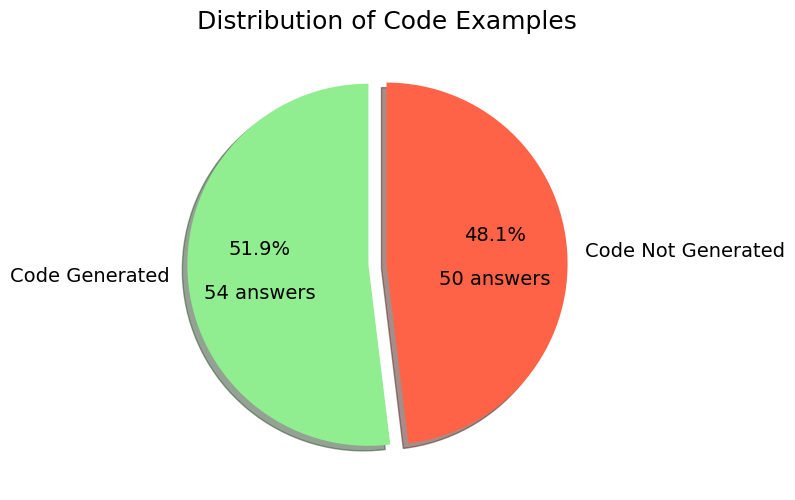

In [2]:
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update({'font.size': 14,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for the pie chart
sizes_asked_yes = [yes_yes_count, (104-yes_yes_count)]
labels_asked_yes = ['Code Generated', 'Code Not Generated']

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0.1, 0)  # Explode the 'Code Generated' slice slightly to draw attention to it
plt.pie(sizes_asked_yes, labels=labels_asked_yes, autopct=autopct_format(sizes_asked_yes), startangle=90, colors=['lightgreen', 'tomato'], explode=explode, shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Code Examples', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()


In [3]:
import json

# Assuming the file path is still valid
file_path = "Further Json Outputs/valued_rephrased_data.json"

# Re-read the data
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the sum and count for calculating the average
total_confidence_percentage = 0
count_valid_percentages = 0

# Iterate through each item to sum up and count valid "Confidence Percentage" values
for item in data:
    adjusted_percentage = adjust_confidence_percentage(item["Confidence Percentage"])
    total_confidence_percentage += adjusted_percentage
    count_valid_percentages += 1  # Increment for every item, since we adjust invalid values to 0

# Calculate the average, ensuring we don't divide by zero
average_confidence_percentage = (total_confidence_percentage / count_valid_percentages) if count_valid_percentages > 0 else 0

# Print the average "Confidence Percentage"
print(f'Average "Confidence Percentage" across the dataset: {average_confidence_percentage:.2f}%')

Average "Confidence Percentage" across the dataset: 66.70%


In [4]:
import numpy as np

# Assuming you have re-read the data and have the 'adjust_confidence_percentage' function ready
# Extract all valid "Confidence Percentage" values as a list
confidence_percentages = [adjust_confidence_percentage(item["Confidence Percentage"]) for item in data]

# Calculate percentiles
low_threshold = np.percentile(confidence_percentages, 25)
medium_threshold = np.percentile(confidence_percentages, 50)  # This is essentially the median
high_threshold = np.percentile(confidence_percentages, 75)

# Now, categorize the values based on these thresholds
low_count = len([x for x in confidence_percentages if x <= low_threshold])
medium_count = len([x for x in confidence_percentages if low_threshold < x <= medium_threshold])
high_count = len([x for x in confidence_percentages if x > medium_threshold])  # This includes values above the high_threshold

# Print the thresholds and counts
print(f'Low Threshold (25th percentile): {low_threshold}%')
print(f'Medium Threshold (50th percentile, Median): {medium_threshold}%')
print(f'High Threshold (75th percentile): {high_threshold}%')
print(f'Count of Low "Confidence Percentage": {low_count}')
print(f'Count of Medium "Confidence Percentage": {medium_count}')
print(f'Count of High "Confidence Percentage": {high_count}')

Low Threshold (25th percentile): 45.0%
Medium Threshold (50th percentile, Median): 75.0%
High Threshold (75th percentile): 100.0%
Count of Low "Confidence Percentage": 990
Count of Medium "Confidence Percentage": 994
Count of High "Confidence Percentage": 1840


In [5]:
import numpy as np

# Calculate histogram bins and counts
bin_edges = np.linspace(0, 100, 11)  # Define 10 bins from 0 to 100
hist_counts, _ = np.histogram(confidence_percentages, bins=bin_edges)

# Print the counts for each bin
for i in range(len(bin_edges)-1):
    print(f'Confidence Percentage {bin_edges[i]:.0f}% to {bin_edges[i+1]:.0f}%: {hist_counts[i]} answers')


Confidence Percentage 0% to 10%: 459 answers
Confidence Percentage 10% to 20%: 73 answers
Confidence Percentage 20% to 30%: 176 answers
Confidence Percentage 30% to 40%: 116 answers
Confidence Percentage 40% to 50%: 171 answers
Confidence Percentage 50% to 60%: 374 answers
Confidence Percentage 60% to 70%: 249 answers
Confidence Percentage 70% to 80%: 375 answers
Confidence Percentage 80% to 90%: 228 answers
Confidence Percentage 90% to 100%: 1603 answers


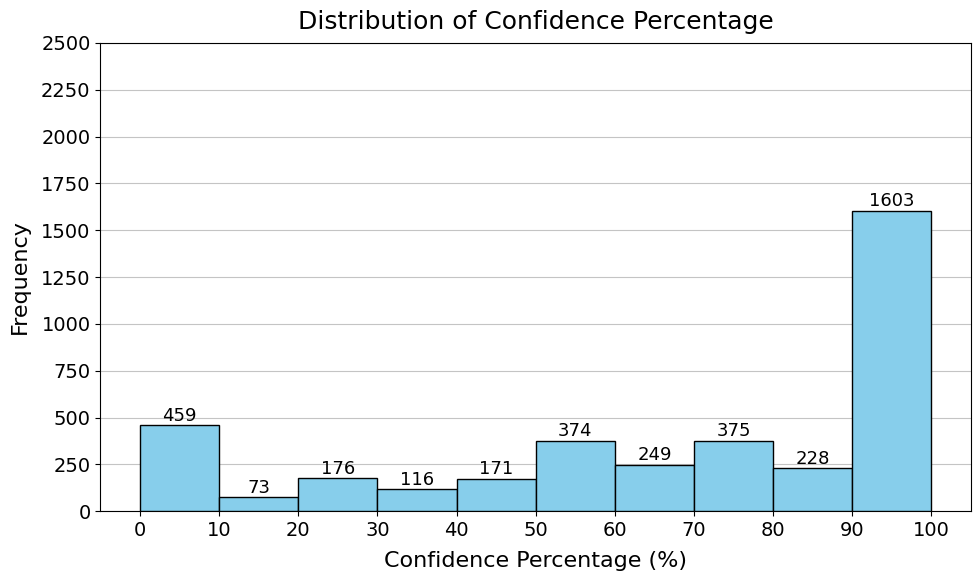

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Increase font sizes globally
plt.rcParams.update({'font.size': 13,  # Adjust base font size as needed
                     'axes.titlesize': 18,  # Adjust for title
                     'axes.labelsize': 16,  # Adjust for x and y labels
                     'xtick.labelsize': 14,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 14,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend
                     

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(confidence_percentages, bins=10, color='skyblue', edgecolor='black', alpha=1 ,zorder=3)

# Calculate the center of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Increase the spacing value here, for example to 10 or more, to increase spacing between bars and numbers
spacing = 25  # Adjust this value to increase or decrease the spacing

# Add text for the label in the center of each bin with increased spacing
for count, x in zip(n, bin_centers):
    if count > 0:
        plt.text(x, count + spacing, str(int(count)), ha='center')

plt.title('Distribution of Confidence Percentage', fontweight='normal', pad=10)
plt.xlabel('Confidence Percentage (%)', labelpad=8)
plt.ylabel('Frequency', labelpad=8)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, max(2750, max(n) + 100), max(250, (max(n) + 100)//10)))

plt.grid(axis='y', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()


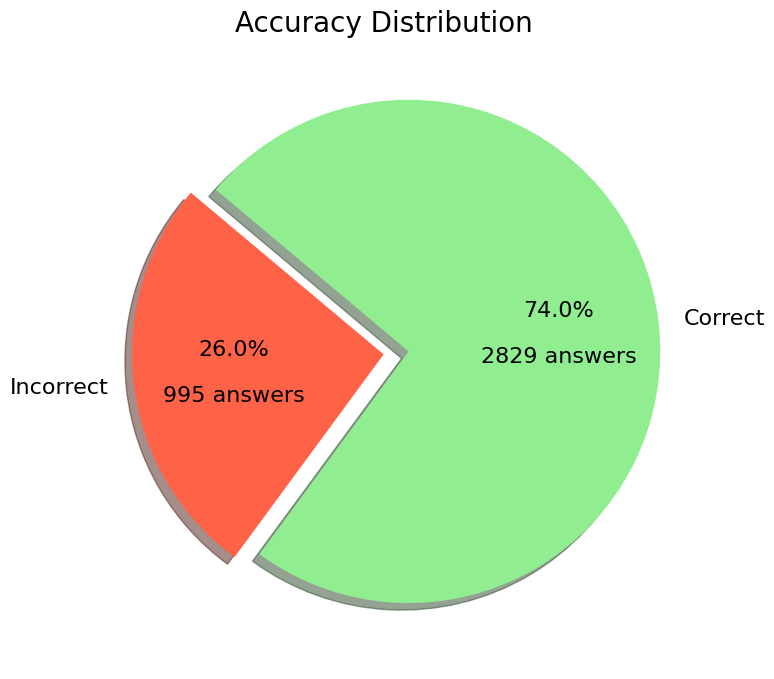

In [7]:
import matplotlib.pyplot as plt

# # Assuming gpt3_validation_0_count and gpt3_validation_1_count are defined somewhere in your code
# gpt3_validation_0_count = 1200  # Example value
# gpt3_validation_1_count = 2800  # Example value

# Increase font sizes globally
plt.rcParams.update({'font.size': 16,  # Adjust base font size as needed
                     'axes.titlesize': 20,  # Adjust for title
                     'axes.labelsize': 18,  # Adjust for x and y labels
                     'xtick.labelsize': 16,  # Adjust for x-axis tick labels
                     'ytick.labelsize': 16,  # Adjust for y-axis tick labels
                     'legend.fontsize': 14})  # Adjust for legend

# Data for plotting
gpt3_validation_counts = [gpt3_validation_0_count, gpt3_validation_1_count]
gpt3_labels = ['Incorrect', 'Correct']  # Use more descriptive labels

# Custom autopct function to include both percentage and count with more vertical spacing
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Adjust the vertical spacing with \n\n for more space
        return '{p:.1f}%\n\n{v:d} answers'.format(p=pct, v=val)
    return my_format

# Improved Pie Chart
plt.figure(figsize=(8, 8))
explode = (0, 0.1)  # Only explode the 'Correct' slice
plt.pie(gpt3_validation_counts, labels=gpt3_labels, autopct=autopct_format(gpt3_validation_counts), startangle=140, colors=['tomato', 'lightgreen'], explode=explode, shadow=True, textprops={'fontsize': 16})
plt.title('Accuracy Distribution', fontweight='normal')
plt.tight_layout()  # Adjusts subplots to fit in the figure area.
plt.show()
